### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
# for plotting graphs
import matplotlib.pyplot as plt
import os


Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
# Import the environment
from Env import CabDriver




#### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")






In [4]:
Time_matrix

array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 2.,  3.,  3., ...,  7.,  0.,  6.],
         [ 2.,  3.,  3., ...,  7.,  0.,  6.],
         [ 2.,  3.,  3., ...,  7.,  0.,  6.],
         ...,
         [ 2.,  3.,  6., ...,  7.,  4.,  2.],
         [ 2.,  3.,  6., ...,  7.,  4.,  2.],
         [ 2.,  3.,  6., ...,  7.,  4.,  2.]],

        [[ 2.,  6.,  5., ...,  3.,  7.,  7.],
         [ 2.,  6.,  5., ...,  3.,  7.,  7.],
         [ 2.,  6.,  5., ...,  3.,  7.,  7.],
         ...,
         [ 6.,  2.,  8., ...,  4.,  5.,  5.],
         [ 6.,  2.,  8., ...,  4.,  5.,  5.],
         [ 6.,  2.,  8., ...,  4.,  5.,  5.]],

        [[10.,  6.,  8., ...,  7.,  4.,  6.],
         [10.,  6.,  8., ...,  7.,  4.,  6.],
         [10.,  6.,  8., ...,  7

#### Tracking the state-action pairs for checking convergence


In [5]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)



In [6]:
# Initialize Tracking states for tracking Qvalues
def initialise_tracking_states():
    sample_q_values = [((2,4,5),(2,1)),((3,23,5),(2,1)),((2,4,6),(2,1)),((1,10,3),(2,4)),((3,20,3),(3,1))]    
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []
        
        
        
        

In [7]:
initialise_tracking_states()

<b> States to be tracked

In [8]:
States_track

defaultdict(dict,
            {(2, 4, 5): {(2, 1): []},
             (3, 23, 5): {(2, 1): []},
             (2, 4, 6): {(2, 1): []},
             (1, 10, 3): {(2, 4): []},
             (3, 20, 3): {(3, 1): []}})

In [9]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [10]:
# save stuff as pickle
def save_pickle(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# make directory
if not os.path.exists("saved_pickle_files"):
    os.mkdir("saved_pickle_files")

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [11]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor =0.95
        self.learning_rate = 0.01       
        self.epsilon = 1
        self.epsilon_decay = 0.99984
        self.epsilon_min = 0.001
        self.batch_size = 32  
        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    
    # Save Tracking states to States_track variable to determine convergence
    def save_tracking_states(self):
        for state in States_track.keys():
            state_encode = env.state_encod_arch1(state)
            update_input_enc = np.zeros((1, self.state_size))
            update_input_enc[0]=state_encode
            q_value = self.model.predict(update_input_enc)
            for action in States_track[state].keys():
                action_value_index=[j for j in range(len(env.action_space)) if env.action_space[j]==action][0]
                States_track[state][action].append(q_value[0][action_value_index])
    

    def get_action(self, state):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
         if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            actions_in_current_state=env.requests(state)
            return random.choice(actions_in_current_state[0])
         else:
            # choose the action with the highest q(s, a)
            state_epsilon = env.state_encod_arch1(state)
            update_input_eps = np.zeros((1, self.state_size))
            update_input_eps[0]=state_epsilon
            q_value = self.model.predict(update_input_eps)  # Predict values for input state
            actions_in_current_state=env.requests(state)    # Get possible actions in current state from environment
            #Determine best possible action among available actions from environment
            max_possible_state=actions_in_current_state[0][np.argmax(list(map(q_value[0].__getitem__, actions_in_current_state[0]) ))]
            return max_possible_state
        
        
        
        


    def append_sample(self, state, action, reward, next_state,done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory.
    # Also add done to determine Terminal step
        self.memory.append((state, action, reward, next_state, done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output= np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            actions, rewards,done = [], [],[]
            
            for i in range(self.batch_size):
                state, action, reward, next_state,done_boolean = mini_batch[i]
                input_state=env.state_encod_arch1(state)
                update_input[i] = input_state
                actions.append(action)
                rewards.append(reward)
                output_state=env.state_encod_arch1(next_state)
                update_output[i] = output_state
                done.append(done_boolean)
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                action_value_index=[j for j in range(len(env.action_space)) if env.action_space[j]==actions[i]][0]
                if done[i]: #Terminal state
                    target[i][action_value_index] = rewards[i]
                else: # non-terminal state
                    target[i][action_value_index] = rewards[i] + self.discount_factor * np.max(target_qval[i])                
                
            # 4. Fit your model and track the loss values
            hist=self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            return hist.history['loss']

    def save(self, name):
        save_pickle(self.model,name)

In [12]:
Episodes = 40000           # Number os episodes to run for

rewards_per_episode=[]     # Collection of all rewards
episodes=[]                
loss_values=[]



In [13]:
env=CabDriver()
state_size = len(env.state_encod_arch1((1,2,3))) # Get Encoded State size to be used(using a sample state) for DQN model
action_size = len(env.action_space)              # length of Action Space
agent=DQNAgent(state_size=state_size,action_size=action_size)



## Epsilon decay function

In [14]:
time = np.arange(0,40000)
tmpepsilon=1
epsilon = []
for i in range(0,40000):
    tmpepsilon=tmpepsilon*0.99984
    epsilon.append(tmpepsilon)
    
    
    

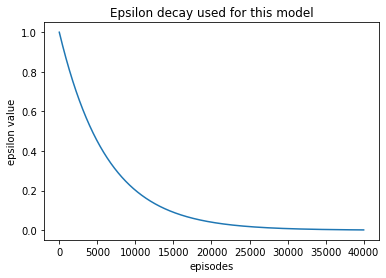

In [15]:
plt.title("Epsilon decay used for this model")
plt.plot(time, epsilon)
plt.xlabel("episodes")
plt.ylabel("epsilon value")
plt.show()


### DQN block


episode 0, reward -534.0, memory_length 146, epsilon 0.99984
episode 1, reward 17.0, memory_length 278, epsilon 0.9996800255999999
episode 2, reward 131.0, memory_length 431, epsilon 0.9995200767959038
episode 3, reward -131.0, memory_length 581, epsilon 0.9993601535836164
episode 4, reward -334.0, memory_length 724, epsilon 0.9992002559590429
episode 5, reward -314.0, memory_length 878, epsilon 0.9990403839180895
episode 6, reward -21.0, memory_length 1031, epsilon 0.9988805374566625
episode 7, reward -232.0, memory_length 1163, epsilon 0.9987207165706694
episode 8, reward -281.0, memory_length 1318, epsilon 0.998560921256018
episode 9, reward -195.0, memory_length 1487, epsilon 0.998401151508617
episode 10, reward -383.0, memory_length 1637, epsilon 0.9982414073243755
episode 11, reward 5.0, memory_length 1796, epsilon 0.9980816886992036
episode 12, reward 98.0, memory_length 1929, epsilon 0.9979219956290116
episode 13, reward -131.0, memory_length 2000, epsilon 0.9977623281097109
e

episode 110, reward -18.0, memory_length 2000, epsilon 0.9823953833573077
episode 111, reward -320.0, memory_length 2000, epsilon 0.9822382000959705
episode 112, reward -155.0, memory_length 2000, epsilon 0.9820810419839551
episode 113, reward -174.0, memory_length 2000, epsilon 0.9819239090172376
episode 114, reward -174.0, memory_length 2000, epsilon 0.9817668011917948
episode 115, reward -34.0, memory_length 2000, epsilon 0.9816097185036041
episode 116, reward -190.0, memory_length 2000, epsilon 0.9814526609486435
episode 117, reward -282.0, memory_length 2000, epsilon 0.9812956285228916
episode 118, reward 6.0, memory_length 2000, epsilon 0.981138621222328
episode 119, reward -11.0, memory_length 2000, epsilon 0.9809816390429323
episode 120, reward -34.0, memory_length 2000, epsilon 0.9808246819806854
episode 121, reward -244.0, memory_length 2000, epsilon 0.9806677500315685
episode 122, reward -189.0, memory_length 2000, epsilon 0.9805108431915633
episode 123, reward -131.0, memor

episode 220, reward -150.0, memory_length 2000, epsilon 0.9652551300625621
episode 221, reward -563.0, memory_length 2000, epsilon 0.9651006892417521
episode 222, reward -265.0, memory_length 2000, epsilon 0.9649462731314733
episode 223, reward -54.0, memory_length 2000, epsilon 0.9647918817277722
episode 224, reward -326.0, memory_length 2000, epsilon 0.9646375150266957
episode 225, reward -158.0, memory_length 2000, epsilon 0.9644831730242914
episode 226, reward -299.0, memory_length 2000, epsilon 0.9643288557166075
episode 227, reward -370.0, memory_length 2000, epsilon 0.9641745630996928
episode 228, reward -464.0, memory_length 2000, epsilon 0.9640202951695969
episode 229, reward -339.0, memory_length 2000, epsilon 0.9638660519223696
episode 230, reward -236.0, memory_length 2000, epsilon 0.963711833354062
episode 231, reward -250.0, memory_length 2000, epsilon 0.9635576394607253
episode 232, reward 30.0, memory_length 2000, epsilon 0.9634034702384114
episode 233, reward -178.0, m

episode 332, reward -546.0, memory_length 2000, epsilon 0.9481104615860532
episode 333, reward -90.0, memory_length 2000, epsilon 0.9479587639121994
episode 334, reward -478.0, memory_length 2000, epsilon 0.9478070905099734
episode 335, reward 258.0, memory_length 2000, epsilon 0.9476554413754917
episode 336, reward -206.0, memory_length 2000, epsilon 0.9475038165048716
episode 337, reward 102.0, memory_length 2000, epsilon 0.9473522158942308
episode 338, reward -128.0, memory_length 2000, epsilon 0.9472006395396877
episode 339, reward -129.0, memory_length 2000, epsilon 0.9470490874373613
episode 340, reward -98.0, memory_length 2000, epsilon 0.9468975595833713
episode 341, reward -206.0, memory_length 2000, epsilon 0.9467460559738379
episode 342, reward -80.0, memory_length 2000, epsilon 0.946594576604882
episode 343, reward -440.0, memory_length 2000, epsilon 0.9464431214726252
episode 344, reward -320.0, memory_length 2000, epsilon 0.9462916905731895
episode 345, reward 188.0, memo

episode 444, reward -135.0, memory_length 2000, epsilon 0.9312703132804444
episode 445, reward -110.0, memory_length 2000, epsilon 0.9311213100303195
episode 446, reward -182.0, memory_length 2000, epsilon 0.9309723306207146
episode 447, reward -350.0, memory_length 2000, epsilon 0.9308233750478152
episode 448, reward -147.0, memory_length 2000, epsilon 0.9306744433078075
episode 449, reward -302.0, memory_length 2000, epsilon 0.9305255353968782
episode 450, reward 115.0, memory_length 2000, epsilon 0.9303766513112147
episode 451, reward 27.0, memory_length 2000, epsilon 0.9302277910470049
episode 452, reward -295.0, memory_length 2000, epsilon 0.9300789546004373
episode 453, reward -195.0, memory_length 2000, epsilon 0.9299301419677012
episode 454, reward -314.0, memory_length 2000, epsilon 0.9297813531449863
episode 455, reward -32.0, memory_length 2000, epsilon 0.929632588128483
episode 456, reward -135.0, memory_length 2000, epsilon 0.9294838469143825
episode 457, reward -17.0, mem

episode 555, reward 43.0, memory_length 2000, epsilon 0.9148756564244225
episode 556, reward -219.0, memory_length 2000, epsilon 0.9147292763193945
episode 557, reward 259.0, memory_length 2000, epsilon 0.9145829196351833
episode 558, reward -123.0, memory_length 2000, epsilon 0.9144365863680417
episode 559, reward 367.0, memory_length 2000, epsilon 0.9142902765142228
episode 560, reward -8.0, memory_length 2000, epsilon 0.9141439900699805
episode 561, reward 192.0, memory_length 2000, epsilon 0.9139977270315692
episode 562, reward -469.0, memory_length 2000, epsilon 0.9138514873952441
episode 563, reward -222.0, memory_length 2000, epsilon 0.9137052711572609
episode 564, reward -55.0, memory_length 2000, epsilon 0.9135590783138756
episode 565, reward -131.0, memory_length 2000, epsilon 0.9134129088613453
episode 566, reward 227.0, memory_length 2000, epsilon 0.9132667627959274
episode 567, reward 13.0, memory_length 2000, epsilon 0.91312064011388
episode 568, reward 26.0, memory_lengt

episode 666, reward 350.0, memory_length 2000, epsilon 0.8987696212173399
episode 667, reward 4.0, memory_length 2000, epsilon 0.8986258180779452
episode 668, reward -33.0, memory_length 2000, epsilon 0.8984820379470526
episode 669, reward 88.0, memory_length 2000, epsilon 0.898338280820981
episode 670, reward 137.0, memory_length 2000, epsilon 0.8981945466960496
episode 671, reward -199.0, memory_length 2000, epsilon 0.8980508355685782
episode 672, reward -261.0, memory_length 2000, epsilon 0.8979071474348872
episode 673, reward -401.0, memory_length 2000, epsilon 0.8977634822912975
episode 674, reward -190.0, memory_length 2000, epsilon 0.8976198401341309
episode 675, reward -81.0, memory_length 2000, epsilon 0.8974762209597094
episode 676, reward -37.0, memory_length 2000, epsilon 0.8973326247643557
episode 677, reward -71.0, memory_length 2000, epsilon 0.8971890515443933
episode 678, reward 37.0, memory_length 2000, epsilon 0.8970455012961461
episode 679, reward 43.0, memory_length

episode 777, reward 144.0, memory_length 2000, epsilon 0.8829471265857106
episode 778, reward -3.0, memory_length 2000, epsilon 0.8828058550454568
episode 779, reward -122.0, memory_length 2000, epsilon 0.8826646061086495
episode 780, reward -139.0, memory_length 2000, epsilon 0.8825233797716721
episode 781, reward -168.0, memory_length 2000, epsilon 0.8823821760309085
episode 782, reward 81.0, memory_length 2000, epsilon 0.8822409948827435
episode 783, reward 90.0, memory_length 2000, epsilon 0.8820998363235623
episode 784, reward -16.0, memory_length 2000, epsilon 0.8819587003497504
episode 785, reward 52.0, memory_length 2000, epsilon 0.8818175869576944
episode 786, reward -293.0, memory_length 2000, epsilon 0.8816764961437812
episode 787, reward 39.0, memory_length 2000, epsilon 0.8815354279043981
episode 788, reward -224.0, memory_length 2000, epsilon 0.8813943822359334
episode 789, reward -199.0, memory_length 2000, epsilon 0.8812533591347755
episode 790, reward -57.0, memory_len

episode 889, reward 33.0, memory_length 2000, epsilon 0.867264396397457
episode 890, reward 288.0, memory_length 2000, epsilon 0.8671256340940333
episode 891, reward 47.0, memory_length 2000, epsilon 0.8669868939925782
episode 892, reward 70.0, memory_length 2000, epsilon 0.8668481760895393
episode 893, reward 12.0, memory_length 2000, epsilon 0.866709480381365
episode 894, reward -232.0, memory_length 2000, epsilon 0.8665708068645039
episode 895, reward -235.0, memory_length 2000, epsilon 0.8664321555354055
episode 896, reward -121.0, memory_length 2000, epsilon 0.8662935263905198
episode 897, reward 22.0, memory_length 2000, epsilon 0.8661549194262973
episode 898, reward 106.0, memory_length 2000, epsilon 0.866016334639189
episode 899, reward -151.0, memory_length 2000, epsilon 0.8658777720256468
episode 900, reward -114.0, memory_length 2000, epsilon 0.8657392315821226
episode 901, reward 343.0, memory_length 2000, epsilon 0.8656007133050695
episode 902, reward -82.0, memory_length 

episode 1000, reward -183.0, memory_length 2000, epsilon 0.8519965391710237
episode 1001, reward 151.0, memory_length 2000, epsilon 0.8518602197247563
episode 1002, reward 207.0, memory_length 2000, epsilon 0.8517239220896003
episode 1003, reward 67.0, memory_length 2000, epsilon 0.851587646262066
episode 1004, reward -161.0, memory_length 2000, epsilon 0.851451392238664
episode 1005, reward 149.0, memory_length 2000, epsilon 0.8513151600159057
episode 1006, reward 180.0, memory_length 2000, epsilon 0.851178949590303
episode 1007, reward -101.0, memory_length 2000, epsilon 0.8510427609583685
episode 1008, reward -25.0, memory_length 2000, epsilon 0.8509065941166152
episode 1009, reward -46.0, memory_length 2000, epsilon 0.8507704490615565
episode 1010, reward -43.0, memory_length 2000, epsilon 0.8506343257897067
episode 1011, reward 143.0, memory_length 2000, epsilon 0.8504982242975803
episode 1012, reward 37.0, memory_length 2000, epsilon 0.8503621445816926
episode 1013, reward 177.0,

episode 1110, reward 184.0, memory_length 2000, epsilon 0.8371314077432565
episode 1111, reward -27.0, memory_length 2000, epsilon 0.8369974667180174
episode 1112, reward -15.0, memory_length 2000, epsilon 0.8368635471233425
episode 1113, reward 97.0, memory_length 2000, epsilon 0.8367296489558028
episode 1114, reward 349.0, memory_length 2000, epsilon 0.8365957722119699
episode 1115, reward 122.0, memory_length 2000, epsilon 0.836461916888416
episode 1116, reward 106.0, memory_length 2000, epsilon 0.8363280829817138
episode 1117, reward 55.0, memory_length 2000, epsilon 0.8361942704884366
episode 1118, reward -82.0, memory_length 2000, epsilon 0.8360604794051585
episode 1119, reward -48.0, memory_length 2000, epsilon 0.8359267097284536
episode 1120, reward -31.0, memory_length 2000, epsilon 0.835792961454897
episode 1121, reward 200.0, memory_length 2000, epsilon 0.8356592345810642
episode 1122, reward -154.0, memory_length 2000, epsilon 0.8355255291035312
episode 1123, reward 309.0, 

episode 1220, reward 400.0, memory_length 2000, epsilon 0.8225256343318723
episode 1221, reward 339.0, memory_length 2000, epsilon 0.8223940302303792
episode 1222, reward -63.0, memory_length 2000, epsilon 0.8222624471855423
episode 1223, reward 120.0, memory_length 2000, epsilon 0.8221308851939926
episode 1224, reward -219.0, memory_length 2000, epsilon 0.8219993442523615
episode 1225, reward 240.0, memory_length 2000, epsilon 0.8218678243572811
episode 1226, reward 311.0, memory_length 2000, epsilon 0.8217363255053839
episode 1227, reward -237.0, memory_length 2000, epsilon 0.821604847693303
episode 1228, reward -211.0, memory_length 2000, epsilon 0.821473390917672
episode 1229, reward 17.0, memory_length 2000, epsilon 0.8213419551751252
episode 1230, reward 366.0, memory_length 2000, epsilon 0.8212105404622971
episode 1231, reward 79.0, memory_length 2000, epsilon 0.8210791467758232
episode 1232, reward 180.0, memory_length 2000, epsilon 0.820947774112339
episode 1233, reward -51.0,

episode 1331, reward -347.0, memory_length 2000, epsilon 0.8080453858606724
episode 1332, reward -153.0, memory_length 2000, epsilon 0.8079160985989347
episode 1333, reward -95.0, memory_length 2000, epsilon 0.8077868320231588
episode 1334, reward -43.0, memory_length 2000, epsilon 0.807657586130035
episode 1335, reward -15.0, memory_length 2000, epsilon 0.8075283609162541
episode 1336, reward 315.0, memory_length 2000, epsilon 0.8073991563785075
episode 1337, reward -209.0, memory_length 2000, epsilon 0.8072699725134869
episode 1338, reward -190.0, memory_length 2000, epsilon 0.8071408093178847
episode 1339, reward 603.0, memory_length 2000, epsilon 0.8070116667883938
episode 1340, reward -161.0, memory_length 2000, epsilon 0.8068825449217075
episode 1341, reward 333.0, memory_length 2000, epsilon 0.80675344371452
episode 1342, reward 24.0, memory_length 2000, epsilon 0.8066243631635256
episode 1343, reward 74.0, memory_length 2000, epsilon 0.8064953032654194
episode 1344, reward 377.

episode 1442, reward 123.0, memory_length 2000, epsilon 0.7938200566126987
episode 1443, reward 542.0, memory_length 2000, epsilon 0.7936930454036406
episode 1444, reward 159.0, memory_length 2000, epsilon 0.793566054516376
episode 1445, reward 293.0, memory_length 2000, epsilon 0.7934390839476533
episode 1446, reward 194.0, memory_length 2000, epsilon 0.7933121336942216
episode 1447, reward 78.0, memory_length 2000, epsilon 0.7931852037528305
episode 1448, reward 297.0, memory_length 2000, epsilon 0.79305829412023
episode 1449, reward 100.0, memory_length 2000, epsilon 0.7929314047931707
episode 1450, reward 203.0, memory_length 2000, epsilon 0.7928045357684037
episode 1451, reward 178.0, memory_length 2000, epsilon 0.7926776870426807
episode 1452, reward 234.0, memory_length 2000, epsilon 0.7925508586127539
episode 1453, reward 311.0, memory_length 2000, epsilon 0.7924240504753758
episode 1454, reward -136.0, memory_length 2000, epsilon 0.7922972626272997
episode 1455, reward 486.0, 

episode 1553, reward 482.0, memory_length 2000, epsilon 0.7798451588327515
episode 1554, reward 199.0, memory_length 2000, epsilon 0.7797203836073382
episode 1555, reward -12.0, memory_length 2000, epsilon 0.779595628345961
episode 1556, reward 301.0, memory_length 2000, epsilon 0.7794708930454256
episode 1557, reward 281.0, memory_length 2000, epsilon 0.7793461777025383
episode 1558, reward 376.0, memory_length 2000, epsilon 0.7792214823141059
episode 1559, reward 540.0, memory_length 2000, epsilon 0.7790968068769356
episode 1560, reward -87.0, memory_length 2000, epsilon 0.7789721513878353
episode 1561, reward -21.0, memory_length 2000, epsilon 0.7788475158436132
episode 1562, reward 15.0, memory_length 2000, epsilon 0.7787229002410783
episode 1563, reward 93.0, memory_length 2000, epsilon 0.7785983045770396
episode 1564, reward 349.0, memory_length 2000, epsilon 0.7784737288483072
episode 1565, reward 374.0, memory_length 2000, epsilon 0.7783491730516915
episode 1566, reward -60.0, 

episode 1663, reward -58.0, memory_length 2000, epsilon 0.76623888199196
episode 1664, reward 233.0, memory_length 2000, epsilon 0.7661162837708413
episode 1665, reward 413.0, memory_length 2000, epsilon 0.765993705165438
episode 1666, reward -60.0, memory_length 2000, epsilon 0.7658711461726114
episode 1667, reward 326.0, memory_length 2000, epsilon 0.7657486067892237
episode 1668, reward 189.0, memory_length 2000, epsilon 0.7656260870121374
episode 1669, reward -105.0, memory_length 2000, epsilon 0.7655035868382154
episode 1670, reward 78.0, memory_length 2000, epsilon 0.7653811062643212
episode 1671, reward 249.0, memory_length 2000, epsilon 0.7652586452873189
episode 1672, reward 234.0, memory_length 2000, epsilon 0.7651362039040729
episode 1673, reward 46.0, memory_length 2000, epsilon 0.7650137821114482
episode 1674, reward 184.0, memory_length 2000, epsilon 0.7648913799063104
episode 1675, reward 226.0, memory_length 2000, epsilon 0.7647689972855254
episode 1676, reward 132.0, m

episode 1773, reward 7.0, memory_length 2000, epsilon 0.7528699994176733
episode 1774, reward -139.0, memory_length 2000, epsilon 0.7527495402177664
episode 1775, reward -4.0, memory_length 2000, epsilon 0.7526291002913316
episode 1776, reward 363.0, memory_length 2000, epsilon 0.7525086796352849
episode 1777, reward 419.0, memory_length 2000, epsilon 0.7523882782465432
episode 1778, reward 309.0, memory_length 2000, epsilon 0.7522678961220237
episode 1779, reward 396.0, memory_length 2000, epsilon 0.7521475332586441
episode 1780, reward 330.0, memory_length 2000, epsilon 0.7520271896533227
episode 1781, reward 83.0, memory_length 2000, epsilon 0.7519068653029781
episode 1782, reward 38.0, memory_length 2000, epsilon 0.7517865602045296
episode 1783, reward 277.0, memory_length 2000, epsilon 0.7516662743548969
episode 1784, reward 387.0, memory_length 2000, epsilon 0.751546007751
episode 1785, reward 56.0, memory_length 2000, epsilon 0.7514257603897598
episode 1786, reward 364.0, memory

episode 1883, reward 433.0, memory_length 2000, epsilon 0.7397343691952121
episode 1884, reward 107.0, memory_length 2000, epsilon 0.7396160116961408
episode 1885, reward 270.0, memory_length 2000, epsilon 0.7394976731342694
episode 1886, reward 126.0, memory_length 2000, epsilon 0.7393793535065679
episode 1887, reward -14.0, memory_length 2000, epsilon 0.7392610528100069
episode 1888, reward 455.0, memory_length 2000, epsilon 0.7391427710415572
episode 1889, reward 372.0, memory_length 2000, epsilon 0.7390245081981905
episode 1890, reward 201.0, memory_length 2000, epsilon 0.7389062642768788
episode 1891, reward 312.0, memory_length 2000, epsilon 0.7387880392745945
episode 1892, reward 179.0, memory_length 2000, epsilon 0.7386698331883105
episode 1893, reward -19.0, memory_length 2000, epsilon 0.7385516460150003
episode 1894, reward -3.0, memory_length 2000, epsilon 0.7384334777516379
episode 1895, reward 434.0, memory_length 2000, epsilon 0.7383153283951976
episode 1896, reward 146.0

episode 1993, reward -188.0, memory_length 2000, epsilon 0.7268279216755753
episode 1994, reward 354.0, memory_length 2000, epsilon 0.7267116292081072
episode 1995, reward 98.0, memory_length 2000, epsilon 0.7265953553474338
episode 1996, reward -102.0, memory_length 2000, epsilon 0.7264791000905781
episode 1997, reward 231.0, memory_length 2000, epsilon 0.7263628634345636
episode 1998, reward 270.0, memory_length 2000, epsilon 0.726246645376414
episode 1999, reward 256.0, memory_length 2000, epsilon 0.7261304459131538
episode 2000, reward 226.0, memory_length 2000, epsilon 0.7260142650418077
episode 2001, reward 240.0, memory_length 2000, epsilon 0.7258981027594009
episode 2002, reward 119.0, memory_length 2000, epsilon 0.7257819590629594
episode 2003, reward 329.0, memory_length 2000, epsilon 0.7256658339495092
episode 2004, reward 254.0, memory_length 2000, epsilon 0.7255497274160773
episode 2005, reward 0.0, memory_length 2000, epsilon 0.7254336394596906
episode 2006, reward 314.0,

episode 2104, reward -208.0, memory_length 2000, epsilon 0.7140323947492726
episode 2105, reward 56.0, memory_length 2000, epsilon 0.7139181495661127
episode 2106, reward 128.0, memory_length 2000, epsilon 0.7138039226621821
episode 2107, reward 234.0, memory_length 2000, epsilon 0.713689714034556
episode 2108, reward 131.0, memory_length 2000, epsilon 0.7135755236803105
episode 2109, reward 184.0, memory_length 2000, epsilon 0.7134613515965217
episode 2110, reward 185.0, memory_length 2000, epsilon 0.7133471977802662
episode 2111, reward 675.0, memory_length 2000, epsilon 0.7132330622286214
episode 2112, reward 57.0, memory_length 2000, epsilon 0.7131189449386648
episode 2113, reward 443.0, memory_length 2000, epsilon 0.7130048459074746
episode 2114, reward -31.0, memory_length 2000, epsilon 0.7128907651321293
episode 2115, reward 509.0, memory_length 2000, epsilon 0.7127767026097082
episode 2116, reward 24.0, memory_length 2000, epsilon 0.7126626583372906
episode 2117, reward 222.0, 

episode 2214, reward 354.0, memory_length 2000, epsilon 0.7015743800700596
episode 2215, reward 666.0, memory_length 2000, epsilon 0.7014621281692484
episode 2216, reward 129.0, memory_length 2000, epsilon 0.7013498942287413
episode 2217, reward 533.0, memory_length 2000, epsilon 0.7012376782456646
episode 2218, reward -184.0, memory_length 2000, epsilon 0.7011254802171453
episode 2219, reward 91.0, memory_length 2000, epsilon 0.7010133001403105
episode 2220, reward 552.0, memory_length 2000, epsilon 0.700901138012288
episode 2221, reward 108.0, memory_length 2000, epsilon 0.700788993830206
episode 2222, reward -24.0, memory_length 2000, epsilon 0.7006768675911931
episode 2223, reward 381.0, memory_length 2000, epsilon 0.7005647592923785
episode 2224, reward 541.0, memory_length 2000, epsilon 0.7004526689308916
episode 2225, reward 197.0, memory_length 2000, epsilon 0.7003405965038627
episode 2226, reward 244.0, memory_length 2000, epsilon 0.7002285420084221
episode 2227, reward 646.0,

episode 2325, reward 184.0, memory_length 2000, epsilon 0.6892234320625916
episode 2326, reward 269.0, memory_length 2000, epsilon 0.6891131563134616
episode 2327, reward 262.0, memory_length 2000, epsilon 0.6890028982084514
episode 2328, reward 78.0, memory_length 2000, epsilon 0.688892657744738
episode 2329, reward 292.0, memory_length 2000, epsilon 0.6887824349194988
episode 2330, reward -94.0, memory_length 2000, epsilon 0.6886722297299116
episode 2331, reward 202.0, memory_length 2000, epsilon 0.6885620421731548
episode 2332, reward 330.0, memory_length 2000, epsilon 0.688451872246407
episode 2333, reward 233.0, memory_length 2000, epsilon 0.6883417199468476
episode 2334, reward 379.0, memory_length 2000, epsilon 0.6882315852716561
episode 2335, reward 151.0, memory_length 2000, epsilon 0.6881214682180126
episode 2336, reward 293.0, memory_length 2000, epsilon 0.6880113687830977
episode 2337, reward 177.0, memory_length 2000, epsilon 0.6879012869640924
episode 2338, reward 138.0, 

episode 2435, reward 138.0, memory_length 2000, epsilon 0.677198269483086
episode 2436, reward 551.0, memory_length 2000, epsilon 0.6770899177599687
episode 2437, reward 151.0, memory_length 2000, epsilon 0.6769815833731271
episode 2438, reward 199.0, memory_length 2000, epsilon 0.6768732663197874
episode 2439, reward 222.0, memory_length 2000, epsilon 0.6767649665971762
episode 2440, reward 73.0, memory_length 2000, epsilon 0.6766566842025207
episode 2441, reward 226.0, memory_length 2000, epsilon 0.6765484191330482
episode 2442, reward 392.0, memory_length 2000, epsilon 0.6764401713859869
episode 2443, reward 251.0, memory_length 2000, epsilon 0.6763319409585651
episode 2444, reward 51.0, memory_length 2000, epsilon 0.6762237278480117
episode 2445, reward 488.0, memory_length 2000, epsilon 0.676115532051556
episode 2446, reward -99.0, memory_length 2000, epsilon 0.6760073535664277
episode 2447, reward 233.0, memory_length 2000, epsilon 0.6758991923898571
episode 2448, reward 354.0, m

episode 2545, reward 360.0, memory_length 2000, epsilon 0.6653829148241142
episode 2546, reward 313.0, memory_length 2000, epsilon 0.6652764535577422
episode 2547, reward 407.0, memory_length 2000, epsilon 0.665170009325173
episode 2548, reward 81.0, memory_length 2000, epsilon 0.665063582123681
episode 2549, reward 127.0, memory_length 2000, epsilon 0.6649571719505412
episode 2550, reward 516.0, memory_length 2000, epsilon 0.664850778803029
episode 2551, reward 575.0, memory_length 2000, epsilon 0.6647444026784205
episode 2552, reward 553.0, memory_length 2000, epsilon 0.6646380435739919
episode 2553, reward 195.0, memory_length 2000, epsilon 0.66453170148702
episode 2554, reward 400.0, memory_length 2000, epsilon 0.664425376414782
episode 2555, reward 632.0, memory_length 2000, epsilon 0.6643190683545557
episode 2556, reward 338.0, memory_length 2000, epsilon 0.6642127773036189
episode 2557, reward 707.0, memory_length 2000, epsilon 0.6641065032592504
episode 2558, reward 618.0, memo

episode 2655, reward 180.0, memory_length 2000, epsilon 0.6537737074812354
episode 2656, reward 326.0, memory_length 2000, epsilon 0.6536691036880384
episode 2657, reward 397.0, memory_length 2000, epsilon 0.6535645166314483
episode 2658, reward 311.0, memory_length 2000, epsilon 0.6534599463087872
episode 2659, reward 181.0, memory_length 2000, epsilon 0.6533553927173777
episode 2660, reward -25.0, memory_length 2000, epsilon 0.6532508558545429
episode 2661, reward 223.0, memory_length 2000, epsilon 0.6531463357176062
episode 2662, reward 386.0, memory_length 2000, epsilon 0.6530418323038913
episode 2663, reward 168.0, memory_length 2000, epsilon 0.6529373456107227
episode 2664, reward 31.0, memory_length 2000, epsilon 0.6528328756354249
episode 2665, reward 574.0, memory_length 2000, epsilon 0.6527284223753232
episode 2666, reward 417.0, memory_length 2000, epsilon 0.6526239858277432
episode 2667, reward 259.0, memory_length 2000, epsilon 0.6525195659900107
episode 2668, reward 614.0

episode 2765, reward 442.0, memory_length 2000, epsilon 0.6423670507180714
episode 2766, reward 692.0, memory_length 2000, epsilon 0.6422642719899565
episode 2767, reward 329.0, memory_length 2000, epsilon 0.642161509706438
episode 2768, reward 232.0, memory_length 2000, epsilon 0.642058763864885
episode 2769, reward 495.0, memory_length 2000, epsilon 0.6419560344626666
episode 2770, reward 398.0, memory_length 2000, epsilon 0.6418533214971526
episode 2771, reward 469.0, memory_length 2000, epsilon 0.641750624965713
episode 2772, reward 309.0, memory_length 2000, epsilon 0.6416479448657184
episode 2773, reward 562.0, memory_length 2000, epsilon 0.6415452811945399
episode 2774, reward 209.0, memory_length 2000, epsilon 0.6414426339495487
episode 2775, reward 475.0, memory_length 2000, epsilon 0.6413400031281168
episode 2776, reward 314.0, memory_length 2000, epsilon 0.6412373887276163
episode 2777, reward 342.0, memory_length 2000, epsilon 0.6411347907454198
episode 2778, reward 365.0, 

episode 2875, reward 202.0, memory_length 2000, epsilon 0.6311594105519713
episode 2876, reward 330.0, memory_length 2000, epsilon 0.631058425046283
episode 2877, reward 294.0, memory_length 2000, epsilon 0.6309574556982755
episode 2878, reward 867.0, memory_length 2000, epsilon 0.6308565025053638
episode 2879, reward 172.0, memory_length 2000, epsilon 0.6307555654649629
episode 2880, reward 539.0, memory_length 2000, epsilon 0.6306546445744885
episode 2881, reward 562.0, memory_length 2000, epsilon 0.6305537398313565
episode 2882, reward 814.0, memory_length 2000, epsilon 0.6304528512329834
episode 2883, reward 436.0, memory_length 2000, epsilon 0.6303519787767862
episode 2884, reward 627.0, memory_length 2000, epsilon 0.6302511224601819
episode 2885, reward 141.0, memory_length 2000, epsilon 0.6301502822805882
episode 2886, reward 285.0, memory_length 2000, epsilon 0.6300494582354234
episode 2887, reward 309.0, memory_length 2000, epsilon 0.6299486503221057
episode 2888, reward 602.0

episode 2985, reward 452.0, memory_length 2000, epsilon 0.6201473146591215
episode 2986, reward 656.0, memory_length 2000, epsilon 0.620048091088776
episode 2987, reward 519.0, memory_length 2000, epsilon 0.6199488833942017
episode 2988, reward 458.0, memory_length 2000, epsilon 0.6198496915728586
episode 2989, reward 490.0, memory_length 2000, epsilon 0.619750515622207
episode 2990, reward 476.0, memory_length 2000, epsilon 0.6196513555397074
episode 2991, reward 97.0, memory_length 2000, epsilon 0.619552211322821
episode 2992, reward 572.0, memory_length 2000, epsilon 0.6194530829690094
episode 2993, reward 662.0, memory_length 2000, epsilon 0.6193539704757343
episode 2994, reward 516.0, memory_length 2000, epsilon 0.6192548738404581
episode 2995, reward 603.0, memory_length 2000, epsilon 0.6191557930606436
episode 2996, reward 429.0, memory_length 2000, epsilon 0.6190567281337539
episode 2997, reward 424.0, memory_length 2000, epsilon 0.6189576790572525
episode 2998, reward 471.0, m

episode 3095, reward 292.0, memory_length 2000, epsilon 0.6093273512987607
episode 3096, reward 309.0, memory_length 2000, epsilon 0.6092298589225529
episode 3097, reward 349.0, memory_length 2000, epsilon 0.6091323821451252
episode 3098, reward 651.0, memory_length 2000, epsilon 0.6090349209639819
episode 3099, reward 535.0, memory_length 2000, epsilon 0.6089374753766277
episode 3100, reward 293.0, memory_length 2000, epsilon 0.6088400453805674
episode 3101, reward 770.0, memory_length 2000, epsilon 0.6087426309733064
episode 3102, reward 781.0, memory_length 2000, epsilon 0.6086452321523507
episode 3103, reward 343.0, memory_length 2000, epsilon 0.6085478489152063
episode 3104, reward 821.0, memory_length 2000, epsilon 0.6084504812593798
episode 3105, reward 513.0, memory_length 2000, epsilon 0.6083531291823783
episode 3106, reward 725.0, memory_length 2000, epsilon 0.608255792681709
episode 3107, reward 476.0, memory_length 2000, epsilon 0.6081584717548799
episode 3108, reward 591.0

episode 3205, reward 438.0, memory_length 2000, epsilon 0.5986961682561597
episode 3206, reward 749.0, memory_length 2000, epsilon 0.5986003768692386
episode 3207, reward 427.0, memory_length 2000, epsilon 0.5985046008089395
episode 3208, reward 461.0, memory_length 2000, epsilon 0.59840884007281
episode 3209, reward 458.0, memory_length 2000, epsilon 0.5983130946583983
episode 3210, reward 485.0, memory_length 2000, epsilon 0.5982173645632529
episode 3211, reward 648.0, memory_length 2000, epsilon 0.5981216497849228
episode 3212, reward 565.0, memory_length 2000, epsilon 0.5980259503209572
episode 3213, reward 576.0, memory_length 2000, epsilon 0.5979302661689058
episode 3214, reward 237.0, memory_length 2000, epsilon 0.5978345973263187
episode 3215, reward 444.0, memory_length 2000, epsilon 0.5977389437907464
episode 3216, reward 692.0, memory_length 2000, epsilon 0.5976433055597399
episode 3217, reward 702.0, memory_length 2000, epsilon 0.5975476826308503
episode 3218, reward 491.0,

episode 3315, reward 594.0, memory_length 2000, epsilon 0.5882504718040493
episode 3316, reward 445.0, memory_length 2000, epsilon 0.5881563517285606
episode 3317, reward 239.0, memory_length 2000, epsilon 0.588062246712284
episode 3318, reward 226.0, memory_length 2000, epsilon 0.58796815675281
episode 3319, reward 303.0, memory_length 2000, epsilon 0.5878740818477295
episode 3320, reward 608.0, memory_length 2000, epsilon 0.5877800219946339
episode 3321, reward 327.0, memory_length 2000, epsilon 0.5876859771911147
episode 3322, reward 116.0, memory_length 2000, epsilon 0.5875919474347641
episode 3323, reward 206.0, memory_length 2000, epsilon 0.5874979327231745
episode 3324, reward 495.0, memory_length 2000, epsilon 0.5874039330539388
episode 3325, reward 616.0, memory_length 2000, epsilon 0.5873099484246501
episode 3326, reward 678.0, memory_length 2000, epsilon 0.5872159788329021
episode 3327, reward 643.0, memory_length 2000, epsilon 0.5871220242762888
episode 3328, reward 351.0, 

episode 3425, reward 699.0, memory_length 2000, epsilon 0.5779870256821652
episode 3426, reward 335.0, memory_length 2000, epsilon 0.577894547758056
episode 3427, reward 687.0, memory_length 2000, epsilon 0.5778020846304147
episode 3428, reward 691.0, memory_length 2000, epsilon 0.5777096362968738
episode 3429, reward 518.0, memory_length 2000, epsilon 0.5776172027550662
episode 3430, reward 643.0, memory_length 2000, epsilon 0.5775247840026254
episode 3431, reward 588.0, memory_length 2000, epsilon 0.577432380037185
episode 3432, reward 179.0, memory_length 2000, epsilon 0.577339990856379
episode 3433, reward 606.0, memory_length 2000, epsilon 0.577247616457842
episode 3434, reward 700.0, memory_length 2000, epsilon 0.5771552568392087
episode 3435, reward 484.0, memory_length 2000, epsilon 0.5770629119981143
episode 3436, reward 684.0, memory_length 2000, epsilon 0.5769705819321946
episode 3437, reward 291.0, memory_length 2000, epsilon 0.5768782666390855
episode 3438, reward 625.0, m

episode 3535, reward 353.0, memory_length 2000, epsilon 0.5679026500945958
episode 3536, reward 494.0, memory_length 2000, epsilon 0.5678117856705807
episode 3537, reward 516.0, memory_length 2000, epsilon 0.5677209357848734
episode 3538, reward 690.0, memory_length 2000, epsilon 0.5676301004351477
episode 3539, reward 440.0, memory_length 2000, epsilon 0.567539279619078
episode 3540, reward 755.0, memory_length 2000, epsilon 0.5674484733343389
episode 3541, reward 590.0, memory_length 2000, epsilon 0.5673576815786053
episode 3542, reward 680.0, memory_length 2000, epsilon 0.5672669043495527
episode 3543, reward 647.0, memory_length 2000, epsilon 0.5671761416448567
episode 3544, reward 753.0, memory_length 2000, epsilon 0.5670853934621936
episode 3545, reward 565.0, memory_length 2000, epsilon 0.5669946597992396
episode 3546, reward 739.0, memory_length 2000, epsilon 0.5669039406536717
episode 3547, reward 445.0, memory_length 2000, epsilon 0.566813236023167
episode 3548, reward 493.0,

episode 3645, reward 568.0, memory_length 2000, epsilon 0.5579942207246272
episode 3646, reward 372.0, memory_length 2000, epsilon 0.5579049416493113
episode 3647, reward 897.0, memory_length 2000, epsilon 0.5578156768586473
episode 3648, reward 549.0, memory_length 2000, epsilon 0.5577264263503499
episode 3649, reward 864.0, memory_length 2000, epsilon 0.5576371901221338
episode 3650, reward 72.0, memory_length 2000, epsilon 0.5575479681717141
episode 3651, reward 51.0, memory_length 2000, epsilon 0.5574587604968066
episode 3652, reward 523.0, memory_length 2000, epsilon 0.5573695670951271
episode 3653, reward 399.0, memory_length 2000, epsilon 0.5572803879643918
episode 3654, reward 435.0, memory_length 2000, epsilon 0.5571912231023175
episode 3655, reward 836.0, memory_length 2000, epsilon 0.5571020725066211
episode 3656, reward 747.0, memory_length 2000, epsilon 0.55701293617502
episode 3657, reward 744.0, memory_length 2000, epsilon 0.556923814105232
episode 3658, reward 475.0, me

episode 3755, reward 620.0, memory_length 2000, epsilon 0.548258667766775
episode 3756, reward 851.0, memory_length 2000, epsilon 0.5481709463799322
episode 3757, reward 726.0, memory_length 2000, epsilon 0.5480832390285114
episode 3758, reward 768.0, memory_length 2000, epsilon 0.5479955457102669
episode 3759, reward 716.0, memory_length 2000, epsilon 0.5479078664229532
episode 3760, reward 435.0, memory_length 2000, epsilon 0.5478202011643255
episode 3761, reward 432.0, memory_length 2000, epsilon 0.5477325499321392
episode 3762, reward 914.0, memory_length 2000, epsilon 0.54764491272415
episode 3763, reward 657.0, memory_length 2000, epsilon 0.547557289538114
episode 3764, reward 464.0, memory_length 2000, epsilon 0.5474696803717879
episode 3765, reward 501.0, memory_length 2000, epsilon 0.5473820852229284
episode 3766, reward 526.0, memory_length 2000, epsilon 0.5472945040892927
episode 3767, reward 606.0, memory_length 2000, epsilon 0.5472069369686384
episode 3768, reward 610.0, m

episode 3865, reward 562.0, memory_length 2000, epsilon 0.538692974975704
episode 3866, reward 975.0, memory_length 2000, epsilon 0.5386067840997079
episode 3867, reward 786.0, memory_length 2000, epsilon 0.5385206070142519
episode 3868, reward 382.0, memory_length 2000, epsilon 0.5384344437171296
episode 3869, reward 796.0, memory_length 2000, epsilon 0.5383482942061348
episode 3870, reward 521.0, memory_length 2000, epsilon 0.5382621584790618
episode 3871, reward 450.0, memory_length 2000, epsilon 0.5381760365337052
episode 3872, reward 544.0, memory_length 2000, epsilon 0.5380899283678597
episode 3873, reward 723.0, memory_length 2000, epsilon 0.5380038339793208
episode 3874, reward 729.0, memory_length 2000, epsilon 0.5379177533658841
episode 3875, reward 633.0, memory_length 2000, epsilon 0.5378316865253455
episode 3876, reward 388.0, memory_length 2000, epsilon 0.5377456334555014
episode 3877, reward 384.0, memory_length 2000, epsilon 0.5376595941541485
episode 3878, reward 746.0

episode 3975, reward 805.0, memory_length 2000, epsilon 0.5292941787317427
episode 3976, reward 118.0, memory_length 2000, epsilon 0.5292094916631456
episode 3977, reward 569.0, memory_length 2000, epsilon 0.5291248181444794
episode 3978, reward 678.0, memory_length 2000, epsilon 0.5290401581735763
episode 3979, reward 505.0, memory_length 2000, epsilon 0.5289555117482685
episode 3980, reward 555.0, memory_length 2000, epsilon 0.5288708788663887
episode 3981, reward 347.0, memory_length 2000, epsilon 0.5287862595257701
episode 3982, reward 644.0, memory_length 2000, epsilon 0.5287016537242459
episode 3983, reward 726.0, memory_length 2000, epsilon 0.52861706145965
episode 3984, reward 946.0, memory_length 2000, epsilon 0.5285324827298165
episode 3985, reward 540.0, memory_length 2000, epsilon 0.5284479175325797
episode 3986, reward 599.0, memory_length 2000, epsilon 0.5283633658657745
episode 3987, reward 1013.0, memory_length 2000, epsilon 0.5282788277272359
episode 3988, reward 618.0

episode 4085, reward 1101.0, memory_length 2000, epsilon 0.5200593671227011
episode 4086, reward 710.0, memory_length 2000, epsilon 0.5199761576239614
episode 4087, reward 841.0, memory_length 2000, epsilon 0.5198929614387415
episode 4088, reward 495.0, memory_length 2000, epsilon 0.5198097785649113
episode 4089, reward 332.0, memory_length 2000, epsilon 0.5197266090003408
episode 4090, reward 435.0, memory_length 2000, epsilon 0.5196434527429008
episode 4091, reward 331.0, memory_length 2000, epsilon 0.5195603097904619
episode 4092, reward 517.0, memory_length 2000, epsilon 0.5194771801408954
episode 4093, reward 408.0, memory_length 2000, epsilon 0.5193940637920729
episode 4094, reward 685.0, memory_length 2000, epsilon 0.5193109607418661
episode 4095, reward 702.0, memory_length 2000, epsilon 0.5192278709881474
episode 4096, reward 628.0, memory_length 2000, epsilon 0.5191447945287893
episode 4097, reward 713.0, memory_length 2000, epsilon 0.5190617313616647
episode 4098, reward 978

episode 4195, reward 902.0, memory_length 2000, epsilon 0.5109856790417118
episode 4196, reward 527.0, memory_length 2000, epsilon 0.5109039213330651
episode 4197, reward 615.0, memory_length 2000, epsilon 0.5108221767056518
episode 4198, reward 723.0, memory_length 2000, epsilon 0.5107404451573788
episode 4199, reward 569.0, memory_length 2000, epsilon 0.5106587266861536
episode 4200, reward 957.0, memory_length 2000, epsilon 0.5105770212898838
episode 4201, reward 1004.0, memory_length 2000, epsilon 0.5104953289664774
episode 4202, reward 827.0, memory_length 2000, epsilon 0.5104136497138427
episode 4203, reward 881.0, memory_length 2000, epsilon 0.5103319835298885
episode 4204, reward 581.0, memory_length 2000, epsilon 0.5102503304125237
episode 4205, reward 719.0, memory_length 2000, epsilon 0.5101686903596576
episode 4206, reward 463.0, memory_length 2000, epsilon 0.5100870633692001
episode 4207, reward 919.0, memory_length 2000, epsilon 0.510005449439061
episode 4208, reward 530.

episode 4305, reward 978.0, memory_length 2000, epsilon 0.5020703033008049
episode 4306, reward 495.0, memory_length 2000, epsilon 0.5019899720522768
episode 4307, reward 90.0, memory_length 2000, epsilon 0.5019096536567484
episode 4308, reward 450.0, memory_length 2000, epsilon 0.5018293481121633
episode 4309, reward 379.0, memory_length 2000, epsilon 0.5017490554164653
episode 4310, reward 402.0, memory_length 2000, epsilon 0.5016687755675987
episode 4311, reward 441.0, memory_length 2000, epsilon 0.5015885085635079
episode 4312, reward 594.0, memory_length 2000, epsilon 0.5015082544021378
episode 4313, reward 453.0, memory_length 2000, epsilon 0.5014280130814334
episode 4314, reward 304.0, memory_length 2000, epsilon 0.5013477845993403
episode 4315, reward 586.0, memory_length 2000, epsilon 0.5012675689538043
episode 4316, reward 447.0, memory_length 2000, epsilon 0.5011873661427717
episode 4317, reward 997.0, memory_length 2000, epsilon 0.5011071761641889
episode 4318, reward 510.0

episode 4414, reward 1090.0, memory_length 2000, epsilon 0.49338942006716624
episode 4415, reward 661.0, memory_length 2000, epsilon 0.49331047775995546
episode 4416, reward 1097.0, memory_length 2000, epsilon 0.4932315480835138
episode 4417, reward 512.0, memory_length 2000, epsilon 0.49315263103582047
episode 4418, reward 849.0, memory_length 2000, epsilon 0.4930737266148547
episode 4419, reward 734.0, memory_length 2000, epsilon 0.4929948348185963
episode 4420, reward 697.0, memory_length 2000, epsilon 0.49291595564502527
episode 4421, reward 624.0, memory_length 2000, epsilon 0.49283708909212204
episode 4422, reward 666.0, memory_length 2000, epsilon 0.49275823515786726
episode 4423, reward 868.0, memory_length 2000, epsilon 0.492679393840242
episode 4424, reward 484.0, memory_length 2000, epsilon 0.49260056513722755
episode 4425, reward 835.0, memory_length 2000, epsilon 0.49252174904680557
episode 4426, reward 839.0, memory_length 2000, epsilon 0.49244294556695806
episode 4427, r

episode 4523, reward 939.0, memory_length 2000, epsilon 0.4848586308208053
episode 4524, reward 504.0, memory_length 2000, epsilon 0.484781053439874
episode 4525, reward 666.0, memory_length 2000, epsilon 0.4847034884713236
episode 4526, reward 558.0, memory_length 2000, epsilon 0.48462593591316816
episode 4527, reward 741.0, memory_length 2000, epsilon 0.484548395763422
episode 4528, reward 1107.0, memory_length 2000, epsilon 0.48447086802009987
episode 4529, reward 867.0, memory_length 2000, epsilon 0.48439335268121664
episode 4530, reward 750.0, memory_length 2000, epsilon 0.48431584974478764
episode 4531, reward 1174.0, memory_length 2000, epsilon 0.48423835920882846
episode 4532, reward 656.0, memory_length 2000, epsilon 0.484160881071355
episode 4533, reward 502.0, memory_length 2000, epsilon 0.48408341533038357
episode 4534, reward 496.0, memory_length 2000, epsilon 0.4840059619839307
episode 4535, reward 763.0, memory_length 2000, epsilon 0.48392852103001327
episode 4536, rewar

episode 4632, reward 817.0, memory_length 2000, epsilon 0.4764753404104674
episode 4633, reward 602.0, memory_length 2000, epsilon 0.4763991043560017
episode 4634, reward 859.0, memory_length 2000, epsilon 0.4763228804993047
episode 4635, reward 652.0, memory_length 2000, epsilon 0.4762466688384248
episode 4636, reward 386.0, memory_length 2000, epsilon 0.47617046937141067
episode 4637, reward 415.0, memory_length 2000, epsilon 0.4760942820963112
episode 4638, reward 868.0, memory_length 2000, epsilon 0.4760181070111758
episode 4639, reward 841.0, memory_length 2000, epsilon 0.475941944114054
episode 4640, reward 694.0, memory_length 2000, epsilon 0.47586579340299573
episode 4641, reward 748.0, memory_length 2000, epsilon 0.47578965487605124
episode 4642, reward 987.0, memory_length 2000, epsilon 0.475713528531271
episode 4643, reward 607.0, memory_length 2000, epsilon 0.475637414366706
episode 4644, reward 674.0, memory_length 2000, epsilon 0.4755613123804073
episode 4645, reward 662.

episode 4741, reward 449.0, memory_length 2000, epsilon 0.46823699855551565
episode 4742, reward 577.0, memory_length 2000, epsilon 0.46816208063574677
episode 4743, reward 605.0, memory_length 2000, epsilon 0.468087174702845
episode 4744, reward 858.0, memory_length 2000, epsilon 0.46801228075489254
episode 4745, reward 598.0, memory_length 2000, epsilon 0.46793739878997176
episode 4746, reward 875.0, memory_length 2000, epsilon 0.46786252880616536
episode 4747, reward 1122.0, memory_length 2000, epsilon 0.46778767080155637
episode 4748, reward 930.0, memory_length 2000, epsilon 0.4677128247742281
episode 4749, reward 922.0, memory_length 2000, epsilon 0.4676379907222642
episode 4750, reward 838.0, memory_length 2000, epsilon 0.4675631686437486
episode 4751, reward 1015.0, memory_length 2000, epsilon 0.46748835853676557
episode 4752, reward 820.0, memory_length 2000, epsilon 0.4674135603993997
episode 4753, reward 899.0, memory_length 2000, epsilon 0.46733877422973574
episode 4754, re

episode 4850, reward 535.0, memory_length 2000, epsilon 0.4601410990701117
episode 4851, reward 751.0, memory_length 2000, epsilon 0.46006747649426044
episode 4852, reward 590.0, memory_length 2000, epsilon 0.4599938656980213
episode 4853, reward 250.0, memory_length 2000, epsilon 0.4599202666795096
episode 4854, reward 777.0, memory_length 2000, epsilon 0.4598466794368408
episode 4855, reward 868.0, memory_length 2000, epsilon 0.4597731039681309
episode 4856, reward 883.0, memory_length 2000, epsilon 0.459699540271496
episode 4857, reward 999.0, memory_length 2000, epsilon 0.4596259883450525
episode 4858, reward 548.0, memory_length 2000, epsilon 0.4595524481869173
episode 4859, reward 912.0, memory_length 2000, epsilon 0.4594789197952074
episode 4860, reward 678.0, memory_length 2000, epsilon 0.4594054031680401
episode 4861, reward 837.0, memory_length 2000, epsilon 0.4593318983035332
episode 4862, reward 559.0, memory_length 2000, epsilon 0.45925840519980465
episode 4863, reward 112

episode 4959, reward 630.0, memory_length 2000, epsilon 0.4521851791008069
episode 4960, reward 555.0, memory_length 2000, epsilon 0.45211282947215076
episode 4961, reward 937.0, memory_length 2000, epsilon 0.4520404914194352
episode 4962, reward 621.0, memory_length 2000, epsilon 0.45196816494080805
episode 4963, reward 785.0, memory_length 2000, epsilon 0.4518958500344175
episode 4964, reward 333.0, memory_length 2000, epsilon 0.45182354669841196
episode 4965, reward 1172.0, memory_length 2000, epsilon 0.4517512549309402
episode 4966, reward 696.0, memory_length 2000, epsilon 0.45167897473015123
episode 4967, reward 839.0, memory_length 2000, epsilon 0.4516067060941944
episode 4968, reward 927.0, memory_length 2000, epsilon 0.4515344490212193
episode 4969, reward 466.0, memory_length 2000, epsilon 0.4514622035093759
episode 4970, reward 664.0, memory_length 2000, epsilon 0.4513899695568144
episode 4971, reward 864.0, memory_length 2000, epsilon 0.45131774716168527
episode 4972, rewar

episode 5068, reward 1147.0, memory_length 2000, epsilon 0.44436681837732034
episode 5069, reward 939.0, memory_length 2000, epsilon 0.44429571968637993
episode 5070, reward 716.0, memory_length 2000, epsilon 0.4442246323712301
episode 5071, reward 669.0, memory_length 2000, epsilon 0.44415355643005067
episode 5072, reward 634.0, memory_length 2000, epsilon 0.44408249186102183
episode 5073, reward 743.0, memory_length 2000, epsilon 0.44401143866232406
episode 5074, reward 913.0, memory_length 2000, epsilon 0.4439403968321381
episode 5075, reward 563.0, memory_length 2000, epsilon 0.44386936636864494
episode 5076, reward 1006.0, memory_length 2000, epsilon 0.44379834727002593
episode 5077, reward 1075.0, memory_length 2000, epsilon 0.4437273395344627
episode 5078, reward 948.0, memory_length 2000, epsilon 0.44365634316013713
episode 5079, reward 803.0, memory_length 2000, epsilon 0.4435853581452315
episode 5080, reward 560.0, memory_length 2000, epsilon 0.44351438448792824
episode 5081,

episode 5177, reward 824.0, memory_length 2000, epsilon 0.4366836384762663
episode 5178, reward 688.0, memory_length 2000, epsilon 0.43661376909411004
episode 5179, reward 576.0, memory_length 2000, epsilon 0.43654391089105493
episode 5180, reward 871.0, memory_length 2000, epsilon 0.43647406386531235
episode 5181, reward 722.0, memory_length 2000, epsilon 0.4364042280150939
episode 5182, reward 981.0, memory_length 2000, epsilon 0.43633440333861145
episode 5183, reward 732.0, memory_length 2000, epsilon 0.43626458983407723
episode 5184, reward 816.0, memory_length 2000, epsilon 0.43619478749970375
episode 5185, reward 845.0, memory_length 2000, epsilon 0.4361249963337038
episode 5186, reward 517.0, memory_length 2000, epsilon 0.43605521633429034
episode 5187, reward 654.0, memory_length 2000, epsilon 0.4359854474996768
episode 5188, reward 799.0, memory_length 2000, epsilon 0.4359156898280769
episode 5189, reward 985.0, memory_length 2000, epsilon 0.4358459433177044
episode 5190, rewa

episode 5286, reward 845.0, memory_length 2000, epsilon 0.4291333020976143
episode 5287, reward 1052.0, memory_length 2000, epsilon 0.42906464076927864
episode 5288, reward 1251.0, memory_length 2000, epsilon 0.4289959904267555
episode 5289, reward 1016.0, memory_length 2000, epsilon 0.4289273510682872
episode 5290, reward 1000.0, memory_length 2000, epsilon 0.4288587226921163
episode 5291, reward 786.0, memory_length 2000, epsilon 0.42879010529648554
episode 5292, reward 1170.0, memory_length 2000, epsilon 0.42872149887963806
episode 5293, reward 831.0, memory_length 2000, epsilon 0.4286529034398173
episode 5294, reward 587.0, memory_length 2000, epsilon 0.42858431897526694
episode 5295, reward 946.0, memory_length 2000, epsilon 0.4285157454842309
episode 5296, reward 853.0, memory_length 2000, epsilon 0.4284471829649534
episode 5297, reward 710.0, memory_length 2000, epsilon 0.42837863141567895
episode 5298, reward 762.0, memory_length 2000, epsilon 0.42831009083465243
episode 5299, 

episode 5395, reward 963.0, memory_length 2000, epsilon 0.42171351235366045
episode 5396, reward 927.0, memory_length 2000, epsilon 0.42164603819168384
episode 5397, reward 992.0, memory_length 2000, epsilon 0.42157857482557315
episode 5398, reward 794.0, memory_length 2000, epsilon 0.42151112225360104
episode 5399, reward 704.0, memory_length 2000, epsilon 0.42144368047404046
episode 5400, reward 812.0, memory_length 2000, epsilon 0.4213762494851646
episode 5401, reward 680.0, memory_length 2000, epsilon 0.421308829285247
episode 5402, reward 1215.0, memory_length 2000, epsilon 0.4212414198725613
episode 5403, reward 768.0, memory_length 2000, epsilon 0.42117402124538167
episode 5404, reward 764.0, memory_length 2000, epsilon 0.4211066334019824
episode 5405, reward 948.0, memory_length 2000, epsilon 0.42103925634063805
episode 5406, reward 831.0, memory_length 2000, epsilon 0.42097189005962354
episode 5407, reward 845.0, memory_length 2000, epsilon 0.420904534557214
episode 5408, rewa

episode 5504, reward 910.0, memory_length 2000, epsilon 0.41442201207029017
episode 5505, reward 1103.0, memory_length 2000, epsilon 0.4143557045483589
episode 5506, reward 1056.0, memory_length 2000, epsilon 0.41428940763563116
episode 5507, reward 1105.0, memory_length 2000, epsilon 0.41422312133040945
episode 5508, reward 657.0, memory_length 2000, epsilon 0.4141568456309966
episode 5509, reward 665.0, memory_length 2000, epsilon 0.4140905805356956
episode 5510, reward 699.0, memory_length 2000, epsilon 0.41402432604280986
episode 5511, reward 838.0, memory_length 2000, epsilon 0.413958082150643
episode 5512, reward 908.0, memory_length 2000, epsilon 0.41389184885749886
episode 5513, reward 878.0, memory_length 2000, epsilon 0.4138256261616816
episode 5514, reward 791.0, memory_length 2000, epsilon 0.41375941406149574
episode 5515, reward 540.0, memory_length 2000, epsilon 0.4136932125552459
episode 5516, reward 582.0, memory_length 2000, epsilon 0.41362702164123705
episode 5517, re

episode 5613, reward 862.0, memory_length 2000, epsilon 0.40725658310032314
episode 5614, reward 512.0, memory_length 2000, epsilon 0.4071914220470271
episode 5615, reward 971.0, memory_length 2000, epsilon 0.40712627141949953
episode 5616, reward 1061.0, memory_length 2000, epsilon 0.4070611312160724
episode 5617, reward 826.0, memory_length 2000, epsilon 0.4069960014350778
episode 5618, reward 1048.0, memory_length 2000, epsilon 0.4069308820748482
episode 5619, reward 926.0, memory_length 2000, epsilon 0.4068657731337162
episode 5620, reward 1206.0, memory_length 2000, epsilon 0.4068006746100148
episode 5621, reward 492.0, memory_length 2000, epsilon 0.40673558650207714
episode 5622, reward 900.0, memory_length 2000, epsilon 0.4066705088082368
episode 5623, reward 1289.0, memory_length 2000, epsilon 0.4066054415268275
episode 5624, reward 1363.0, memory_length 2000, epsilon 0.4065403846561832
episode 5625, reward 825.0, memory_length 2000, epsilon 0.4064753381946382
episode 5626, rew

episode 5722, reward 1007.0, memory_length 2000, epsilon 0.400215045648732
episode 5723, reward 957.0, memory_length 2000, epsilon 0.4001510112414282
episode 5724, reward 753.0, memory_length 2000, epsilon 0.4000869870796296
episode 5725, reward 1032.0, memory_length 2000, epsilon 0.4000229731616968
episode 5726, reward 1143.0, memory_length 2000, epsilon 0.3999589694859909
episode 5727, reward 836.0, memory_length 2000, epsilon 0.39989497605087315
episode 5728, reward 786.0, memory_length 2000, epsilon 0.39983099285470497
episode 5729, reward 708.0, memory_length 2000, epsilon 0.3997670198958482
episode 5730, reward 1346.0, memory_length 2000, epsilon 0.3997030571726648
episode 5731, reward 678.0, memory_length 2000, epsilon 0.39963910468351715
episode 5732, reward 559.0, memory_length 2000, epsilon 0.39957516242676777
episode 5733, reward 964.0, memory_length 2000, epsilon 0.39951123040077946
episode 5734, reward 797.0, memory_length 2000, epsilon 0.3994473086039153
episode 5735, rew

episode 5831, reward 750.0, memory_length 2000, epsilon 0.393295257609525
episode 5832, reward 883.0, memory_length 2000, epsilon 0.39323233036830746
episode 5833, reward 1251.0, memory_length 2000, epsilon 0.3931694131954485
episode 5834, reward 881.0, memory_length 2000, epsilon 0.3931065060893372
episode 5835, reward 935.0, memory_length 2000, epsilon 0.39304360904836294
episode 5836, reward 1130.0, memory_length 2000, epsilon 0.39298072207091517
episode 5837, reward 857.0, memory_length 2000, epsilon 0.3929178451553838
episode 5838, reward 992.0, memory_length 2000, epsilon 0.3928549783001589
episode 5839, reward 970.0, memory_length 2000, epsilon 0.39279212150363085
episode 5840, reward 1122.0, memory_length 2000, epsilon 0.39272927476419023
episode 5841, reward 633.0, memory_length 2000, epsilon 0.39266643808022794
episode 5842, reward 866.0, memory_length 2000, epsilon 0.39260361145013506
episode 5843, reward 1176.0, memory_length 2000, epsilon 0.39254079487230303
episode 5844, 

episode 5940, reward 1254.0, memory_length 2000, epsilon 0.386495113914098
episode 5941, reward 712.0, memory_length 2000, epsilon 0.38643327469587174
episode 5942, reward 919.0, memory_length 2000, epsilon 0.38637144537192036
episode 5943, reward 1106.0, memory_length 2000, epsilon 0.3863096259406608
episode 5944, reward 1033.0, memory_length 2000, epsilon 0.3862478164005103
episode 5945, reward 846.0, memory_length 2000, epsilon 0.38618601674988623
episode 5946, reward 885.0, memory_length 2000, epsilon 0.3861242269872062
episode 5947, reward 1170.0, memory_length 2000, epsilon 0.3860624471108883
episode 5948, reward 996.0, memory_length 2000, epsilon 0.3860006771193505
episode 5949, reward 1357.0, memory_length 2000, epsilon 0.38593891701101135
episode 5950, reward 1082.0, memory_length 2000, epsilon 0.38587716678428957
episode 5951, reward 1040.0, memory_length 2000, epsilon 0.3858154264376041
episode 5952, reward 1018.0, memory_length 2000, epsilon 0.38575369596937403
episode 5953

episode 6049, reward 1108.0, memory_length 2000, epsilon 0.3798125458908508
episode 6050, reward 1029.0, memory_length 2000, epsilon 0.3797517758835082
episode 6051, reward 911.0, memory_length 2000, epsilon 0.37969101559936685
episode 6052, reward 1244.0, memory_length 2000, epsilon 0.3796302650368709
episode 6053, reward 449.0, memory_length 2000, epsilon 0.379569524194465
episode 6054, reward 703.0, memory_length 2000, epsilon 0.3795087930705939
episode 6055, reward 908.0, memory_length 2000, epsilon 0.37944807166370254
episode 6056, reward 739.0, memory_length 2000, epsilon 0.3793873599722363
episode 6057, reward 927.0, memory_length 2000, epsilon 0.37932665799464077
episode 6058, reward 1012.0, memory_length 2000, epsilon 0.3792659657293616
episode 6059, reward 1235.0, memory_length 2000, epsilon 0.3792052831748449
episode 6060, reward 1218.0, memory_length 2000, epsilon 0.37914461032953695
episode 6061, reward 590.0, memory_length 2000, epsilon 0.3790839471918842
episode 6062, re

episode 6158, reward 657.0, memory_length 2000, epsilon 0.3732455206358756
episode 6159, reward 720.0, memory_length 2000, epsilon 0.37318580135257384
episode 6160, reward 915.0, memory_length 2000, epsilon 0.3731260916243574
episode 6161, reward 775.0, memory_length 2000, epsilon 0.3730663914496975
episode 6162, reward 849.0, memory_length 2000, epsilon 0.37300670082706555
episode 6163, reward 736.0, memory_length 2000, epsilon 0.3729470197549332
episode 6164, reward 819.0, memory_length 2000, epsilon 0.3728873482317724
episode 6165, reward 1014.0, memory_length 2000, epsilon 0.3728276862560553
episode 6166, reward 714.0, memory_length 2000, epsilon 0.3727680338262543
episode 6167, reward 842.0, memory_length 2000, epsilon 0.37270839094084207
episode 6168, reward 624.0, memory_length 2000, epsilon 0.3726487575982915
episode 6169, reward 549.0, memory_length 2000, epsilon 0.37258913379707576
episode 6170, reward 766.0, memory_length 2000, epsilon 0.3725295195356682
episode 6171, reward

episode 6267, reward 977.0, memory_length 2000, epsilon 0.3667920403945289
episode 6268, reward 818.0, memory_length 2000, epsilon 0.36673335366806575
episode 6269, reward 648.0, memory_length 2000, epsilon 0.3666746763314788
episode 6270, reward 915.0, memory_length 2000, epsilon 0.36661600838326575
episode 6271, reward 752.0, memory_length 2000, epsilon 0.3665573498219244
episode 6272, reward 555.0, memory_length 2000, epsilon 0.36649870064595286
episode 6273, reward 1362.0, memory_length 2000, epsilon 0.3664400608538495
episode 6274, reward 653.0, memory_length 2000, epsilon 0.36638143044411287
episode 6275, reward 909.0, memory_length 2000, epsilon 0.3663228094152418
episode 6276, reward 1241.0, memory_length 2000, epsilon 0.3662641977657354
episode 6277, reward 1146.0, memory_length 2000, epsilon 0.3662055954940928
episode 6278, reward 765.0, memory_length 2000, epsilon 0.3661470025988137
episode 6279, reward 1007.0, memory_length 2000, epsilon 0.3660884190783979
episode 6280, rew

episode 6376, reward 1216.0, memory_length 2000, epsilon 0.36045014195369385
episode 6377, reward 1262.0, memory_length 2000, epsilon 0.36039246993098123
episode 6378, reward 1293.0, memory_length 2000, epsilon 0.36033480713579225
episode 6379, reward 970.0, memory_length 2000, epsilon 0.3602771535666505
episode 6380, reward 1467.0, memory_length 2000, epsilon 0.36021950922207985
episode 6381, reward 779.0, memory_length 2000, epsilon 0.3601618741006043
episode 6382, reward 1363.0, memory_length 2000, epsilon 0.36010424820074816
episode 6383, reward 1181.0, memory_length 2000, epsilon 0.360046631521036
episode 6384, reward 1287.0, memory_length 2000, epsilon 0.3599890240599926
episode 6385, reward 872.0, memory_length 2000, epsilon 0.359931425816143
episode 6386, reward 987.0, memory_length 2000, epsilon 0.35987383678801244
episode 6387, reward 1266.0, memory_length 2000, epsilon 0.35981625697412634
episode 6388, reward 837.0, memory_length 2000, epsilon 0.35975868637301045
episode 638

episode 6484, reward 951.0, memory_length 2000, epsilon 0.3542745799773477
episode 6485, reward 1091.0, memory_length 2000, epsilon 0.3542178960445513
episode 6486, reward 764.0, memory_length 2000, epsilon 0.35416122118118415
episode 6487, reward 1215.0, memory_length 2000, epsilon 0.35410455538579516
episode 6488, reward 1326.0, memory_length 2000, epsilon 0.3540478986569334
episode 6489, reward 1140.0, memory_length 2000, epsilon 0.3539912509931483
episode 6490, reward 638.0, memory_length 2000, epsilon 0.3539346123929894
episode 6491, reward 1028.0, memory_length 2000, epsilon 0.3538779828550065
episode 6492, reward 1189.0, memory_length 2000, epsilon 0.3538213623777497
episode 6493, reward 1389.0, memory_length 2000, epsilon 0.3537647509597692
episode 6494, reward 833.0, memory_length 2000, epsilon 0.35370814859961563
episode 6495, reward 927.0, memory_length 2000, epsilon 0.3536515552958397
episode 6496, reward 910.0, memory_length 2000, epsilon 0.35359497104699233
episode 6497, 

episode 6593, reward 842.0, memory_length 2000, epsilon 0.3481491106133749
episode 6594, reward 1140.0, memory_length 2000, epsilon 0.34809340675567674
episode 6595, reward 1340.0, memory_length 2000, epsilon 0.3480377118105958
episode 6596, reward 1480.0, memory_length 2000, epsilon 0.34798202577670606
episode 6597, reward 639.0, memory_length 2000, epsilon 0.34792634865258176
episode 6598, reward 442.0, memory_length 2000, epsilon 0.3478706804367973
episode 6599, reward 991.0, memory_length 2000, epsilon 0.3478150211279274
episode 6600, reward 1261.0, memory_length 2000, epsilon 0.34775937072454693
episode 6601, reward 1130.0, memory_length 2000, epsilon 0.347703729225231
episode 6602, reward 798.0, memory_length 2000, epsilon 0.34764809662855495
episode 6603, reward 542.0, memory_length 2000, epsilon 0.34759247293309437
episode 6604, reward 1067.0, memory_length 2000, epsilon 0.3475368581374251
episode 6605, reward 971.0, memory_length 2000, epsilon 0.34748125224012305
episode 6606,

episode 6702, reward 923.0, memory_length 2000, epsilon 0.3421295516845547
episode 6703, reward 765.0, memory_length 2000, epsilon 0.34207481095628517
episode 6704, reward 847.0, memory_length 2000, epsilon 0.34202007898653214
episode 6705, reward 853.0, memory_length 2000, epsilon 0.34196535577389425
episode 6706, reward 876.0, memory_length 2000, epsilon 0.3419106413169704
episode 6707, reward 864.0, memory_length 2000, epsilon 0.3418559356143597
episode 6708, reward 759.0, memory_length 2000, epsilon 0.34180123866466133
episode 6709, reward 633.0, memory_length 2000, epsilon 0.34174655046647495
episode 6710, reward 1071.0, memory_length 2000, epsilon 0.3416918710184003
episode 6711, reward 901.0, memory_length 2000, epsilon 0.3416372003190374
episode 6712, reward 1075.0, memory_length 2000, epsilon 0.3415825383669863
episode 6713, reward 872.0, memory_length 2000, epsilon 0.3415278851608476
episode 6714, reward 885.0, memory_length 2000, epsilon 0.34147324069922186
episode 6715, rew

episode 6811, reward 1007.0, memory_length 2000, epsilon 0.33621407198096553
episode 6812, reward 929.0, memory_length 2000, epsilon 0.33616027772944856
episode 6813, reward 839.0, memory_length 2000, epsilon 0.3361064920850118
episode 6814, reward 1308.0, memory_length 2000, epsilon 0.3360527150462782
episode 6815, reward 953.0, memory_length 2000, epsilon 0.3359989466118708
episode 6816, reward 1328.0, memory_length 2000, epsilon 0.3359451867804129
episode 6817, reward 975.0, memory_length 2000, epsilon 0.33589143555052803
episode 6818, reward 1011.0, memory_length 2000, epsilon 0.3358376929208399
episode 6819, reward 786.0, memory_length 2000, epsilon 0.3357839588899726
episode 6820, reward 1311.0, memory_length 2000, epsilon 0.3357302334565502
episode 6821, reward 970.0, memory_length 2000, epsilon 0.3356765166191971
episode 6822, reward 877.0, memory_length 2000, epsilon 0.335622808376538
episode 6823, reward 886.0, memory_length 2000, epsilon 0.33556910872719775
episode 6824, rew

episode 6920, reward 892.0, memory_length 2000, epsilon 0.33040087195462564
episode 6921, reward 622.0, memory_length 2000, epsilon 0.33034800781511287
episode 6922, reward 1136.0, memory_length 2000, epsilon 0.33029515213386246
episode 6923, reward 1170.0, memory_length 2000, epsilon 0.330242304909521
episode 6924, reward 847.0, memory_length 2000, epsilon 0.33018946614073547
episode 6925, reward 973.0, memory_length 2000, epsilon 0.33013663582615294
episode 6926, reward 1359.0, memory_length 2000, epsilon 0.3300838139644207
episode 6927, reward 853.0, memory_length 2000, epsilon 0.3300310005541864
episode 6928, reward 980.0, memory_length 2000, epsilon 0.3299781955940977
episode 6929, reward 984.0, memory_length 2000, epsilon 0.3299253990828026
episode 6930, reward 1027.0, memory_length 2000, epsilon 0.3298726110189493
episode 6931, reward 1058.0, memory_length 2000, epsilon 0.32981983140118626
episode 6932, reward 1150.0, memory_length 2000, epsilon 0.32976706022816205
episode 6933,

episode 7028, reward 928.0, memory_length 2000, epsilon 0.324740141594706
episode 7029, reward 745.0, memory_length 2000, epsilon 0.32468818317205084
episode 7030, reward 1255.0, memory_length 2000, epsilon 0.3246362330627433
episode 7031, reward 1270.0, memory_length 2000, epsilon 0.32458429126545324
episode 7032, reward 1186.0, memory_length 2000, epsilon 0.32453235777885076
episode 7033, reward 790.0, memory_length 2000, epsilon 0.32448043260160614
episode 7034, reward 567.0, memory_length 2000, epsilon 0.32442851573238984
episode 7035, reward 852.0, memory_length 2000, epsilon 0.32437660716987265
episode 7036, reward 1306.0, memory_length 2000, epsilon 0.32432470691272547
episode 7037, reward 1012.0, memory_length 2000, epsilon 0.3242728149596194
episode 7038, reward 1173.0, memory_length 2000, epsilon 0.32422093130922586
episode 7039, reward 1109.0, memory_length 2000, epsilon 0.3241690559602164
episode 7040, reward 1073.0, memory_length 2000, epsilon 0.32411718891126273
episode 7

episode 7137, reward 992.0, memory_length 2000, epsilon 0.31912532782873443
episode 7138, reward 1551.0, memory_length 2000, epsilon 0.31907426777628184
episode 7139, reward 1145.0, memory_length 2000, epsilon 0.31902321589343763
episode 7140, reward 987.0, memory_length 2000, epsilon 0.3189721721788947
episode 7141, reward 1329.0, memory_length 2000, epsilon 0.318921136631346
episode 7142, reward 1118.0, memory_length 2000, epsilon 0.318870109249485
episode 7143, reward 885.0, memory_length 2000, epsilon 0.3188190900320051
episode 7144, reward 773.0, memory_length 2000, epsilon 0.31876807897759996
episode 7145, reward 995.0, memory_length 2000, epsilon 0.3187170760849635
episode 7146, reward 646.0, memory_length 2000, epsilon 0.3186660813527899
episode 7147, reward 1107.0, memory_length 2000, epsilon 0.31861509477977346
episode 7148, reward 911.0, memory_length 2000, epsilon 0.3185641163646087
episode 7149, reward 1162.0, memory_length 2000, epsilon 0.31851314610599035
episode 7150, r

episode 7246, reward 760.0, memory_length 2000, epsilon 0.3136075951734373
episode 7247, reward 1040.0, memory_length 2000, epsilon 0.3135574179582095
episode 7248, reward 886.0, memory_length 2000, epsilon 0.3135072487713362
episode 7249, reward 929.0, memory_length 2000, epsilon 0.31345708761153274
episode 7250, reward 1131.0, memory_length 2000, epsilon 0.3134069344775149
episode 7251, reward 947.0, memory_length 2000, epsilon 0.3133567893679985
episode 7252, reward 1117.0, memory_length 2000, epsilon 0.31330665228169957
episode 7253, reward 709.0, memory_length 2000, epsilon 0.3132565232173345
episode 7254, reward 869.0, memory_length 2000, epsilon 0.3132064021736197
episode 7255, reward 1236.0, memory_length 2000, epsilon 0.3131562891492719
episode 7256, reward 821.0, memory_length 2000, epsilon 0.313106184143008
episode 7257, reward 708.0, memory_length 2000, epsilon 0.3130560871535451
episode 7258, reward 1293.0, memory_length 2000, epsilon 0.3130059981796005
episode 7259, rewar

episode 7354, reward 1032.0, memory_length 2000, epsilon 0.3082345826126731
episode 7355, reward 869.0, memory_length 2000, epsilon 0.3081852650794551
episode 7356, reward 1043.0, memory_length 2000, epsilon 0.30813595543704236
episode 7357, reward 1080.0, memory_length 2000, epsilon 0.30808665368417243
episode 7358, reward 949.0, memory_length 2000, epsilon 0.30803735981958297
episode 7359, reward 1061.0, memory_length 2000, epsilon 0.3079880738420118
episode 7360, reward 1029.0, memory_length 2000, epsilon 0.30793879575019706
episode 7361, reward 1176.0, memory_length 2000, epsilon 0.307889525542877
episode 7362, reward 951.0, memory_length 2000, epsilon 0.30784026321879016
episode 7363, reward 1043.0, memory_length 2000, epsilon 0.30779100877667515
episode 7364, reward 839.0, memory_length 2000, epsilon 0.3077417622152709
episode 7365, reward 1200.0, memory_length 2000, epsilon 0.30769252353331644
episode 7366, reward 928.0, memory_length 2000, epsilon 0.3076432927295511
episode 736

episode 7462, reward 1181.0, memory_length 2000, epsilon 0.3029536254243629
episode 7463, reward 1165.0, memory_length 2000, epsilon 0.302905152844295
episode 7464, reward 1222.0, memory_length 2000, epsilon 0.3028566880198399
episode 7465, reward 989.0, memory_length 2000, epsilon 0.30280823094975673
episode 7466, reward 1402.0, memory_length 2000, epsilon 0.30275978163280476
episode 7467, reward 1199.0, memory_length 2000, epsilon 0.3027113400677435
episode 7468, reward 1318.0, memory_length 2000, epsilon 0.30266290625333264
episode 7469, reward 1033.0, memory_length 2000, epsilon 0.3026144801883321
episode 7470, reward 1260.0, memory_length 2000, epsilon 0.3025660618715019
episode 7471, reward 1527.0, memory_length 2000, epsilon 0.30251765130160246
episode 7472, reward 1303.0, memory_length 2000, epsilon 0.3024692484773942
episode 7473, reward 1075.0, memory_length 2000, epsilon 0.3024208533976378
episode 7474, reward 1117.0, memory_length 2000, epsilon 0.3023724660610942
episode 74

episode 7570, reward 964.0, memory_length 2000, epsilon 0.29776314643155055
episode 7571, reward 876.0, memory_length 2000, epsilon 0.2977155043281215
episode 7572, reward 1397.0, memory_length 2000, epsilon 0.297667869847429
episode 7573, reward 601.0, memory_length 2000, epsilon 0.2976202429882534
episode 7574, reward 1004.0, memory_length 2000, epsilon 0.29757262374937526
episode 7575, reward 1193.0, memory_length 2000, epsilon 0.29752501212957533
episode 7576, reward 1185.0, memory_length 2000, epsilon 0.29747740812763457
episode 7577, reward 1327.0, memory_length 2000, epsilon 0.2974298117423341
episode 7578, reward 1030.0, memory_length 2000, epsilon 0.2973822229724553
episode 7579, reward 1263.0, memory_length 2000, epsilon 0.2973346418167797
episode 7580, reward 1011.0, memory_length 2000, epsilon 0.297287068274089
episode 7581, reward 1190.0, memory_length 2000, epsilon 0.29723950234316515
episode 7582, reward 1127.0, memory_length 2000, epsilon 0.29719194402279026
episode 758

episode 7678, reward 957.0, memory_length 2000, epsilon 0.29266159547891923
episode 7679, reward 1234.0, memory_length 2000, epsilon 0.2926147696236426
episode 7680, reward 1145.0, memory_length 2000, epsilon 0.2925679512605028
episode 7681, reward 854.0, memory_length 2000, epsilon 0.29252114038830107
episode 7682, reward 915.0, memory_length 2000, epsilon 0.2924743370058389
episode 7683, reward 1350.0, memory_length 2000, epsilon 0.292427541111918
episode 7684, reward 871.0, memory_length 2000, epsilon 0.2923807527053401
episode 7685, reward 849.0, memory_length 2000, epsilon 0.2923339717849072
episode 7686, reward 1001.0, memory_length 2000, epsilon 0.29228719834942163
episode 7687, reward 1054.0, memory_length 2000, epsilon 0.2922404323976857
episode 7688, reward 929.0, memory_length 2000, epsilon 0.2921936739285021
episode 7689, reward 827.0, memory_length 2000, epsilon 0.2921469229406735
episode 7690, reward 1042.0, memory_length 2000, epsilon 0.292100179433003
episode 7691, rewa

episode 7786, reward 1251.0, memory_length 2000, epsilon 0.28764744896983374
episode 7787, reward 1236.0, memory_length 2000, epsilon 0.28760142537799854
episode 7788, reward 1195.0, memory_length 2000, epsilon 0.28755540914993805
episode 7789, reward 959.0, memory_length 2000, epsilon 0.287509400284474
episode 7790, reward 867.0, memory_length 2000, epsilon 0.2874633987804285
episode 7791, reward 1238.0, memory_length 2000, epsilon 0.2874174046366236
episode 7792, reward 1092.0, memory_length 2000, epsilon 0.2873714178518817
episode 7793, reward 1138.0, memory_length 2000, epsilon 0.2873254384250254
episode 7794, reward 1123.0, memory_length 2000, epsilon 0.2872794663548774
episode 7795, reward 1090.0, memory_length 2000, epsilon 0.28723350164026057
episode 7796, reward 1349.0, memory_length 2000, epsilon 0.2871875442799981
episode 7797, reward 1290.0, memory_length 2000, epsilon 0.2871415942729133
episode 7798, reward 1181.0, memory_length 2000, epsilon 0.28709565161782963
episode 77

episode 7894, reward 1246.0, memory_length 2000, epsilon 0.28271920941131157
episode 7895, reward 931.0, memory_length 2000, epsilon 0.2826739743378057
episode 7896, reward 918.0, memory_length 2000, epsilon 0.28262874650191167
episode 7897, reward 1240.0, memory_length 2000, epsilon 0.2825835259024713
episode 7898, reward 1298.0, memory_length 2000, epsilon 0.2825383125383269
episode 7899, reward 1024.0, memory_length 2000, epsilon 0.28249310640832076
episode 7900, reward 915.0, memory_length 2000, epsilon 0.2824479075112954
episode 7901, reward 741.0, memory_length 2000, epsilon 0.28240271584609355
episode 7902, reward 728.0, memory_length 2000, epsilon 0.28235753141155817
episode 7903, reward 1200.0, memory_length 2000, epsilon 0.28231235420653233
episode 7904, reward 310.0, memory_length 2000, epsilon 0.2822671842298593
episode 7905, reward 860.0, memory_length 2000, epsilon 0.2822220214803825
episode 7906, reward 1013.0, memory_length 2000, epsilon 0.28217686595694563
episode 7907

episode 8002, reward 515.0, memory_length 2000, epsilon 0.27787540496679153
episode 8003, reward 1269.0, memory_length 2000, epsilon 0.27783094490199683
episode 8004, reward 1448.0, memory_length 2000, epsilon 0.2777864919508125
episode 8005, reward 697.0, memory_length 2000, epsilon 0.27774204611210035
episode 8006, reward 931.0, memory_length 2000, epsilon 0.2776976073847224
episode 8007, reward 865.0, memory_length 2000, epsilon 0.2776531757675408
episode 8008, reward 538.0, memory_length 2000, epsilon 0.277608751259418
episode 8009, reward 1026.0, memory_length 2000, epsilon 0.27756433385921647
episode 8010, reward 949.0, memory_length 2000, epsilon 0.27751992356579896
episode 8011, reward 892.0, memory_length 2000, epsilon 0.2774755203780284
episode 8012, reward 677.0, memory_length 2000, epsilon 0.2774311242947679
episode 8013, reward 1031.0, memory_length 2000, epsilon 0.27738673531488073
episode 8014, reward 1075.0, memory_length 2000, epsilon 0.27734235343723035
episode 8015, 

episode 8110, reward 899.0, memory_length 2000, epsilon 0.2731145890165648
episode 8111, reward 1002.0, memory_length 2000, epsilon 0.27307089068232215
episode 8112, reward 1060.0, memory_length 2000, epsilon 0.27302719933981295
episode 8113, reward 1038.0, memory_length 2000, epsilon 0.27298351498791856
episode 8114, reward 1410.0, memory_length 2000, epsilon 0.2729398376255205
episode 8115, reward 1121.0, memory_length 2000, epsilon 0.2728961672515004
episode 8116, reward 828.0, memory_length 2000, epsilon 0.27285250386474014
episode 8117, reward 807.0, memory_length 2000, epsilon 0.27280884746412176
episode 8118, reward 1046.0, memory_length 2000, epsilon 0.2727651980485275
episode 8119, reward 1178.0, memory_length 2000, epsilon 0.27272155561683975
episode 8120, reward 1074.0, memory_length 2000, epsilon 0.27267792016794107
episode 8121, reward 1437.0, memory_length 2000, epsilon 0.2726342917007142
episode 8122, reward 1133.0, memory_length 2000, epsilon 0.27259067021404204
episode

episode 8218, reward 1117.0, memory_length 2000, epsilon 0.26843533972573563
episode 8219, reward 802.0, memory_length 2000, epsilon 0.2683923900713795
episode 8220, reward 874.0, memory_length 2000, epsilon 0.26834944728896803
episode 8221, reward 1342.0, memory_length 2000, epsilon 0.2683065113774018
episode 8222, reward 955.0, memory_length 2000, epsilon 0.2682635823355814
episode 8223, reward 1129.0, memory_length 2000, epsilon 0.2682206601624077
episode 8224, reward 1131.0, memory_length 2000, epsilon 0.2681777448567817
episode 8225, reward 1316.0, memory_length 2000, epsilon 0.2681348364176046
episode 8226, reward 1103.0, memory_length 2000, epsilon 0.2680919348437778
episode 8227, reward 1379.0, memory_length 2000, epsilon 0.2680490401342028
episode 8228, reward 1071.0, memory_length 2000, epsilon 0.2680061522877813
episode 8229, reward 1355.0, memory_length 2000, epsilon 0.26796327130341524
episode 8230, reward 967.0, memory_length 2000, epsilon 0.26792039718000665
episode 8231

episode 8326, reward 1407.0, memory_length 2000, epsilon 0.2638362596195867
episode 8327, reward 1511.0, memory_length 2000, epsilon 0.26379404581804755
episode 8328, reward 1403.0, memory_length 2000, epsilon 0.2637518387707167
episode 8329, reward 1278.0, memory_length 2000, epsilon 0.26370963847651335
episode 8330, reward 1141.0, memory_length 2000, epsilon 0.2636674449343571
episode 8331, reward 1461.0, memory_length 2000, epsilon 0.2636252581431676
episode 8332, reward 1180.0, memory_length 2000, epsilon 0.2635830781018647
episode 8333, reward 1343.0, memory_length 2000, epsilon 0.2635409048093684
episode 8334, reward 976.0, memory_length 2000, epsilon 0.2634987382645989
episode 8335, reward 1357.0, memory_length 2000, epsilon 0.2634565784664766
episode 8336, reward 880.0, memory_length 2000, epsilon 0.2634144254139219
episode 8337, reward 817.0, memory_length 2000, epsilon 0.26337227910585564
episode 8338, reward 1113.0, memory_length 2000, epsilon 0.2633301395411987
episode 8339

episode 8434, reward 1335.0, memory_length 2000, epsilon 0.2593159751662173
episode 8435, reward 1148.0, memory_length 2000, epsilon 0.2592744846101907
episode 8436, reward 1463.0, memory_length 2000, epsilon 0.25923300069265304
episode 8437, reward 954.0, memory_length 2000, epsilon 0.2591915234125422
episode 8438, reward 901.0, memory_length 2000, epsilon 0.25915005276879616
episode 8439, reward 1381.0, memory_length 2000, epsilon 0.25910858876035314
episode 8440, reward 890.0, memory_length 2000, epsilon 0.25906713138615145
episode 8441, reward 1241.0, memory_length 2000, epsilon 0.25902568064512965
episode 8442, reward 1586.0, memory_length 2000, epsilon 0.25898423653622643
episode 8443, reward 959.0, memory_length 2000, epsilon 0.25894279905838063
episode 8444, reward 977.0, memory_length 2000, epsilon 0.2589013682105313
episode 8445, reward 1100.0, memory_length 2000, epsilon 0.2588599439916176
episode 8446, reward 1328.0, memory_length 2000, epsilon 0.25881852640057895
episode 8

episode 8542, reward 956.0, memory_length 2000, epsilon 0.2548731363663332
episode 8543, reward 1154.0, memory_length 2000, epsilon 0.25483235666451454
episode 8544, reward 752.0, memory_length 2000, epsilon 0.2547915834874482
episode 8545, reward 1278.0, memory_length 2000, epsilon 0.2547508168340902
episode 8546, reward 720.0, memory_length 2000, epsilon 0.2547100567033967
episode 8547, reward 941.0, memory_length 2000, epsilon 0.2546693030943241
episode 8548, reward 1301.0, memory_length 2000, epsilon 0.254628556005829
episode 8549, reward 1114.0, memory_length 2000, epsilon 0.2545878154368681
episode 8550, reward 1142.0, memory_length 2000, epsilon 0.2545470813863982
episode 8551, reward 1092.0, memory_length 2000, epsilon 0.2545063538533764
episode 8552, reward 692.0, memory_length 2000, epsilon 0.2544656328367598
episode 8553, reward 1098.0, memory_length 2000, epsilon 0.25442491833550596
episode 8554, reward 1585.0, memory_length 2000, epsilon 0.2543842103485723
episode 8555, re

episode 8650, reward 1250.0, memory_length 2000, epsilon 0.2505064163500647
episode 8651, reward 1172.0, memory_length 2000, epsilon 0.2504663353234487
episode 8652, reward 1234.0, memory_length 2000, epsilon 0.25042626070979696
episode 8653, reward 944.0, memory_length 2000, epsilon 0.25038619250808336
episode 8654, reward 1391.0, memory_length 2000, epsilon 0.25034613071728207
episode 8655, reward 1302.0, memory_length 2000, epsilon 0.2503060753363673
episode 8656, reward 1087.0, memory_length 2000, epsilon 0.25026602636431344
episode 8657, reward 1520.0, memory_length 2000, epsilon 0.25022598380009514
episode 8658, reward 1523.0, memory_length 2000, epsilon 0.2501859476426871
episode 8659, reward 1159.0, memory_length 2000, epsilon 0.2501459178910643
episode 8660, reward 1032.0, memory_length 2000, epsilon 0.2501058945442017
episode 8661, reward 1015.0, memory_length 2000, epsilon 0.25006587760107457
episode 8662, reward 1076.0, memory_length 2000, epsilon 0.2500258670606584
episode

episode 8757, reward 1102.0, memory_length 2000, epsilon 0.24625391160654905
episode 8758, reward 1014.0, memory_length 2000, epsilon 0.246214510980692
episode 8759, reward 1637.0, memory_length 2000, epsilon 0.24617511665893507
episode 8760, reward 1262.0, memory_length 2000, epsilon 0.24613572864026964
episode 8761, reward 1586.0, memory_length 2000, epsilon 0.24609634692368718
episode 8762, reward 1297.0, memory_length 2000, epsilon 0.24605697150817937
episode 8763, reward 1445.0, memory_length 2000, epsilon 0.24601760239273804
episode 8764, reward 1471.0, memory_length 2000, epsilon 0.2459782395763552
episode 8765, reward 1485.0, memory_length 2000, epsilon 0.24593888305802297
episode 8766, reward 942.0, memory_length 2000, epsilon 0.2458995328367337
episode 8767, reward 984.0, memory_length 2000, epsilon 0.2458601889114798
episode 8768, reward 1112.0, memory_length 2000, epsilon 0.24582085128125394
episode 8769, reward 1382.0, memory_length 2000, epsilon 0.24578151994504893
episod

episode 8865, reward 995.0, memory_length 2000, epsilon 0.24203486404340704
episode 8866, reward 1063.0, memory_length 2000, epsilon 0.24199613846516008
episode 8867, reward 1450.0, memory_length 2000, epsilon 0.24195741908300564
episode 8868, reward 1301.0, memory_length 2000, epsilon 0.24191870589595235
episode 8869, reward 1304.0, memory_length 2000, epsilon 0.24187999890300899
episode 8870, reward 1346.0, memory_length 2000, epsilon 0.2418412981031845
episode 8871, reward 1228.0, memory_length 2000, epsilon 0.241802603495488
episode 8872, reward 1029.0, memory_length 2000, epsilon 0.2417639150789287
episode 8873, reward 1296.0, memory_length 2000, epsilon 0.24172523285251604
episode 8874, reward 1045.0, memory_length 2000, epsilon 0.24168655681525963
episode 8875, reward 1170.0, memory_length 2000, epsilon 0.24164788696616918
episode 8876, reward 1260.0, memory_length 2000, epsilon 0.24160922330425458
episode 8877, reward 1342.0, memory_length 2000, epsilon 0.24157056582852587
epis

episode 8973, reward 1189.0, memory_length 2000, epsilon 0.23788810106743732
episode 8974, reward 920.0, memory_length 2000, epsilon 0.23785003897126653
episode 8975, reward 1161.0, memory_length 2000, epsilon 0.23781198296503112
episode 8976, reward 1111.0, memory_length 2000, epsilon 0.2377739330477567
episode 8977, reward 1115.0, memory_length 2000, epsilon 0.23773588921846905
episode 8978, reward 1131.0, memory_length 2000, epsilon 0.2376978514761941
episode 8979, reward 992.0, memory_length 2000, epsilon 0.2376598198199579
episode 8980, reward 1102.0, memory_length 2000, epsilon 0.23762179424878668
episode 8981, reward 1327.0, memory_length 2000, epsilon 0.23758377476170686
episode 8982, reward 837.0, memory_length 2000, epsilon 0.23754576135774497
episode 8983, reward 1318.0, memory_length 2000, epsilon 0.23750775403592772
episode 8984, reward 841.0, memory_length 2000, epsilon 0.23746975279528196
episode 8985, reward 910.0, memory_length 2000, epsilon 0.2374317576348347
episode 

episode 9081, reward 1422.0, memory_length 2000, epsilon 0.23381238423288545
episode 9082, reward 1304.0, memory_length 2000, epsilon 0.23377497425140817
episode 9083, reward 1192.0, memory_length 2000, epsilon 0.23373757025552794
episode 9084, reward 1516.0, memory_length 2000, epsilon 0.23370017224428705
episode 9085, reward 1188.0, memory_length 2000, epsilon 0.23366278021672796
episode 9086, reward 1482.0, memory_length 2000, epsilon 0.23362539417189326
episode 9087, reward 1632.0, memory_length 2000, epsilon 0.23358801410882574
episode 9088, reward 1675.0, memory_length 2000, epsilon 0.2335506400265683
episode 9089, reward 1211.0, memory_length 2000, epsilon 0.23351327192416405
episode 9090, reward 1303.0, memory_length 2000, epsilon 0.23347590980065616
episode 9091, reward 972.0, memory_length 2000, epsilon 0.23343855365508803
episode 9092, reward 1061.0, memory_length 2000, epsilon 0.2334012034865032
episode 9093, reward 1133.0, memory_length 2000, epsilon 0.23336385929394535
ep

episode 9188, reward 1487.0, memory_length 2000, epsilon 0.2298432712355814
episode 9189, reward 1027.0, memory_length 2000, epsilon 0.2298064963121837
episode 9190, reward 1149.0, memory_length 2000, epsilon 0.22976972727277373
episode 9191, reward 1348.0, memory_length 2000, epsilon 0.22973296411641006
episode 9192, reward 1126.0, memory_length 2000, epsilon 0.22969620684215142
episode 9193, reward 967.0, memory_length 2000, epsilon 0.22965945544905667
episode 9194, reward 1254.0, memory_length 2000, epsilon 0.2296227099361848
episode 9195, reward 1015.0, memory_length 2000, epsilon 0.229585970302595
episode 9196, reward 1707.0, memory_length 2000, epsilon 0.22954923654734657
episode 9197, reward 1255.0, memory_length 2000, epsilon 0.229512508669499
episode 9198, reward 1648.0, memory_length 2000, epsilon 0.22947578666811186
episode 9199, reward 1383.0, memory_length 2000, epsilon 0.22943907054224494
episode 9200, reward 1495.0, memory_length 2000, epsilon 0.22940236029095817
episode

episode 9296, reward 1115.0, memory_length 2000, epsilon 0.22590538579414965
episode 9297, reward 1209.0, memory_length 2000, epsilon 0.22586924093242258
episode 9298, reward 971.0, memory_length 2000, epsilon 0.2258331018538734
episode 9299, reward 1051.0, memory_length 2000, epsilon 0.22579696855757678
episode 9300, reward 1286.0, memory_length 2000, epsilon 0.22576084104260755
episode 9301, reward 1357.0, memory_length 2000, epsilon 0.22572471930804072
episode 9302, reward 1686.0, memory_length 2000, epsilon 0.22568860335295143
episode 9303, reward 1506.0, memory_length 2000, epsilon 0.22565249317641495
episode 9304, reward 1410.0, memory_length 2000, epsilon 0.2256163887775067
episode 9305, reward 1102.0, memory_length 2000, epsilon 0.2255802901553023
episode 9306, reward 1074.0, memory_length 2000, epsilon 0.22554419730887743
episode 9307, reward 693.0, memory_length 2000, epsilon 0.225508110237308
episode 9308, reward 1276.0, memory_length 2000, epsilon 0.22547202893967
episode 9

episode 9403, reward 1696.0, memory_length 2000, epsilon 0.22207049909275328
episode 9404, reward 1381.0, memory_length 2000, epsilon 0.22203496781289844
episode 9405, reward 1358.0, memory_length 2000, epsilon 0.22199944221804838
episode 9406, reward 1285.0, memory_length 2000, epsilon 0.22196392230729348
episode 9407, reward 1246.0, memory_length 2000, epsilon 0.2219284080797243
episode 9408, reward 1426.0, memory_length 2000, epsilon 0.22189289953443153
episode 9409, reward 1360.0, memory_length 2000, epsilon 0.22185739667050602
episode 9410, reward 1449.0, memory_length 2000, epsilon 0.22182189948703873
episode 9411, reward 1157.0, memory_length 2000, epsilon 0.2217864079831208
episode 9412, reward 1790.0, memory_length 2000, epsilon 0.22175092215784348
episode 9413, reward 1309.0, memory_length 2000, epsilon 0.22171544201029822
episode 9414, reward 1350.0, memory_length 2000, epsilon 0.22167996753957656
episode 9415, reward 1006.0, memory_length 2000, epsilon 0.2216444987447702
ep

episode 9511, reward 1151.0, memory_length 2000, epsilon 0.21826578390292933
episode 9512, reward 1377.0, memory_length 2000, epsilon 0.21823086137750486
episode 9513, reward 1322.0, memory_length 2000, epsilon 0.21819594443968446
episode 9514, reward 1000.0, memory_length 2000, epsilon 0.2181610330885741
episode 9515, reward 1427.0, memory_length 2000, epsilon 0.2181261273232799
episode 9516, reward 1288.0, memory_length 2000, epsilon 0.21809122714290818
episode 9517, reward 1232.0, memory_length 2000, epsilon 0.2180563325465653
episode 9518, reward 1320.0, memory_length 2000, epsilon 0.21802144353335784
episode 9519, reward 983.0, memory_length 2000, epsilon 0.21798656010239248
episode 9520, reward 1419.0, memory_length 2000, epsilon 0.21795168225277609
episode 9521, reward 1414.0, memory_length 2000, epsilon 0.21791680998361562
episode 9522, reward 1194.0, memory_length 2000, epsilon 0.21788194329401822
episode 9523, reward 1009.0, memory_length 2000, epsilon 0.21784708218309118
epi

episode 9618, reward 1455.0, memory_length 2000, epsilon 0.21456058427204525
episode 9619, reward 1602.0, memory_length 2000, epsilon 0.2145262545785617
episode 9620, reward 1348.0, memory_length 2000, epsilon 0.21449193037782913
episode 9621, reward 1195.0, memory_length 2000, epsilon 0.21445761166896865
episode 9622, reward 1279.0, memory_length 2000, epsilon 0.2144232984511016
episode 9623, reward 1111.0, memory_length 2000, epsilon 0.21438899072334944
episode 9624, reward 1115.0, memory_length 2000, epsilon 0.2143546884848337
episode 9625, reward 1180.0, memory_length 2000, epsilon 0.2143203917346761
episode 9626, reward 1179.0, memory_length 2000, epsilon 0.21428610047199853
episode 9627, reward 1354.0, memory_length 2000, epsilon 0.214251814695923
episode 9628, reward 984.0, memory_length 2000, epsilon 0.21421753440557165
episode 9629, reward 1371.0, memory_length 2000, epsilon 0.21418325960006673
episode 9630, reward 1159.0, memory_length 2000, epsilon 0.2141489902785307
episode

episode 9726, reward 1120.0, memory_length 2000, epsilon 0.2108845358214297
episode 9727, reward 1509.0, memory_length 2000, epsilon 0.21085079429569828
episode 9728, reward 1372.0, memory_length 2000, epsilon 0.21081705816861096
episode 9729, reward 969.0, memory_length 2000, epsilon 0.21078332743930397
episode 9730, reward 1268.0, memory_length 2000, epsilon 0.21074960210691368
episode 9731, reward 1276.0, memory_length 2000, epsilon 0.21071588217057657
episode 9732, reward 1245.0, memory_length 2000, epsilon 0.21068216762942926
episode 9733, reward 1125.0, memory_length 2000, epsilon 0.21064845848260855
episode 9734, reward 681.0, memory_length 2000, epsilon 0.2106147547292513
episode 9735, reward 1085.0, memory_length 2000, epsilon 0.2105810563684946
episode 9736, reward 1226.0, memory_length 2000, epsilon 0.21054736339947563
episode 9737, reward 1404.0, memory_length 2000, epsilon 0.2105136758213317
episode 9738, reward 1254.0, memory_length 2000, epsilon 0.21047999363320027
episo

episode 9833, reward 1269.0, memory_length 2000, epsilon 0.2073046375418522
episode 9834, reward 1417.0, memory_length 2000, epsilon 0.20727146879984548
episode 9835, reward 1378.0, memory_length 2000, epsilon 0.2072383053648375
episode 9836, reward 1529.0, memory_length 2000, epsilon 0.20720514723597913
episode 9837, reward 1573.0, memory_length 2000, epsilon 0.20717199441242137
episode 9838, reward 1669.0, memory_length 2000, epsilon 0.20713884689331538
episode 9839, reward 1543.0, memory_length 2000, epsilon 0.20710570467781245
episode 9840, reward 1381.0, memory_length 2000, epsilon 0.207072567765064
episode 9841, reward 1364.0, memory_length 2000, epsilon 0.20703943615422157
episode 9842, reward 1492.0, memory_length 2000, epsilon 0.20700630984443688
episode 9843, reward 1213.0, memory_length 2000, epsilon 0.20697318883486177
episode 9844, reward 1089.0, memory_length 2000, epsilon 0.20694007312464818
episode 9845, reward 1564.0, memory_length 2000, epsilon 0.20690696271294823
epi

episode 9940, reward 1268.0, memory_length 2000, epsilon 0.20378551029815084
episode 9941, reward 1315.0, memory_length 2000, epsilon 0.20375290461650314
episode 9942, reward 1285.0, memory_length 2000, epsilon 0.20372030415176448
episode 9943, reward 987.0, memory_length 2000, epsilon 0.2036877089031002
episode 9944, reward 1426.0, memory_length 2000, epsilon 0.2036551188696757
episode 9945, reward 1553.0, memory_length 2000, epsilon 0.20362253405065653
episode 9946, reward 1675.0, memory_length 2000, epsilon 0.20358995444520842
episode 9947, reward 1383.0, memory_length 2000, epsilon 0.20355738005249718
episode 9948, reward 1545.0, memory_length 2000, epsilon 0.20352481087168878
episode 9949, reward 1159.0, memory_length 2000, epsilon 0.2034922469019493
episode 9950, reward 1223.0, memory_length 2000, epsilon 0.203459688142445
episode 9951, reward 1269.0, memory_length 2000, epsilon 0.2034271345923422
episode 9952, reward 1400.0, memory_length 2000, epsilon 0.20339458625080742
episod

episode 10047, reward 1333.0, memory_length 2000, epsilon 0.20032612246358283
episode 10048, reward 1540.0, memory_length 2000, epsilon 0.20029407028398866
episode 10049, reward 1505.0, memory_length 2000, epsilon 0.2002620232327432
episode 10050, reward 1373.0, memory_length 2000, epsilon 0.20022998130902595
episode 10051, reward 1923.0, memory_length 2000, epsilon 0.2001979445120165
episode 10052, reward 1510.0, memory_length 2000, epsilon 0.20016591284089458
episode 10053, reward 1292.0, memory_length 2000, epsilon 0.20013388629484002
episode 10054, reward 1240.0, memory_length 2000, epsilon 0.20010186487303283
episode 10055, reward 1715.0, memory_length 2000, epsilon 0.20006984857465313
episode 10056, reward 1680.0, memory_length 2000, epsilon 0.20003783739888117
episode 10057, reward 1391.0, memory_length 2000, epsilon 0.20000583134489736
episode 10058, reward 1433.0, memory_length 2000, epsilon 0.19997383041188216
episode 10059, reward 1566.0, memory_length 2000, epsilon 0.199941

episode 10153, reward 1199.0, memory_length 2000, epsilon 0.1969569730396078
episode 10154, reward 1452.0, memory_length 2000, epsilon 0.19692545992392144
episode 10155, reward 1486.0, memory_length 2000, epsilon 0.1968939518503336
episode 10156, reward 1623.0, memory_length 2000, epsilon 0.19686244881803752
episode 10157, reward 1562.0, memory_length 2000, epsilon 0.19683095082622662
episode 10158, reward 1511.0, memory_length 2000, epsilon 0.19679945787409442
episode 10159, reward 1588.0, memory_length 2000, epsilon 0.19676796996083457
episode 10160, reward 1482.0, memory_length 2000, epsilon 0.19673648708564082
episode 10161, reward 1451.0, memory_length 2000, epsilon 0.1967050092477071
episode 10162, reward 1479.0, memory_length 2000, epsilon 0.19667353644622745
episode 10163, reward 1401.0, memory_length 2000, epsilon 0.19664206868039605
episode 10164, reward 1315.0, memory_length 2000, epsilon 0.19661060594940719
episode 10165, reward 1557.0, memory_length 2000, epsilon 0.1965791

episode 10259, reward 1652.0, memory_length 2000, epsilon 0.19364448705872975
episode 10260, reward 1278.0, memory_length 2000, epsilon 0.19361350394080035
episode 10261, reward 918.0, memory_length 2000, epsilon 0.19358252578016982
episode 10262, reward 1299.0, memory_length 2000, epsilon 0.19355155257604498
episode 10263, reward 1273.0, memory_length 2000, epsilon 0.1935205843276328
episode 10264, reward 1235.0, memory_length 2000, epsilon 0.19348962103414039
episode 10265, reward 1207.0, memory_length 2000, epsilon 0.1934586626947749
episode 10266, reward 1528.0, memory_length 2000, epsilon 0.19342770930874373
episode 10267, reward 904.0, memory_length 2000, epsilon 0.19339676087525431
episode 10268, reward 1336.0, memory_length 2000, epsilon 0.19336581739351427
episode 10269, reward 1438.0, memory_length 2000, epsilon 0.1933348788627313
episode 10270, reward 1319.0, memory_length 2000, epsilon 0.19330394528211325
episode 10271, reward 1333.0, memory_length 2000, epsilon 0.193273016

episode 10365, reward 1347.0, memory_length 2000, epsilon 0.1903877115368631
episode 10366, reward 1258.0, memory_length 2000, epsilon 0.1903572495030172
episode 10367, reward 1295.0, memory_length 2000, epsilon 0.19032679234309668
episode 10368, reward 1319.0, memory_length 2000, epsilon 0.1902963400563218
episode 10369, reward 1322.0, memory_length 2000, epsilon 0.19026589264191276
episode 10370, reward 1315.0, memory_length 2000, epsilon 0.19023545009909004
episode 10371, reward 1645.0, memory_length 2000, epsilon 0.1902050124270742
episode 10372, reward 1315.0, memory_length 2000, epsilon 0.19017457962508585
episode 10373, reward 1425.0, memory_length 2000, epsilon 0.19014415169234583
episode 10374, reward 1063.0, memory_length 2000, epsilon 0.19011372862807505
episode 10375, reward 1529.0, memory_length 2000, epsilon 0.19008331043149454
episode 10376, reward 1293.0, memory_length 2000, epsilon 0.1900528971018255
episode 10377, reward 1402.0, memory_length 2000, epsilon 0.190022488

episode 10471, reward 1459.0, memory_length 2000, epsilon 0.18718570951751598
episode 10472, reward 1512.0, memory_length 2000, epsilon 0.18715575980399315
episode 10473, reward 1091.0, memory_length 2000, epsilon 0.1871258148824245
episode 10474, reward 1411.0, memory_length 2000, epsilon 0.1870958747520433
episode 10475, reward 1563.0, memory_length 2000, epsilon 0.18706593941208297
episode 10476, reward 1388.0, memory_length 2000, epsilon 0.18703600886177701
episode 10477, reward 1277.0, memory_length 2000, epsilon 0.18700608310035913
episode 10478, reward 1393.0, memory_length 2000, epsilon 0.18697616212706306
episode 10479, reward 1247.0, memory_length 2000, epsilon 0.18694624594112272
episode 10480, reward 1551.0, memory_length 2000, epsilon 0.18691633454177212
episode 10481, reward 1656.0, memory_length 2000, epsilon 0.18688642792824542
episode 10482, reward 1046.0, memory_length 2000, epsilon 0.1868565260997769
episode 10483, reward 1755.0, memory_length 2000, epsilon 0.1868266

episode 10577, reward 1494.0, memory_length 2000, epsilon 0.1840375598022339
episode 10578, reward 1445.0, memory_length 2000, epsilon 0.18400811379266555
episode 10579, reward 1681.0, memory_length 2000, epsilon 0.1839786724944587
episode 10580, reward 1450.0, memory_length 2000, epsilon 0.18394923590685958
episode 10581, reward 1419.0, memory_length 2000, epsilon 0.18391980402911448
episode 10582, reward 1766.0, memory_length 2000, epsilon 0.1838903768604698
episode 10583, reward 1437.0, memory_length 2000, epsilon 0.1838609544001721
episode 10584, reward 1497.0, memory_length 2000, epsilon 0.18383153664746807
episode 10585, reward 1687.0, memory_length 2000, epsilon 0.18380212360160447
episode 10586, reward 1381.0, memory_length 2000, epsilon 0.1837727152618282
episode 10587, reward 1518.0, memory_length 2000, epsilon 0.1837433116273863
episode 10588, reward 1341.0, memory_length 2000, epsilon 0.1837139126975259
episode 10589, reward 1200.0, memory_length 2000, epsilon 0.18368451847

episode 10683, reward 1438.0, memory_length 2000, epsilon 0.18094235668557507
episode 10684, reward 1272.0, memory_length 2000, epsilon 0.18091340590850535
episode 10685, reward 1533.0, memory_length 2000, epsilon 0.18088445976356
episode 10686, reward 1213.0, memory_length 2000, epsilon 0.18085551824999782
episode 10687, reward 1412.0, memory_length 2000, epsilon 0.1808265813670778
episode 10688, reward 1222.0, memory_length 2000, epsilon 0.18079764911405904
episode 10689, reward 1232.0, memory_length 2000, epsilon 0.1807687214902008
episode 10690, reward 1705.0, memory_length 2000, epsilon 0.18073979849476235
episode 10691, reward 1572.0, memory_length 2000, epsilon 0.18071088012700318
episode 10692, reward 1601.0, memory_length 2000, epsilon 0.18068196638618284
episode 10693, reward 1327.0, memory_length 2000, epsilon 0.18065305727156103
episode 10694, reward 1582.0, memory_length 2000, epsilon 0.18062415278239757
episode 10695, reward 1271.0, memory_length 2000, epsilon 0.180595252

episode 10789, reward 1489.0, memory_length 2000, epsilon 0.1778992096945444
episode 10790, reward 1368.0, memory_length 2000, epsilon 0.17787074582099327
episode 10791, reward 1507.0, memory_length 2000, epsilon 0.1778422865016619
episode 10792, reward 1458.0, memory_length 2000, epsilon 0.17781383173582163
episode 10793, reward 1553.0, memory_length 2000, epsilon 0.1777853815227439
episode 10794, reward 1154.0, memory_length 2000, epsilon 0.17775693586170024
episode 10795, reward 1368.0, memory_length 2000, epsilon 0.17772849475196237
episode 10796, reward 1585.0, memory_length 2000, epsilon 0.17770005819280205
episode 10797, reward 1207.0, memory_length 2000, epsilon 0.1776716261834912
episode 10798, reward 1735.0, memory_length 2000, epsilon 0.17764319872330184
episode 10799, reward 1483.0, memory_length 2000, epsilon 0.1776147758115061
episode 10800, reward 1133.0, memory_length 2000, epsilon 0.17758635744737625
episode 10801, reward 1391.0, memory_length 2000, epsilon 0.177557943

episode 10895, reward 1435.0, memory_length 2000, epsilon 0.1749072433324093
episode 10896, reward 1637.0, memory_length 2000, epsilon 0.17487925817347613
episode 10897, reward 1729.0, memory_length 2000, epsilon 0.17485127749216836
episode 10898, reward 1637.0, memory_length 2000, epsilon 0.1748233012877696
episode 10899, reward 1184.0, memory_length 2000, epsilon 0.17479532955956356
episode 10900, reward 1572.0, memory_length 2000, epsilon 0.174767362306834
episode 10901, reward 1291.0, memory_length 2000, epsilon 0.1747393995288649
episode 10902, reward 849.0, memory_length 2000, epsilon 0.17471144122494028
episode 10903, reward 960.0, memory_length 2000, epsilon 0.17468348739434428
episode 10904, reward 1527.0, memory_length 2000, epsilon 0.17465553803636116
episode 10905, reward 1325.0, memory_length 2000, epsilon 0.17462759315027535
episode 10906, reward 1208.0, memory_length 2000, epsilon 0.17459965273537129
episode 10907, reward 1725.0, memory_length 2000, epsilon 0.17457171679

episode 11001, reward 1367.0, memory_length 2000, epsilon 0.17196559682682394
episode 11002, reward 1621.0, memory_length 2000, epsilon 0.17193808233133165
episode 11003, reward 1393.0, memory_length 2000, epsilon 0.17191057223815862
episode 11004, reward 1468.0, memory_length 2000, epsilon 0.1718830665466005
episode 11005, reward 1762.0, memory_length 2000, epsilon 0.17185556525595302
episode 11006, reward 1591.0, memory_length 2000, epsilon 0.17182806836551207
episode 11007, reward 1441.0, memory_length 2000, epsilon 0.17180057587457356
episode 11008, reward 1447.0, memory_length 2000, epsilon 0.17177308778243364
episode 11009, reward 1376.0, memory_length 2000, epsilon 0.17174560408838843
episode 11010, reward 1314.0, memory_length 2000, epsilon 0.1717181247917343
episode 11011, reward 1237.0, memory_length 2000, epsilon 0.1716906498917676
episode 11012, reward 1534.0, memory_length 2000, epsilon 0.17166317938778491
episode 11013, reward 1298.0, memory_length 2000, epsilon 0.1716357

episode 11107, reward 1571.0, memory_length 2000, epsilon 0.16907342388218993
episode 11108, reward 1604.0, memory_length 2000, epsilon 0.16904637213436877
episode 11109, reward 1305.0, memory_length 2000, epsilon 0.16901932471482725
episode 11110, reward 1496.0, memory_length 2000, epsilon 0.16899228162287286
episode 11111, reward 1170.0, memory_length 2000, epsilon 0.1689652428578132
episode 11112, reward 1281.0, memory_length 2000, epsilon 0.16893820841895593
episode 11113, reward 1294.0, memory_length 2000, epsilon 0.1689111783056089
episode 11114, reward 1135.0, memory_length 2000, epsilon 0.16888415251708
episode 11115, reward 1585.0, memory_length 2000, epsilon 0.16885713105267725
episode 11116, reward 1341.0, memory_length 2000, epsilon 0.1688301139117088
episode 11117, reward 1502.0, memory_length 2000, epsilon 0.16880310109348293
episode 11118, reward 1654.0, memory_length 2000, epsilon 0.16877609259730797
episode 11119, reward 1285.0, memory_length 2000, epsilon 0.1687490884

episode 11213, reward 1338.0, memory_length 2000, epsilon 0.16622989243618122
episode 11214, reward 1213.0, memory_length 2000, epsilon 0.16620329565339143
episode 11215, reward 1412.0, memory_length 2000, epsilon 0.16617670312608687
episode 11216, reward 1388.0, memory_length 2000, epsilon 0.1661501148535867
episode 11217, reward 1443.0, memory_length 2000, epsilon 0.16612353083521011
episode 11218, reward 1465.0, memory_length 2000, epsilon 0.16609695107027647
episode 11219, reward 1361.0, memory_length 2000, epsilon 0.16607037555810522
episode 11220, reward 1242.0, memory_length 2000, epsilon 0.1660438042980159
episode 11221, reward 1468.0, memory_length 2000, epsilon 0.1660172372893282
episode 11222, reward 1049.0, memory_length 2000, epsilon 0.1659906745313619
episode 11223, reward 1303.0, memory_length 2000, epsilon 0.1659641160234369
episode 11224, reward 1252.0, memory_length 2000, epsilon 0.16593756176487312
episode 11225, reward 1337.0, memory_length 2000, epsilon 0.165911011

episode 11319, reward 1453.0, memory_length 2000, epsilon 0.1634341844203652
episode 11320, reward 1517.0, memory_length 2000, epsilon 0.16340803495085793
episode 11321, reward 1563.0, memory_length 2000, epsilon 0.1633818896652658
episode 11322, reward 1364.0, memory_length 2000, epsilon 0.16335574856291935
episode 11323, reward 1620.0, memory_length 2000, epsilon 0.16332961164314927
episode 11324, reward 1443.0, memory_length 2000, epsilon 0.16330347890528635
episode 11325, reward 1478.0, memory_length 2000, epsilon 0.1632773503486615
episode 11326, reward 1687.0, memory_length 2000, epsilon 0.16325122597260572
episode 11327, reward 1523.0, memory_length 2000, epsilon 0.16322510577645008
episode 11328, reward 1526.0, memory_length 2000, epsilon 0.16319898975952585
episode 11329, reward 1455.0, memory_length 2000, epsilon 0.1631728779211643
episode 11330, reward 1362.0, memory_length 2000, epsilon 0.1631467702606969
episode 11331, reward 1284.0, memory_length 2000, epsilon 0.163120666

episode 11425, reward 1187.0, memory_length 2000, epsilon 0.16068549552484795
episode 11426, reward 1488.0, memory_length 2000, epsilon 0.16065978584556398
episode 11427, reward 1385.0, memory_length 2000, epsilon 0.16063408027982867
episode 11428, reward 1392.0, memory_length 2000, epsilon 0.1606083788269839
episode 11429, reward 1552.0, memory_length 2000, epsilon 0.16058268148637156
episode 11430, reward 1424.0, memory_length 2000, epsilon 0.16055698825733372
episode 11431, reward 1561.0, memory_length 2000, epsilon 0.16053129913921255
episode 11432, reward 1538.0, memory_length 2000, epsilon 0.16050561413135025
episode 11433, reward 1306.0, memory_length 2000, epsilon 0.16047993323308923
episode 11434, reward 1714.0, memory_length 2000, epsilon 0.16045425644377193
episode 11435, reward 1488.0, memory_length 2000, epsilon 0.1604285837627409
episode 11436, reward 1479.0, memory_length 2000, epsilon 0.16040291518933886
episode 11437, reward 1678.0, memory_length 2000, epsilon 0.160377

episode 11531, reward 1588.0, memory_length 2000, epsilon 0.15798303496687913
episode 11532, reward 1427.0, memory_length 2000, epsilon 0.15795775768128442
episode 11533, reward 1199.0, memory_length 2000, epsilon 0.15793248444005542
episode 11534, reward 1369.0, memory_length 2000, epsilon 0.157907215242545
episode 11535, reward 1306.0, memory_length 2000, epsilon 0.15788195008810618
episode 11536, reward 1509.0, memory_length 2000, epsilon 0.1578566889760921
episode 11537, reward 1367.0, memory_length 2000, epsilon 0.1578314319058559
episode 11538, reward 1526.0, memory_length 2000, epsilon 0.15780617887675097
episode 11539, reward 1062.0, memory_length 2000, epsilon 0.1577809298881307
episode 11540, reward 1218.0, memory_length 2000, epsilon 0.15775568493934858
episode 11541, reward 1147.0, memory_length 2000, epsilon 0.15773044402975828
episode 11542, reward 1086.0, memory_length 2000, epsilon 0.1577052071587135
episode 11543, reward 1494.0, memory_length 2000, epsilon 0.1576799743

episode 11637, reward 1504.0, memory_length 2000, epsilon 0.15532602526334804
episode 11638, reward 1466.0, memory_length 2000, epsilon 0.1553011730993059
episode 11639, reward 1737.0, memory_length 2000, epsilon 0.15527632491161
episode 11640, reward 1530.0, memory_length 2000, epsilon 0.15525148069962413
episode 11641, reward 1967.0, memory_length 2000, epsilon 0.15522664046271217
episode 11642, reward 1228.0, memory_length 2000, epsilon 0.15520180420023813
episode 11643, reward 1244.0, memory_length 2000, epsilon 0.1551769719115661
episode 11644, reward 1681.0, memory_length 2000, epsilon 0.15515214359606025
episode 11645, reward 1385.0, memory_length 2000, epsilon 0.15512731925308487
episode 11646, reward 1543.0, memory_length 2000, epsilon 0.15510249888200436
episode 11647, reward 1216.0, memory_length 2000, epsilon 0.15507768248218323
episode 11648, reward 1675.0, memory_length 2000, epsilon 0.15505287005298607
episode 11649, reward 1575.0, memory_length 2000, epsilon 0.155028061

episode 11743, reward 1325.0, memory_length 2000, epsilon 0.15271370200710638
episode 11744, reward 1707.0, memory_length 2000, epsilon 0.15268926781478523
episode 11745, reward 1707.0, memory_length 2000, epsilon 0.15266483753193485
episode 11746, reward 1778.0, memory_length 2000, epsilon 0.15264041115792973
episode 11747, reward 1380.0, memory_length 2000, epsilon 0.15261598869214446
episode 11748, reward 1506.0, memory_length 2000, epsilon 0.15259157013395372
episode 11749, reward 1211.0, memory_length 2000, epsilon 0.15256715548273228
episode 11750, reward 1760.0, memory_length 2000, epsilon 0.15254274473785503
episode 11751, reward 1446.0, memory_length 2000, epsilon 0.15251833789869698
episode 11752, reward 1544.0, memory_length 2000, epsilon 0.15249393496463318
episode 11753, reward 1391.0, memory_length 2000, epsilon 0.15246953593503884
episode 11754, reward 1610.0, memory_length 2000, epsilon 0.15244514080928923
episode 11755, reward 1285.0, memory_length 2000, epsilon 0.1524

episode 11849, reward 1548.0, memory_length 2000, epsilon 0.15014531364705175
episode 11850, reward 1663.0, memory_length 2000, epsilon 0.15012129039686822
episode 11851, reward 1740.0, memory_length 2000, epsilon 0.1500972709904047
episode 11852, reward 1479.0, memory_length 2000, epsilon 0.15007325542704625
episode 11853, reward 1478.0, memory_length 2000, epsilon 0.15004924370617792
episode 11854, reward 1726.0, memory_length 2000, epsilon 0.15002523582718494
episode 11855, reward 1659.0, memory_length 2000, epsilon 0.15000123178945257
episode 11856, reward 1574.0, memory_length 2000, epsilon 0.14997723159236626
episode 11857, reward 1498.0, memory_length 2000, epsilon 0.14995323523531148
episode 11858, reward 1806.0, memory_length 2000, epsilon 0.14992924271767383
episode 11859, reward 1533.0, memory_length 2000, epsilon 0.149905254038839
episode 11860, reward 1947.0, memory_length 2000, epsilon 0.14988126919819278
episode 11861, reward 1828.0, memory_length 2000, epsilon 0.1498572

episode 11955, reward 1329.0, memory_length 2000, epsilon 0.14762012127191126
episode 11956, reward 1354.0, memory_length 2000, epsilon 0.14759650205250774
episode 11957, reward 1508.0, memory_length 2000, epsilon 0.14757288661217932
episode 11958, reward 1416.0, memory_length 2000, epsilon 0.14754927495032136
episode 11959, reward 1322.0, memory_length 2000, epsilon 0.1475256670663293
episode 11960, reward 1350.0, memory_length 2000, epsilon 0.1475020629595987
episode 11961, reward 1354.0, memory_length 2000, epsilon 0.14747846262952516
episode 11962, reward 1366.0, memory_length 2000, epsilon 0.14745486607550443
episode 11963, reward 1702.0, memory_length 2000, epsilon 0.14743127329693234
episode 11964, reward 1544.0, memory_length 2000, epsilon 0.14740768429320483
episode 11965, reward 1707.0, memory_length 2000, epsilon 0.1473840990637179
episode 11966, reward 1770.0, memory_length 2000, epsilon 0.1473605176078677
episode 11967, reward 1499.0, memory_length 2000, epsilon 0.14733693

episode 12061, reward 1468.0, memory_length 2000, epsilon 0.14513739839766002
episode 12062, reward 1483.0, memory_length 2000, epsilon 0.14511417641391638
episode 12063, reward 1251.0, memory_length 2000, epsilon 0.14509095814569015
episode 12064, reward 1690.0, memory_length 2000, epsilon 0.14506774359238683
episode 12065, reward 1544.0, memory_length 2000, epsilon 0.14504453275341203
episode 12066, reward 1608.0, memory_length 2000, epsilon 0.14502132562817147
episode 12067, reward 1569.0, memory_length 2000, epsilon 0.14499812221607095
episode 12068, reward 1718.0, memory_length 2000, epsilon 0.14497492251651636
episode 12069, reward 1674.0, memory_length 2000, epsilon 0.14495172652891372
episode 12070, reward 1563.0, memory_length 2000, epsilon 0.14492853425266908
episode 12071, reward 1518.0, memory_length 2000, epsilon 0.14490534568718863
episode 12072, reward 1797.0, memory_length 2000, epsilon 0.1448821608318787
episode 12073, reward 1554.0, memory_length 2000, epsilon 0.14485

episode 12167, reward 1638.0, memory_length 2000, epsilon 0.1426964307585164
episode 12168, reward 1811.0, memory_length 2000, epsilon 0.14267359932959503
episode 12169, reward 1256.0, memory_length 2000, epsilon 0.1426507715537023
episode 12170, reward 1448.0, memory_length 2000, epsilon 0.1426279474302537
episode 12171, reward 1468.0, memory_length 2000, epsilon 0.14260512695866484
episode 12172, reward 1744.0, memory_length 2000, epsilon 0.14258231013835146
episode 12173, reward 1125.0, memory_length 2000, epsilon 0.14255949696872933
episode 12174, reward 1528.0, memory_length 2000, epsilon 0.14253668744921433
episode 12175, reward 1534.0, memory_length 2000, epsilon 0.14251388157922246
episode 12176, reward 1084.0, memory_length 2000, epsilon 0.14249107935816976
episode 12177, reward 1294.0, memory_length 2000, epsilon 0.14246828078547244
episode 12178, reward 1270.0, memory_length 2000, epsilon 0.14244548586054676
episode 12179, reward 1460.0, memory_length 2000, epsilon 0.1424226

episode 12273, reward 1473.0, memory_length 2000, epsilon 0.14029651610145127
episode 12274, reward 1546.0, memory_length 2000, epsilon 0.14027406865887504
episode 12275, reward 1540.0, memory_length 2000, epsilon 0.1402516248078896
episode 12276, reward 1356.0, memory_length 2000, epsilon 0.14022918454792033
episode 12277, reward 1551.0, memory_length 2000, epsilon 0.14020674787839266
episode 12278, reward 1709.0, memory_length 2000, epsilon 0.1401843147987321
episode 12279, reward 1728.0, memory_length 2000, epsilon 0.14016188530836432
episode 12280, reward 1637.0, memory_length 2000, epsilon 0.14013945940671496
episode 12281, reward 1803.0, memory_length 2000, epsilon 0.14011703709320988
episode 12282, reward 1548.0, memory_length 2000, epsilon 0.14009461836727496
episode 12283, reward 1449.0, memory_length 2000, epsilon 0.1400722032283362
episode 12284, reward 1608.0, memory_length 2000, epsilon 0.14004979167581966
episode 12285, reward 1657.0, memory_length 2000, epsilon 0.1400273

episode 12379, reward 1786.0, memory_length 2000, epsilon 0.13793696398415398
episode 12380, reward 1757.0, memory_length 2000, epsilon 0.1379148940699165
episode 12381, reward 1618.0, memory_length 2000, epsilon 0.1378928276868653
episode 12382, reward 1246.0, memory_length 2000, epsilon 0.13787076483443542
episode 12383, reward 1629.0, memory_length 2000, epsilon 0.1378487055120619
episode 12384, reward 1521.0, memory_length 2000, epsilon 0.13782664971917996
episode 12385, reward 1380.0, memory_length 2000, epsilon 0.1378045974552249
episode 12386, reward 1023.0, memory_length 2000, epsilon 0.13778254871963205
episode 12387, reward 1506.0, memory_length 2000, epsilon 0.1377605035118369
episode 12388, reward 1844.0, memory_length 2000, epsilon 0.137738461831275
episode 12389, reward 1642.0, memory_length 2000, epsilon 0.137716423677382
episode 12390, reward 1585.0, memory_length 2000, epsilon 0.1376943890495936
episode 12391, reward 1527.0, memory_length 2000, epsilon 0.13767235794734

episode 12485, reward 1776.0, memory_length 2000, epsilon 0.1356170955763954
episode 12486, reward 1475.0, memory_length 2000, epsilon 0.13559539684110317
episode 12487, reward 1579.0, memory_length 2000, epsilon 0.1355737015776086
episode 12488, reward 1679.0, memory_length 2000, epsilon 0.13555200978535617
episode 12489, reward 1521.0, memory_length 2000, epsilon 0.13553032146379052
episode 12490, reward 1877.0, memory_length 2000, epsilon 0.1355086366123563
episode 12491, reward 1768.0, memory_length 2000, epsilon 0.1354869552304983
episode 12492, reward 1546.0, memory_length 2000, epsilon 0.13546527731766142
episode 12493, reward 1631.0, memory_length 2000, epsilon 0.13544360287329058
episode 12494, reward 1551.0, memory_length 2000, epsilon 0.13542193189683085
episode 12495, reward 1872.0, memory_length 2000, epsilon 0.13540026438772734
episode 12496, reward 1536.0, memory_length 2000, epsilon 0.1353786003454253
episode 12497, reward 1646.0, memory_length 2000, epsilon 0.135356939

episode 12591, reward 1662.0, memory_length 2000, epsilon 0.1333362434647321
episode 12592, reward 1350.0, memory_length 2000, epsilon 0.13331490966577775
episode 12593, reward 1685.0, memory_length 2000, epsilon 0.13329357928023122
episode 12594, reward 1612.0, memory_length 2000, epsilon 0.13327225230754638
episode 12595, reward 1646.0, memory_length 2000, epsilon 0.13325092874717717
episode 12596, reward 1324.0, memory_length 2000, epsilon 0.1332296085985776
episode 12597, reward 1696.0, memory_length 2000, epsilon 0.1332082918612018
episode 12598, reward 1259.0, memory_length 2000, epsilon 0.133186978534504
episode 12599, reward 1675.0, memory_length 2000, epsilon 0.1331656686179385
episode 12600, reward 1221.0, memory_length 2000, epsilon 0.13314436211095962
episode 12601, reward 1204.0, memory_length 2000, epsilon 0.13312305901302185
episode 12602, reward 1482.0, memory_length 2000, epsilon 0.13310175932357976
episode 12603, reward 1852.0, memory_length 2000, epsilon 0.1330804630

episode 12697, reward 1404.0, memory_length 2000, epsilon 0.13109375146049612
episode 12698, reward 1467.0, memory_length 2000, epsilon 0.13107277646026244
episode 12699, reward 1638.0, memory_length 2000, epsilon 0.1310518048160288
episode 12700, reward 1367.0, memory_length 2000, epsilon 0.13103083652725822
episode 12701, reward 1497.0, memory_length 2000, epsilon 0.13100987159341385
episode 12702, reward 1616.0, memory_length 2000, epsilon 0.1309889100139589
episode 12703, reward 1516.0, memory_length 2000, epsilon 0.13096795178835666
episode 12704, reward 1581.0, memory_length 2000, epsilon 0.1309469969160705
episode 12705, reward 1533.0, memory_length 2000, epsilon 0.13092604539656394
episode 12706, reward 1749.0, memory_length 2000, epsilon 0.1309050972293005
episode 12707, reward 1127.0, memory_length 2000, epsilon 0.1308841524137438
episode 12708, reward 1368.0, memory_length 2000, epsilon 0.1308632109493576
episode 12709, reward 1566.0, memory_length 2000, epsilon 0.1308422728

episode 12803, reward 1355.0, memory_length 2000, epsilon 0.128888974411012
episode 12804, reward 1595.0, memory_length 2000, epsilon 0.12886835217510623
episode 12805, reward 1633.0, memory_length 2000, epsilon 0.1288477332387582
episode 12806, reward 1405.0, memory_length 2000, epsilon 0.12882711760144
episode 12807, reward 1676.0, memory_length 2000, epsilon 0.12880650526262377
episode 12808, reward 1513.0, memory_length 2000, epsilon 0.12878589622178174
episode 12809, reward 1355.0, memory_length 2000, epsilon 0.12876529047838625
episode 12810, reward 1524.0, memory_length 2000, epsilon 0.1287446880319097
episode 12811, reward 1428.0, memory_length 2000, epsilon 0.12872408888182457
episode 12812, reward 1252.0, memory_length 2000, epsilon 0.12870349302760348
episode 12813, reward 1445.0, memory_length 2000, epsilon 0.12868290046871905
episode 12814, reward 1415.0, memory_length 2000, epsilon 0.12866231120464405
episode 12815, reward 1744.0, memory_length 2000, epsilon 0.12864172523

episode 12909, reward 1709.0, memory_length 2000, epsilon 0.12672127801399063
episode 12910, reward 1557.0, memory_length 2000, epsilon 0.1267010026095084
episode 12911, reward 1800.0, memory_length 2000, epsilon 0.12668073044909087
episode 12912, reward 1552.0, memory_length 2000, epsilon 0.126660461532219
episode 12913, reward 1446.0, memory_length 2000, epsilon 0.12664019585837383
episode 12914, reward 1389.0, memory_length 2000, epsilon 0.12661993342703648
episode 12915, reward 1396.0, memory_length 2000, epsilon 0.12659967423768814
episode 12916, reward 1400.0, memory_length 2000, epsilon 0.12657941828981012
episode 12917, reward 1405.0, memory_length 2000, epsilon 0.12655916558288374
episode 12918, reward 1532.0, memory_length 2000, epsilon 0.12653891611639048
episode 12919, reward 1888.0, memory_length 2000, epsilon 0.12651866988981186
episode 12920, reward 1222.0, memory_length 2000, epsilon 0.1264984269026295
episode 12921, reward 1758.0, memory_length 2000, epsilon 0.12647818

episode 13015, reward 1616.0, memory_length 2000, epsilon 0.12459003863504318
episode 13016, reward 1501.0, memory_length 2000, epsilon 0.12457010422886157
episode 13017, reward 1420.0, memory_length 2000, epsilon 0.12455017301218495
episode 13018, reward 1806.0, memory_length 2000, epsilon 0.12453024498450299
episode 13019, reward 1462.0, memory_length 2000, epsilon 0.12451032014530547
episode 13020, reward 1725.0, memory_length 2000, epsilon 0.12449039849408222
episode 13021, reward 1971.0, memory_length 2000, epsilon 0.12447048003032317
episode 13022, reward 1606.0, memory_length 2000, epsilon 0.12445056475351832
episode 13023, reward 1634.0, memory_length 2000, epsilon 0.12443065266315775
episode 13024, reward 1861.0, memory_length 2000, epsilon 0.12441074375873164
episode 13025, reward 1515.0, memory_length 2000, epsilon 0.12439083803973024
episode 13026, reward 1576.0, memory_length 2000, epsilon 0.12437093550564388
episode 13027, reward 1555.0, memory_length 2000, epsilon 0.1243

episode 13121, reward 1468.0, memory_length 2000, epsilon 0.12249464312826602
episode 13122, reward 1622.0, memory_length 2000, epsilon 0.12247504398536549
episode 13123, reward 1497.0, memory_length 2000, epsilon 0.12245544797832783
episode 13124, reward 1514.0, memory_length 2000, epsilon 0.1224358551066513
episode 13125, reward 1612.0, memory_length 2000, epsilon 0.12241626536983423
episode 13126, reward 1518.0, memory_length 2000, epsilon 0.12239667876737505
episode 13127, reward 1233.0, memory_length 2000, epsilon 0.12237709529877226
episode 13128, reward 1667.0, memory_length 2000, epsilon 0.12235751496352446
episode 13129, reward 1465.0, memory_length 2000, epsilon 0.12233793776113029
episode 13130, reward 1658.0, memory_length 2000, epsilon 0.1223183636910885
episode 13131, reward 1725.0, memory_length 2000, epsilon 0.12229879275289793
episode 13132, reward 1574.0, memory_length 2000, epsilon 0.12227922494605746
episode 13133, reward 1354.0, memory_length 2000, epsilon 0.122259

episode 13227, reward 1361.0, memory_length 2000, epsilon 0.1204344886598409
episode 13228, reward 1397.0, memory_length 2000, epsilon 0.12041521914165532
episode 13229, reward 2001.0, memory_length 2000, epsilon 0.12039595270659265
episode 13230, reward 1692.0, memory_length 2000, epsilon 0.12037668935415959
episode 13231, reward 1501.0, memory_length 2000, epsilon 0.12035742908386292
episode 13232, reward 1580.0, memory_length 2000, epsilon 0.1203381718952095
episode 13233, reward 1736.0, memory_length 2000, epsilon 0.12031891778770626
episode 13234, reward 1844.0, memory_length 2000, epsilon 0.12029966676086022
episode 13235, reward 1583.0, memory_length 2000, epsilon 0.12028041881417847
episode 13236, reward 1473.0, memory_length 2000, epsilon 0.1202611739471682
episode 13237, reward 1631.0, memory_length 2000, epsilon 0.12024193215933665
episode 13238, reward 1573.0, memory_length 2000, epsilon 0.12022269345019115
episode 13239, reward 1500.0, memory_length 2000, epsilon 0.1202034

episode 13333, reward 1469.0, memory_length 2000, epsilon 0.11840898253460358
episode 13334, reward 1649.0, memory_length 2000, epsilon 0.11839003709739804
episode 13335, reward 1672.0, memory_length 2000, epsilon 0.11837109469146245
episode 13336, reward 1671.0, memory_length 2000, epsilon 0.11835215531631181
episode 13337, reward 1600.0, memory_length 2000, epsilon 0.1183332189714612
episode 13338, reward 1452.0, memory_length 2000, epsilon 0.11831428565642575
episode 13339, reward 1466.0, memory_length 2000, epsilon 0.11829535537072072
episode 13340, reward 2060.0, memory_length 2000, epsilon 0.1182764281138614
episode 13341, reward 1666.0, memory_length 2000, epsilon 0.11825750388536317
episode 13342, reward 1819.0, memory_length 2000, epsilon 0.11823858268474151
episode 13343, reward 1640.0, memory_length 2000, epsilon 0.11821966451151195
episode 13344, reward 1854.0, memory_length 2000, epsilon 0.1182007493651901
episode 13345, reward 1556.0, memory_length 2000, epsilon 0.1181818

episode 13439, reward 1645.0, memory_length 2000, epsilon 0.11641754202552838
episode 13440, reward 1225.0, memory_length 2000, epsilon 0.1163989152188043
episode 13441, reward 1642.0, memory_length 2000, epsilon 0.11638029139236929
episode 13442, reward 1630.0, memory_length 2000, epsilon 0.1163616705457465
episode 13443, reward 1445.0, memory_length 2000, epsilon 0.11634305267845918
episode 13444, reward 1643.0, memory_length 2000, epsilon 0.11632443779003063
episode 13445, reward 1506.0, memory_length 2000, epsilon 0.11630582587998421
episode 13446, reward 1986.0, memory_length 2000, epsilon 0.11628721694784341
episode 13447, reward 1477.0, memory_length 2000, epsilon 0.11626861099313175
episode 13448, reward 1559.0, memory_length 2000, epsilon 0.11625000801537284
episode 13449, reward 1951.0, memory_length 2000, epsilon 0.11623140801409038
episode 13450, reward 1484.0, memory_length 2000, epsilon 0.11621281098880812
episode 13451, reward 1584.0, memory_length 2000, epsilon 0.116194

episode 13545, reward 1683.0, memory_length 2000, epsilon 0.11445959420608118
episode 13546, reward 999.0, memory_length 2000, epsilon 0.1144412806710082
episode 13547, reward 1412.0, memory_length 2000, epsilon 0.11442297006610083
episode 13548, reward 1973.0, memory_length 2000, epsilon 0.11440466239089025
episode 13549, reward 1659.0, memory_length 2000, epsilon 0.1143863576449077
episode 13550, reward 1510.0, memory_length 2000, epsilon 0.11436805582768451
episode 13551, reward 1385.0, memory_length 2000, epsilon 0.11434975693875207
episode 13552, reward 1670.0, memory_length 2000, epsilon 0.11433146097764187
episode 13553, reward 1441.0, memory_length 2000, epsilon 0.11431316794388544
episode 13554, reward 1632.0, memory_length 2000, epsilon 0.1142948778370144
episode 13555, reward 1857.0, memory_length 2000, epsilon 0.11427659065656048
episode 13556, reward 1489.0, memory_length 2000, epsilon 0.11425830640205543
episode 13557, reward 1659.0, memory_length 2000, epsilon 0.11424002

episode 13651, reward 1687.0, memory_length 2000, epsilon 0.11253457578539104
episode 13652, reward 1611.0, memory_length 2000, epsilon 0.11251657025326538
episode 13653, reward 1653.0, memory_length 2000, epsilon 0.11249856760202485
episode 13654, reward 1551.0, memory_length 2000, epsilon 0.11248056783120852
episode 13655, reward 1739.0, memory_length 2000, epsilon 0.11246257094035553
episode 13656, reward 1665.0, memory_length 2000, epsilon 0.11244457692900507
episode 13657, reward 1228.0, memory_length 2000, epsilon 0.11242658579669643
episode 13658, reward 1488.0, memory_length 2000, epsilon 0.11240859754296895
episode 13659, reward 1277.0, memory_length 2000, epsilon 0.11239061216736207
episode 13660, reward 1567.0, memory_length 2000, epsilon 0.11237262966941529
episode 13661, reward 1562.0, memory_length 2000, epsilon 0.11235465004866818
episode 13662, reward 1654.0, memory_length 2000, epsilon 0.11233667330466039
episode 13663, reward 1501.0, memory_length 2000, epsilon 0.1123

episode 13757, reward 1703.0, memory_length 2000, epsilon 0.11064193294619491
episode 13758, reward 1856.0, memory_length 2000, epsilon 0.11062423023692351
episode 13759, reward 1328.0, memory_length 2000, epsilon 0.1106065303600856
episode 13760, reward 1295.0, memory_length 2000, epsilon 0.11058883331522798
episode 13761, reward 1658.0, memory_length 2000, epsilon 0.11057113910189754
episode 13762, reward 1502.0, memory_length 2000, epsilon 0.11055344771964123
episode 13763, reward 1712.0, memory_length 2000, epsilon 0.11053575916800609
episode 13764, reward 1166.0, memory_length 2000, epsilon 0.1105180734465392
episode 13765, reward 1364.0, memory_length 2000, epsilon 0.11050039055478775
episode 13766, reward 1711.0, memory_length 2000, epsilon 0.11048271049229898
episode 13767, reward 1523.0, memory_length 2000, epsilon 0.1104650332586202
episode 13768, reward 1790.0, memory_length 2000, epsilon 0.11044735885329882
episode 13769, reward 1590.0, memory_length 2000, epsilon 0.1104296

episode 13863, reward 1549.0, memory_length 2000, epsilon 0.1087811211855075
episode 13864, reward 1547.0, memory_length 2000, epsilon 0.10876371620611781
episode 13865, reward 2000.0, memory_length 2000, epsilon 0.10874631401152483
episode 13866, reward 1536.0, memory_length 2000, epsilon 0.10872891460128298
episode 13867, reward 1970.0, memory_length 2000, epsilon 0.10871151797494677
episode 13868, reward 1548.0, memory_length 2000, epsilon 0.10869412413207077
episode 13869, reward 1600.0, memory_length 2000, epsilon 0.10867673307220964
episode 13870, reward 1489.0, memory_length 2000, epsilon 0.10865934479491808
episode 13871, reward 1365.0, memory_length 2000, epsilon 0.10864195929975089
episode 13872, reward 1435.0, memory_length 2000, epsilon 0.10862457658626293
episode 13873, reward 1548.0, memory_length 2000, epsilon 0.10860719665400911
episode 13874, reward 1387.0, memory_length 2000, epsilon 0.10858981950254447
episode 13875, reward 1763.0, memory_length 2000, epsilon 0.10857

episode 13969, reward 1600.0, memory_length 2000, epsilon 0.10695160515797023
episode 13970, reward 1458.0, memory_length 2000, epsilon 0.10693449290114494
episode 13971, reward 1582.0, memory_length 2000, epsilon 0.10691738338228075
episode 13972, reward 1846.0, memory_length 2000, epsilon 0.10690027660093958
episode 13973, reward 1501.0, memory_length 2000, epsilon 0.10688317255668342
episode 13974, reward 1675.0, memory_length 2000, epsilon 0.10686607124907435
episode 13975, reward 1231.0, memory_length 2000, epsilon 0.1068489726776745
episode 13976, reward 1456.0, memory_length 2000, epsilon 0.10683187684204606
episode 13977, reward 1665.0, memory_length 2000, epsilon 0.10681478374175134
episode 13978, reward 1692.0, memory_length 2000, epsilon 0.10679769337635266
episode 13979, reward 1830.0, memory_length 2000, epsilon 0.10678060574541244
episode 13980, reward 1817.0, memory_length 2000, epsilon 0.10676352084849317
episode 13981, reward 1728.0, memory_length 2000, epsilon 0.10674

episode 14075, reward 1732.0, memory_length 2000, epsilon 0.105152858521836
episode 14076, reward 1762.0, memory_length 2000, epsilon 0.10513603406447251
episode 14077, reward 1716.0, memory_length 2000, epsilon 0.1051192122990222
episode 14078, reward 2004.0, memory_length 2000, epsilon 0.10510239322505435
episode 14079, reward 1385.0, memory_length 2000, epsilon 0.10508557684213835
episode 14080, reward 1415.0, memory_length 2000, epsilon 0.10506876314984359
episode 14081, reward 1603.0, memory_length 2000, epsilon 0.10505195214773962
episode 14082, reward 1304.0, memory_length 2000, epsilon 0.10503514383539597
episode 14083, reward 1561.0, memory_length 2000, epsilon 0.10501833821238231
episode 14084, reward 1460.0, memory_length 2000, epsilon 0.10500153527826832
episode 14085, reward 1401.0, memory_length 2000, epsilon 0.10498473503262379
episode 14086, reward 1772.0, memory_length 2000, epsilon 0.10496793747501856
episode 14087, reward 1736.0, memory_length 2000, epsilon 0.1049511

episode 14181, reward 1260.0, memory_length 2000, epsilon 0.10338436378754307
episode 14182, reward 1697.0, memory_length 2000, epsilon 0.10336782228933705
episode 14183, reward 1576.0, memory_length 2000, epsilon 0.10335128343777075
episode 14184, reward 1348.0, memory_length 2000, epsilon 0.1033347472324207
episode 14185, reward 1417.0, memory_length 2000, epsilon 0.10331821367286351
episode 14186, reward 1531.0, memory_length 2000, epsilon 0.10330168275867585
episode 14187, reward 1803.0, memory_length 2000, epsilon 0.10328515448943446
episode 14188, reward 1377.0, memory_length 2000, epsilon 0.10326862886471615
episode 14189, reward 1650.0, memory_length 2000, epsilon 0.10325210588409779
episode 14190, reward 1478.0, memory_length 2000, epsilon 0.10323558554715632
episode 14191, reward 1288.0, memory_length 2000, epsilon 0.10321906785346878
episode 14192, reward 1189.0, memory_length 2000, epsilon 0.10320255280261222
episode 14193, reward 1327.0, memory_length 2000, epsilon 0.10318

episode 14287, reward 1531.0, memory_length 2000, epsilon 0.10164561216883622
episode 14288, reward 1741.0, memory_length 2000, epsilon 0.1016293488708892
episode 14289, reward 1715.0, memory_length 2000, epsilon 0.10161308817506985
episode 14290, reward 1490.0, memory_length 2000, epsilon 0.10159683008096183
episode 14291, reward 1557.0, memory_length 2000, epsilon 0.10158057458814887
episode 14292, reward 1627.0, memory_length 2000, epsilon 0.10156432169621477
episode 14293, reward 1582.0, memory_length 2000, epsilon 0.10154807140474337
episode 14294, reward 1788.0, memory_length 2000, epsilon 0.1015318237133186
episode 14295, reward 1406.0, memory_length 2000, epsilon 0.10151557862152447
episode 14296, reward 1578.0, memory_length 2000, epsilon 0.10149933612894502
episode 14297, reward 1532.0, memory_length 2000, epsilon 0.10148309623516438
episode 14298, reward 1668.0, memory_length 2000, epsilon 0.10146685893976676
episode 14299, reward 1553.0, memory_length 2000, epsilon 0.101450

episode 14393, reward 2034.0, memory_length 2000, epsilon 0.09993610343639181
episode 14394, reward 1684.0, memory_length 2000, epsilon 0.09992011365984198
episode 14395, reward 1427.0, memory_length 2000, epsilon 0.0999041264416564
episode 14396, reward 1405.0, memory_length 2000, epsilon 0.09988814178142573
episode 14397, reward 1611.0, memory_length 2000, epsilon 0.09987215967874069
episode 14398, reward 1530.0, memory_length 2000, epsilon 0.09985618013319209
episode 14399, reward 1511.0, memory_length 2000, epsilon 0.09984020314437077
episode 14400, reward 1479.0, memory_length 2000, epsilon 0.09982422871186766
episode 14401, reward 1450.0, memory_length 2000, epsilon 0.09980825683527376
episode 14402, reward 1763.0, memory_length 2000, epsilon 0.09979228751418012
episode 14403, reward 1575.0, memory_length 2000, epsilon 0.09977632074817785
episode 14404, reward 1571.0, memory_length 2000, epsilon 0.09976035653685814
episode 14405, reward 1570.0, memory_length 2000, epsilon 0.09974

episode 14499, reward 1848.0, memory_length 2000, epsilon 0.09825534577390457
episode 14500, reward 1938.0, memory_length 2000, epsilon 0.09823962491858074
episode 14501, reward 1994.0, memory_length 2000, epsilon 0.09822390657859376
episode 14502, reward 2015.0, memory_length 2000, epsilon 0.09820819075354117
episode 14503, reward 1527.0, memory_length 2000, epsilon 0.0981924774430206
episode 14504, reward 1863.0, memory_length 2000, epsilon 0.09817676664662972
episode 14505, reward 1614.0, memory_length 2000, epsilon 0.09816105836396626
episode 14506, reward 1314.0, memory_length 2000, epsilon 0.09814535259462802
episode 14507, reward 1300.0, memory_length 2000, epsilon 0.09812964933821287
episode 14508, reward 1703.0, memory_length 2000, epsilon 0.09811394859431875
episode 14509, reward 1636.0, memory_length 2000, epsilon 0.09809825036254366
episode 14510, reward 1957.0, memory_length 2000, epsilon 0.09808255464248565
episode 14511, reward 1273.0, memory_length 2000, epsilon 0.09806

episode 14605, reward 1568.0, memory_length 2000, epsilon 0.09660285563659463
episode 14606, reward 1479.0, memory_length 2000, epsilon 0.09658739917969277
episode 14607, reward 1748.0, memory_length 2000, epsilon 0.09657194519582402
episode 14608, reward 1549.0, memory_length 2000, epsilon 0.09655649368459268
episode 14609, reward 1434.0, memory_length 2000, epsilon 0.09654104464560315
episode 14610, reward 1784.0, memory_length 2000, epsilon 0.09652559807845984
episode 14611, reward 1603.0, memory_length 2000, epsilon 0.09651015398276729
episode 14612, reward 1671.0, memory_length 2000, epsilon 0.09649471235813004
episode 14613, reward 1578.0, memory_length 2000, epsilon 0.09647927320415273
episode 14614, reward 1821.0, memory_length 2000, epsilon 0.09646383652044006
episode 14615, reward 1569.0, memory_length 2000, epsilon 0.09644840230659679
episode 14616, reward 1486.0, memory_length 2000, epsilon 0.09643297056222773
episode 14617, reward 1696.0, memory_length 2000, epsilon 0.0964

episode 14711, reward 1709.0, memory_length 2000, epsilon 0.09497815761209438
episode 14712, reward 1591.0, memory_length 2000, epsilon 0.09496296110687644
episode 14713, reward 1802.0, memory_length 2000, epsilon 0.09494776703309933
episode 14714, reward 1852.0, memory_length 2000, epsilon 0.09493257539037403
episode 14715, reward 1877.0, memory_length 2000, epsilon 0.09491738617831157
episode 14716, reward 1586.0, memory_length 2000, epsilon 0.09490219939652303
episode 14717, reward 1469.0, memory_length 2000, epsilon 0.09488701504461958
episode 14718, reward 1555.0, memory_length 2000, epsilon 0.09487183312221244
episode 14719, reward 1428.0, memory_length 2000, epsilon 0.09485665362891288
episode 14720, reward 1724.0, memory_length 2000, epsilon 0.09484147656433224
episode 14721, reward 1678.0, memory_length 2000, epsilon 0.09482630192808195
episode 14722, reward 1548.0, memory_length 2000, epsilon 0.09481112971977344
episode 14723, reward 1617.0, memory_length 2000, epsilon 0.0947

episode 14817, reward 1632.0, memory_length 2000, epsilon 0.09338078428367498
episode 14818, reward 1351.0, memory_length 2000, epsilon 0.09336584335818959
episode 14819, reward 1899.0, memory_length 2000, epsilon 0.09335090482325228
episode 14820, reward 1603.0, memory_length 2000, epsilon 0.09333596867848055
episode 14821, reward 1374.0, memory_length 2000, epsilon 0.09332103492349199
episode 14822, reward 1537.0, memory_length 2000, epsilon 0.09330610355790422
episode 14823, reward 1785.0, memory_length 2000, epsilon 0.09329117458133496
episode 14824, reward 1912.0, memory_length 2000, epsilon 0.09327624799340194
episode 14825, reward 1642.0, memory_length 2000, epsilon 0.09326132379372298
episode 14826, reward 1538.0, memory_length 2000, epsilon 0.09324640198191599
episode 14827, reward 1321.0, memory_length 2000, epsilon 0.09323148255759887
episode 14828, reward 1383.0, memory_length 2000, epsilon 0.09321656552038965
episode 14829, reward 1634.0, memory_length 2000, epsilon 0.0932

episode 14923, reward 1574.0, memory_length 2000, epsilon 0.09181027609577322
episode 14924, reward 1767.0, memory_length 2000, epsilon 0.0917955864515979
episode 14925, reward 1505.0, memory_length 2000, epsilon 0.09178089915776563
episode 14926, reward 1634.0, memory_length 2000, epsilon 0.09176621421390038
episode 14927, reward 1786.0, memory_length 2000, epsilon 0.09175153161962615
episode 14928, reward 1353.0, memory_length 2000, epsilon 0.09173685137456701
episode 14929, reward 1564.0, memory_length 2000, epsilon 0.09172217347834707
episode 14930, reward 1795.0, memory_length 2000, epsilon 0.09170749793059053
episode 14931, reward 1723.0, memory_length 2000, epsilon 0.09169282473092163
episode 14932, reward 1866.0, memory_length 2000, epsilon 0.09167815387896468
episode 14933, reward 1778.0, memory_length 2000, epsilon 0.09166348537434404
episode 14934, reward 1673.0, memory_length 2000, epsilon 0.09164881921668415
episode 14935, reward 1711.0, memory_length 2000, epsilon 0.09163

episode 15029, reward 1679.0, memory_length 2000, epsilon 0.09026618122177947
episode 15030, reward 1579.0, memory_length 2000, epsilon 0.09025173863278398
episode 15031, reward 1377.0, memory_length 2000, epsilon 0.09023729835460273
episode 15032, reward 1655.0, memory_length 2000, epsilon 0.09022286038686599
episode 15033, reward 1555.0, memory_length 2000, epsilon 0.09020842472920408
episode 15034, reward 1481.0, memory_length 2000, epsilon 0.09019399138124741
episode 15035, reward 1671.0, memory_length 2000, epsilon 0.0901795603426264
episode 15036, reward 1603.0, memory_length 2000, epsilon 0.09016513161297159
episode 15037, reward 1813.0, memory_length 2000, epsilon 0.09015070519191351
episode 15038, reward 1711.0, memory_length 2000, epsilon 0.0901362810790828
episode 15039, reward 1814.0, memory_length 2000, epsilon 0.09012185927411014
episode 15040, reward 1867.0, memory_length 2000, epsilon 0.09010743977662627
episode 15041, reward 1766.0, memory_length 2000, epsilon 0.090093

episode 15135, reward 1573.0, memory_length 2000, epsilon 0.08874805543405011
episode 15136, reward 1864.0, memory_length 2000, epsilon 0.08873385574518065
episode 15137, reward 1439.0, memory_length 2000, epsilon 0.08871965832826142
episode 15138, reward 1406.0, memory_length 2000, epsilon 0.08870546318292889
episode 15139, reward 1498.0, memory_length 2000, epsilon 0.08869127030881963
episode 15140, reward 1459.0, memory_length 2000, epsilon 0.0886770797055702
episode 15141, reward 2139.0, memory_length 2000, epsilon 0.08866289137281731
episode 15142, reward 1677.0, memory_length 2000, epsilon 0.08864870531019765
episode 15143, reward 1786.0, memory_length 2000, epsilon 0.08863452151734802
episode 15144, reward 1443.0, memory_length 2000, epsilon 0.08862033999390524
episode 15145, reward 1757.0, memory_length 2000, epsilon 0.08860616073950621
episode 15146, reward 1360.0, memory_length 2000, epsilon 0.08859198375378788
episode 15147, reward 1444.0, memory_length 2000, epsilon 0.08857

episode 15241, reward 1222.0, memory_length 2000, epsilon 0.08725546197610558
episode 15242, reward 1754.0, memory_length 2000, epsilon 0.0872415011021894
episode 15243, reward 1368.0, memory_length 2000, epsilon 0.08722754246201304
episode 15244, reward 1652.0, memory_length 2000, epsilon 0.08721358605521912
episode 15245, reward 1488.0, memory_length 2000, epsilon 0.08719963188145027
episode 15246, reward 1297.0, memory_length 2000, epsilon 0.08718567994034923
episode 15247, reward 1558.0, memory_length 2000, epsilon 0.08717173023155877
episode 15248, reward 1774.0, memory_length 2000, epsilon 0.08715778275472172
episode 15249, reward 1768.0, memory_length 2000, epsilon 0.08714383750948096
episode 15250, reward 1512.0, memory_length 2000, epsilon 0.08712989449547943
episode 15251, reward 1808.0, memory_length 2000, epsilon 0.08711595371236015
episode 15252, reward 1675.0, memory_length 2000, epsilon 0.08710201515976618
episode 15253, reward 1642.0, memory_length 2000, epsilon 0.08708

episode 15347, reward 1541.0, memory_length 2000, epsilon 0.08578797143697775
episode 15348, reward 1658.0, memory_length 2000, epsilon 0.08577424536154783
episode 15349, reward 1900.0, memory_length 2000, epsilon 0.08576052148228998
episode 15350, reward 1257.0, memory_length 2000, epsilon 0.0857467997988528
episode 15351, reward 1937.0, memory_length 2000, epsilon 0.08573308031088499
episode 15352, reward 1738.0, memory_length 2000, epsilon 0.08571936301803525
episode 15353, reward 1519.0, memory_length 2000, epsilon 0.08570564791995236
episode 15354, reward 1648.0, memory_length 2000, epsilon 0.08569193501628516
episode 15355, reward 1597.0, memory_length 2000, epsilon 0.08567822430668255
episode 15356, reward 1468.0, memory_length 2000, epsilon 0.08566451579079348
episode 15357, reward 1599.0, memory_length 2000, epsilon 0.08565080946826695
episode 15358, reward 1791.0, memory_length 2000, epsilon 0.08563710533875202
episode 15359, reward 1601.0, memory_length 2000, epsilon 0.08562

episode 15453, reward 1347.0, memory_length 2000, epsilon 0.08434516162767079
episode 15454, reward 1593.0, memory_length 2000, epsilon 0.08433166640181036
episode 15455, reward 1614.0, memory_length 2000, epsilon 0.08431817333518607
episode 15456, reward 1390.0, memory_length 2000, epsilon 0.08430468242745244
episode 15457, reward 1514.0, memory_length 2000, epsilon 0.08429119367826404
episode 15458, reward 1234.0, memory_length 2000, epsilon 0.08427770708727551
episode 15459, reward 1313.0, memory_length 2000, epsilon 0.08426422265414155
episode 15460, reward 1501.0, memory_length 2000, epsilon 0.08425074037851688
episode 15461, reward 1324.0, memory_length 2000, epsilon 0.0842372602600563
episode 15462, reward 1707.0, memory_length 2000, epsilon 0.08422378229841469
episode 15463, reward 1322.0, memory_length 2000, epsilon 0.08421030649324694
episode 15464, reward 1633.0, memory_length 2000, epsilon 0.08419683284420802
episode 15465, reward 1486.0, memory_length 2000, epsilon 0.08418

episode 15559, reward 1875.0, memory_length 2000, epsilon 0.08292661745969988
episode 15560, reward 1745.0, memory_length 2000, epsilon 0.08291334920090633
episode 15561, reward 1727.0, memory_length 2000, epsilon 0.08290008306503419
episode 15562, reward 1673.0, memory_length 2000, epsilon 0.08288681905174378
episode 15563, reward 1921.0, memory_length 2000, epsilon 0.0828735571606955
episode 15564, reward 1448.0, memory_length 2000, epsilon 0.08286029739154978
episode 15565, reward 1554.0, memory_length 2000, epsilon 0.08284703974396712
episode 15566, reward 1742.0, memory_length 2000, epsilon 0.08283378421760808
episode 15567, reward 1609.0, memory_length 2000, epsilon 0.08282053081213325
episode 15568, reward 1611.0, memory_length 2000, epsilon 0.0828072795272033
episode 15569, reward 1554.0, memory_length 2000, epsilon 0.08279403036247895
episode 15570, reward 1780.0, memory_length 2000, epsilon 0.08278078331762095
episode 15571, reward 1977.0, memory_length 2000, epsilon 0.082767

episode 15665, reward 1784.0, memory_length 2000, epsilon 0.08153193082567221
episode 15666, reward 1744.0, memory_length 2000, epsilon 0.0815188857167401
episode 15667, reward 2062.0, memory_length 2000, epsilon 0.08150584269502542
episode 15668, reward 1830.0, memory_length 2000, epsilon 0.08149280176019422
episode 15669, reward 1748.0, memory_length 2000, epsilon 0.08147976291191258
episode 15670, reward 1634.0, memory_length 2000, epsilon 0.08146672614984668
episode 15671, reward 1580.0, memory_length 2000, epsilon 0.0814536914736627
episode 15672, reward 1806.0, memory_length 2000, epsilon 0.08144065888302691
episode 15673, reward 1557.0, memory_length 2000, epsilon 0.08142762837760563
episode 15674, reward 1753.0, memory_length 2000, epsilon 0.08141459995706521
episode 15675, reward 1377.0, memory_length 2000, epsilon 0.08140157362107207
episode 15676, reward 1921.0, memory_length 2000, epsilon 0.0813885493692927
episode 15677, reward 1737.0, memory_length 2000, epsilon 0.0813755

episode 15771, reward 1784.0, memory_length 2000, epsilon 0.08016070048187712
episode 15772, reward 1691.0, memory_length 2000, epsilon 0.08014787476980002
episode 15773, reward 1548.0, memory_length 2000, epsilon 0.08013505110983685
episode 15774, reward 1820.0, memory_length 2000, epsilon 0.08012222950165927
episode 15775, reward 1683.0, memory_length 2000, epsilon 0.08010940994493901
episode 15776, reward 1546.0, memory_length 2000, epsilon 0.08009659243934782
episode 15777, reward 1867.0, memory_length 2000, epsilon 0.08008377698455751
episode 15778, reward 1445.0, memory_length 2000, epsilon 0.08007096358023998
episode 15779, reward 1649.0, memory_length 2000, epsilon 0.08005815222606713
episode 15780, reward 1680.0, memory_length 2000, epsilon 0.08004534292171096
episode 15781, reward 1527.0, memory_length 2000, epsilon 0.08003253566684349
episode 15782, reward 1994.0, memory_length 2000, epsilon 0.08001973046113679
episode 15783, reward 1640.0, memory_length 2000, epsilon 0.0800

episode 15877, reward 1646.0, memory_length 2000, epsilon 0.07881253193285005
episode 15878, reward 1524.0, memory_length 2000, epsilon 0.0787999219277408
episode 15879, reward 1579.0, memory_length 2000, epsilon 0.07878731394023235
episode 15880, reward 1733.0, memory_length 2000, epsilon 0.07877470797000191
episode 15881, reward 1631.0, memory_length 2000, epsilon 0.0787621040167267
episode 15882, reward 1483.0, memory_length 2000, epsilon 0.07874950208008402
episode 15883, reward 1933.0, memory_length 2000, epsilon 0.07873690215975121
episode 15884, reward 1374.0, memory_length 2000, epsilon 0.07872430425540565
episode 15885, reward 1636.0, memory_length 2000, epsilon 0.07871170836672478
episode 15886, reward 1783.0, memory_length 2000, epsilon 0.0786991144933861
episode 15887, reward 1695.0, memory_length 2000, epsilon 0.07868652263506715
episode 15888, reward 1691.0, memory_length 2000, epsilon 0.07867393279144554
episode 15889, reward 1493.0, memory_length 2000, epsilon 0.0786613

episode 15983, reward 1881.0, memory_length 2000, epsilon 0.07748703731787869
episode 15984, reward 1784.0, memory_length 2000, epsilon 0.07747463939190782
episode 15985, reward 1896.0, memory_length 2000, epsilon 0.07746224344960512
episode 15986, reward 1464.0, memory_length 2000, epsilon 0.07744984949065317
episode 15987, reward 1479.0, memory_length 2000, epsilon 0.07743745751473466
episode 15988, reward 1548.0, memory_length 2000, epsilon 0.0774250675215323
episode 15989, reward 1706.0, memory_length 2000, epsilon 0.07741267951072886
episode 15990, reward 1849.0, memory_length 2000, epsilon 0.07740029348200714
episode 15991, reward 1216.0, memory_length 2000, epsilon 0.07738790943505001
episode 15992, reward 1436.0, memory_length 2000, epsilon 0.0773755273695404
episode 15993, reward 1808.0, memory_length 2000, epsilon 0.07736314728516126
episode 15994, reward 1265.0, memory_length 2000, epsilon 0.07735076918159563
episode 15995, reward 1592.0, memory_length 2000, epsilon 0.077338

episode 16089, reward 1507.0, memory_length 2000, epsilon 0.07618383529941745
episode 16090, reward 1627.0, memory_length 2000, epsilon 0.07617164588576954
episode 16091, reward 1952.0, memory_length 2000, epsilon 0.07615945842242781
episode 16092, reward 1606.0, memory_length 2000, epsilon 0.07614727290908022
episode 16093, reward 1668.0, memory_length 2000, epsilon 0.07613508934541476
episode 16094, reward 1702.0, memory_length 2000, epsilon 0.07612290773111949
episode 16095, reward 1936.0, memory_length 2000, epsilon 0.07611072806588251
episode 16096, reward 1689.0, memory_length 2000, epsilon 0.07609855034939196
episode 16097, reward 1746.0, memory_length 2000, epsilon 0.07608637458133606
episode 16098, reward 1512.0, memory_length 2000, epsilon 0.07607420076140305
episode 16099, reward 1676.0, memory_length 2000, epsilon 0.07606202888928122
episode 16100, reward 1778.0, memory_length 2000, epsilon 0.07604985896465893
episode 16101, reward 1724.0, memory_length 2000, epsilon 0.0760

episode 16195, reward 1567.0, memory_length 2000, epsilon 0.07490255095337861
episode 16196, reward 1672.0, memory_length 2000, epsilon 0.07489056654522606
episode 16197, reward 1660.0, memory_length 2000, epsilon 0.07487858405457883
episode 16198, reward 1622.0, memory_length 2000, epsilon 0.07486660348113008
episode 16199, reward 1660.0, memory_length 2000, epsilon 0.0748546248245731
episode 16200, reward 1664.0, memory_length 2000, epsilon 0.07484264808460116
episode 16201, reward 1827.0, memory_length 2000, epsilon 0.07483067326090762
episode 16202, reward 1832.0, memory_length 2000, epsilon 0.07481870035318587
episode 16203, reward 1778.0, memory_length 2000, epsilon 0.07480672936112935
episode 16204, reward 1480.0, memory_length 2000, epsilon 0.07479476028443156
episode 16205, reward 1933.0, memory_length 2000, epsilon 0.07478279312278605
episode 16206, reward 1623.0, memory_length 2000, epsilon 0.07477082787588639
episode 16207, reward 1942.0, memory_length 2000, epsilon 0.07475

episode 16301, reward 1513.0, memory_length 2000, epsilon 0.07364281566126905
episode 16302, reward 1390.0, memory_length 2000, epsilon 0.07363103281076325
episode 16303, reward 1704.0, memory_length 2000, epsilon 0.07361925184551352
episode 16304, reward 1604.0, memory_length 2000, epsilon 0.07360747276521823
episode 16305, reward 1218.0, memory_length 2000, epsilon 0.07359569556957579
episode 16306, reward 1578.0, memory_length 2000, epsilon 0.07358392025828465
episode 16307, reward 1297.0, memory_length 2000, epsilon 0.07357214683104332
episode 16308, reward 1686.0, memory_length 2000, epsilon 0.07356037528755036
episode 16309, reward 1437.0, memory_length 2000, epsilon 0.07354860562750434
episode 16310, reward 1515.0, memory_length 2000, epsilon 0.07353683785060394
episode 16311, reward 1313.0, memory_length 2000, epsilon 0.07352507195654784
episode 16312, reward 1642.0, memory_length 2000, epsilon 0.07351330794503479
episode 16313, reward 1440.0, memory_length 2000, epsilon 0.0735

episode 16407, reward 1391.0, memory_length 2000, epsilon 0.07240426700414036
episode 16408, reward 1431.0, memory_length 2000, epsilon 0.0723926823214197
episode 16409, reward 1499.0, memory_length 2000, epsilon 0.07238109949224826
episode 16410, reward 1243.0, memory_length 2000, epsilon 0.0723695185163295
episode 16411, reward 1481.0, memory_length 2000, epsilon 0.07235793939336689
episode 16412, reward 1496.0, memory_length 2000, epsilon 0.07234636212306395
episode 16413, reward 1603.0, memory_length 2000, epsilon 0.07233478670512425
episode 16414, reward 1540.0, memory_length 2000, epsilon 0.07232321313925143
episode 16415, reward 1902.0, memory_length 2000, epsilon 0.07231164142514915
episode 16416, reward 1511.0, memory_length 2000, epsilon 0.07230007156252112
episode 16417, reward 1643.0, memory_length 2000, epsilon 0.07228850355107111
episode 16418, reward 1552.0, memory_length 2000, epsilon 0.07227693739050293
episode 16419, reward 1518.0, memory_length 2000, epsilon 0.072265

episode 16513, reward 1871.0, memory_length 2000, epsilon 0.0711865486583231
episode 16514, reward 1886.0, memory_length 2000, epsilon 0.07117515881053778
episode 16515, reward 1569.0, memory_length 2000, epsilon 0.07116377078512809
episode 16516, reward 1546.0, memory_length 2000, epsilon 0.07115238458180247
episode 16517, reward 1768.0, memory_length 2000, epsilon 0.07114100020026938
episode 16518, reward 1684.0, memory_length 2000, epsilon 0.07112961764023733
episode 16519, reward 1711.0, memory_length 2000, epsilon 0.07111823690141489
episode 16520, reward 1968.0, memory_length 2000, epsilon 0.07110685798351066
episode 16521, reward 1563.0, memory_length 2000, epsilon 0.0710954808862333
episode 16522, reward 1775.0, memory_length 2000, epsilon 0.0710841056092915
episode 16523, reward 2073.0, memory_length 2000, epsilon 0.07107273215239401
episode 16524, reward 1614.0, memory_length 2000, epsilon 0.07106136051524962
episode 16525, reward 1754.0, memory_length 2000, epsilon 0.0710499

episode 16619, reward 1752.0, memory_length 2000, epsilon 0.06998931029291448
episode 16620, reward 1410.0, memory_length 2000, epsilon 0.06997811200326762
episode 16621, reward 1761.0, memory_length 2000, epsilon 0.06996691550534709
episode 16622, reward 1627.0, memory_length 2000, epsilon 0.06995572079886624
episode 16623, reward 1786.0, memory_length 2000, epsilon 0.06994452788353842
episode 16624, reward 1731.0, memory_length 2000, epsilon 0.06993333675907705
episode 16625, reward 1675.0, memory_length 2000, epsilon 0.06992214742519559
episode 16626, reward 1800.0, memory_length 2000, epsilon 0.06991095988160756
episode 16627, reward 1629.0, memory_length 2000, epsilon 0.0698997741280265
episode 16628, reward 1464.0, memory_length 2000, epsilon 0.06988859016416601
episode 16629, reward 1649.0, memory_length 2000, epsilon 0.06987740798973975
episode 16630, reward 1451.0, memory_length 2000, epsilon 0.06986622760446139
episode 16631, reward 1937.0, memory_length 2000, epsilon 0.06985

episode 16725, reward 1764.0, memory_length 2000, epsilon 0.06881220746898978
episode 16726, reward 1786.0, memory_length 2000, epsilon 0.06880119751579473
episode 16727, reward 1539.0, memory_length 2000, epsilon 0.0687901893241922
episode 16728, reward 1604.0, memory_length 2000, epsilon 0.06877918289390032
episode 16729, reward 1650.0, memory_length 2000, epsilon 0.0687681782246373
episode 16730, reward 1733.0, memory_length 2000, epsilon 0.06875717531612136
episode 16731, reward 1720.0, memory_length 2000, epsilon 0.06874617416807077
episode 16732, reward 2049.0, memory_length 2000, epsilon 0.06873517478020388
episode 16733, reward 1879.0, memory_length 2000, epsilon 0.06872417715223905
episode 16734, reward 1606.0, memory_length 2000, epsilon 0.06871318128389468
episode 16735, reward 1714.0, memory_length 2000, epsilon 0.06870218717488925
episode 16736, reward 1688.0, memory_length 2000, epsilon 0.06869119482494127
episode 16737, reward 1535.0, memory_length 2000, epsilon 0.068680

episode 16831, reward 1766.0, memory_length 2000, epsilon 0.06765490154050936
episode 16832, reward 1612.0, memory_length 2000, epsilon 0.06764407675626288
episode 16833, reward 1741.0, memory_length 2000, epsilon 0.06763325370398188
episode 16834, reward 2027.0, memory_length 2000, epsilon 0.06762243238338923
episode 16835, reward 1210.0, memory_length 2000, epsilon 0.06761161279420788
episode 16836, reward 1957.0, memory_length 2000, epsilon 0.06760079493616081
episode 16837, reward 1641.0, memory_length 2000, epsilon 0.06758997880897102
episode 16838, reward 1586.0, memory_length 2000, epsilon 0.06757916441236159
episode 16839, reward 1770.0, memory_length 2000, epsilon 0.0675683517460556
episode 16840, reward 1948.0, memory_length 2000, epsilon 0.06755754080977623
episode 16841, reward 1609.0, memory_length 2000, epsilon 0.06754673160324666
episode 16842, reward 1961.0, memory_length 2000, epsilon 0.06753592412619014
episode 16843, reward 1821.0, memory_length 2000, epsilon 0.06752

episode 16937, reward 1668.0, memory_length 2000, epsilon 0.06651705955689222
episode 16938, reward 1538.0, memory_length 2000, epsilon 0.06650641682736311
episode 16939, reward 1366.0, memory_length 2000, epsilon 0.06649577580067073
episode 16940, reward 1328.0, memory_length 2000, epsilon 0.06648513647654263
episode 16941, reward 1732.0, memory_length 2000, epsilon 0.06647449885470637
episode 16942, reward 1526.0, memory_length 2000, epsilon 0.06646386293488961
episode 16943, reward 1156.0, memory_length 2000, epsilon 0.06645322871682002
episode 16944, reward 1720.0, memory_length 2000, epsilon 0.06644259620022533
episode 16945, reward 1478.0, memory_length 2000, epsilon 0.06643196538483329
episode 16946, reward 1484.0, memory_length 2000, epsilon 0.06642133627037171
episode 16947, reward 1462.0, memory_length 2000, epsilon 0.06641070885656844
episode 16948, reward 1877.0, memory_length 2000, epsilon 0.06640008314315139
episode 16949, reward 1153.0, memory_length 2000, epsilon 0.0663

episode 17043, reward 1609.0, memory_length 2000, epsilon 0.06539835416722772
episode 17044, reward 1715.0, memory_length 2000, epsilon 0.06538789043056097
episode 17045, reward 1720.0, memory_length 2000, epsilon 0.06537742836809207
episode 17046, reward 1535.0, memory_length 2000, epsilon 0.06536696797955317
episode 17047, reward 2026.0, memory_length 2000, epsilon 0.06535650926467644
episode 17048, reward 1413.0, memory_length 2000, epsilon 0.06534605222319409
episode 17049, reward 1802.0, memory_length 2000, epsilon 0.06533559685483838
episode 17050, reward 1486.0, memory_length 2000, epsilon 0.0653251431593416
episode 17051, reward 1749.0, memory_length 2000, epsilon 0.0653146911364361
episode 17052, reward 1882.0, memory_length 2000, epsilon 0.06530424078585427
episode 17053, reward 2063.0, memory_length 2000, epsilon 0.06529379210732852
episode 17054, reward 1678.0, memory_length 2000, epsilon 0.06528334510059135
episode 17055, reward 1622.0, memory_length 2000, epsilon 0.065272

episode 17149, reward 1504.0, memory_length 2000, epsilon 0.06429846352609835
episode 17150, reward 1445.0, memory_length 2000, epsilon 0.06428817577193417
episode 17151, reward 1648.0, memory_length 2000, epsilon 0.06427788966381066
episode 17152, reward 1677.0, memory_length 2000, epsilon 0.06426760520146445
episode 17153, reward 1444.0, memory_length 2000, epsilon 0.0642573223846322
episode 17154, reward 1296.0, memory_length 2000, epsilon 0.06424704121305067
episode 17155, reward 1672.0, memory_length 2000, epsilon 0.06423676168645658
episode 17156, reward 1497.0, memory_length 2000, epsilon 0.06422648380458675
episode 17157, reward 1839.0, memory_length 2000, epsilon 0.06421620756717801
episode 17158, reward 1644.0, memory_length 2000, epsilon 0.06420593297396726
episode 17159, reward 1739.0, memory_length 2000, epsilon 0.06419566002469142
episode 17160, reward 1704.0, memory_length 2000, epsilon 0.06418538871908747
episode 17161, reward 1926.0, memory_length 2000, epsilon 0.06417

episode 17255, reward 1499.0, memory_length 2000, epsilon 0.06321707120098703
episode 17256, reward 1289.0, memory_length 2000, epsilon 0.06320695646959487
episode 17257, reward 1701.0, memory_length 2000, epsilon 0.06319684335655973
episode 17258, reward 1562.0, memory_length 2000, epsilon 0.06318673186162267
episode 17259, reward 1976.0, memory_length 2000, epsilon 0.06317662198452481
episode 17260, reward 1766.0, memory_length 2000, epsilon 0.06316651372500728
episode 17261, reward 1860.0, memory_length 2000, epsilon 0.06315640708281128
episode 17262, reward 1852.0, memory_length 2000, epsilon 0.06314630205767803
episode 17263, reward 1865.0, memory_length 2000, epsilon 0.0631361986493488
episode 17264, reward 1563.0, memory_length 2000, epsilon 0.0631260968575649
episode 17265, reward 1599.0, memory_length 2000, epsilon 0.06311599668206769
episode 17266, reward 1491.0, memory_length 2000, epsilon 0.06310589812259855
episode 17267, reward 1585.0, memory_length 2000, epsilon 0.063095

episode 17361, reward 1860.0, memory_length 2000, epsilon 0.062153866081240766
episode 17362, reward 1718.0, memory_length 2000, epsilon 0.06214392146266776
episode 17363, reward 1733.0, memory_length 2000, epsilon 0.06213397843523373
episode 17364, reward 1793.0, memory_length 2000, epsilon 0.06212403699868409
episode 17365, reward 1447.0, memory_length 2000, epsilon 0.062114097152764294
episode 17366, reward 1502.0, memory_length 2000, epsilon 0.06210415889721985
episode 17367, reward 1227.0, memory_length 2000, epsilon 0.06209422223179629
episode 17368, reward 1967.0, memory_length 2000, epsilon 0.0620842871562392
episode 17369, reward 1771.0, memory_length 2000, epsilon 0.062074353670294194
episode 17370, reward 1635.0, memory_length 2000, epsilon 0.06206442177370694
episode 17371, reward 1553.0, memory_length 2000, epsilon 0.06205449146622315
episode 17372, reward 1776.0, memory_length 2000, epsilon 0.06204456274758855
episode 17373, reward 1984.0, memory_length 2000, epsilon 0.06

episode 17466, reward 1631.0, memory_length 2000, epsilon 0.061118321219961316
episode 17467, reward 1660.0, memory_length 2000, epsilon 0.06110854228856612
episode 17468, reward 1594.0, memory_length 2000, epsilon 0.06109876492179994
episode 17469, reward 1627.0, memory_length 2000, epsilon 0.06108898911941245
episode 17470, reward 1966.0, memory_length 2000, epsilon 0.06107921488115334
episode 17471, reward 1926.0, memory_length 2000, epsilon 0.06106944220677235
episode 17472, reward 1855.0, memory_length 2000, epsilon 0.061059671096019265
episode 17473, reward 1892.0, memory_length 2000, epsilon 0.0610499015486439
episode 17474, reward 1692.0, memory_length 2000, epsilon 0.06104013356439611
episode 17475, reward 1982.0, memory_length 2000, epsilon 0.0610303671430258
episode 17476, reward 1930.0, memory_length 2000, epsilon 0.06102060228428292
episode 17477, reward 1905.0, memory_length 2000, epsilon 0.061010838987917426
episode 17478, reward 1624.0, memory_length 2000, epsilon 0.061

episode 17571, reward 1968.0, memory_length 2000, epsilon 0.06010002955992799
episode 17572, reward 1781.0, memory_length 2000, epsilon 0.0600904135551984
episode 17573, reward 1705.0, memory_length 2000, epsilon 0.060080799089029566
episode 17574, reward 1792.0, memory_length 2000, epsilon 0.060071186161175315
episode 17575, reward 2055.0, memory_length 2000, epsilon 0.06006157477138952
episode 17576, reward 1832.0, memory_length 2000, epsilon 0.0600519649194261
episode 17577, reward 1750.0, memory_length 2000, epsilon 0.06004235660503899
episode 17578, reward 1376.0, memory_length 2000, epsilon 0.06003274982798218
episode 17579, reward 1809.0, memory_length 2000, epsilon 0.0600231445880097
episode 17580, reward 1852.0, memory_length 2000, epsilon 0.060013540884875614
episode 17581, reward 1881.0, memory_length 2000, epsilon 0.06000393871833403
episode 17582, reward 1676.0, memory_length 2000, epsilon 0.059994338088139094
episode 17583, reward 1771.0, memory_length 2000, epsilon 0.059

episode 17676, reward 1406.0, memory_length 2000, epsilon 0.05909870364574949
episode 17677, reward 1521.0, memory_length 2000, epsilon 0.05908924785316617
episode 17678, reward 1594.0, memory_length 2000, epsilon 0.059079793573509655
episode 17679, reward 1663.0, memory_length 2000, epsilon 0.05907034080653789
episode 17680, reward 1407.0, memory_length 2000, epsilon 0.05906088955200884
episode 17681, reward 1581.0, memory_length 2000, epsilon 0.059051439809680514
episode 17682, reward 1603.0, memory_length 2000, epsilon 0.05904199157931096
episode 17683, reward 1722.0, memory_length 2000, epsilon 0.05903254486065827
episode 17684, reward 1605.0, memory_length 2000, epsilon 0.059023099653480564
episode 17685, reward 1626.0, memory_length 2000, epsilon 0.05901365595753601
episode 17686, reward 1508.0, memory_length 2000, epsilon 0.059004213772582796
episode 17687, reward 1577.0, memory_length 2000, epsilon 0.05899477309837918
episode 17688, reward 1699.0, memory_length 2000, epsilon 0.

episode 17781, reward 1602.0, memory_length 2000, epsilon 0.058114060811325655
episode 17782, reward 1649.0, memory_length 2000, epsilon 0.05810476256159584
episode 17783, reward 1566.0, memory_length 2000, epsilon 0.05809546579958598
episode 17784, reward 1762.0, memory_length 2000, epsilon 0.058086170525058045
episode 17785, reward 1719.0, memory_length 2000, epsilon 0.058076876737774036
episode 17786, reward 1543.0, memory_length 2000, epsilon 0.05806758443749599
episode 17787, reward 1750.0, memory_length 2000, epsilon 0.058058293623985985
episode 17788, reward 1184.0, memory_length 2000, epsilon 0.05804900429700614
episode 17789, reward 1633.0, memory_length 2000, epsilon 0.05803971645631862
episode 17790, reward 1679.0, memory_length 2000, epsilon 0.058030430101685605
episode 17791, reward 1590.0, memory_length 2000, epsilon 0.05802114523286933
episode 17792, reward 1663.0, memory_length 2000, epsilon 0.05801186184963207
episode 17793, reward 1911.0, memory_length 2000, epsilon 0

episode 17886, reward 1715.0, memory_length 2000, epsilon 0.05714582310005299
episode 17887, reward 1699.0, memory_length 2000, epsilon 0.05713667976835698
episode 17888, reward 1570.0, memory_length 2000, epsilon 0.05712753789959404
episode 17889, reward 1697.0, memory_length 2000, epsilon 0.0571183974935301
episode 17890, reward 1418.0, memory_length 2000, epsilon 0.05710925854993113
episode 17891, reward 1702.0, memory_length 2000, epsilon 0.05710012106856314
episode 17892, reward 1556.0, memory_length 2000, epsilon 0.05709098504919217
episode 17893, reward 2056.0, memory_length 2000, epsilon 0.0570818504915843
episode 17894, reward 1637.0, memory_length 2000, epsilon 0.057072717395505644
episode 17895, reward 1540.0, memory_length 2000, epsilon 0.05706358576072236
episode 17896, reward 1324.0, memory_length 2000, epsilon 0.05705445558700064
episode 17897, reward 1408.0, memory_length 2000, epsilon 0.05704532687410672
episode 17898, reward 1715.0, memory_length 2000, epsilon 0.05703

episode 17991, reward 1446.0, memory_length 2000, epsilon 0.05619371718635983
episode 17992, reward 1446.0, memory_length 2000, epsilon 0.05618472619161001
episode 17993, reward 1547.0, memory_length 2000, epsilon 0.05617573663541935
episode 17994, reward 1837.0, memory_length 2000, epsilon 0.05616674851755768
episode 17995, reward 1657.0, memory_length 2000, epsilon 0.05615776183779487
episode 17996, reward 1417.0, memory_length 2000, epsilon 0.05614877659590082
episode 17997, reward 1512.0, memory_length 2000, epsilon 0.05613979279164547
episode 17998, reward 1706.0, memory_length 2000, epsilon 0.056130810424798804
episode 17999, reward 1197.0, memory_length 2000, epsilon 0.05612182949513083
episode 18000, reward 1510.0, memory_length 2000, epsilon 0.056112850002411604
episode 18001, reward 1676.0, memory_length 2000, epsilon 0.05610387194641121
episode 18002, reward 2108.0, memory_length 2000, epsilon 0.056094895326899784
episode 18003, reward 1798.0, memory_length 2000, epsilon 0.0

episode 18096, reward 1671.0, memory_length 2000, epsilon 0.055257474298548756
episode 18097, reward 1884.0, memory_length 2000, epsilon 0.05524863310266098
episode 18098, reward 1854.0, memory_length 2000, epsilon 0.055239793321364555
episode 18099, reward 1346.0, memory_length 2000, epsilon 0.055230954954433135
episode 18100, reward 1212.0, memory_length 2000, epsilon 0.055222118001640425
episode 18101, reward 1716.0, memory_length 2000, epsilon 0.05521328246276016
episode 18102, reward 1797.0, memory_length 2000, epsilon 0.05520444833756612
episode 18103, reward 1948.0, memory_length 2000, epsilon 0.055195615625832105
episode 18104, reward 1656.0, memory_length 2000, epsilon 0.05518678432733197
episode 18105, reward 1655.0, memory_length 2000, epsilon 0.055177954441839594
episode 18106, reward 1872.0, memory_length 2000, epsilon 0.055169125969128895
episode 18107, reward 1797.0, memory_length 2000, epsilon 0.05516029890897383
episode 18108, reward 1522.0, memory_length 2000, epsilon

episode 18201, reward 1449.0, memory_length 2000, epsilon 0.05433683014292462
episode 18202, reward 1003.0, memory_length 2000, epsilon 0.05432813625010175
episode 18203, reward 1392.0, memory_length 2000, epsilon 0.054319443748301735
episode 18204, reward 1215.0, memory_length 2000, epsilon 0.05431075263730201
episode 18205, reward 1118.0, memory_length 2000, epsilon 0.054302062916880035
episode 18206, reward 1553.0, memory_length 2000, epsilon 0.05429337458681333
episode 18207, reward 1063.0, memory_length 2000, epsilon 0.05428468764687944
episode 18208, reward 1511.0, memory_length 2000, epsilon 0.05427600209685594
episode 18209, reward 1533.0, memory_length 2000, epsilon 0.05426731793652044
episode 18210, reward 1337.0, memory_length 2000, epsilon 0.0542586351656506
episode 18211, reward 1429.0, memory_length 2000, epsilon 0.05424995378402409
episode 18212, reward 1387.0, memory_length 2000, epsilon 0.054241273791418645
episode 18213, reward 1016.0, memory_length 2000, epsilon 0.05

episode 18306, reward 1030.0, memory_length 2000, epsilon 0.053431524829186464
episode 18307, reward 1677.0, memory_length 2000, epsilon 0.053422975785213794
episode 18308, reward 1650.0, memory_length 2000, epsilon 0.053414428109088155
episode 18309, reward 1482.0, memory_length 2000, epsilon 0.0534058818005907
episode 18310, reward 1899.0, memory_length 2000, epsilon 0.053397336859502605
episode 18311, reward 1815.0, memory_length 2000, epsilon 0.05338879328560508
episode 18312, reward 1652.0, memory_length 2000, epsilon 0.05338025107867938
episode 18313, reward 1735.0, memory_length 2000, epsilon 0.053371710238506787
episode 18314, reward 1867.0, memory_length 2000, epsilon 0.05336317076486862
episode 18315, reward 1743.0, memory_length 2000, epsilon 0.05335463265754624
episode 18316, reward 1582.0, memory_length 2000, epsilon 0.05334609591632103
episode 18317, reward 1815.0, memory_length 2000, epsilon 0.05333756054097442
episode 18318, reward 2012.0, memory_length 2000, epsilon 0.

episode 18411, reward 1820.0, memory_length 2000, epsilon 0.05254130279706272
episode 18412, reward 1422.0, memory_length 2000, epsilon 0.05253289618861519
episode 18413, reward 1741.0, memory_length 2000, epsilon 0.05252449092522501
episode 18414, reward 1503.0, memory_length 2000, epsilon 0.05251608700667697
episode 18415, reward 1416.0, memory_length 2000, epsilon 0.0525076844327559
episode 18416, reward 1808.0, memory_length 2000, epsilon 0.052499283203246656
episode 18417, reward 1766.0, memory_length 2000, epsilon 0.05249088331793413
episode 18418, reward 1770.0, memory_length 2000, epsilon 0.052482484776603264
episode 18419, reward 1771.0, memory_length 2000, epsilon 0.05247408757903901
episode 18420, reward 1535.0, memory_length 2000, epsilon 0.05246569172502636
episode 18421, reward 1467.0, memory_length 2000, epsilon 0.05245729721435036
episode 18422, reward 1708.0, memory_length 2000, epsilon 0.05244890404679606
episode 18423, reward 1798.0, memory_length 2000, epsilon 0.052

episode 18516, reward 1541.0, memory_length 2000, epsilon 0.051665912744168714
episode 18517, reward 1738.0, memory_length 2000, epsilon 0.051657646198129646
episode 18518, reward 1593.0, memory_length 2000, epsilon 0.051649380974737945
episode 18519, reward 1704.0, memory_length 2000, epsilon 0.05164111707378198
episode 18520, reward 1711.0, memory_length 2000, epsilon 0.05163285449505017
episode 18521, reward 1623.0, memory_length 2000, epsilon 0.05162459323833096
episode 18522, reward 1801.0, memory_length 2000, epsilon 0.05161633330341283
episode 18523, reward 1999.0, memory_length 2000, epsilon 0.05160807469008428
episode 18524, reward 1401.0, memory_length 2000, epsilon 0.051599817398133865
episode 18525, reward 1752.0, memory_length 2000, epsilon 0.05159156142735016
episode 18526, reward 1904.0, memory_length 2000, epsilon 0.051583306777521785
episode 18527, reward 1740.0, memory_length 2000, epsilon 0.05157505344843738
episode 18528, reward 1452.0, memory_length 2000, epsilon 0

episode 18621, reward 1614.0, memory_length 2000, epsilon 0.05080510755506589
episode 18622, reward 1850.0, memory_length 2000, epsilon 0.05079697873785708
episode 18623, reward 1876.0, memory_length 2000, epsilon 0.05078885122125902
episode 18624, reward 1968.0, memory_length 2000, epsilon 0.050780725005063615
episode 18625, reward 1754.0, memory_length 2000, epsilon 0.0507726000890628
episode 18626, reward 1706.0, memory_length 2000, epsilon 0.05076447647304855
episode 18627, reward 2105.0, memory_length 2000, epsilon 0.05075635415681286
episode 18628, reward 2220.0, memory_length 2000, epsilon 0.050748233140147765
episode 18629, reward 1960.0, memory_length 2000, epsilon 0.05074011342284534
episode 18630, reward 1753.0, memory_length 2000, epsilon 0.05073199500469768
episode 18631, reward 1522.0, memory_length 2000, epsilon 0.050723877885496926
episode 18632, reward 1894.0, memory_length 2000, epsilon 0.050715762065035246
episode 18633, reward 1661.0, memory_length 2000, epsilon 0.0

episode 18726, reward 1783.0, memory_length 2000, epsilon 0.04995864423150321
episode 18727, reward 1554.0, memory_length 2000, epsilon 0.04995065084842617
episode 18728, reward 1830.0, memory_length 2000, epsilon 0.049942658744290415
episode 18729, reward 2036.0, memory_length 2000, epsilon 0.049934667918891326
episode 18730, reward 1509.0, memory_length 2000, epsilon 0.0499266783720243
episode 18731, reward 1704.0, memory_length 2000, epsilon 0.04991869010348478
episode 18732, reward 1749.0, memory_length 2000, epsilon 0.049910703113068215
episode 18733, reward 1648.0, memory_length 2000, epsilon 0.049902717400570125
episode 18734, reward 1855.0, memory_length 2000, epsilon 0.04989473296578603
episode 18735, reward 1677.0, memory_length 2000, epsilon 0.0498867498085115
episode 18736, reward 1770.0, memory_length 2000, epsilon 0.049878767928542136
episode 18737, reward 1667.0, memory_length 2000, epsilon 0.049870787325673564
episode 18738, reward 1993.0, memory_length 2000, epsilon 0.

episode 18831, reward 1730.0, memory_length 2000, epsilon 0.04912628382382077
episode 18832, reward 1699.0, memory_length 2000, epsilon 0.04911842361840896
episode 18833, reward 1780.0, memory_length 2000, epsilon 0.04911056467063001
episode 18834, reward 1704.0, memory_length 2000, epsilon 0.04910270698028271
episode 18835, reward 1967.0, memory_length 2000, epsilon 0.049094850547165864
episode 18836, reward 1917.0, memory_length 2000, epsilon 0.049086995371078315
episode 18837, reward 1713.0, memory_length 2000, epsilon 0.04907914145181894
episode 18838, reward 1831.0, memory_length 2000, epsilon 0.04907128878918665
episode 18839, reward 1745.0, memory_length 2000, epsilon 0.04906343738298038
episode 18840, reward 1757.0, memory_length 2000, epsilon 0.0490555872329991
episode 18841, reward 1901.0, memory_length 2000, epsilon 0.049047738339041816
episode 18842, reward 2018.0, memory_length 2000, epsilon 0.049039890700907564
episode 18843, reward 1947.0, memory_length 2000, epsilon 0.0

episode 18936, reward 1756.0, memory_length 2000, epsilon 0.04830779136349635
episode 18937, reward 1680.0, memory_length 2000, epsilon 0.048300062116878185
episode 18938, reward 1422.0, memory_length 2000, epsilon 0.048292334106939484
episode 18939, reward 1766.0, memory_length 2000, epsilon 0.048284607333482374
episode 18940, reward 1702.0, memory_length 2000, epsilon 0.04827688179630901
episode 18941, reward 1666.0, memory_length 2000, epsilon 0.0482691574952216
episode 18942, reward 1611.0, memory_length 2000, epsilon 0.048261434430022364
episode 18943, reward 1305.0, memory_length 2000, epsilon 0.04825371260051356
episode 18944, reward 1504.0, memory_length 2000, epsilon 0.04824599200649748
episode 18945, reward 1831.0, memory_length 2000, epsilon 0.048238272647776435
episode 18946, reward 1579.0, memory_length 2000, epsilon 0.048230554524152786
episode 18947, reward 1523.0, memory_length 2000, epsilon 0.048222837635428915
episode 18948, reward 1473.0, memory_length 2000, epsilon 

episode 19041, reward 1757.0, memory_length 2000, epsilon 0.04750293579681543
episode 19042, reward 2067.0, memory_length 2000, epsilon 0.04749533532708794
episode 19043, reward 2040.0, memory_length 2000, epsilon 0.0474877360734356
episode 19044, reward 2086.0, memory_length 2000, epsilon 0.04748013803566385
episode 19045, reward 1681.0, memory_length 2000, epsilon 0.04747254121357814
episode 19046, reward 1923.0, memory_length 2000, epsilon 0.047464945606983965
episode 19047, reward 1849.0, memory_length 2000, epsilon 0.047457351215686845
episode 19048, reward 1602.0, memory_length 2000, epsilon 0.047449758039492335
episode 19049, reward 1684.0, memory_length 2000, epsilon 0.04744216607820601
episode 19050, reward 1750.0, memory_length 2000, epsilon 0.0474345753316335
episode 19051, reward 1892.0, memory_length 2000, epsilon 0.047426985799580434
episode 19052, reward 2005.0, memory_length 2000, epsilon 0.0474193974818525
episode 19053, reward 2003.0, memory_length 2000, epsilon 0.047

episode 19146, reward 1945.0, memory_length 2000, epsilon 0.04671148991964696
episode 19147, reward 1757.0, memory_length 2000, epsilon 0.04670401608125981
episode 19148, reward 1564.0, memory_length 2000, epsilon 0.04669654343868681
episode 19149, reward 1775.0, memory_length 2000, epsilon 0.046689071991736615
episode 19150, reward 1798.0, memory_length 2000, epsilon 0.04668160174021793
episode 19151, reward 1643.0, memory_length 2000, epsilon 0.046674132683939495
episode 19152, reward 1641.0, memory_length 2000, epsilon 0.04666666482271006
episode 19153, reward 2036.0, memory_length 2000, epsilon 0.04665919815633843
episode 19154, reward 1785.0, memory_length 2000, epsilon 0.046651732684633414
episode 19155, reward 1600.0, memory_length 2000, epsilon 0.04664426840740387
episode 19156, reward 2112.0, memory_length 2000, epsilon 0.046636805324458686
episode 19157, reward 1563.0, memory_length 2000, epsilon 0.04662934343560677
episode 19158, reward 1889.0, memory_length 2000, epsilon 0.

episode 19251, reward 1687.0, memory_length 2000, epsilon 0.04593323031330532
episode 19252, reward 1686.0, memory_length 2000, epsilon 0.045925880996455185
episode 19253, reward 1866.0, memory_length 2000, epsilon 0.04591853285549575
episode 19254, reward 1581.0, memory_length 2000, epsilon 0.04591118589023887
episode 19255, reward 1437.0, memory_length 2000, epsilon 0.045903840100496425
episode 19256, reward 1753.0, memory_length 2000, epsilon 0.045896495486080345
episode 19257, reward 1397.0, memory_length 2000, epsilon 0.04588915204680257
episode 19258, reward 2114.0, memory_length 2000, epsilon 0.04588180978247508
episode 19259, reward 1501.0, memory_length 2000, epsilon 0.045874468692909884
episode 19260, reward 1698.0, memory_length 2000, epsilon 0.045867128777919014
episode 19261, reward 1732.0, memory_length 2000, epsilon 0.045859790037314545
episode 19262, reward 1780.0, memory_length 2000, epsilon 0.04585245247090857
episode 19263, reward 1307.0, memory_length 2000, epsilon 

episode 19356, reward 1631.0, memory_length 2000, epsilon 0.0451679372814811
episode 19357, reward 1823.0, memory_length 2000, epsilon 0.045160710411516064
episode 19358, reward 1657.0, memory_length 2000, epsilon 0.045153484697850216
episode 19359, reward 1650.0, memory_length 2000, epsilon 0.04514626014029856
episode 19360, reward 1645.0, memory_length 2000, epsilon 0.04513903673867611
episode 19361, reward 1671.0, memory_length 2000, epsilon 0.04513181449279792
episode 19362, reward 1703.0, memory_length 2000, epsilon 0.04512459340247907
episode 19363, reward 1441.0, memory_length 2000, epsilon 0.04511737346753467
episode 19364, reward 1626.0, memory_length 2000, epsilon 0.04511015468777987
episode 19365, reward 1754.0, memory_length 2000, epsilon 0.04510293706302982
episode 19366, reward 1866.0, memory_length 2000, epsilon 0.045095720593099735
episode 19367, reward 1694.0, memory_length 2000, epsilon 0.045088505277804836
episode 19368, reward 1368.0, memory_length 2000, epsilon 0.0

episode 19461, reward 1867.0, memory_length 2000, epsilon 0.0444153947882226
episode 19462, reward 1097.0, memory_length 2000, epsilon 0.044408288325056486
episode 19463, reward 1871.0, memory_length 2000, epsilon 0.044401182998924475
episode 19464, reward 1831.0, memory_length 2000, epsilon 0.044394078809644646
episode 19465, reward 1299.0, memory_length 2000, epsilon 0.0443869757570351
episode 19466, reward 1485.0, memory_length 2000, epsilon 0.04437987384091398
episode 19467, reward 1668.0, memory_length 2000, epsilon 0.04437277306109943
episode 19468, reward 1754.0, memory_length 2000, epsilon 0.04436567341740965
episode 19469, reward 1519.0, memory_length 2000, epsilon 0.044358574909662864
episode 19470, reward 1575.0, memory_length 2000, epsilon 0.04435147753767731
episode 19471, reward 1660.0, memory_length 2000, epsilon 0.04434438130127128
episode 19472, reward 1734.0, memory_length 2000, epsilon 0.044337286200263074
episode 19473, reward 1469.0, memory_length 2000, epsilon 0.0

episode 19566, reward 1487.0, memory_length 2000, epsilon 0.043675390396950765
episode 19567, reward 1679.0, memory_length 2000, epsilon 0.04366840233448725
episode 19568, reward 1692.0, memory_length 2000, epsilon 0.043661415390113735
episode 19569, reward 1665.0, memory_length 2000, epsilon 0.043654429563651315
episode 19570, reward 1619.0, memory_length 2000, epsilon 0.04364744485492113
episode 19571, reward 1650.0, memory_length 2000, epsilon 0.04364046126374434
episode 19572, reward 1724.0, memory_length 2000, epsilon 0.043633478789942136
episode 19573, reward 1811.0, memory_length 2000, epsilon 0.04362649743333574
episode 19574, reward 1689.0, memory_length 2000, epsilon 0.043619517193746404
episode 19575, reward 1816.0, memory_length 2000, epsilon 0.0436125380709954
episode 19576, reward 1875.0, memory_length 2000, epsilon 0.04360556006490404
episode 19577, reward 1681.0, memory_length 2000, epsilon 0.04359858317529366
episode 19578, reward 1724.0, memory_length 2000, epsilon 0.

episode 19671, reward 1677.0, memory_length 2000, epsilon 0.042947715210489804
episode 19672, reward 1598.0, memory_length 2000, epsilon 0.042940843576056126
episode 19673, reward 1693.0, memory_length 2000, epsilon 0.042933973041083956
episode 19674, reward 1618.0, memory_length 2000, epsilon 0.04292710360539738
episode 19675, reward 1746.0, memory_length 2000, epsilon 0.042920235268820515
episode 19676, reward 1895.0, memory_length 2000, epsilon 0.042913368031177505
episode 19677, reward 1929.0, memory_length 2000, epsilon 0.04290650189229252
episode 19678, reward 1795.0, memory_length 2000, epsilon 0.04289963685198975
episode 19679, reward 1668.0, memory_length 2000, epsilon 0.04289277291009343
episode 19680, reward 1264.0, memory_length 2000, epsilon 0.04288591006642781
episode 19681, reward 1709.0, memory_length 2000, epsilon 0.042879048320817174
episode 19682, reward 1701.0, memory_length 2000, epsilon 0.04287218767308584
episode 19683, reward 1667.0, memory_length 2000, epsilon 

episode 19776, reward 1923.0, memory_length 2000, epsilon 0.04223216381209758
episode 19777, reward 1858.0, memory_length 2000, epsilon 0.042225406665887644
episode 19778, reward 1726.0, memory_length 2000, epsilon 0.0422186506008211
episode 19779, reward 2185.0, memory_length 2000, epsilon 0.04221189561672496
episode 19780, reward 1436.0, memory_length 2000, epsilon 0.042205141713426285
episode 19781, reward 1795.0, memory_length 2000, epsilon 0.042198388890752135
episode 19782, reward 1690.0, memory_length 2000, epsilon 0.04219163714852961
episode 19783, reward 1846.0, memory_length 2000, epsilon 0.042184886486585846
episode 19784, reward 1660.0, memory_length 2000, epsilon 0.04217813690474799
episode 19785, reward 1630.0, memory_length 2000, epsilon 0.04217138840284323
episode 19786, reward 1873.0, memory_length 2000, epsilon 0.04216464098069877
episode 19787, reward 1827.0, memory_length 2000, epsilon 0.04215789463814185
episode 19788, reward 2291.0, memory_length 2000, epsilon 0.0

episode 19881, reward 1941.0, memory_length 2000, epsilon 0.04152853420747788
episode 19882, reward 1632.0, memory_length 2000, epsilon 0.041521889642004685
episode 19883, reward 1371.0, memory_length 2000, epsilon 0.04151524613966196
episode 19884, reward 1897.0, memory_length 2000, epsilon 0.04150860370027961
episode 19885, reward 1452.0, memory_length 2000, epsilon 0.041501962323687566
episode 19886, reward 1722.0, memory_length 2000, epsilon 0.04149532200971577
episode 19887, reward 1404.0, memory_length 2000, epsilon 0.041488682758194215
episode 19888, reward 1811.0, memory_length 2000, epsilon 0.0414820445689529
episode 19889, reward 1511.0, memory_length 2000, epsilon 0.04147540744182187
episode 19890, reward 1706.0, memory_length 2000, epsilon 0.04146877137663118
episode 19891, reward 1693.0, memory_length 2000, epsilon 0.04146213637321092
episode 19892, reward 1609.0, memory_length 2000, epsilon 0.0414555024313912
episode 19893, reward 2027.0, memory_length 2000, epsilon 0.041

episode 19986, reward 1632.0, memory_length 2000, epsilon 0.04083662776775925
episode 19987, reward 1651.0, memory_length 2000, epsilon 0.04083009390731641
episode 19988, reward 1644.0, memory_length 2000, epsilon 0.04082356109229123
episode 19989, reward 1604.0, memory_length 2000, epsilon 0.04081702932251646
episode 19990, reward 1692.0, memory_length 2000, epsilon 0.04081049859782486
episode 19991, reward 1438.0, memory_length 2000, epsilon 0.04080396891804921
episode 19992, reward 1414.0, memory_length 2000, epsilon 0.04079744028302232
episode 19993, reward 1627.0, memory_length 2000, epsilon 0.040790912692577036
episode 19994, reward 1575.0, memory_length 2000, epsilon 0.04078438614654622
episode 19995, reward 1451.0, memory_length 2000, epsilon 0.04077786064476277
episode 19996, reward 1601.0, memory_length 2000, epsilon 0.04077133618705961
episode 19997, reward 1362.0, memory_length 2000, epsilon 0.040764812773269675
episode 19998, reward 1588.0, memory_length 2000, epsilon 0.04

episode 20091, reward 1675.0, memory_length 2000, epsilon 0.04015624917342357
episode 20092, reward 1874.0, memory_length 2000, epsilon 0.04014982417355582
episode 20093, reward 1796.0, memory_length 2000, epsilon 0.04014340020168805
episode 20094, reward 1841.0, memory_length 2000, epsilon 0.040136977257655776
episode 20095, reward 1781.0, memory_length 2000, epsilon 0.040130555341294546
episode 20096, reward 1827.0, memory_length 2000, epsilon 0.04012413445243994
episode 20097, reward 1966.0, memory_length 2000, epsilon 0.04011771459092755
episode 20098, reward 1806.0, memory_length 2000, epsilon 0.040111295756593
episode 20099, reward 1461.0, memory_length 2000, epsilon 0.04010487794927194
episode 20100, reward 1713.0, memory_length 2000, epsilon 0.04009846116880006
episode 20101, reward 1834.0, memory_length 2000, epsilon 0.04009204541501305
episode 20102, reward 1799.0, memory_length 2000, epsilon 0.04008563068774665
episode 20103, reward 1847.0, memory_length 2000, epsilon 0.0400

episode 20196, reward 1507.0, memory_length 2000, epsilon 0.039487206359169004
episode 20197, reward 1751.0, memory_length 2000, epsilon 0.039480888406151535
episode 20198, reward 1757.0, memory_length 2000, epsilon 0.03947457146400655
episode 20199, reward 1885.0, memory_length 2000, epsilon 0.039468255532572306
episode 20200, reward 1965.0, memory_length 2000, epsilon 0.03946194061168709
episode 20201, reward 1623.0, memory_length 2000, epsilon 0.03945562670118922
episode 20202, reward 1751.0, memory_length 2000, epsilon 0.03944931380091703
episode 20203, reward 1835.0, memory_length 2000, epsilon 0.03944300191070888
episode 20204, reward 1803.0, memory_length 2000, epsilon 0.03943669103040317
episode 20205, reward 1712.0, memory_length 2000, epsilon 0.0394303811598383
episode 20206, reward 1684.0, memory_length 2000, epsilon 0.039424072298852725
episode 20207, reward 1444.0, memory_length 2000, epsilon 0.039417764447284905
episode 20208, reward 1739.0, memory_length 2000, epsilon 0.

episode 20301, reward 1877.0, memory_length 2000, epsilon 0.03882931045969155
episode 20302, reward 1840.0, memory_length 2000, epsilon 0.038823097770017995
episode 20303, reward 1828.0, memory_length 2000, epsilon 0.03881688607437479
episode 20304, reward 1683.0, memory_length 2000, epsilon 0.03881067537260289
episode 20305, reward 1740.0, memory_length 2000, epsilon 0.03880446566454327
episode 20306, reward 1460.0, memory_length 2000, epsilon 0.03879825695003694
episode 20307, reward 1744.0, memory_length 2000, epsilon 0.03879204922892494
episode 20308, reward 1621.0, memory_length 2000, epsilon 0.03878584250104831
episode 20309, reward 1436.0, memory_length 2000, epsilon 0.03877963676624814
episode 20310, reward 1876.0, memory_length 2000, epsilon 0.03877343202436554
episode 20311, reward 1738.0, memory_length 2000, epsilon 0.03876722827524164
episode 20312, reward 1665.0, memory_length 2000, epsilon 0.0387610255187176
episode 20313, reward 1831.0, memory_length 2000, epsilon 0.0387

episode 20406, reward 1728.0, memory_length 2000, epsilon 0.038182375756369964
episode 20407, reward 1712.0, memory_length 2000, epsilon 0.038176266576248945
episode 20408, reward 1430.0, memory_length 2000, epsilon 0.038170158373596746
episode 20409, reward 1797.0, memory_length 2000, epsilon 0.03816405114825697
episode 20410, reward 1828.0, memory_length 2000, epsilon 0.038157944900073244
episode 20411, reward 1942.0, memory_length 2000, epsilon 0.03815183962888923
episode 20412, reward 1664.0, memory_length 2000, epsilon 0.03814573533454861
episode 20413, reward 1844.0, memory_length 2000, epsilon 0.03813963201689508
episode 20414, reward 1745.0, memory_length 2000, epsilon 0.038133529675772375
episode 20415, reward 1806.0, memory_length 2000, epsilon 0.03812742831102425
episode 20416, reward 1596.0, memory_length 2000, epsilon 0.03812132792249449
episode 20417, reward 1745.0, memory_length 2000, epsilon 0.03811522851002688
episode 20418, reward 1721.0, memory_length 2000, epsilon 0

episode 20511, reward 1521.0, memory_length 2000, epsilon 0.03754621962483878
episode 20512, reward 1793.0, memory_length 2000, epsilon 0.0375402122296988
episode 20513, reward 1583.0, memory_length 2000, epsilon 0.03753420579574204
episode 20514, reward 1925.0, memory_length 2000, epsilon 0.037528200322814724
episode 20515, reward 1788.0, memory_length 2000, epsilon 0.03752219581076307
episode 20516, reward 1572.0, memory_length 2000, epsilon 0.03751619225943335
episode 20517, reward 1859.0, memory_length 2000, epsilon 0.03751018966867183
episode 20518, reward 1568.0, memory_length 2000, epsilon 0.037504188038324844
episode 20519, reward 1355.0, memory_length 2000, epsilon 0.03749818736823871
episode 20520, reward 1616.0, memory_length 2000, epsilon 0.03749218765825979
episode 20521, reward 1694.0, memory_length 2000, epsilon 0.037486188908234463
episode 20522, reward 2122.0, memory_length 2000, epsilon 0.03748019111800915
episode 20523, reward 1556.0, memory_length 2000, epsilon 0.03

episode 20616, reward 1628.0, memory_length 2000, epsilon 0.03692066248343505
episode 20617, reward 1933.0, memory_length 2000, epsilon 0.0369147551774377
episode 20618, reward 1912.0, memory_length 2000, epsilon 0.0369088488166093
episode 20619, reward 1786.0, memory_length 2000, epsilon 0.036902943400798645
episode 20620, reward 1879.0, memory_length 2000, epsilon 0.03689703892985451
episode 20621, reward 1565.0, memory_length 2000, epsilon 0.036891135403625736
episode 20622, reward 1670.0, memory_length 2000, epsilon 0.036885232821961156
episode 20623, reward 1777.0, memory_length 2000, epsilon 0.03687933118470964
episode 20624, reward 1817.0, memory_length 2000, epsilon 0.03687343049172008
episode 20625, reward 2108.0, memory_length 2000, epsilon 0.0368675307428414
episode 20626, reward 1753.0, memory_length 2000, epsilon 0.036861631937922544
episode 20627, reward 1630.0, memory_length 2000, epsilon 0.036855734076812474
episode 20628, reward 1723.0, memory_length 2000, epsilon 0.03

episode 20721, reward 1465.0, memory_length 2000, epsilon 0.03630552774250391
episode 20722, reward 1462.0, memory_length 2000, epsilon 0.03629971885806511
episode 20723, reward 1859.0, memory_length 2000, epsilon 0.036293910903047816
episode 20724, reward 1485.0, memory_length 2000, epsilon 0.03628810387730333
episode 20725, reward 1809.0, memory_length 2000, epsilon 0.03628229778068296
episode 20726, reward 1839.0, memory_length 2000, epsilon 0.03627649261303805
episode 20727, reward 1858.0, memory_length 2000, epsilon 0.03627068837421996
episode 20728, reward 1737.0, memory_length 2000, epsilon 0.036264885064080085
episode 20729, reward 1668.0, memory_length 2000, epsilon 0.03625908268246983
episode 20730, reward 1575.0, memory_length 2000, epsilon 0.03625328122924063
episode 20731, reward 1372.0, memory_length 2000, epsilon 0.03624748070424395
episode 20732, reward 1588.0, memory_length 2000, epsilon 0.036241681107331274
episode 20733, reward 1439.0, memory_length 2000, epsilon 0.0

episode 20826, reward 1751.0, memory_length 2000, epsilon 0.03570064175454873
episode 20827, reward 1899.0, memory_length 2000, epsilon 0.035694929651868
episode 20828, reward 1826.0, memory_length 2000, epsilon 0.035689218463123694
episode 20829, reward 1900.0, memory_length 2000, epsilon 0.035683508188169594
episode 20830, reward 1555.0, memory_length 2000, epsilon 0.03567779882685949
episode 20831, reward 1953.0, memory_length 2000, epsilon 0.035672090379047186
episode 20832, reward 1851.0, memory_length 2000, epsilon 0.035666382844586536
episode 20833, reward 1653.0, memory_length 2000, epsilon 0.0356606762233314
episode 20834, reward 1808.0, memory_length 2000, epsilon 0.035654970515135664
episode 20835, reward 1584.0, memory_length 2000, epsilon 0.03564926571985324
episode 20836, reward 1466.0, memory_length 2000, epsilon 0.03564356183733806
episode 20837, reward 1659.0, memory_length 2000, epsilon 0.03563785886744408
episode 20838, reward 1894.0, memory_length 2000, epsilon 0.03

episode 20931, reward 1874.0, memory_length 2000, epsilon 0.03510583376521176
episode 20932, reward 1915.0, memory_length 2000, epsilon 0.03510021683180932
episode 20933, reward 1822.0, memory_length 2000, epsilon 0.03509460079711623
episode 20934, reward 1846.0, memory_length 2000, epsilon 0.03508898566098869
episode 20935, reward 1668.0, memory_length 2000, epsilon 0.03508337142328293
episode 20936, reward 1784.0, memory_length 2000, epsilon 0.03507775808385521
episode 20937, reward 1974.0, memory_length 2000, epsilon 0.03507214564256179
episode 20938, reward 1478.0, memory_length 2000, epsilon 0.03506653409925897
episode 20939, reward 1612.0, memory_length 2000, epsilon 0.035060923453803086
episode 20940, reward 1998.0, memory_length 2000, epsilon 0.03505531370605047
episode 20941, reward 2077.0, memory_length 2000, epsilon 0.035049704855857504
episode 20942, reward 1697.0, memory_length 2000, epsilon 0.035044096903080565
episode 20943, reward 1902.0, memory_length 2000, epsilon 0.0

episode 21036, reward 1468.0, memory_length 2000, epsilon 0.03452093586507186
episode 21037, reward 1623.0, memory_length 2000, epsilon 0.034515412515333445
episode 21038, reward 1317.0, memory_length 2000, epsilon 0.03450989004933099
episode 21039, reward 1867.0, memory_length 2000, epsilon 0.0345043684669231
episode 21040, reward 1772.0, memory_length 2000, epsilon 0.03449884776796839
episode 21041, reward 1710.0, memory_length 2000, epsilon 0.034493327952325514
episode 21042, reward 1641.0, memory_length 2000, epsilon 0.03448780901985314
episode 21043, reward 1757.0, memory_length 2000, epsilon 0.034482290970409966
episode 21044, reward 1892.0, memory_length 2000, epsilon 0.0344767738038547
episode 21045, reward 1689.0, memory_length 2000, epsilon 0.03447125752004608
episode 21046, reward 1953.0, memory_length 2000, epsilon 0.034465742118842874
episode 21047, reward 1716.0, memory_length 2000, epsilon 0.03446022760010386
episode 21048, reward 1856.0, memory_length 2000, epsilon 0.03

episode 21141, reward 1682.0, memory_length 2000, epsilon 0.033945782942244755
episode 21142, reward 1704.0, memory_length 2000, epsilon 0.03394035161697399
episode 21143, reward 1582.0, memory_length 2000, epsilon 0.033934921160715274
episode 21144, reward 1659.0, memory_length 2000, epsilon 0.03392949157332956
episode 21145, reward 2078.0, memory_length 2000, epsilon 0.03392406285467782
episode 21146, reward 1956.0, memory_length 2000, epsilon 0.03391863500462107
episode 21147, reward 1942.0, memory_length 2000, epsilon 0.03391320802302033
episode 21148, reward 1733.0, memory_length 2000, epsilon 0.033907781909736645
episode 21149, reward 1968.0, memory_length 2000, epsilon 0.03390235666463109
episode 21150, reward 1420.0, memory_length 2000, epsilon 0.03389693228756475
episode 21151, reward 1689.0, memory_length 2000, epsilon 0.033891508778398735
episode 21152, reward 1521.0, memory_length 2000, epsilon 0.03388608613699419
episode 21153, reward 1651.0, memory_length 2000, epsilon 0.

episode 21246, reward 1609.0, memory_length 2000, epsilon 0.033380212635773364
episode 21247, reward 1466.0, memory_length 2000, epsilon 0.03337487180175164
episode 21248, reward 1383.0, memory_length 2000, epsilon 0.033369531822263356
episode 21249, reward 1544.0, memory_length 2000, epsilon 0.03336419269717179
episode 21250, reward 2009.0, memory_length 2000, epsilon 0.03335885442634024
episode 21251, reward 2128.0, memory_length 2000, epsilon 0.033353517009632024
episode 21252, reward 1558.0, memory_length 2000, epsilon 0.03334818044691048
episode 21253, reward 1437.0, memory_length 2000, epsilon 0.033342844738038974
episode 21254, reward 1449.0, memory_length 2000, epsilon 0.03333750988288089
episode 21255, reward 1495.0, memory_length 2000, epsilon 0.03333217588129962
episode 21256, reward 1869.0, memory_length 2000, epsilon 0.03332684273315861
episode 21257, reward 1867.0, memory_length 2000, epsilon 0.03332151043832131
episode 21258, reward 1832.0, memory_length 2000, epsilon 0.

episode 21351, reward 1970.0, memory_length 2000, epsilon 0.032824065289794764
episode 21352, reward 1899.0, memory_length 2000, epsilon 0.03281881343934839
episode 21353, reward 1965.0, memory_length 2000, epsilon 0.0328135624291981
episode 21354, reward 1941.0, memory_length 2000, epsilon 0.032808312259209424
episode 21355, reward 1938.0, memory_length 2000, epsilon 0.03280306292924795
episode 21356, reward 1958.0, memory_length 2000, epsilon 0.03279781443917927
episode 21357, reward 1865.0, memory_length 2000, epsilon 0.032792566788869
episode 21358, reward 2004.0, memory_length 2000, epsilon 0.03278731997818278
episode 21359, reward 1860.0, memory_length 2000, epsilon 0.03278207400698627
episode 21360, reward 1686.0, memory_length 2000, epsilon 0.032776828875145145
episode 21361, reward 1714.0, memory_length 2000, epsilon 0.03277158458252512
episode 21362, reward 1911.0, memory_length 2000, epsilon 0.03276634112899191
episode 21363, reward 1940.0, memory_length 2000, epsilon 0.0327

episode 21456, reward 1686.0, memory_length 2000, epsilon 0.03227718390847057
episode 21457, reward 1629.0, memory_length 2000, epsilon 0.03227201955904521
episode 21458, reward 1641.0, memory_length 2000, epsilon 0.03226685603591576
episode 21459, reward 1986.0, memory_length 2000, epsilon 0.032261693338950015
episode 21460, reward 1913.0, memory_length 2000, epsilon 0.032256531468015784
episode 21461, reward 1717.0, memory_length 2000, epsilon 0.0322513704229809
episode 21462, reward 1668.0, memory_length 2000, epsilon 0.032246210203713224
episode 21463, reward 2033.0, memory_length 2000, epsilon 0.03224105081008063
episode 21464, reward 1993.0, memory_length 2000, epsilon 0.03223589224195101
episode 21465, reward 1760.0, memory_length 2000, epsilon 0.032230734499192296
episode 21466, reward 1737.0, memory_length 2000, epsilon 0.032225577581672424
episode 21467, reward 2264.0, memory_length 2000, epsilon 0.032220421489259354
episode 21468, reward 1817.0, memory_length 2000, epsilon 0

episode 21561, reward 1662.0, memory_length 2000, epsilon 0.031739414111668245
episode 21562, reward 1908.0, memory_length 2000, epsilon 0.03173433580541037
episode 21563, reward 1831.0, memory_length 2000, epsilon 0.0317292583116815
episode 21564, reward 1568.0, memory_length 2000, epsilon 0.031724181630351636
episode 21565, reward 1188.0, memory_length 2000, epsilon 0.03171910576129078
episode 21566, reward 1686.0, memory_length 2000, epsilon 0.03171403070436897
episode 21567, reward 1325.0, memory_length 2000, epsilon 0.03170895645945627
episode 21568, reward 1605.0, memory_length 2000, epsilon 0.031703883026422755
episode 21569, reward 1677.0, memory_length 2000, epsilon 0.03169881040513853
episode 21570, reward 1414.0, memory_length 2000, epsilon 0.031693738595473704
episode 21571, reward 1433.0, memory_length 2000, epsilon 0.03168866759729843
episode 21572, reward 1678.0, memory_length 2000, epsilon 0.031683597410482864
episode 21573, reward 1607.0, memory_length 2000, epsilon 0.

episode 21666, reward 1338.0, memory_length 2000, epsilon 0.031210604091380875
episode 21667, reward 1443.0, memory_length 2000, epsilon 0.031205610394726253
episode 21668, reward 1312.0, memory_length 2000, epsilon 0.031200617497063095
episode 21669, reward 1643.0, memory_length 2000, epsilon 0.031195625398263562
episode 21670, reward 1266.0, memory_length 2000, epsilon 0.03119063409819984
episode 21671, reward 1678.0, memory_length 2000, epsilon 0.031185643596744125
episode 21672, reward 1807.0, memory_length 2000, epsilon 0.031180653893768645
episode 21673, reward 1603.0, memory_length 2000, epsilon 0.03117566498914564
episode 21674, reward 1523.0, memory_length 2000, epsilon 0.031170676882747373
episode 21675, reward 1382.0, memory_length 2000, epsilon 0.031165689574446133
episode 21676, reward 1383.0, memory_length 2000, epsilon 0.03116070306411422
episode 21677, reward 1635.0, memory_length 2000, epsilon 0.03115571735162396
episode 21678, reward 1493.0, memory_length 2000, epsilo

episode 21771, reward 1763.0, memory_length 2000, epsilon 0.030690604568873115
episode 21772, reward 1829.0, memory_length 2000, epsilon 0.030685694072142094
episode 21773, reward 1276.0, memory_length 2000, epsilon 0.03068078436109055
episode 21774, reward 1761.0, memory_length 2000, epsilon 0.030675875435592772
episode 21775, reward 1966.0, memory_length 2000, epsilon 0.030670967295523075
episode 21776, reward 1823.0, memory_length 2000, epsilon 0.030666059940755788
episode 21777, reward 1387.0, memory_length 2000, epsilon 0.030661153371165265
episode 21778, reward 1646.0, memory_length 2000, epsilon 0.030656247586625877
episode 21779, reward 1703.0, memory_length 2000, epsilon 0.030651342587012017
episode 21780, reward 1462.0, memory_length 2000, epsilon 0.030646438372198093
episode 21781, reward 1635.0, memory_length 2000, epsilon 0.03064153494205854
episode 21782, reward 1424.0, memory_length 2000, epsilon 0.03063663229646781
episode 21783, reward 1722.0, memory_length 2000, epsil

episode 21876, reward 1397.0, memory_length 2000, epsilon 0.030179268752540876
episode 21877, reward 1905.0, memory_length 2000, epsilon 0.030174440069540467
episode 21878, reward 1966.0, memory_length 2000, epsilon 0.03016961215912934
episode 21879, reward 1936.0, memory_length 2000, epsilon 0.030164785021183877
episode 21880, reward 1517.0, memory_length 2000, epsilon 0.030159958655580486
episode 21881, reward 1774.0, memory_length 2000, epsilon 0.030155133062195593
episode 21882, reward 1832.0, memory_length 2000, epsilon 0.03015030824090564
episode 21883, reward 1652.0, memory_length 2000, epsilon 0.030145484191587094
episode 21884, reward 1363.0, memory_length 2000, epsilon 0.03014066091411644
episode 21885, reward 1732.0, memory_length 2000, epsilon 0.03013583840837018
episode 21886, reward 1662.0, memory_length 2000, epsilon 0.03013101667422484
episode 21887, reward 1461.0, memory_length 2000, epsilon 0.03012619571155696
episode 21888, reward 1532.0, memory_length 2000, epsilon 

episode 21981, reward 1982.0, memory_length 2000, epsilon 0.02967645229647338
episode 21982, reward 1864.0, memory_length 2000, epsilon 0.029671704064105943
episode 21983, reward 1797.0, memory_length 2000, epsilon 0.029666956591455684
episode 21984, reward 1715.0, memory_length 2000, epsilon 0.029662209878401048
episode 21985, reward 1919.0, memory_length 2000, epsilon 0.029657463924820503
episode 21986, reward 1833.0, memory_length 2000, epsilon 0.02965271873059253
episode 21987, reward 1764.0, memory_length 2000, epsilon 0.029647974295595632
episode 21988, reward 1798.0, memory_length 2000, epsilon 0.029643230619708336
episode 21989, reward 1492.0, memory_length 2000, epsilon 0.02963848770280918
episode 21990, reward 1696.0, memory_length 2000, epsilon 0.02963374554477673
episode 21991, reward 1699.0, memory_length 2000, epsilon 0.029629004145489565
episode 21992, reward 1733.0, memory_length 2000, epsilon 0.029624263504826286
episode 21993, reward 1984.0, memory_length 2000, epsilo

episode 22086, reward 1623.0, memory_length 2000, epsilon 0.02918201325970535
episode 22087, reward 1558.0, memory_length 2000, epsilon 0.029177344137583796
episode 22088, reward 1717.0, memory_length 2000, epsilon 0.02917267576252178
episode 22089, reward 1530.0, memory_length 2000, epsilon 0.029168008134399775
episode 22090, reward 1789.0, memory_length 2000, epsilon 0.02916334125309827
episode 22091, reward 1810.0, memory_length 2000, epsilon 0.029158675118497773
episode 22092, reward 1843.0, memory_length 2000, epsilon 0.02915400973047881
episode 22093, reward 1753.0, memory_length 2000, epsilon 0.029149345088921932
episode 22094, reward 1528.0, memory_length 2000, epsilon 0.029144681193707705
episode 22095, reward 1367.0, memory_length 2000, epsilon 0.02914001804471671
episode 22096, reward 1676.0, memory_length 2000, epsilon 0.029135355641829553
episode 22097, reward 1773.0, memory_length 2000, epsilon 0.029130693984926858
episode 22098, reward 1383.0, memory_length 2000, epsilon

episode 22191, reward 1263.0, memory_length 2000, epsilon 0.02869581206614844
episode 22192, reward 1823.0, memory_length 2000, epsilon 0.028691220736217854
episode 22193, reward 1698.0, memory_length 2000, epsilon 0.028686630140900057
episode 22194, reward 1594.0, memory_length 2000, epsilon 0.028682040280077512
episode 22195, reward 1678.0, memory_length 2000, epsilon 0.0286774511536327
episode 22196, reward 1782.0, memory_length 2000, epsilon 0.028672862761448117
episode 22197, reward 1624.0, memory_length 2000, epsilon 0.028668275103406284
episode 22198, reward 1551.0, memory_length 2000, epsilon 0.02866368817938974
episode 22199, reward 1435.0, memory_length 2000, epsilon 0.028659101989281035
episode 22200, reward 1438.0, memory_length 2000, epsilon 0.028654516532962748
episode 22201, reward 1738.0, memory_length 2000, epsilon 0.028649931810317473
episode 22202, reward 1715.0, memory_length 2000, epsilon 0.02864534782122782
episode 22203, reward 1502.0, memory_length 2000, epsilon

episode 22296, reward 1683.0, memory_length 2000, epsilon 0.028217711465189865
episode 22297, reward 1308.0, memory_length 2000, epsilon 0.028213196631355433
episode 22298, reward 1828.0, memory_length 2000, epsilon 0.028208682519894415
episode 22299, reward 1641.0, memory_length 2000, epsilon 0.02820416913069123
episode 22300, reward 1806.0, memory_length 2000, epsilon 0.028199656463630318
episode 22301, reward 1571.0, memory_length 2000, epsilon 0.028195144518596137
episode 22302, reward 1842.0, memory_length 2000, epsilon 0.02819063329547316
episode 22303, reward 1991.0, memory_length 2000, epsilon 0.028186122794145882
episode 22304, reward 2011.0, memory_length 2000, epsilon 0.028181613014498817
episode 22305, reward 1867.0, memory_length 2000, epsilon 0.028177103956416497
episode 22306, reward 1589.0, memory_length 2000, epsilon 0.02817259561978347
episode 22307, reward 1470.0, memory_length 2000, epsilon 0.028168088004484303
episode 22308, reward 1780.0, memory_length 2000, epsil

episode 22401, reward 1529.0, memory_length 2000, epsilon 0.027747576492947776
episode 22402, reward 1588.0, memory_length 2000, epsilon 0.027743136880708903
episode 22403, reward 1865.0, memory_length 2000, epsilon 0.02773869797880799
episode 22404, reward 1769.0, memory_length 2000, epsilon 0.027734259787131378
episode 22405, reward 1339.0, memory_length 2000, epsilon 0.027729822305565435
episode 22406, reward 1397.0, memory_length 2000, epsilon 0.027725385533996543
episode 22407, reward 1433.0, memory_length 2000, epsilon 0.0277209494723111
episode 22408, reward 2089.0, memory_length 2000, epsilon 0.02771651412039553
episode 22409, reward 1813.0, memory_length 2000, epsilon 0.027712079478136267
episode 22410, reward 1842.0, memory_length 2000, epsilon 0.027707645545419764
episode 22411, reward 1842.0, memory_length 2000, epsilon 0.027703212322132496
episode 22412, reward 1808.0, memory_length 2000, epsilon 0.027698779808160955
episode 22413, reward 1934.0, memory_length 2000, epsilo

episode 22506, reward 1448.0, memory_length 2000, epsilon 0.027285274434172037
episode 22507, reward 1887.0, memory_length 2000, epsilon 0.027280908790262567
episode 22508, reward 1804.0, memory_length 2000, epsilon 0.027276543844856123
episode 22509, reward 1765.0, memory_length 2000, epsilon 0.027272179597840944
episode 22510, reward 1955.0, memory_length 2000, epsilon 0.02726781604910529
episode 22511, reward 1861.0, memory_length 2000, epsilon 0.027263453198537433
episode 22512, reward 1961.0, memory_length 2000, epsilon 0.027259091046025665
episode 22513, reward 1637.0, memory_length 2000, epsilon 0.0272547295914583
episode 22514, reward 1615.0, memory_length 2000, epsilon 0.027250368834723666
episode 22515, reward 1369.0, memory_length 2000, epsilon 0.02724600877571011
episode 22516, reward 1791.0, memory_length 2000, epsilon 0.027241649414305995
episode 22517, reward 1999.0, memory_length 2000, epsilon 0.027237290750399705
episode 22518, reward 1683.0, memory_length 2000, epsilo

episode 22611, reward 1746.0, memory_length 2000, epsilon 0.026830674784779785
episode 22612, reward 1571.0, memory_length 2000, epsilon 0.02682638187681422
episode 22613, reward 2002.0, memory_length 2000, epsilon 0.026822089655713928
episode 22614, reward 1678.0, memory_length 2000, epsilon 0.026817798121369012
episode 22615, reward 1683.0, memory_length 2000, epsilon 0.02681350727366959
episode 22616, reward 1897.0, memory_length 2000, epsilon 0.026809217112505803
episode 22617, reward 1540.0, memory_length 2000, epsilon 0.0268049276377678
episode 22618, reward 1686.0, memory_length 2000, epsilon 0.026800638849345755
episode 22619, reward 1662.0, memory_length 2000, epsilon 0.026796350747129858
episode 22620, reward 1565.0, memory_length 2000, epsilon 0.026792063331010314
episode 22621, reward 1698.0, memory_length 2000, epsilon 0.02678777660087735
episode 22622, reward 1830.0, memory_length 2000, epsilon 0.026783490556621208
episode 22623, reward 1783.0, memory_length 2000, epsilon

episode 22716, reward 1639.0, memory_length 2000, epsilon 0.026383649215015192
episode 22717, reward 1700.0, memory_length 2000, epsilon 0.02637942783114079
episode 22718, reward 1697.0, memory_length 2000, epsilon 0.026375207122687806
episode 22719, reward 1879.0, memory_length 2000, epsilon 0.026370987089548173
episode 22720, reward 1810.0, memory_length 2000, epsilon 0.026366767731613845
episode 22721, reward 2073.0, memory_length 2000, epsilon 0.026362549048776787
episode 22722, reward 1698.0, memory_length 2000, epsilon 0.02635833104092898
episode 22723, reward 1981.0, memory_length 2000, epsilon 0.02635411370796243
episode 22724, reward 1909.0, memory_length 2000, epsilon 0.026349897049769155
episode 22725, reward 1793.0, memory_length 2000, epsilon 0.02634568106624119
episode 22726, reward 1958.0, memory_length 2000, epsilon 0.026341465757270588
episode 22727, reward 1993.0, memory_length 2000, epsilon 0.026337251122749424
episode 22728, reward 1835.0, memory_length 2000, epsilo

episode 22821, reward 1787.0, memory_length 2000, epsilon 0.025944071533223107
episode 22822, reward 1592.0, memory_length 2000, epsilon 0.02593992048177779
episode 22823, reward 1668.0, memory_length 2000, epsilon 0.025935770094500703
episode 22824, reward 2052.0, memory_length 2000, epsilon 0.02593162037128558
episode 22825, reward 1692.0, memory_length 2000, epsilon 0.025927471312026173
episode 22826, reward 1638.0, memory_length 2000, epsilon 0.025923322916616247
episode 22827, reward 1693.0, memory_length 2000, epsilon 0.025919175184949586
episode 22828, reward 2033.0, memory_length 2000, epsilon 0.025915028116919994
episode 22829, reward 1446.0, memory_length 2000, epsilon 0.025910881712421285
episode 22830, reward 1897.0, memory_length 2000, epsilon 0.025906735971347298
episode 22831, reward 1666.0, memory_length 2000, epsilon 0.02590259089359188
episode 22832, reward 1944.0, memory_length 2000, epsilon 0.025898446479048903
episode 22833, reward 1686.0, memory_length 2000, epsil

episode 22926, reward 1723.0, memory_length 2000, epsilon 0.025511817650226046
episode 22927, reward 1949.0, memory_length 2000, epsilon 0.025507735759402007
episode 22928, reward 1784.0, memory_length 2000, epsilon 0.0255036545216805
episode 22929, reward 1684.0, memory_length 2000, epsilon 0.02549957393695703
episode 22930, reward 1873.0, memory_length 2000, epsilon 0.025495494005127115
episode 22931, reward 1559.0, memory_length 2000, epsilon 0.025491414726086292
episode 22932, reward 1658.0, memory_length 2000, epsilon 0.025487336099730116
episode 22933, reward 1423.0, memory_length 2000, epsilon 0.02548325812595416
episode 22934, reward 2058.0, memory_length 2000, epsilon 0.025479180804654004
episode 22935, reward 1576.0, memory_length 2000, epsilon 0.02547510413572526
episode 22936, reward 1735.0, memory_length 2000, epsilon 0.025471028119063543
episode 22937, reward 1639.0, memory_length 2000, epsilon 0.025466952754564492
episode 22938, reward 1473.0, memory_length 2000, epsilon

episode 23031, reward 1701.0, memory_length 2000, epsilon 0.025086765544294974
episode 23032, reward 1431.0, memory_length 2000, epsilon 0.025082751661807887
episode 23033, reward 1802.0, memory_length 2000, epsilon 0.025078738421541995
episode 23034, reward 1623.0, memory_length 2000, epsilon 0.025074725823394546
episode 23035, reward 2054.0, memory_length 2000, epsilon 0.0250707138672628
episode 23036, reward 1823.0, memory_length 2000, epsilon 0.025066702553044037
episode 23037, reward 1978.0, memory_length 2000, epsilon 0.02506269188063555
episode 23038, reward 1839.0, memory_length 2000, epsilon 0.025058681849934646
episode 23039, reward 2173.0, memory_length 2000, epsilon 0.025054672460838655
episode 23040, reward 2061.0, memory_length 2000, epsilon 0.02505066371324492
episode 23041, reward 1972.0, memory_length 2000, epsilon 0.0250466556070508
episode 23042, reward 1534.0, memory_length 2000, epsilon 0.02504264814215367
episode 23043, reward 1546.0, memory_length 2000, epsilon 0

episode 23136, reward 2008.0, memory_length 2000, epsilon 0.02466879522670345
episode 23137, reward 1995.0, memory_length 2000, epsilon 0.024664848219467177
episode 23138, reward 1849.0, memory_length 2000, epsilon 0.02466090184375206
episode 23139, reward 1821.0, memory_length 2000, epsilon 0.024656956099457058
episode 23140, reward 2134.0, memory_length 2000, epsilon 0.024653010986481143
episode 23141, reward 1939.0, memory_length 2000, epsilon 0.024649066504723306
episode 23142, reward 1727.0, memory_length 2000, epsilon 0.024645122654082547
episode 23143, reward 2102.0, memory_length 2000, epsilon 0.024641179434457892
episode 23144, reward 1926.0, memory_length 2000, epsilon 0.024637236845748377
episode 23145, reward 2201.0, memory_length 2000, epsilon 0.024633294887853055
episode 23146, reward 1965.0, memory_length 2000, epsilon 0.024629353560671
episode 23147, reward 1719.0, memory_length 2000, epsilon 0.02462541286410129
episode 23148, reward 1848.0, memory_length 2000, epsilon 

episode 23241, reward 1723.0, memory_length 2000, epsilon 0.024257788707855898
episode 23242, reward 1761.0, memory_length 2000, epsilon 0.02425390746166264
episode 23243, reward 1724.0, memory_length 2000, epsilon 0.024250026836468774
episode 23244, reward 1685.0, memory_length 2000, epsilon 0.024246146832174936
episode 23245, reward 1806.0, memory_length 2000, epsilon 0.024242267448681788
episode 23246, reward 1898.0, memory_length 2000, epsilon 0.024238388685889997
episode 23247, reward 2016.0, memory_length 2000, epsilon 0.024234510543700252
episode 23248, reward 1868.0, memory_length 2000, epsilon 0.02423063302201326
episode 23249, reward 1561.0, memory_length 2000, epsilon 0.024226756120729737
episode 23250, reward 1915.0, memory_length 2000, epsilon 0.024222879839750418
episode 23251, reward 1299.0, memory_length 2000, epsilon 0.024219004178976055
episode 23252, reward 1826.0, memory_length 2000, epsilon 0.024215129138307416
episode 23253, reward 1585.0, memory_length 2000, epsi

episode 23346, reward 1509.0, memory_length 2000, epsilon 0.023853629963980043
episode 23347, reward 1634.0, memory_length 2000, epsilon 0.023849813383185803
episode 23348, reward 1803.0, memory_length 2000, epsilon 0.02384599741304449
episode 23349, reward 2033.0, memory_length 2000, epsilon 0.023842182053458404
episode 23350, reward 1415.0, memory_length 2000, epsilon 0.02383836730432985
episode 23351, reward 1825.0, memory_length 2000, epsilon 0.023834553165561156
episode 23352, reward 1720.0, memory_length 2000, epsilon 0.023830739637054666
episode 23353, reward 1629.0, memory_length 2000, epsilon 0.023826926718712737
episode 23354, reward 1633.0, memory_length 2000, epsilon 0.023823114410437742
episode 23355, reward 1890.0, memory_length 2000, epsilon 0.023819302712132073
episode 23356, reward 1463.0, memory_length 2000, epsilon 0.02381549162369813
episode 23357, reward 1410.0, memory_length 2000, epsilon 0.023811681145038337
episode 23358, reward 1496.0, memory_length 2000, epsil

episode 23451, reward 1447.0, memory_length 2000, epsilon 0.02345620490437436
episode 23452, reward 1603.0, memory_length 2000, epsilon 0.02345245191158966
episode 23453, reward 1375.0, memory_length 2000, epsilon 0.023448699519283803
episode 23454, reward 1540.0, memory_length 2000, epsilon 0.023444947727360717
episode 23455, reward 1829.0, memory_length 2000, epsilon 0.023441196535724337
episode 23456, reward 1868.0, memory_length 2000, epsilon 0.023437445944278622
episode 23457, reward 1739.0, memory_length 2000, epsilon 0.023433695952927536
episode 23458, reward 1729.0, memory_length 2000, epsilon 0.023429946561575068
episode 23459, reward 1576.0, memory_length 2000, epsilon 0.023426197770125216
episode 23460, reward 1540.0, memory_length 2000, epsilon 0.023422449578481996
episode 23461, reward 1721.0, memory_length 2000, epsilon 0.02341870198654944
episode 23462, reward 1687.0, memory_length 2000, epsilon 0.02341495499423159
episode 23463, reward 1719.0, memory_length 2000, epsilo

episode 23556, reward 1876.0, memory_length 2000, epsilon 0.023065401339201246
episode 23557, reward 1449.0, memory_length 2000, epsilon 0.023061710874986974
episode 23558, reward 1640.0, memory_length 2000, epsilon 0.023058021001246976
episode 23559, reward 1575.0, memory_length 2000, epsilon 0.023054331717886775
episode 23560, reward 1643.0, memory_length 2000, epsilon 0.023050643024811912
episode 23561, reward 1483.0, memory_length 2000, epsilon 0.02304695492192794
episode 23562, reward 1312.0, memory_length 2000, epsilon 0.023043267409140433
episode 23563, reward 1840.0, memory_length 2000, epsilon 0.02303958048635497
episode 23564, reward 1941.0, memory_length 2000, epsilon 0.023035894153477152
episode 23565, reward 1875.0, memory_length 2000, epsilon 0.023032208410412595
episode 23566, reward 1590.0, memory_length 2000, epsilon 0.02302852325706693
episode 23567, reward 1419.0, memory_length 2000, epsilon 0.023024838693345796
episode 23568, reward 1804.0, memory_length 2000, epsil

episode 23661, reward 1727.0, memory_length 2000, epsilon 0.022681108947816674
episode 23662, reward 1759.0, memory_length 2000, epsilon 0.022677479970385023
episode 23663, reward 1898.0, memory_length 2000, epsilon 0.02267385157358976
episode 23664, reward 1802.0, memory_length 2000, epsilon 0.022670223757337984
episode 23665, reward 1950.0, memory_length 2000, epsilon 0.022666596521536807
episode 23666, reward 1616.0, memory_length 2000, epsilon 0.022662969866093362
episode 23667, reward 1826.0, memory_length 2000, epsilon 0.022659343790914787
episode 23668, reward 1509.0, memory_length 2000, epsilon 0.02265571829590824
episode 23669, reward 1789.0, memory_length 2000, epsilon 0.022652093380980894
episode 23670, reward 1798.0, memory_length 2000, epsilon 0.022648469046039937
episode 23671, reward 1591.0, memory_length 2000, epsilon 0.02264484529099257
episode 23672, reward 2070.0, memory_length 2000, epsilon 0.02264122211574601
episode 23673, reward 1972.0, memory_length 2000, epsilo

episode 23766, reward 1626.0, memory_length 2000, epsilon 0.022303219247627636
episode 23767, reward 1388.0, memory_length 2000, epsilon 0.022299650732548016
episode 23768, reward 1545.0, memory_length 2000, epsilon 0.02229608278843081
episode 23769, reward 1366.0, memory_length 2000, epsilon 0.02229251541518466
episode 23770, reward 1371.0, memory_length 2000, epsilon 0.02228894861271823
episode 23771, reward 1800.0, memory_length 2000, epsilon 0.022285382380940192
episode 23772, reward 1942.0, memory_length 2000, epsilon 0.02228181671975924
episode 23773, reward 1600.0, memory_length 2000, epsilon 0.02227825162908408
episode 23774, reward 1787.0, memory_length 2000, epsilon 0.022274687108823424
episode 23775, reward 1739.0, memory_length 2000, epsilon 0.022271123158886012
episode 23776, reward 1330.0, memory_length 2000, epsilon 0.02226755977918059
episode 23777, reward 1661.0, memory_length 2000, epsilon 0.02226399696961592
episode 23778, reward 1626.0, memory_length 2000, epsilon 0

episode 23871, reward 1617.0, memory_length 2000, epsilon 0.021931625563468397
episode 23872, reward 1821.0, memory_length 2000, epsilon 0.02192811650337824
episode 23873, reward 1656.0, memory_length 2000, epsilon 0.021924608004737698
episode 23874, reward 1996.0, memory_length 2000, epsilon 0.021921100067456938
episode 23875, reward 1884.0, memory_length 2000, epsilon 0.021917592691446143
episode 23876, reward 1483.0, memory_length 2000, epsilon 0.02191408587661551
episode 23877, reward 1835.0, memory_length 2000, epsilon 0.02191057962287525
episode 23878, reward 1687.0, memory_length 2000, epsilon 0.02190707393013559
episode 23879, reward 1514.0, memory_length 2000, epsilon 0.021903568798306766
episode 23880, reward 1795.0, memory_length 2000, epsilon 0.021900064227299038
episode 23881, reward 1579.0, memory_length 2000, epsilon 0.02189656021702267
episode 23882, reward 1452.0, memory_length 2000, epsilon 0.021893056767387946
episode 23883, reward 1690.0, memory_length 2000, epsilon

episode 23976, reward 1655.0, memory_length 2000, epsilon 0.02156622299748692
episode 23977, reward 1738.0, memory_length 2000, epsilon 0.02156277240180732
episode 23978, reward 1723.0, memory_length 2000, epsilon 0.02155932235822303
episode 23979, reward 1450.0, memory_length 2000, epsilon 0.021555872866645714
episode 23980, reward 1605.0, memory_length 2000, epsilon 0.02155242392698705
episode 23981, reward 1610.0, memory_length 2000, epsilon 0.021548975539158733
episode 23982, reward 1805.0, memory_length 2000, epsilon 0.021545527703072467
episode 23983, reward 1721.0, memory_length 2000, epsilon 0.021542080418639975
episode 23984, reward 1745.0, memory_length 2000, epsilon 0.021538633685772992
episode 23985, reward 1445.0, memory_length 2000, epsilon 0.02153518750438327
episode 23986, reward 1712.0, memory_length 2000, epsilon 0.021531741874382566
episode 23987, reward 1590.0, memory_length 2000, epsilon 0.021528296795682664
episode 23988, reward 1832.0, memory_length 2000, epsilon

episode 24081, reward 1770.0, memory_length 2000, epsilon 0.02120690839953315
episode 24082, reward 1269.0, memory_length 2000, epsilon 0.021203515294189224
episode 24083, reward 1798.0, memory_length 2000, epsilon 0.02120012273174215
episode 24084, reward 1732.0, memory_length 2000, epsilon 0.021196730712105073
episode 24085, reward 1817.0, memory_length 2000, epsilon 0.021193339235191136
episode 24086, reward 1900.0, memory_length 2000, epsilon 0.021189948300913506
episode 24087, reward 1673.0, memory_length 2000, epsilon 0.021186557909185357
episode 24088, reward 2056.0, memory_length 2000, epsilon 0.021183168059919887
episode 24089, reward 1629.0, memory_length 2000, epsilon 0.021179778753030298
episode 24090, reward 1835.0, memory_length 2000, epsilon 0.02117638998842981
episode 24091, reward 1951.0, memory_length 2000, epsilon 0.021173001766031662
episode 24092, reward 1787.0, memory_length 2000, epsilon 0.021169614085749095
episode 24093, reward 1655.0, memory_length 2000, epsil

episode 24186, reward 1932.0, memory_length 2000, epsilon 0.02085358033804047
episode 24187, reward 1837.0, memory_length 2000, epsilon 0.020850243765186384
episode 24188, reward 2146.0, memory_length 2000, epsilon 0.020846907726183955
episode 24189, reward 1813.0, memory_length 2000, epsilon 0.020843572220947765
episode 24190, reward 1888.0, memory_length 2000, epsilon 0.02084023724939241
episode 24191, reward 1950.0, memory_length 2000, epsilon 0.020836902811432505
episode 24192, reward 1735.0, memory_length 2000, epsilon 0.020833568906982677
episode 24193, reward 1800.0, memory_length 2000, epsilon 0.02083023553595756
episode 24194, reward 1620.0, memory_length 2000, epsilon 0.020826902698271803
episode 24195, reward 1704.0, memory_length 2000, epsilon 0.020823570393840078
episode 24196, reward 1624.0, memory_length 2000, epsilon 0.020820238622577064
episode 24197, reward 1688.0, memory_length 2000, epsilon 0.02081690738439745
episode 24198, reward 1333.0, memory_length 2000, epsilo

episode 24291, reward 2153.0, memory_length 2000, epsilon 0.020506139071392503
episode 24292, reward 2033.0, memory_length 2000, epsilon 0.02050285808914108
episode 24293, reward 1703.0, memory_length 2000, epsilon 0.020499577631846816
episode 24294, reward 1891.0, memory_length 2000, epsilon 0.02049629769942572
episode 24295, reward 1789.0, memory_length 2000, epsilon 0.02049301829179381
episode 24296, reward 1495.0, memory_length 2000, epsilon 0.02048973940886712
episode 24297, reward 2016.0, memory_length 2000, epsilon 0.0204864610505617
episode 24298, reward 1626.0, memory_length 2000, epsilon 0.02048318321679361
episode 24299, reward 1967.0, memory_length 2000, epsilon 0.02047990590747892
episode 24300, reward 1784.0, memory_length 2000, epsilon 0.020476629122533722
episode 24301, reward 1908.0, memory_length 2000, epsilon 0.020473352861874117
episode 24302, reward 2078.0, memory_length 2000, epsilon 0.020470077125416215
episode 24303, reward 1846.0, memory_length 2000, epsilon 0.

episode 24396, reward 1708.0, memory_length 2000, epsilon 0.02016448651976674
episode 24397, reward 1990.0, memory_length 2000, epsilon 0.020161260201923575
episode 24398, reward 1840.0, memory_length 2000, epsilon 0.020158034400291267
episode 24399, reward 1659.0, memory_length 2000, epsilon 0.02015480911478722
episode 24400, reward 1853.0, memory_length 2000, epsilon 0.020151584345328852
episode 24401, reward 1846.0, memory_length 2000, epsilon 0.0201483600918336
episode 24402, reward 1722.0, memory_length 2000, epsilon 0.020145136354218905
episode 24403, reward 2068.0, memory_length 2000, epsilon 0.02014191313240223
episode 24404, reward 1508.0, memory_length 2000, epsilon 0.020138690426301044
episode 24405, reward 1706.0, memory_length 2000, epsilon 0.020135468235832836
episode 24406, reward 1669.0, memory_length 2000, epsilon 0.020132246560915102
episode 24407, reward 1582.0, memory_length 2000, epsilon 0.020129025401465356
episode 24408, reward 1804.0, memory_length 2000, epsilon

episode 24501, reward 1128.0, memory_length 2000, epsilon 0.019828526237447557
episode 24502, reward 1774.0, memory_length 2000, epsilon 0.019825353673249564
episode 24503, reward 1771.0, memory_length 2000, epsilon 0.019822181616661844
episode 24504, reward 1866.0, memory_length 2000, epsilon 0.019819010067603178
episode 24505, reward 1614.0, memory_length 2000, epsilon 0.01981583902599236
episode 24506, reward 1782.0, memory_length 2000, epsilon 0.0198126684917482
episode 24507, reward 1616.0, memory_length 2000, epsilon 0.019809498464789518
episode 24508, reward 1674.0, memory_length 2000, epsilon 0.01980632894503515
episode 24509, reward 1621.0, memory_length 2000, epsilon 0.019803159932403943
episode 24510, reward 1634.0, memory_length 2000, epsilon 0.019799991426814757
episode 24511, reward 1813.0, memory_length 2000, epsilon 0.019796823428186464
episode 24512, reward 1720.0, memory_length 2000, epsilon 0.019793655936437952
episode 24513, reward 1403.0, memory_length 2000, epsilo

episode 24606, reward 1789.0, memory_length 2000, epsilon 0.019498163385600255
episode 24607, reward 1553.0, memory_length 2000, epsilon 0.01949504367945856
episode 24608, reward 1409.0, memory_length 2000, epsilon 0.019491924472469845
episode 24609, reward 1433.0, memory_length 2000, epsilon 0.019488805764554248
episode 24610, reward 1487.0, memory_length 2000, epsilon 0.019485687555631917
episode 24611, reward 1725.0, memory_length 2000, epsilon 0.019482569845623014
episode 24612, reward 1649.0, memory_length 2000, epsilon 0.019479452634447714
episode 24613, reward 1759.0, memory_length 2000, epsilon 0.019476335922026203
episode 24614, reward 1681.0, memory_length 2000, epsilon 0.01947321970827868
episode 24615, reward 1531.0, memory_length 2000, epsilon 0.019470103993125352
episode 24616, reward 1396.0, memory_length 2000, epsilon 0.01946698877648645
episode 24617, reward 1558.0, memory_length 2000, epsilon 0.01946387405828221
episode 24618, reward 2032.0, memory_length 2000, epsilo

episode 24711, reward 1634.0, memory_length 2000, epsilon 0.019173304705498946
episode 24712, reward 1870.0, memory_length 2000, epsilon 0.019170236976746066
episode 24713, reward 2068.0, memory_length 2000, epsilon 0.019167169738829787
episode 24714, reward 1930.0, memory_length 2000, epsilon 0.019164102991671574
episode 24715, reward 1476.0, memory_length 2000, epsilon 0.019161036735192906
episode 24716, reward 1826.0, memory_length 2000, epsilon 0.019157970969315274
episode 24717, reward 1851.0, memory_length 2000, epsilon 0.01915490569396018
episode 24718, reward 1670.0, memory_length 2000, epsilon 0.019151840909049145
episode 24719, reward 1703.0, memory_length 2000, epsilon 0.019148776614503697
episode 24720, reward 2037.0, memory_length 2000, epsilon 0.019145712810245376
episode 24721, reward 1777.0, memory_length 2000, epsilon 0.019142649496195735
episode 24722, reward 1822.0, memory_length 2000, epsilon 0.019139586672276342
episode 24723, reward 1547.0, memory_length 2000, eps

episode 24816, reward 1784.0, memory_length 2000, epsilon 0.018853858492200285
episode 24817, reward 1652.0, memory_length 2000, epsilon 0.018850841874841533
episode 24818, reward 1895.0, memory_length 2000, epsilon 0.018847825740141558
episode 24819, reward 1670.0, memory_length 2000, epsilon 0.018844810088023134
episode 24820, reward 1763.0, memory_length 2000, epsilon 0.01884179491840905
episode 24821, reward 1698.0, memory_length 2000, epsilon 0.018838780231222103
episode 24822, reward 1559.0, memory_length 2000, epsilon 0.018835766026385106
episode 24823, reward 1738.0, memory_length 2000, epsilon 0.018832752303820883
episode 24824, reward 1748.0, memory_length 2000, epsilon 0.01882973906345227
episode 24825, reward 1650.0, memory_length 2000, epsilon 0.018826726305202116
episode 24826, reward 1545.0, memory_length 2000, epsilon 0.018823714028993282
episode 24827, reward 1497.0, memory_length 2000, epsilon 0.018820702234748642
episode 24828, reward 1661.0, memory_length 2000, epsi

episode 24921, reward 1803.0, memory_length 2000, epsilon 0.018539734568655968
episode 24922, reward 1698.0, memory_length 2000, epsilon 0.01853676821112498
episode 24923, reward 1583.0, memory_length 2000, epsilon 0.0185338023282112
episode 24924, reward 1492.0, memory_length 2000, epsilon 0.018530836919838686
episode 24925, reward 1857.0, memory_length 2000, epsilon 0.01852787198593151
episode 24926, reward 1718.0, memory_length 2000, epsilon 0.01852490752641376
episode 24927, reward 1531.0, memory_length 2000, epsilon 0.018521943541209535
episode 24928, reward 1220.0, memory_length 2000, epsilon 0.01851898003024294
episode 24929, reward 1682.0, memory_length 2000, epsilon 0.018516016993438102
episode 24930, reward 1576.0, memory_length 2000, epsilon 0.018513054430719152
episode 24931, reward 1940.0, memory_length 2000, epsilon 0.018510092342010235
episode 24932, reward 1739.0, memory_length 2000, epsilon 0.01850713072723551
episode 24933, reward 1549.0, memory_length 2000, epsilon 0

episode 25026, reward 1664.0, memory_length 2000, epsilon 0.018230844260256455
episode 25027, reward 1515.0, memory_length 2000, epsilon 0.018227927325174812
episode 25028, reward 1345.0, memory_length 2000, epsilon 0.018225010856802785
episode 25029, reward 1960.0, memory_length 2000, epsilon 0.018222094855065697
episode 25030, reward 1526.0, memory_length 2000, epsilon 0.018219179319888885
episode 25031, reward 1792.0, memory_length 2000, epsilon 0.0182162642511977
episode 25032, reward 1848.0, memory_length 2000, epsilon 0.018213349648917507
episode 25033, reward 1824.0, memory_length 2000, epsilon 0.018210435512973678
episode 25034, reward 1588.0, memory_length 2000, epsilon 0.0182075218432916
episode 25035, reward 1677.0, memory_length 2000, epsilon 0.018204608639796675
episode 25036, reward 1679.0, memory_length 2000, epsilon 0.018201695902414307
episode 25037, reward 1662.0, memory_length 2000, epsilon 0.018198783631069918
episode 25038, reward 2136.0, memory_length 2000, epsilo

episode 25131, reward 1634.0, memory_length 2000, epsilon 0.017927100369798887
episode 25132, reward 1984.0, memory_length 2000, epsilon 0.017924232033739718
episode 25133, reward 1692.0, memory_length 2000, epsilon 0.017921364156614317
episode 25134, reward 1965.0, memory_length 2000, epsilon 0.01791849673834926
episode 25135, reward 1793.0, memory_length 2000, epsilon 0.017915629778871123
episode 25136, reward 1925.0, memory_length 2000, epsilon 0.0179127632781065
episode 25137, reward 1869.0, memory_length 2000, epsilon 0.017909897235982002
episode 25138, reward 1687.0, memory_length 2000, epsilon 0.017907031652424243
episode 25139, reward 1546.0, memory_length 2000, epsilon 0.017904166527359856
episode 25140, reward 1901.0, memory_length 2000, epsilon 0.01790130186071548
episode 25141, reward 1684.0, memory_length 2000, epsilon 0.017898437652417765
episode 25142, reward 1704.0, memory_length 2000, epsilon 0.017895573902393377
episode 25143, reward 1995.0, memory_length 2000, epsilo

episode 25236, reward 1980.0, memory_length 2000, epsilon 0.017628417152872042
episode 25237, reward 1910.0, memory_length 2000, epsilon 0.017625596606127582
episode 25238, reward 1678.0, memory_length 2000, epsilon 0.017622776510670603
episode 25239, reward 1311.0, memory_length 2000, epsilon 0.017619956866428893
episode 25240, reward 1298.0, memory_length 2000, epsilon 0.017617137673330265
episode 25241, reward 1469.0, memory_length 2000, epsilon 0.017614318931302532
episode 25242, reward 1481.0, memory_length 2000, epsilon 0.017611500640273524
episode 25243, reward 1774.0, memory_length 2000, epsilon 0.01760868280017108
episode 25244, reward 1342.0, memory_length 2000, epsilon 0.01760586541092305
episode 25245, reward 1649.0, memory_length 2000, epsilon 0.017603048472457302
episode 25246, reward 1645.0, memory_length 2000, epsilon 0.017600231984701706
episode 25247, reward 1623.0, memory_length 2000, epsilon 0.01759741594758415
episode 25248, reward 1492.0, memory_length 2000, epsil

episode 25341, reward 1593.0, memory_length 2000, epsilon 0.01733471029365132
episode 25342, reward 1650.0, memory_length 2000, epsilon 0.017331936740004338
episode 25343, reward 1827.0, memory_length 2000, epsilon 0.017329163630125936
episode 25344, reward 1477.0, memory_length 2000, epsilon 0.017326390963945115
episode 25345, reward 1677.0, memory_length 2000, epsilon 0.01732361874139088
episode 25346, reward 1841.0, memory_length 2000, epsilon 0.017320846962392257
episode 25347, reward 1741.0, memory_length 2000, epsilon 0.017318075626878274
episode 25348, reward 1571.0, memory_length 2000, epsilon 0.01731530473477797
episode 25349, reward 1506.0, memory_length 2000, epsilon 0.017312534286020406
episode 25350, reward 1738.0, memory_length 2000, epsilon 0.017309764280534642
episode 25351, reward 1628.0, memory_length 2000, epsilon 0.017306994718249757
episode 25352, reward 1793.0, memory_length 2000, epsilon 0.017304225599094836
episode 25353, reward 1368.0, memory_length 2000, epsil

episode 25446, reward 1364.0, memory_length 2000, epsilon 0.017045896881097148
episode 25447, reward 1659.0, memory_length 2000, epsilon 0.017043169537596173
episode 25448, reward 1798.0, memory_length 2000, epsilon 0.017040442630470158
episode 25449, reward 1318.0, memory_length 2000, epsilon 0.01703771615964928
episode 25450, reward 1357.0, memory_length 2000, epsilon 0.017034990125063737
episode 25451, reward 1620.0, memory_length 2000, epsilon 0.017032264526643727
episode 25452, reward 1673.0, memory_length 2000, epsilon 0.017029539364319463
episode 25453, reward 1682.0, memory_length 2000, epsilon 0.017026814638021172
episode 25454, reward 1451.0, memory_length 2000, epsilon 0.01702409034767909
episode 25455, reward 1596.0, memory_length 2000, epsilon 0.017021366493223458
episode 25456, reward 1488.0, memory_length 2000, epsilon 0.01701864307458454
episode 25457, reward 1546.0, memory_length 2000, epsilon 0.017015920091692605
episode 25458, reward 1451.0, memory_length 2000, epsil

episode 25551, reward 1730.0, memory_length 2000, epsilon 0.01676189538554983
episode 25552, reward 1822.0, memory_length 2000, epsilon 0.016759213482288142
episode 25553, reward 1812.0, memory_length 2000, epsilon 0.016756532008130976
episode 25554, reward 1749.0, memory_length 2000, epsilon 0.016753850963009673
episode 25555, reward 1966.0, memory_length 2000, epsilon 0.01675117034685559
episode 25556, reward 1757.0, memory_length 2000, epsilon 0.01674849015960009
episode 25557, reward 1751.0, memory_length 2000, epsilon 0.016745810401174555
episode 25558, reward 1840.0, memory_length 2000, epsilon 0.016743131071510365
episode 25559, reward 1733.0, memory_length 2000, epsilon 0.016740452170538923
episode 25560, reward 1843.0, memory_length 2000, epsilon 0.016737773698191634
episode 25561, reward 1808.0, memory_length 2000, epsilon 0.01673509565439992
episode 25562, reward 1540.0, memory_length 2000, epsilon 0.016732418039095216
episode 25563, reward 1701.0, memory_length 2000, epsilo

episode 25656, reward 1392.0, memory_length 2000, epsilon 0.01648262563571444
episode 25657, reward 1719.0, memory_length 2000, epsilon 0.016479988415612726
episode 25658, reward 1504.0, memory_length 2000, epsilon 0.01647735161746623
episode 25659, reward 1462.0, memory_length 2000, epsilon 0.016474715241207433
episode 25660, reward 1568.0, memory_length 2000, epsilon 0.01647207928676884
episode 25661, reward 1673.0, memory_length 2000, epsilon 0.016469443754082956
episode 25662, reward 1558.0, memory_length 2000, epsilon 0.016466808643082302
episode 25663, reward 1269.0, memory_length 2000, epsilon 0.01646417395369941
episode 25664, reward 1279.0, memory_length 2000, epsilon 0.016461539685866815
episode 25665, reward 1463.0, memory_length 2000, epsilon 0.016458905839517077
episode 25666, reward 1419.0, memory_length 2000, epsilon 0.016456272414582754
episode 25667, reward 1367.0, memory_length 2000, epsilon 0.01645363941099642
episode 25668, reward 1369.0, memory_length 2000, epsilon

episode 25761, reward 1559.0, memory_length 2000, epsilon 0.016208008796029096
episode 25762, reward 1415.0, memory_length 2000, epsilon 0.01620541551462173
episode 25763, reward 1458.0, memory_length 2000, epsilon 0.01620282264813939
episode 25764, reward 1717.0, memory_length 2000, epsilon 0.01620023019651569
episode 25765, reward 1651.0, memory_length 2000, epsilon 0.016197638159684245
episode 25766, reward 1550.0, memory_length 2000, epsilon 0.016195046537578695
episode 25767, reward 1902.0, memory_length 2000, epsilon 0.01619245533013268
episode 25768, reward 1569.0, memory_length 2000, epsilon 0.016189864537279858
episode 25769, reward 1541.0, memory_length 2000, epsilon 0.016187274158953893
episode 25770, reward 1234.0, memory_length 2000, epsilon 0.01618468419508846
episode 25771, reward 1720.0, memory_length 2000, epsilon 0.016182094645617245
episode 25772, reward 1546.0, memory_length 2000, epsilon 0.016179505510473945
episode 25773, reward 1562.0, memory_length 2000, epsilon

episode 25866, reward 1493.0, memory_length 2000, epsilon 0.015937967344410303
episode 25867, reward 1493.0, memory_length 2000, epsilon 0.015935417269635196
episode 25868, reward 1597.0, memory_length 2000, epsilon 0.015932867602872054
episode 25869, reward 1824.0, memory_length 2000, epsilon 0.015930318344055595
episode 25870, reward 1789.0, memory_length 2000, epsilon 0.015927769493120546
episode 25871, reward 1540.0, memory_length 2000, epsilon 0.015925221050001645
episode 25872, reward 1459.0, memory_length 2000, epsilon 0.015922673014633643
episode 25873, reward 1657.0, memory_length 2000, epsilon 0.0159201253869513
episode 25874, reward 1788.0, memory_length 2000, epsilon 0.01591757816688939
episode 25875, reward 1790.0, memory_length 2000, epsilon 0.015915031354382686
episode 25876, reward 1616.0, memory_length 2000, epsilon 0.015912484949365983
episode 25877, reward 1639.0, memory_length 2000, epsilon 0.015909938951774085
episode 25878, reward 1559.0, memory_length 2000, epsil

episode 25971, reward 1735.0, memory_length 2000, epsilon 0.01567242505036908
episode 25972, reward 1626.0, memory_length 2000, epsilon 0.01566991746236102
episode 25973, reward 1856.0, memory_length 2000, epsilon 0.01566741027556704
episode 25974, reward 1871.0, memory_length 2000, epsilon 0.01566490348992295
episode 25975, reward 1705.0, memory_length 2000, epsilon 0.015662397105364562
episode 25976, reward 1403.0, memory_length 2000, epsilon 0.015659891121827703
episode 25977, reward 1784.0, memory_length 2000, epsilon 0.015657385539248208
episode 25978, reward 2030.0, memory_length 2000, epsilon 0.015654880357561927
episode 25979, reward 1839.0, memory_length 2000, epsilon 0.01565237557670472
episode 25980, reward 1484.0, memory_length 2000, epsilon 0.015649871196612444
episode 25981, reward 1520.0, memory_length 2000, epsilon 0.015647367217220987
episode 25982, reward 1784.0, memory_length 2000, epsilon 0.01564486363846623
episode 25983, reward 1567.0, memory_length 2000, epsilon 

episode 26076, reward 2212.0, memory_length 2000, epsilon 0.015411306953491834
episode 26077, reward 1730.0, memory_length 2000, epsilon 0.015408841144379274
episode 26078, reward 1786.0, memory_length 2000, epsilon 0.015406375729796173
episode 26079, reward 2197.0, memory_length 2000, epsilon 0.015403910709679405
episode 26080, reward 2110.0, memory_length 2000, epsilon 0.015401446083965856
episode 26081, reward 1811.0, memory_length 2000, epsilon 0.015398981852592421
episode 26082, reward 1784.0, memory_length 2000, epsilon 0.015396518015496005
episode 26083, reward 2038.0, memory_length 2000, epsilon 0.015394054572613525
episode 26084, reward 1684.0, memory_length 2000, epsilon 0.015391591523881906
episode 26085, reward 1602.0, memory_length 2000, epsilon 0.015389128869238084
episode 26086, reward 1744.0, memory_length 2000, epsilon 0.015386666608619006
episode 26087, reward 1406.0, memory_length 2000, epsilon 0.015384204741961626
episode 26088, reward 1753.0, memory_length 2000, ep

episode 26180, reward 1708.0, memory_length 2000, epsilon 0.015156964456592602
episode 26181, reward 1851.0, memory_length 2000, epsilon 0.015154539342279547
episode 26182, reward 1601.0, memory_length 2000, epsilon 0.015152114615984782
episode 26183, reward 1883.0, memory_length 2000, epsilon 0.015149690277646224
episode 26184, reward 1863.0, memory_length 2000, epsilon 0.0151472663272018
episode 26185, reward 1752.0, memory_length 2000, epsilon 0.015144842764589448
episode 26186, reward 1934.0, memory_length 2000, epsilon 0.015142419589747113
episode 26187, reward 1678.0, memory_length 2000, epsilon 0.015139996802612753
episode 26188, reward 1693.0, memory_length 2000, epsilon 0.015137574403124335
episode 26189, reward 1967.0, memory_length 2000, epsilon 0.015135152391219835
episode 26190, reward 1982.0, memory_length 2000, epsilon 0.015132730766837238
episode 26191, reward 1915.0, memory_length 2000, epsilon 0.015130309529914544
episode 26192, reward 2060.0, memory_length 2000, epsi

episode 26284, reward 1844.0, memory_length 2000, epsilon 0.014906819533975959
episode 26285, reward 1812.0, memory_length 2000, epsilon 0.014904434442850521
episode 26286, reward 1546.0, memory_length 2000, epsilon 0.014902049733339664
episode 26287, reward 2059.0, memory_length 2000, epsilon 0.01489966540538233
episode 26288, reward 1782.0, memory_length 2000, epsilon 0.014897281458917468
episode 26289, reward 1831.0, memory_length 2000, epsilon 0.01489489789388404
episode 26290, reward 1820.0, memory_length 2000, epsilon 0.014892514710221018
episode 26291, reward 1625.0, memory_length 2000, epsilon 0.014890131907867383
episode 26292, reward 1763.0, memory_length 2000, epsilon 0.014887749486762124
episode 26293, reward 2001.0, memory_length 2000, epsilon 0.014885367446844242
episode 26294, reward 1653.0, memory_length 2000, epsilon 0.014882985788052746
episode 26295, reward 1878.0, memory_length 2000, epsilon 0.014880604510326656
episode 26296, reward 1729.0, memory_length 2000, epsi

episode 26388, reward 1349.0, memory_length 2000, epsilon 0.014660802910431998
episode 26389, reward 1665.0, memory_length 2000, epsilon 0.014658457181966327
episode 26390, reward 1768.0, memory_length 2000, epsilon 0.014656111828817212
episode 26391, reward 1579.0, memory_length 2000, epsilon 0.0146537668509246
episode 26392, reward 1525.0, memory_length 2000, epsilon 0.014651422248228452
episode 26393, reward 1816.0, memory_length 2000, epsilon 0.014649078020668735
episode 26394, reward 1399.0, memory_length 2000, epsilon 0.014646734168185427
episode 26395, reward 1603.0, memory_length 2000, epsilon 0.014644390690718517
episode 26396, reward 1550.0, memory_length 2000, epsilon 0.014642047588208001
episode 26397, reward 1730.0, memory_length 2000, epsilon 0.014639704860593888
episode 26398, reward 1885.0, memory_length 2000, epsilon 0.014637362507816193
episode 26399, reward 1482.0, memory_length 2000, epsilon 0.014635020529814942
episode 26400, reward 1426.0, memory_length 2000, epsi

episode 26492, reward 1325.0, memory_length 2000, epsilon 0.01441884645404321
episode 26493, reward 1496.0, memory_length 2000, epsilon 0.014416539438610562
episode 26494, reward 1593.0, memory_length 2000, epsilon 0.014414232792300384
episode 26495, reward 1737.0, memory_length 2000, epsilon 0.014411926515053615
episode 26496, reward 1504.0, memory_length 2000, epsilon 0.014409620606811205
episode 26497, reward 1741.0, memory_length 2000, epsilon 0.014407315067514114
episode 26498, reward 1539.0, memory_length 2000, epsilon 0.014405009897103312
episode 26499, reward 1538.0, memory_length 2000, epsilon 0.014402705095519774
episode 26500, reward 1502.0, memory_length 2000, epsilon 0.014400400662704491
episode 26501, reward 1853.0, memory_length 2000, epsilon 0.014398096598598458
episode 26502, reward 1592.0, memory_length 2000, epsilon 0.014395792903142681
episode 26503, reward 1796.0, memory_length 2000, epsilon 0.014393489576278179
episode 26504, reward 1901.0, memory_length 2000, eps

episode 26596, reward 1627.0, memory_length 2000, epsilon 0.014180883157315997
episode 26597, reward 1960.0, memory_length 2000, epsilon 0.014178614216010826
episode 26598, reward 1857.0, memory_length 2000, epsilon 0.014176345637736265
episode 26599, reward 1984.0, memory_length 2000, epsilon 0.014174077422434227
episode 26600, reward 1422.0, memory_length 2000, epsilon 0.014171809570046637
episode 26601, reward 1518.0, memory_length 2000, epsilon 0.01416954208051543
episode 26602, reward 1709.0, memory_length 2000, epsilon 0.014167274953782547
episode 26603, reward 1720.0, memory_length 2000, epsilon 0.01416500818978994
episode 26604, reward 1678.0, memory_length 2000, epsilon 0.014162741788479573
episode 26605, reward 1578.0, memory_length 2000, epsilon 0.014160475749793415
episode 26606, reward 1694.0, memory_length 2000, epsilon 0.014158210073673448
episode 26607, reward 1640.0, memory_length 2000, epsilon 0.01415594476006166
episode 26608, reward 1426.0, memory_length 2000, epsil

episode 26701, reward 1658.0, memory_length 2000, epsilon 0.013944615623084623
episode 26702, reward 1962.0, memory_length 2000, epsilon 0.013942384484584928
episode 26703, reward 1405.0, memory_length 2000, epsilon 0.013940153703067395
episode 26704, reward 1809.0, memory_length 2000, epsilon 0.013937923278474902
episode 26705, reward 1607.0, memory_length 2000, epsilon 0.013935693210750345
episode 26706, reward 1732.0, memory_length 2000, epsilon 0.013933463499836624
episode 26707, reward 1830.0, memory_length 2000, epsilon 0.013931234145676649
episode 26708, reward 1625.0, memory_length 2000, epsilon 0.01392900514821334
episode 26709, reward 1696.0, memory_length 2000, epsilon 0.013926776507389625
episode 26710, reward 1765.0, memory_length 2000, epsilon 0.013924548223148443
episode 26711, reward 1667.0, memory_length 2000, epsilon 0.013922320295432737
episode 26712, reward 1740.0, memory_length 2000, epsilon 0.013920092724185467
episode 26713, reward 1688.0, memory_length 2000, eps

episode 26805, reward 1800.0, memory_length 2000, epsilon 0.013714478856191417
episode 26806, reward 1681.0, memory_length 2000, epsilon 0.013712284539574425
episode 26807, reward 1758.0, memory_length 2000, epsilon 0.013710090574048093
episode 26808, reward 1589.0, memory_length 2000, epsilon 0.013707896959556244
episode 26809, reward 1381.0, memory_length 2000, epsilon 0.013705703696042714
episode 26810, reward 1605.0, memory_length 2000, epsilon 0.013703510783451348
episode 26811, reward 1469.0, memory_length 2000, epsilon 0.013701318221725994
episode 26812, reward 1941.0, memory_length 2000, epsilon 0.013699126010810516
episode 26813, reward 1458.0, memory_length 2000, epsilon 0.013696934150648786
episode 26814, reward 1507.0, memory_length 2000, epsilon 0.013694742641184681
episode 26815, reward 1634.0, memory_length 2000, epsilon 0.01369255148236209
episode 26816, reward 1683.0, memory_length 2000, epsilon 0.01369036067412491
episode 26817, reward 1461.0, memory_length 2000, epsi

episode 26910, reward 1973.0, memory_length 2000, epsilon 0.013485982078756998
episode 26911, reward 1857.0, memory_length 2000, epsilon 0.013483824321624396
episode 26912, reward 1682.0, memory_length 2000, epsilon 0.013481666909732935
episode 26913, reward 1678.0, memory_length 2000, epsilon 0.013479509843027376
episode 26914, reward 1505.0, memory_length 2000, epsilon 0.013477353121452491
episode 26915, reward 1727.0, memory_length 2000, epsilon 0.013475196744953058
episode 26916, reward 1485.0, memory_length 2000, epsilon 0.013473040713473864
episode 26917, reward 1779.0, memory_length 2000, epsilon 0.013470885026959707
episode 26918, reward 1572.0, memory_length 2000, epsilon 0.013468729685355393
episode 26919, reward 1782.0, memory_length 2000, epsilon 0.013466574688605735
episode 26920, reward 1525.0, memory_length 2000, epsilon 0.013464420036655558
episode 26921, reward 1802.0, memory_length 2000, epsilon 0.013462265729449693
episode 26922, reward 1685.0, memory_length 2000, ep

episode 27014, reward 1337.0, memory_length 2000, epsilon 0.013263414429861248
episode 27015, reward 1517.0, memory_length 2000, epsilon 0.01326129228355247
episode 27016, reward 1370.0, memory_length 2000, epsilon 0.013259170476787102
episode 27017, reward 1658.0, memory_length 2000, epsilon 0.013257049009510816
episode 27018, reward 1482.0, memory_length 2000, epsilon 0.013254927881669293
episode 27019, reward 1545.0, memory_length 2000, epsilon 0.013252807093208224
episode 27020, reward 1442.0, memory_length 2000, epsilon 0.01325068664407331
episode 27021, reward 1441.0, memory_length 2000, epsilon 0.013248566534210257
episode 27022, reward 1635.0, memory_length 2000, epsilon 0.013246446763564783
episode 27023, reward 1656.0, memory_length 2000, epsilon 0.013244327332082612
episode 27024, reward 1578.0, memory_length 2000, epsilon 0.013242208239709478
episode 27025, reward 1747.0, memory_length 2000, epsilon 0.013240089486391124
episode 27026, reward 1469.0, memory_length 2000, epsi

episode 27118, reward 1798.0, memory_length 2000, epsilon 0.013044519954935755
episode 27119, reward 1977.0, memory_length 2000, epsilon 0.013042432831742964
episode 27120, reward 1701.0, memory_length 2000, epsilon 0.013040346042489884
episode 27121, reward 1792.0, memory_length 2000, epsilon 0.013038259587123086
episode 27122, reward 1310.0, memory_length 2000, epsilon 0.013036173465589145
episode 27123, reward 1185.0, memory_length 2000, epsilon 0.013034087677834651
episode 27124, reward 1587.0, memory_length 2000, epsilon 0.013032002223806197
episode 27125, reward 1526.0, memory_length 2000, epsilon 0.013029917103450387
episode 27126, reward 1411.0, memory_length 2000, epsilon 0.013027832316713835
episode 27127, reward 1619.0, memory_length 2000, epsilon 0.013025747863543161
episode 27128, reward 1871.0, memory_length 2000, epsilon 0.013023663743884993
episode 27129, reward 1535.0, memory_length 2000, epsilon 0.01302157995768597
episode 27130, reward 1521.0, memory_length 2000, eps

episode 27223, reward 1425.0, memory_length 2000, epsilon 0.012827185355193659
episode 27224, reward 2142.0, memory_length 2000, epsilon 0.012825133005536827
episode 27225, reward 1650.0, memory_length 2000, epsilon 0.012823080984255941
episode 27226, reward 1975.0, memory_length 2000, epsilon 0.01282102929129846
episode 27227, reward 1504.0, memory_length 2000, epsilon 0.012818977926611852
episode 27228, reward 1701.0, memory_length 2000, epsilon 0.012816926890143594
episode 27229, reward 1700.0, memory_length 2000, epsilon 0.01281487618184117
episode 27230, reward 1598.0, memory_length 2000, epsilon 0.012812825801652074
episode 27231, reward 1496.0, memory_length 2000, epsilon 0.01281077574952381
episode 27232, reward 1580.0, memory_length 2000, epsilon 0.012808726025403885
episode 27233, reward 1682.0, memory_length 2000, epsilon 0.01280667662923982
episode 27234, reward 1640.0, memory_length 2000, epsilon 0.01280462756097914
episode 27235, reward 1778.0, memory_length 2000, epsilon

episode 27328, reward 1539.0, memory_length 2000, epsilon 0.012613471764764914
episode 27329, reward 1978.0, memory_length 2000, epsilon 0.012611453609282551
episode 27330, reward 1733.0, memory_length 2000, epsilon 0.012609435776705065
episode 27331, reward 1553.0, memory_length 2000, epsilon 0.012607418266980792
episode 27332, reward 1549.0, memory_length 2000, epsilon 0.012605401080058075
episode 27333, reward 1718.0, memory_length 2000, epsilon 0.012603384215885265
episode 27334, reward 1408.0, memory_length 2000, epsilon 0.012601367674410722
episode 27335, reward 1649.0, memory_length 2000, epsilon 0.012599351455582816
episode 27336, reward 1847.0, memory_length 2000, epsilon 0.012597335559349922
episode 27337, reward 1753.0, memory_length 2000, epsilon 0.012595319985660425
episode 27338, reward 1824.0, memory_length 2000, epsilon 0.01259330473446272
episode 27339, reward 1459.0, memory_length 2000, epsilon 0.012591289805705204
episode 27340, reward 1893.0, memory_length 2000, eps

episode 27432, reward 1651.0, memory_length 2000, epsilon 0.012405303702646637
episode 27433, reward 1516.0, memory_length 2000, epsilon 0.012403318854054213
episode 27434, reward 1927.0, memory_length 2000, epsilon 0.012401334323037564
episode 27435, reward 1889.0, memory_length 2000, epsilon 0.012399350109545878
episode 27436, reward 1686.0, memory_length 2000, epsilon 0.01239736621352835
episode 27437, reward 1872.0, memory_length 2000, epsilon 0.012395382634934185
episode 27438, reward 1595.0, memory_length 2000, epsilon 0.012393399373712595
episode 27439, reward 1714.0, memory_length 2000, epsilon 0.0123914164298128
episode 27440, reward 1582.0, memory_length 2000, epsilon 0.01238943380318403
episode 27441, reward 1663.0, memory_length 2000, epsilon 0.01238745149377552
episode 27442, reward 1861.0, memory_length 2000, epsilon 0.012385469501536515
episode 27443, reward 1711.0, memory_length 2000, epsilon 0.012383487826416269
episode 27444, reward 1927.0, memory_length 2000, epsilon

episode 27536, reward 1794.0, memory_length 2000, epsilon 0.012200571169056462
episode 27537, reward 1634.0, memory_length 2000, epsilon 0.012198619077669412
episode 27538, reward 1972.0, memory_length 2000, epsilon 0.012196667298616983
episode 27539, reward 1603.0, memory_length 2000, epsilon 0.012194715831849204
episode 27540, reward 1539.0, memory_length 2000, epsilon 0.012192764677316108
episode 27541, reward 1589.0, memory_length 2000, epsilon 0.012190813834967737
episode 27542, reward 1896.0, memory_length 2000, epsilon 0.012188863304754141
episode 27543, reward 1977.0, memory_length 2000, epsilon 0.012186913086625381
episode 27544, reward 1832.0, memory_length 2000, epsilon 0.01218496318053152
episode 27545, reward 1926.0, memory_length 2000, epsilon 0.012183013586422634
episode 27546, reward 1806.0, memory_length 2000, epsilon 0.012181064304248805
episode 27547, reward 1785.0, memory_length 2000, epsilon 0.012179115333960124
episode 27548, reward 1617.0, memory_length 2000, eps

episode 27640, reward 1855.0, memory_length 2000, epsilon 0.011999217465305103
episode 27641, reward 1482.0, memory_length 2000, epsilon 0.011997297590510653
episode 27642, reward 1725.0, memory_length 2000, epsilon 0.01199537802289617
episode 27643, reward 2041.0, memory_length 2000, epsilon 0.011993458762412507
episode 27644, reward 1524.0, memory_length 2000, epsilon 0.01199153980901052
episode 27645, reward 1478.0, memory_length 2000, epsilon 0.011989621162641078
episode 27646, reward 1882.0, memory_length 2000, epsilon 0.011987702823255056
episode 27647, reward 1699.0, memory_length 2000, epsilon 0.011985784790803334
episode 27648, reward 1543.0, memory_length 2000, epsilon 0.011983867065236804
episode 27649, reward 1614.0, memory_length 2000, epsilon 0.011981949646506366
episode 27650, reward 1383.0, memory_length 2000, epsilon 0.011980032534562925
episode 27651, reward 1567.0, memory_length 2000, epsilon 0.011978115729357395
episode 27652, reward 1905.0, memory_length 2000, epsi

episode 27744, reward 1587.0, memory_length 2000, epsilon 0.011801186828437471
episode 27745, reward 1604.0, memory_length 2000, epsilon 0.011799298638544922
episode 27746, reward 1589.0, memory_length 2000, epsilon 0.011797410750762754
episode 27747, reward 1623.0, memory_length 2000, epsilon 0.011795523165042631
episode 27748, reward 1389.0, memory_length 2000, epsilon 0.011793635881336223
episode 27749, reward 1233.0, memory_length 2000, epsilon 0.011791748899595209
episode 27750, reward 1517.0, memory_length 2000, epsilon 0.011789862219771272
episode 27751, reward 1739.0, memory_length 2000, epsilon 0.011787975841816109
episode 27752, reward 1802.0, memory_length 2000, epsilon 0.011786089765681417
episode 27753, reward 1431.0, memory_length 2000, epsilon 0.011784203991318907
episode 27754, reward 1630.0, memory_length 2000, epsilon 0.011782318518680295
episode 27755, reward 1593.0, memory_length 2000, epsilon 0.011780433347717306
episode 27756, reward 1734.0, memory_length 2000, ep

episode 27849, reward 1899.0, memory_length 2000, epsilon 0.01160456738788306
episode 27850, reward 1797.0, memory_length 2000, epsilon 0.011602710657100999
episode 27851, reward 1670.0, memory_length 2000, epsilon 0.011600854223395862
episode 27852, reward 1883.0, memory_length 2000, epsilon 0.011598998086720118
episode 27853, reward 1728.0, memory_length 2000, epsilon 0.011597142247026243
episode 27854, reward 1652.0, memory_length 2000, epsilon 0.011595286704266718
episode 27855, reward 1838.0, memory_length 2000, epsilon 0.011593431458394034
episode 27856, reward 1898.0, memory_length 2000, epsilon 0.01159157650936069
episode 27857, reward 1648.0, memory_length 2000, epsilon 0.011589721857119192
episode 27858, reward 1501.0, memory_length 2000, epsilon 0.011587867501622053
episode 27859, reward 1606.0, memory_length 2000, epsilon 0.011586013442821792
episode 27860, reward 1805.0, memory_length 2000, epsilon 0.01158415968067094
episode 27861, reward 1637.0, memory_length 2000, epsil

episode 27953, reward 1949.0, memory_length 2000, epsilon 0.011413049909594119
episode 27954, reward 1630.0, memory_length 2000, epsilon 0.011411223821608583
episode 27955, reward 1485.0, memory_length 2000, epsilon 0.011409398025797126
episode 27956, reward 1531.0, memory_length 2000, epsilon 0.011407572522112998
episode 27957, reward 1966.0, memory_length 2000, epsilon 0.01140574731050946
episode 27958, reward 1674.0, memory_length 2000, epsilon 0.011403922390939777
episode 27959, reward 1780.0, memory_length 2000, epsilon 0.011402097763357226
episode 27960, reward 1617.0, memory_length 2000, epsilon 0.011400273427715088
episode 27961, reward 1762.0, memory_length 2000, epsilon 0.011398449383966653
episode 27962, reward 1473.0, memory_length 2000, epsilon 0.011396625632065218
episode 27963, reward 1830.0, memory_length 2000, epsilon 0.011394802171964088
episode 27964, reward 1588.0, memory_length 2000, epsilon 0.011392979003616573
episode 27965, reward 1565.0, memory_length 2000, eps

episode 28057, reward 1410.0, memory_length 2000, epsilon 0.01122469316477022
episode 28058, reward 1394.0, memory_length 2000, epsilon 0.011222897213863856
episode 28059, reward 1525.0, memory_length 2000, epsilon 0.011221101550309637
episode 28060, reward 1512.0, memory_length 2000, epsilon 0.011219306174061586
episode 28061, reward 1232.0, memory_length 2000, epsilon 0.011217511085073736
episode 28062, reward 1877.0, memory_length 2000, epsilon 0.011215716283300124
episode 28063, reward 1736.0, memory_length 2000, epsilon 0.011213921768694795
episode 28064, reward 1633.0, memory_length 2000, epsilon 0.011212127541211803
episode 28065, reward 1647.0, memory_length 2000, epsilon 0.011210333600805209
episode 28066, reward 1692.0, memory_length 2000, epsilon 0.01120853994742908
episode 28067, reward 1505.0, memory_length 2000, epsilon 0.01120674658103749
episode 28068, reward 1823.0, memory_length 2000, epsilon 0.011204953501584524
episode 28069, reward 1639.0, memory_length 2000, epsil

episode 28161, reward 1670.0, memory_length 2000, epsilon 0.011039444989837948
episode 28162, reward 1358.0, memory_length 2000, epsilon 0.011037678678639574
episode 28163, reward 1210.0, memory_length 2000, epsilon 0.01103591265005099
episode 28164, reward 1490.0, memory_length 2000, epsilon 0.011034146904026982
episode 28165, reward 1394.0, memory_length 2000, epsilon 0.011032381440522336
episode 28166, reward 1628.0, memory_length 2000, epsilon 0.011030616259491852
episode 28167, reward 1503.0, memory_length 2000, epsilon 0.011028851360890332
episode 28168, reward 1290.0, memory_length 2000, epsilon 0.01102708674467259
episode 28169, reward 1470.0, memory_length 2000, epsilon 0.011025322410793442
episode 28170, reward 1544.0, memory_length 2000, epsilon 0.011023558359207713
episode 28171, reward 1900.0, memory_length 2000, epsilon 0.01102179458987024
episode 28172, reward 1316.0, memory_length 2000, epsilon 0.01102003110273586
episode 28173, reward 1604.0, memory_length 2000, epsilo

episode 28265, reward 1621.0, memory_length 2000, epsilon 0.010857254082112184
episode 28266, reward 1715.0, memory_length 2000, epsilon 0.010855516921459045
episode 28267, reward 1694.0, memory_length 2000, epsilon 0.010853780038751612
episode 28268, reward 1395.0, memory_length 2000, epsilon 0.010852043433945411
episode 28269, reward 1446.0, memory_length 2000, epsilon 0.01085030710699598
episode 28270, reward 1958.0, memory_length 2000, epsilon 0.01084857105785886
episode 28271, reward 1707.0, memory_length 2000, epsilon 0.010846835286489602
episode 28272, reward 1579.0, memory_length 2000, epsilon 0.010845099792843763
episode 28273, reward 1362.0, memory_length 2000, epsilon 0.010843364576876909
episode 28274, reward 1736.0, memory_length 2000, epsilon 0.010841629638544608
episode 28275, reward 1631.0, memory_length 2000, epsilon 0.01083989497780244
episode 28276, reward 1598.0, memory_length 2000, epsilon 0.010838160594605992
episode 28277, reward 1478.0, memory_length 2000, epsil

episode 28370, reward 1945.0, memory_length 2000, epsilon 0.010676361494390609
episode 28371, reward 1844.0, memory_length 2000, epsilon 0.010674653276551507
episode 28372, reward 1741.0, memory_length 2000, epsilon 0.010672945332027258
episode 28373, reward 1685.0, memory_length 2000, epsilon 0.010671237660774133
episode 28374, reward 1888.0, memory_length 2000, epsilon 0.01066953026274841
episode 28375, reward 1822.0, memory_length 2000, epsilon 0.01066782313790637
episode 28376, reward 1932.0, memory_length 2000, epsilon 0.010666116286204305
episode 28377, reward 1931.0, memory_length 2000, epsilon 0.010664409707598512
episode 28378, reward 1896.0, memory_length 2000, epsilon 0.010662703402045295
episode 28379, reward 1995.0, memory_length 2000, epsilon 0.010660997369500968
episode 28380, reward 1622.0, memory_length 2000, epsilon 0.010659291609921847
episode 28381, reward 1946.0, memory_length 2000, epsilon 0.010657586123264258
episode 28382, reward 1941.0, memory_length 2000, epsi

episode 28474, reward 1225.0, memory_length 2000, epsilon 0.010500162782076546
episode 28475, reward 1347.0, memory_length 2000, epsilon 0.010498482756031413
episode 28476, reward 1537.0, memory_length 2000, epsilon 0.010496802998790447
episode 28477, reward 1726.0, memory_length 2000, epsilon 0.010495123510310641
episode 28478, reward 1702.0, memory_length 2000, epsilon 0.01049344429054899
episode 28479, reward 1494.0, memory_length 2000, epsilon 0.010491765339462502
episode 28480, reward 1877.0, memory_length 2000, epsilon 0.010490086657008187
episode 28481, reward 1659.0, memory_length 2000, epsilon 0.010488408243143064
episode 28482, reward 1572.0, memory_length 2000, epsilon 0.01048673009782416
episode 28483, reward 1679.0, memory_length 2000, epsilon 0.010485052221008508
episode 28484, reward 1566.0, memory_length 2000, epsilon 0.010483374612653147
episode 28485, reward 1459.0, memory_length 2000, epsilon 0.010481697272715123
episode 28486, reward 1643.0, memory_length 2000, epsi

episode 28578, reward 1518.0, memory_length 2000, epsilon 0.010326871987992611
episode 28579, reward 1418.0, memory_length 2000, epsilon 0.010325219688474531
episode 28580, reward 1602.0, memory_length 2000, epsilon 0.010323567653324374
episode 28581, reward 1508.0, memory_length 2000, epsilon 0.010321915882499842
episode 28582, reward 1771.0, memory_length 2000, epsilon 0.010320264375958642
episode 28583, reward 1572.0, memory_length 2000, epsilon 0.010318613133658488
episode 28584, reward 1334.0, memory_length 2000, epsilon 0.010316962155557103
episode 28585, reward 1552.0, memory_length 2000, epsilon 0.010315311441612213
episode 28586, reward 1606.0, memory_length 2000, epsilon 0.010313660991781555
episode 28587, reward 1529.0, memory_length 2000, epsilon 0.01031201080602287
episode 28588, reward 1509.0, memory_length 2000, epsilon 0.010310360884293907
episode 28589, reward 1265.0, memory_length 2000, epsilon 0.010308711226552419
episode 28590, reward 1647.0, memory_length 2000, eps

episode 28682, reward 1815.0, memory_length 2000, epsilon 0.010156441120934345
episode 28683, reward 1930.0, memory_length 2000, epsilon 0.010154816090354995
episode 28684, reward 1803.0, memory_length 2000, epsilon 0.010153191319780538
episode 28685, reward 1667.0, memory_length 2000, epsilon 0.010151566809169373
episode 28686, reward 1487.0, memory_length 2000, epsilon 0.010149942558479905
episode 28687, reward 1679.0, memory_length 2000, epsilon 0.010148318567670548
episode 28688, reward 1413.0, memory_length 2000, epsilon 0.01014669483669972
episode 28689, reward 1779.0, memory_length 2000, epsilon 0.010145071365525848
episode 28690, reward 1436.0, memory_length 2000, epsilon 0.010143448154107363
episode 28691, reward 1569.0, memory_length 2000, epsilon 0.010141825202402706
episode 28692, reward 1905.0, memory_length 2000, epsilon 0.010140202510370322
episode 28693, reward 1622.0, memory_length 2000, epsilon 0.010138580077968662
episode 28694, reward 1408.0, memory_length 2000, eps

episode 28786, reward 1665.0, memory_length 2000, epsilon 0.009988822981726295
episode 28787, reward 1583.0, memory_length 2000, epsilon 0.009987224770049218
episode 28788, reward 1471.0, memory_length 2000, epsilon 0.00998562681408601
episode 28789, reward 1696.0, memory_length 2000, epsilon 0.009984029113795756
episode 28790, reward 1450.0, memory_length 2000, epsilon 0.009982431669137547
episode 28791, reward 1449.0, memory_length 2000, epsilon 0.009980834480070484
episode 28792, reward 1634.0, memory_length 2000, epsilon 0.009979237546553672
episode 28793, reward 1507.0, memory_length 2000, epsilon 0.009977640868546224
episode 28794, reward 1632.0, memory_length 2000, epsilon 0.009976044446007255
episode 28795, reward 1677.0, memory_length 2000, epsilon 0.009974448278895893
episode 28796, reward 1801.0, memory_length 2000, epsilon 0.009972852367171268
episode 28797, reward 1816.0, memory_length 2000, epsilon 0.00997125671079252
episode 28798, reward 1633.0, memory_length 2000, epsi

episode 28890, reward 1721.0, memory_length 2000, epsilon 0.009823971150150705
episode 28891, reward 1746.0, memory_length 2000, epsilon 0.00982239931476668
episode 28892, reward 1625.0, memory_length 2000, epsilon 0.009820827730876317
episode 28893, reward 1767.0, memory_length 2000, epsilon 0.009819256398439375
episode 28894, reward 1854.0, memory_length 2000, epsilon 0.009817685317415625
episode 28895, reward 1631.0, memory_length 2000, epsilon 0.009816114487764838
episode 28896, reward 1517.0, memory_length 2000, epsilon 0.009814543909446796
episode 28897, reward 1414.0, memory_length 2000, epsilon 0.009812973582421284
episode 28898, reward 1771.0, memory_length 2000, epsilon 0.009811403506648097
episode 28899, reward 1434.0, memory_length 2000, epsilon 0.009809833682087033
episode 28900, reward 1769.0, memory_length 2000, epsilon 0.009808264108697898
episode 28901, reward 1664.0, memory_length 2000, epsilon 0.009806694786440506
episode 28902, reward 1531.0, memory_length 2000, eps

episode 28994, reward 1547.0, memory_length 2000, epsilon 0.009661839972091909
episode 28995, reward 1576.0, memory_length 2000, epsilon 0.009660294077696373
episode 28996, reward 1170.0, memory_length 2000, epsilon 0.009658748430643942
episode 28997, reward 1785.0, memory_length 2000, epsilon 0.00965720303089504
episode 28998, reward 1610.0, memory_length 2000, epsilon 0.009655657878410096
episode 28999, reward 1861.0, memory_length 2000, epsilon 0.00965411297314955
episode 29000, reward 1677.0, memory_length 2000, epsilon 0.009652568315073846
episode 29001, reward 1377.0, memory_length 2000, epsilon 0.009651023904143434
episode 29002, reward 1569.0, memory_length 2000, epsilon 0.00964947974031877
episode 29003, reward 1644.0, memory_length 2000, epsilon 0.009647935823560319
episode 29004, reward 2191.0, memory_length 2000, epsilon 0.009646392153828549
episode 29005, reward 1830.0, memory_length 2000, epsilon 0.009644848731083936
episode 29006, reward 1516.0, memory_length 2000, epsil

episode 29098, reward 1588.0, memory_length 2000, epsilon 0.00950238454689283
episode 29099, reward 1549.0, memory_length 2000, epsilon 0.009500864165365327
episode 29100, reward 1348.0, memory_length 2000, epsilon 0.009499344027098868
episode 29101, reward 1437.0, memory_length 2000, epsilon 0.009497824132054532
episode 29102, reward 1579.0, memory_length 2000, epsilon 0.009496304480193403
episode 29103, reward 1851.0, memory_length 2000, epsilon 0.009494785071476572
episode 29104, reward 1557.0, memory_length 2000, epsilon 0.009493265905865135
episode 29105, reward 1517.0, memory_length 2000, epsilon 0.009491746983320197
episode 29106, reward 1823.0, memory_length 2000, epsilon 0.009490228303802865
episode 29107, reward 1659.0, memory_length 2000, epsilon 0.009488709867274256
episode 29108, reward 1565.0, memory_length 2000, epsilon 0.00948719167369549
episode 29109, reward 1651.0, memory_length 2000, epsilon 0.009485673723027698
episode 29110, reward 1928.0, memory_length 2000, epsi

episode 29202, reward 1393.0, memory_length 2000, epsilon 0.009345560714920185
episode 29203, reward 1634.0, memory_length 2000, epsilon 0.009344065425205798
episode 29204, reward 1053.0, memory_length 2000, epsilon 0.009342570374737765
episode 29205, reward 1337.0, memory_length 2000, epsilon 0.009341075563477807
episode 29206, reward 1401.0, memory_length 2000, epsilon 0.00933958099138765
episode 29207, reward 1566.0, memory_length 2000, epsilon 0.009338086658429027
episode 29208, reward 1324.0, memory_length 2000, epsilon 0.009336592564563678
episode 29209, reward 1657.0, memory_length 2000, epsilon 0.009335098709753348
episode 29210, reward 1692.0, memory_length 2000, epsilon 0.009333605093959788
episode 29211, reward 1580.0, memory_length 2000, epsilon 0.009332111717144754
episode 29212, reward 1616.0, memory_length 2000, epsilon 0.009330618579270011
episode 29213, reward 1474.0, memory_length 2000, epsilon 0.009329125680297328
episode 29214, reward 1487.0, memory_length 2000, eps

episode 29306, reward 1704.0, memory_length 2000, epsilon 0.00919132504533491
episode 29307, reward 1675.0, memory_length 2000, epsilon 0.009189854433327656
episode 29308, reward 1673.0, memory_length 2000, epsilon 0.009188384056618324
episode 29309, reward 1764.0, memory_length 2000, epsilon 0.009186913915169265
episode 29310, reward 1292.0, memory_length 2000, epsilon 0.009185444008942837
episode 29311, reward 1910.0, memory_length 2000, epsilon 0.009183974337901406
episode 29312, reward 1648.0, memory_length 2000, epsilon 0.009182504902007341
episode 29313, reward 1731.0, memory_length 2000, epsilon 0.00918103570122302
episode 29314, reward 1912.0, memory_length 2000, epsilon 0.009179566735510823
episode 29315, reward 2113.0, memory_length 2000, epsilon 0.00917809800483314
episode 29316, reward 1830.0, memory_length 2000, epsilon 0.009176629509152366
episode 29317, reward 1728.0, memory_length 2000, epsilon 0.009175161248430902
episode 29318, reward 1852.0, memory_length 2000, epsil

episode 29410, reward 1693.0, memory_length 2000, epsilon 0.009039634824064408
episode 29411, reward 1839.0, memory_length 2000, epsilon 0.009038188482492557
episode 29412, reward 1413.0, memory_length 2000, epsilon 0.009036742372335357
episode 29413, reward 1562.0, memory_length 2000, epsilon 0.009035296493555783
episode 29414, reward 1622.0, memory_length 2000, epsilon 0.009033850846116813
episode 29415, reward 1846.0, memory_length 2000, epsilon 0.009032405429981434
episode 29416, reward 2060.0, memory_length 2000, epsilon 0.009030960245112636
episode 29417, reward 1712.0, memory_length 2000, epsilon 0.009029515291473418
episode 29418, reward 2068.0, memory_length 2000, epsilon 0.009028070569026781
episode 29419, reward 2122.0, memory_length 2000, epsilon 0.009026626077735737
episode 29420, reward 1614.0, memory_length 2000, epsilon 0.009025181817563298
episode 29421, reward 1949.0, memory_length 2000, epsilon 0.009023737788472487
episode 29422, reward 1779.0, memory_length 2000, ep

episode 29514, reward 2005.0, memory_length 2000, epsilon 0.008890448041973293
episode 29515, reward 1635.0, memory_length 2000, epsilon 0.008889025570286577
episode 29516, reward 1998.0, memory_length 2000, epsilon 0.00888760332619533
episode 29517, reward 1781.0, memory_length 2000, epsilon 0.008886181309663139
episode 29518, reward 1568.0, memory_length 2000, epsilon 0.008884759520653592
episode 29519, reward 1622.0, memory_length 2000, epsilon 0.008883337959130287
episode 29520, reward 1453.0, memory_length 2000, epsilon 0.008881916625056826
episode 29521, reward 1571.0, memory_length 2000, epsilon 0.008880495518396817
episode 29522, reward 1772.0, memory_length 2000, epsilon 0.008879074639113874
episode 29523, reward 1856.0, memory_length 2000, epsilon 0.008877653987171615
episode 29524, reward 2106.0, memory_length 2000, epsilon 0.008876233562533666
episode 29525, reward 1792.0, memory_length 2000, epsilon 0.00887481336516366
episode 29526, reward 1865.0, memory_length 2000, epsi

episode 29618, reward 1921.0, memory_length 2000, epsilon 0.008743723383229415
episode 29619, reward 1817.0, memory_length 2000, epsilon 0.008742324387488098
episode 29620, reward 1794.0, memory_length 2000, epsilon 0.0087409256155861
episode 29621, reward 1937.0, memory_length 2000, epsilon 0.008739527067487606
episode 29622, reward 2195.0, memory_length 2000, epsilon 0.008738128743156808
episode 29623, reward 1432.0, memory_length 2000, epsilon 0.008736730642557903
episode 29624, reward 1646.0, memory_length 2000, epsilon 0.008735332765655093
episode 29625, reward 1645.0, memory_length 2000, epsilon 0.008733935112412588
episode 29626, reward 1983.0, memory_length 2000, epsilon 0.0087325376827946
episode 29627, reward 1957.0, memory_length 2000, epsilon 0.008731140476765353
episode 29628, reward 1758.0, memory_length 2000, epsilon 0.00872974349428907
episode 29629, reward 1887.0, memory_length 2000, epsilon 0.008728346735329982
episode 29630, reward 2075.0, memory_length 2000, epsilon

episode 29722, reward 1875.0, memory_length 2000, epsilon 0.008599420213861748
episode 29723, reward 1892.0, memory_length 2000, epsilon 0.00859804430662753
episode 29724, reward 1730.0, memory_length 2000, epsilon 0.00859666861953847
episode 29725, reward 1841.0, memory_length 2000, epsilon 0.008595293152559342
episode 29726, reward 1830.0, memory_length 2000, epsilon 0.008593917905654933
episode 29727, reward 1602.0, memory_length 2000, epsilon 0.008592542878790027
episode 29728, reward 1839.0, memory_length 2000, epsilon 0.00859116807192942
episode 29729, reward 1787.0, memory_length 2000, epsilon 0.008589793485037911
episode 29730, reward 1514.0, memory_length 2000, epsilon 0.008588419118080304
episode 29731, reward 1627.0, memory_length 2000, epsilon 0.008587044971021411
episode 29732, reward 1556.0, memory_length 2000, epsilon 0.008585671043826047
episode 29733, reward 1878.0, memory_length 2000, epsilon 0.008584297336459034
episode 29734, reward 1704.0, memory_length 2000, epsil

episode 29827, reward 1751.0, memory_length 2000, epsilon 0.008456145370736025
episode 29828, reward 1719.0, memory_length 2000, epsilon 0.008454792387476708
episode 29829, reward 1909.0, memory_length 2000, epsilon 0.008453439620694711
episode 29830, reward 1467.0, memory_length 2000, epsilon 0.008452087070355399
episode 29831, reward 1487.0, memory_length 2000, epsilon 0.008450734736424142
episode 29832, reward 1707.0, memory_length 2000, epsilon 0.008449382618866314
episode 29833, reward 1486.0, memory_length 2000, epsilon 0.008448030717647294
episode 29834, reward 1972.0, memory_length 2000, epsilon 0.00844667903273247
episode 29835, reward 1626.0, memory_length 2000, epsilon 0.008445327564087233
episode 29836, reward 1529.0, memory_length 2000, epsilon 0.008443976311676978
episode 29837, reward 1942.0, memory_length 2000, epsilon 0.00844262527546711
episode 29838, reward 1351.0, memory_length 2000, epsilon 0.008441274455423035
episode 29839, reward 1650.0, memory_length 2000, epsi

episode 29931, reward 1685.0, memory_length 2000, epsilon 0.008316588282279713
episode 29932, reward 1807.0, memory_length 2000, epsilon 0.008315257628154549
episode 29933, reward 1531.0, memory_length 2000, epsilon 0.008313927186934043
episode 29934, reward 1538.0, memory_length 2000, epsilon 0.008312596958584134
episode 29935, reward 1592.0, memory_length 2000, epsilon 0.00831126694307076
episode 29936, reward 1667.0, memory_length 2000, epsilon 0.008309937140359868
episode 29937, reward 1885.0, memory_length 2000, epsilon 0.00830860755041741
episode 29938, reward 1583.0, memory_length 2000, epsilon 0.008307278173209344
episode 29939, reward 1723.0, memory_length 2000, epsilon 0.00830594900870163
episode 29940, reward 1688.0, memory_length 2000, epsilon 0.008304620056860237
episode 29941, reward 1656.0, memory_length 2000, epsilon 0.008303291317651139
episode 29942, reward 1877.0, memory_length 2000, epsilon 0.008301962791040314
episode 29943, reward 1852.0, memory_length 2000, epsil

episode 30035, reward 1635.0, memory_length 2000, epsilon 0.008179334392276656
episode 30036, reward 2022.0, memory_length 2000, epsilon 0.008178025698773891
episode 30037, reward 1874.0, memory_length 2000, epsilon 0.008176717214662087
episode 30038, reward 1687.0, memory_length 2000, epsilon 0.00817540893990774
episode 30039, reward 1587.0, memory_length 2000, epsilon 0.008174100874477355
episode 30040, reward 1483.0, memory_length 2000, epsilon 0.008172793018337439
episode 30041, reward 1583.0, memory_length 2000, epsilon 0.008171485371454503
episode 30042, reward 1683.0, memory_length 2000, epsilon 0.00817017793379507
episode 30043, reward 2073.0, memory_length 2000, epsilon 0.008168870705325662
episode 30044, reward 1547.0, memory_length 2000, epsilon 0.00816756368601281
episode 30045, reward 1611.0, memory_length 2000, epsilon 0.008166256875823048
episode 30046, reward 1575.0, memory_length 2000, epsilon 0.008164950274722915
episode 30047, reward 1471.0, memory_length 2000, epsil

episode 30140, reward 1670.0, memory_length 2000, epsilon 0.008043058594283066
episode 30141, reward 1564.0, memory_length 2000, epsilon 0.00804177170490798
episode 30142, reward 1580.0, memory_length 2000, epsilon 0.008040485021435196
episode 30143, reward 1839.0, memory_length 2000, epsilon 0.008039198543831765
episode 30144, reward 2188.0, memory_length 2000, epsilon 0.008037912272064752
episode 30145, reward 1736.0, memory_length 2000, epsilon 0.008036626206101221
episode 30146, reward 1760.0, memory_length 2000, epsilon 0.008035340345908245
episode 30147, reward 1792.0, memory_length 2000, epsilon 0.008034054691452899
episode 30148, reward 1544.0, memory_length 2000, epsilon 0.008032769242702267
episode 30149, reward 1796.0, memory_length 2000, epsilon 0.008031483999623433
episode 30150, reward 1583.0, memory_length 2000, epsilon 0.008030198962183493
episode 30151, reward 1681.0, memory_length 2000, epsilon 0.008028914130349544
episode 30152, reward 1927.0, memory_length 2000, eps

episode 30244, reward 1863.0, memory_length 2000, epsilon 0.007910318936851655
episode 30245, reward 1804.0, memory_length 2000, epsilon 0.007909053285821758
episode 30246, reward 1794.0, memory_length 2000, epsilon 0.007907787837296025
episode 30247, reward 1946.0, memory_length 2000, epsilon 0.007906522591242058
episode 30248, reward 1810.0, memory_length 2000, epsilon 0.00790525754762746
episode 30249, reward 1834.0, memory_length 2000, epsilon 0.00790399270641984
episode 30250, reward 2097.0, memory_length 2000, epsilon 0.007902728067586812
episode 30251, reward 2247.0, memory_length 2000, epsilon 0.007901463631095998
episode 30252, reward 1984.0, memory_length 2000, epsilon 0.007900199396915022
episode 30253, reward 1858.0, memory_length 2000, epsilon 0.007898935365011515
episode 30254, reward 1343.0, memory_length 2000, epsilon 0.007897671535353113
episode 30255, reward 1532.0, memory_length 2000, epsilon 0.007896407907907455
episode 30256, reward 1562.0, memory_length 2000, epsi

episode 30348, reward 1594.0, memory_length 2000, epsilon 0.007779769965519129
episode 30349, reward 1611.0, memory_length 2000, epsilon 0.007778525202324645
episode 30350, reward 1826.0, memory_length 2000, epsilon 0.007777280638292273
episode 30351, reward 1695.0, memory_length 2000, epsilon 0.0077760362733901465
episode 30352, reward 1971.0, memory_length 2000, epsilon 0.007774792107586403
episode 30353, reward 1664.0, memory_length 2000, epsilon 0.007773548140849189
episode 30354, reward 1953.0, memory_length 2000, epsilon 0.007772304373146653
episode 30355, reward 1960.0, memory_length 2000, epsilon 0.007771060804446949
episode 30356, reward 1935.0, memory_length 2000, epsilon 0.007769817434718237
episode 30357, reward 1726.0, memory_length 2000, epsilon 0.007768574263928682
episode 30358, reward 2078.0, memory_length 2000, epsilon 0.007767331292046454
episode 30359, reward 2143.0, memory_length 2000, epsilon 0.007766088519039726
episode 30360, reward 1815.0, memory_length 2000, e

episode 30452, reward 1845.0, memory_length 2000, epsilon 0.007651375526014219
episode 30453, reward 1753.0, memory_length 2000, epsilon 0.0076501513059300565
episode 30454, reward 1570.0, memory_length 2000, epsilon 0.007648927281721107
episode 30455, reward 1540.0, memory_length 2000, epsilon 0.007647703453356031
episode 30456, reward 1936.0, memory_length 2000, epsilon 0.007646479820803494
episode 30457, reward 2053.0, memory_length 2000, epsilon 0.007645256384032165
episode 30458, reward 1746.0, memory_length 2000, epsilon 0.007644033143010719
episode 30459, reward 1664.0, memory_length 2000, epsilon 0.007642810097707837
episode 30460, reward 1822.0, memory_length 2000, epsilon 0.007641587248092204
episode 30461, reward 1673.0, memory_length 2000, epsilon 0.007640364594132509
episode 30462, reward 1874.0, memory_length 2000, epsilon 0.007639142135797448
episode 30463, reward 1788.0, memory_length 2000, epsilon 0.00763791987305572
episode 30464, reward 1558.0, memory_length 2000, ep

episode 30556, reward 2065.0, memory_length 2000, epsilon 0.0075251000607423285
episode 30557, reward 1775.0, memory_length 2000, epsilon 0.0075238960447326095
episode 30558, reward 1723.0, memory_length 2000, epsilon 0.007522692221365452
episode 30559, reward 2150.0, memory_length 2000, epsilon 0.007521488590610033
episode 30560, reward 1878.0, memory_length 2000, epsilon 0.0075202851524355345
episode 30561, reward 1952.0, memory_length 2000, epsilon 0.007519081906811145
episode 30562, reward 1724.0, memory_length 2000, epsilon 0.007517878853706055
episode 30563, reward 1730.0, memory_length 2000, epsilon 0.007516675993089462
episode 30564, reward 1429.0, memory_length 2000, epsilon 0.007515473324930567
episode 30565, reward 1758.0, memory_length 2000, epsilon 0.007514270849198578
episode 30566, reward 1904.0, memory_length 2000, epsilon 0.007513068565862706
episode 30567, reward 1726.0, memory_length 2000, epsilon 0.007511866474892168
episode 30568, reward 1925.0, memory_length 2000,

episode 30660, reward 1699.0, memory_length 2000, epsilon 0.007400908598938237
episode 30661, reward 1971.0, memory_length 2000, epsilon 0.007399724453562406
episode 30662, reward 1588.0, memory_length 2000, epsilon 0.007398540497649836
episode 30663, reward 1758.0, memory_length 2000, epsilon 0.007397356731170211
episode 30664, reward 1613.0, memory_length 2000, epsilon 0.007396173154093223
episode 30665, reward 1900.0, memory_length 2000, epsilon 0.007394989766388568
episode 30666, reward 1700.0, memory_length 2000, epsilon 0.007393806568025946
episode 30667, reward 1913.0, memory_length 2000, epsilon 0.007392623558975062
episode 30668, reward 1424.0, memory_length 2000, epsilon 0.0073914407392056255
episode 30669, reward 1710.0, memory_length 2000, epsilon 0.007390258108687352
episode 30670, reward 1658.0, memory_length 2000, epsilon 0.007389075667389961
episode 30671, reward 1687.0, memory_length 2000, epsilon 0.007387893415283178
episode 30672, reward 1735.0, memory_length 2000, e

episode 30764, reward 1867.0, memory_length 2000, epsilon 0.007278766746981258
episode 30765, reward 1697.0, memory_length 2000, epsilon 0.007277602144301741
episode 30766, reward 2036.0, memory_length 2000, epsilon 0.007276437727958652
episode 30767, reward 1759.0, memory_length 2000, epsilon 0.007275273497922178
episode 30768, reward 1843.0, memory_length 2000, epsilon 0.00727410945416251
episode 30769, reward 1982.0, memory_length 2000, epsilon 0.0072729455966498435
episode 30770, reward 1883.0, memory_length 2000, epsilon 0.007271781925354379
episode 30771, reward 1726.0, memory_length 2000, epsilon 0.0072706184402463216
episode 30772, reward 1743.0, memory_length 2000, epsilon 0.007269455141295881
episode 30773, reward 2031.0, memory_length 2000, epsilon 0.007268292028473274
episode 30774, reward 1648.0, memory_length 2000, epsilon 0.007267129101748718
episode 30775, reward 1806.0, memory_length 2000, epsilon 0.007265966361092438
episode 30776, reward 1574.0, memory_length 2000, e

episode 30868, reward 1797.0, memory_length 2000, epsilon 0.007158640678870281
episode 30869, reward 1968.0, memory_length 2000, epsilon 0.007157495296361662
episode 30870, reward 1608.0, memory_length 2000, epsilon 0.007156350097114243
episode 30871, reward 2184.0, memory_length 2000, epsilon 0.0071552050810987046
episode 30872, reward 1695.0, memory_length 2000, epsilon 0.007154060248285728
episode 30873, reward 2014.0, memory_length 2000, epsilon 0.007152915598646002
episode 30874, reward 1805.0, memory_length 2000, epsilon 0.007151771132150218
episode 30875, reward 1464.0, memory_length 2000, epsilon 0.0071506268487690735
episode 30876, reward 1476.0, memory_length 2000, epsilon 0.00714948274847327
episode 30877, reward 1665.0, memory_length 2000, epsilon 0.007148338831233514
episode 30878, reward 1918.0, memory_length 2000, epsilon 0.007147195097020516
episode 30879, reward 1503.0, memory_length 2000, epsilon 0.007146051545804993
episode 30880, reward 1849.0, memory_length 2000, e

episode 30972, reward 1858.0, memory_length 2000, epsilon 0.007040497126855978
episode 30973, reward 1689.0, memory_length 2000, epsilon 0.007039370647315681
episode 30974, reward 1893.0, memory_length 2000, epsilon 0.0070382443480121095
episode 30975, reward 1565.0, memory_length 2000, epsilon 0.007037118228916427
episode 30976, reward 2023.0, memory_length 2000, epsilon 0.0070359922899998
episode 30977, reward 1937.0, memory_length 2000, epsilon 0.007034866531233399
episode 30978, reward 1844.0, memory_length 2000, epsilon 0.0070337409525884015
episode 30979, reward 1907.0, memory_length 2000, epsilon 0.007032615554035987
episode 30980, reward 1890.0, memory_length 2000, epsilon 0.007031490335547341
episode 30981, reward 2078.0, memory_length 2000, epsilon 0.007030365297093654
episode 30982, reward 1830.0, memory_length 2000, epsilon 0.0070292404386461185
episode 30983, reward 1636.0, memory_length 2000, epsilon 0.007028115760175935
episode 30984, reward 1870.0, memory_length 2000, e

episode 31076, reward 1761.0, memory_length 2000, epsilon 0.006924303372227619
episode 31077, reward 1841.0, memory_length 2000, epsilon 0.006923195483688063
episode 31078, reward 1573.0, memory_length 2000, epsilon 0.006922087772410672
episode 31079, reward 2066.0, memory_length 2000, epsilon 0.006920980238367086
episode 31080, reward 1730.0, memory_length 2000, epsilon 0.006919872881528947
episode 31081, reward 1869.0, memory_length 2000, epsilon 0.006918765701867902
episode 31082, reward 1990.0, memory_length 2000, epsilon 0.006917658699355602
episode 31083, reward 1628.0, memory_length 2000, epsilon 0.006916551873963705
episode 31084, reward 1716.0, memory_length 2000, epsilon 0.0069154452256638705
episode 31085, reward 1754.0, memory_length 2000, epsilon 0.006914338754427764
episode 31086, reward 1745.0, memory_length 2000, epsilon 0.006913232460227055
episode 31087, reward 1532.0, memory_length 2000, epsilon 0.006912126343033419
episode 31088, reward 1804.0, memory_length 2000, e

episode 31180, reward 1855.0, memory_length 2000, epsilon 0.00681002723625194
episode 31181, reward 1617.0, memory_length 2000, epsilon 0.006808937631894139
episode 31182, reward 1619.0, memory_length 2000, epsilon 0.006807848201873036
episode 31183, reward 1697.0, memory_length 2000, epsilon 0.006806758946160735
episode 31184, reward 1439.0, memory_length 2000, epsilon 0.006805669864729349
episode 31185, reward 1693.0, memory_length 2000, epsilon 0.006804580957550992
episode 31186, reward 1856.0, memory_length 2000, epsilon 0.0068034922245977835
episode 31187, reward 1776.0, memory_length 2000, epsilon 0.006802403665841847
episode 31188, reward 1545.0, memory_length 2000, epsilon 0.006801315281255312
episode 31189, reward 1577.0, memory_length 2000, epsilon 0.006800227070810311
episode 31190, reward 1827.0, memory_length 2000, epsilon 0.0067991390344789805
episode 31191, reward 1357.0, memory_length 2000, epsilon 0.006798051172233464
episode 31192, reward 1431.0, memory_length 2000, e

episode 31284, reward 1564.0, memory_length 2000, epsilon 0.006697637071261578
episode 31285, reward 1778.0, memory_length 2000, epsilon 0.006696565449330175
episode 31286, reward 1933.0, memory_length 2000, epsilon 0.006695493998858282
episode 31287, reward 1747.0, memory_length 2000, epsilon 0.006694422719818465
episode 31288, reward 1753.0, memory_length 2000, epsilon 0.006693351612183293
episode 31289, reward 1920.0, memory_length 2000, epsilon 0.006692280675925344
episode 31290, reward 1662.0, memory_length 2000, epsilon 0.006691209911017195
episode 31291, reward 1745.0, memory_length 2000, epsilon 0.006690139317431432
episode 31292, reward 1907.0, memory_length 2000, epsilon 0.0066890688951406424
episode 31293, reward 1484.0, memory_length 2000, epsilon 0.00668799864411742
episode 31294, reward 1761.0, memory_length 2000, epsilon 0.0066869285643343605
episode 31295, reward 1627.0, memory_length 2000, epsilon 0.0066858586557640666
episode 31296, reward 1695.0, memory_length 2000, 

episode 31388, reward 1967.0, memory_length 2000, epsilon 0.0065871017518905305
episode 31389, reward 1701.0, memory_length 2000, epsilon 0.006586047815610228
episode 31390, reward 1683.0, memory_length 2000, epsilon 0.00658499404795973
episode 31391, reward 1992.0, memory_length 2000, epsilon 0.006583940448912056
episode 31392, reward 1490.0, memory_length 2000, epsilon 0.006582887018440229
episode 31393, reward 1994.0, memory_length 2000, epsilon 0.006581833756517279
episode 31394, reward 1866.0, memory_length 2000, epsilon 0.006580780663116236
episode 31395, reward 1713.0, memory_length 2000, epsilon 0.006579727738210137
episode 31396, reward 1601.0, memory_length 2000, epsilon 0.006578674981772023
episode 31397, reward 1660.0, memory_length 2000, epsilon 0.006577622393774939
episode 31398, reward 1708.0, memory_length 2000, epsilon 0.006576569974191935
episode 31399, reward 1866.0, memory_length 2000, epsilon 0.0065755177229960635
episode 31400, reward 1643.0, memory_length 2000, e

episode 31492, reward 1806.0, memory_length 2000, epsilon 0.0064783906664542925
episode 31493, reward 1618.0, memory_length 2000, epsilon 0.00647735412394766
episode 31494, reward 1826.0, memory_length 2000, epsilon 0.006476317747287828
episode 31495, reward 1298.0, memory_length 2000, epsilon 0.006475281536448261
episode 31496, reward 1570.0, memory_length 2000, epsilon 0.006474245491402429
episode 31497, reward 1593.0, memory_length 2000, epsilon 0.0064732096121238045
episode 31498, reward 1518.0, memory_length 2000, epsilon 0.006472173898585864
episode 31499, reward 1590.0, memory_length 2000, epsilon 0.00647113835076209
episode 31500, reward 1456.0, memory_length 2000, epsilon 0.006470102968625968
episode 31501, reward 1279.0, memory_length 2000, epsilon 0.0064690677521509875
episode 31502, reward 1626.0, memory_length 2000, epsilon 0.006468032701310643
episode 31503, reward 1637.0, memory_length 2000, epsilon 0.006466997816078433
episode 31504, reward 1779.0, memory_length 2000, e

episode 31596, reward 1820.0, memory_length 2000, epsilon 0.00637147370847226
episode 31597, reward 1818.0, memory_length 2000, epsilon 0.006370454272678904
episode 31598, reward 1747.0, memory_length 2000, epsilon 0.006369434999995275
episode 31599, reward 1514.0, memory_length 2000, epsilon 0.006368415890395275
episode 31600, reward 1814.0, memory_length 2000, epsilon 0.006367396943852812
episode 31601, reward 1680.0, memory_length 2000, epsilon 0.006366378160341795
episode 31602, reward 1873.0, memory_length 2000, epsilon 0.00636535953983614
episode 31603, reward 1881.0, memory_length 2000, epsilon 0.0063643410823097666
episode 31604, reward 1595.0, memory_length 2000, epsilon 0.006363322787736597
episode 31605, reward 1649.0, memory_length 2000, epsilon 0.006362304656090559
episode 31606, reward 1822.0, memory_length 2000, epsilon 0.006361286687345584
episode 31607, reward 1397.0, memory_length 2000, epsilon 0.006360268881475608
episode 31608, reward 1520.0, memory_length 2000, eps

episode 31700, reward 2078.0, memory_length 2000, epsilon 0.006266321268330033
episode 31701, reward 1736.0, memory_length 2000, epsilon 0.006265318656927099
episode 31702, reward 1952.0, memory_length 2000, epsilon 0.006264316205941991
episode 31703, reward 1858.0, memory_length 2000, epsilon 0.00626331391534904
episode 31704, reward 1830.0, memory_length 2000, epsilon 0.006262311785122584
episode 31705, reward 1669.0, memory_length 2000, epsilon 0.0062613098152369635
episode 31706, reward 2058.0, memory_length 2000, epsilon 0.006260308005666525
episode 31707, reward 1820.0, memory_length 2000, epsilon 0.006259306356385618
episode 31708, reward 1639.0, memory_length 2000, epsilon 0.006258304867368596
episode 31709, reward 1726.0, memory_length 2000, epsilon 0.006257303538589817
episode 31710, reward 1760.0, memory_length 2000, epsilon 0.006256302370023643
episode 31711, reward 1534.0, memory_length 2000, epsilon 0.006255301361644439
episode 31712, reward 1865.0, memory_length 2000, ep

episode 31804, reward 1850.0, memory_length 2000, epsilon 0.006162904225079288
episode 31805, reward 1981.0, memory_length 2000, epsilon 0.006161918160403275
episode 31806, reward 1615.0, memory_length 2000, epsilon 0.00616093225349761
episode 31807, reward 1749.0, memory_length 2000, epsilon 0.00615994650433705
episode 31808, reward 1890.0, memory_length 2000, epsilon 0.0061589609128963555
episode 31809, reward 1874.0, memory_length 2000, epsilon 0.006157975479150292
episode 31810, reward 2017.0, memory_length 2000, epsilon 0.0061569902030736276
episode 31811, reward 2062.0, memory_length 2000, epsilon 0.006156005084641135
episode 31812, reward 1814.0, memory_length 2000, epsilon 0.006155020123827592
episode 31813, reward 1672.0, memory_length 2000, epsilon 0.0061540353206077794
episode 31814, reward 1611.0, memory_length 2000, epsilon 0.0061530506749564815
episode 31815, reward 1883.0, memory_length 2000, epsilon 0.006152066186848488
episode 31816, reward 1727.0, memory_length 2000, 

episode 31908, reward 1984.0, memory_length 2000, epsilon 0.006061193938373047
episode 31909, reward 1608.0, memory_length 2000, epsilon 0.006060224147342907
episode 31910, reward 1488.0, memory_length 2000, epsilon 0.006059254511479332
episode 31911, reward 1963.0, memory_length 2000, epsilon 0.006058285030757495
episode 31912, reward 1860.0, memory_length 2000, epsilon 0.006057315705152573
episode 31913, reward 1803.0, memory_length 2000, epsilon 0.006056346534639749
episode 31914, reward 1534.0, memory_length 2000, epsilon 0.0060553775191942065
episode 31915, reward 1764.0, memory_length 2000, epsilon 0.006054408658791135
episode 31916, reward 1745.0, memory_length 2000, epsilon 0.006053439953405728
episode 31917, reward 1766.0, memory_length 2000, epsilon 0.006052471403013183
episode 31918, reward 1701.0, memory_length 2000, epsilon 0.0060515030075887
episode 31919, reward 1631.0, memory_length 2000, epsilon 0.006050534767107486
episode 31920, reward 1816.0, memory_length 2000, eps

episode 32012, reward 1844.0, memory_length 2000, epsilon 0.005961162240534017
episode 32013, reward 1658.0, memory_length 2000, epsilon 0.0059602084545755316
episode 32014, reward 1956.0, memory_length 2000, epsilon 0.0059592548212228
episode 32015, reward 1601.0, memory_length 2000, epsilon 0.005958301340451403
episode 32016, reward 1642.0, memory_length 2000, epsilon 0.0059573480122369305
episode 32017, reward 1414.0, memory_length 2000, epsilon 0.005956394836554972
episode 32018, reward 1732.0, memory_length 2000, epsilon 0.005955441813381123
episode 32019, reward 1843.0, memory_length 2000, epsilon 0.0059544889426909825
episode 32020, reward 1853.0, memory_length 2000, epsilon 0.005953536224460152
episode 32021, reward 1788.0, memory_length 2000, epsilon 0.005952583658664238
episode 32022, reward 1831.0, memory_length 2000, epsilon 0.005951631245278851
episode 32023, reward 1657.0, memory_length 2000, epsilon 0.005950678984279606
episode 32024, reward 1773.0, memory_length 2000, e

episode 32116, reward 1544.0, memory_length 2000, epsilon 0.005862781428753788
episode 32117, reward 1605.0, memory_length 2000, epsilon 0.0058618433837251864
episode 32118, reward 1808.0, memory_length 2000, epsilon 0.00586090548878379
episode 32119, reward 1895.0, memory_length 2000, epsilon 0.0058599677439055845
episode 32120, reward 1630.0, memory_length 2000, epsilon 0.005859030149066559
episode 32121, reward 1479.0, memory_length 2000, epsilon 0.005858092704242708
episode 32122, reward 1813.0, memory_length 2000, epsilon 0.005857155409410029
episode 32123, reward 1755.0, memory_length 2000, epsilon 0.005856218264544522
episode 32124, reward 1818.0, memory_length 2000, epsilon 0.005855281269622195
episode 32125, reward 1722.0, memory_length 2000, epsilon 0.005854344424619055
episode 32126, reward 1842.0, memory_length 2000, epsilon 0.005853407729511116
episode 32127, reward 1979.0, memory_length 2000, epsilon 0.005852471184274394
episode 32128, reward 1631.0, memory_length 2000, e

episode 32220, reward 1387.0, memory_length 2000, epsilon 0.005766024257420838
episode 32221, reward 1429.0, memory_length 2000, epsilon 0.00576510169353965
episode 32222, reward 1665.0, memory_length 2000, epsilon 0.005764179277268683
episode 32223, reward 1948.0, memory_length 2000, epsilon 0.00576325700858432
episode 32224, reward 1540.0, memory_length 2000, epsilon 0.005762334887462946
episode 32225, reward 1548.0, memory_length 2000, epsilon 0.005761412913880951
episode 32226, reward 1573.0, memory_length 2000, epsilon 0.00576049108781473
episode 32227, reward 1810.0, memory_length 2000, epsilon 0.0057595694092406795
episode 32228, reward 1386.0, memory_length 2000, epsilon 0.0057586478781352
episode 32229, reward 1515.0, memory_length 2000, epsilon 0.0057577264944746985
episode 32230, reward 2055.0, memory_length 2000, epsilon 0.0057568052582355825
episode 32231, reward 1724.0, memory_length 2000, epsilon 0.005755884169394264
episode 32232, reward 1852.0, memory_length 2000, epsi

episode 32324, reward 1714.0, memory_length 2000, epsilon 0.00567086393057512
episode 32325, reward 1752.0, memory_length 2000, epsilon 0.005669956592346228
episode 32326, reward 1378.0, memory_length 2000, epsilon 0.005669049399291452
episode 32327, reward 1678.0, memory_length 2000, epsilon 0.005668142351387565
episode 32328, reward 1616.0, memory_length 2000, epsilon 0.005667235448611343
episode 32329, reward 1581.0, memory_length 2000, epsilon 0.005666328690939565
episode 32330, reward 1905.0, memory_length 2000, epsilon 0.005665422078349015
episode 32331, reward 1644.0, memory_length 2000, epsilon 0.005664515610816478
episode 32332, reward 1796.0, memory_length 2000, epsilon 0.005663609288318747
episode 32333, reward 1813.0, memory_length 2000, epsilon 0.005662703110832616
episode 32334, reward 1766.0, memory_length 2000, epsilon 0.0056617970783348825
episode 32335, reward 1694.0, memory_length 2000, epsilon 0.005660891190802348
episode 32336, reward 1522.0, memory_length 2000, ep

episode 32428, reward 1747.0, memory_length 2000, epsilon 0.005577274094487181
episode 32429, reward 1832.0, memory_length 2000, epsilon 0.005576381730632063
episode 32430, reward 1481.0, memory_length 2000, epsilon 0.005575489509555161
episode 32431, reward 1490.0, memory_length 2000, epsilon 0.005574597431233633
episode 32432, reward 1663.0, memory_length 2000, epsilon 0.005573705495644635
episode 32433, reward 1900.0, memory_length 2000, epsilon 0.005572813702765331
episode 32434, reward 1722.0, memory_length 2000, epsilon 0.005571922052572889
episode 32435, reward 1478.0, memory_length 2000, epsilon 0.005571030545044477
episode 32436, reward 1670.0, memory_length 2000, epsilon 0.005570139180157269
episode 32437, reward 1598.0, memory_length 2000, epsilon 0.005569247957888444
episode 32438, reward 1512.0, memory_length 2000, epsilon 0.005568356878215182
episode 32439, reward 1378.0, memory_length 2000, epsilon 0.005567465941114668
episode 32440, reward 1768.0, memory_length 2000, ep

episode 32532, reward 1594.0, memory_length 2000, epsilon 0.005485228830359738
episode 32533, reward 1740.0, memory_length 2000, epsilon 0.005484351193746881
episode 32534, reward 1530.0, memory_length 2000, epsilon 0.005483473697555881
episode 32535, reward 1377.0, memory_length 2000, epsilon 0.005482596341764272
episode 32536, reward 1821.0, memory_length 2000, epsilon 0.005481719126349589
episode 32537, reward 1537.0, memory_length 2000, epsilon 0.005480842051289373
episode 32538, reward 1650.0, memory_length 2000, epsilon 0.005479965116561166
episode 32539, reward 1781.0, memory_length 2000, epsilon 0.005479088322142516
episode 32540, reward 1369.0, memory_length 2000, epsilon 0.005478211668010973
episode 32541, reward 1860.0, memory_length 2000, epsilon 0.005477335154144091
episode 32542, reward 1775.0, memory_length 2000, epsilon 0.005476458780519428
episode 32543, reward 1847.0, memory_length 2000, epsilon 0.005475582547114544
episode 32544, reward 1295.0, memory_length 2000, ep

episode 32636, reward 1624.0, memory_length 2000, epsilon 0.0053947026471497395
episode 32637, reward 1626.0, memory_length 2000, epsilon 0.005393839494726195
episode 32638, reward 1703.0, memory_length 2000, epsilon 0.005392976480407039
episode 32639, reward 1850.0, memory_length 2000, epsilon 0.0053921136041701736
episode 32640, reward 1689.0, memory_length 2000, epsilon 0.005391250865993506
episode 32641, reward 1585.0, memory_length 2000, epsilon 0.005390388265854947
episode 32642, reward 1657.0, memory_length 2000, epsilon 0.00538952580373241
episode 32643, reward 1589.0, memory_length 2000, epsilon 0.0053886634796038125
episode 32644, reward 1480.0, memory_length 2000, epsilon 0.005387801293447076
episode 32645, reward 1646.0, memory_length 2000, epsilon 0.0053869392452401245
episode 32646, reward 1868.0, memory_length 2000, epsilon 0.005386077334960886
episode 32647, reward 1954.0, memory_length 2000, epsilon 0.0053852155625872915
episode 32648, reward 1810.0, memory_length 2000

episode 32740, reward 1687.0, memory_length 2000, epsilon 0.005305670474508859
episode 32741, reward 1711.0, memory_length 2000, epsilon 0.005304821567232937
episode 32742, reward 1222.0, memory_length 2000, epsilon 0.005303972795782179
episode 32743, reward 1458.0, memory_length 2000, epsilon 0.005303124160134854
episode 32744, reward 1444.0, memory_length 2000, epsilon 0.005302275660269233
episode 32745, reward 1773.0, memory_length 2000, epsilon 0.005301427296163589
episode 32746, reward 1697.0, memory_length 2000, epsilon 0.005300579067796203
episode 32747, reward 1715.0, memory_length 2000, epsilon 0.005299730975145356
episode 32748, reward 1732.0, memory_length 2000, epsilon 0.005298883018189333
episode 32749, reward 1649.0, memory_length 2000, epsilon 0.005298035196906422
episode 32750, reward 1329.0, memory_length 2000, epsilon 0.005297187511274917
episode 32751, reward 1667.0, memory_length 2000, epsilon 0.005296339961273112
episode 32752, reward 1543.0, memory_length 2000, ep

episode 32844, reward 1778.0, memory_length 2000, epsilon 0.005218107655840496
episode 32845, reward 1646.0, memory_length 2000, epsilon 0.005217272758615561
episode 32846, reward 1618.0, memory_length 2000, epsilon 0.005216437994974183
episode 32847, reward 1881.0, memory_length 2000, epsilon 0.005215603364894987
episode 32848, reward 1961.0, memory_length 2000, epsilon 0.0052147688683566035
episode 32849, reward 1667.0, memory_length 2000, epsilon 0.005213934505337666
episode 32850, reward 1531.0, memory_length 2000, epsilon 0.005213100275816811
episode 32851, reward 1675.0, memory_length 2000, epsilon 0.00521226617977268
episode 32852, reward 1654.0, memory_length 2000, epsilon 0.005211432217183917
episode 32853, reward 1703.0, memory_length 2000, epsilon 0.005210598388029167
episode 32854, reward 1556.0, memory_length 2000, epsilon 0.005209764692287082
episode 32855, reward 1621.0, memory_length 2000, epsilon 0.005208931129936316
episode 32856, reward 1722.0, memory_length 2000, ep

episode 32948, reward 1409.0, memory_length 2000, epsilon 0.005131989941471392
episode 32949, reward 1531.0, memory_length 2000, epsilon 0.0051311688230807565
episode 32950, reward 1455.0, memory_length 2000, epsilon 0.005130347836069063
episode 32951, reward 1403.0, memory_length 2000, epsilon 0.005129526980415292
episode 32952, reward 1534.0, memory_length 2000, epsilon 0.005128706256098426
episode 32953, reward 1393.0, memory_length 2000, epsilon 0.00512788566309745
episode 32954, reward 1242.0, memory_length 2000, epsilon 0.005127065201391354
episode 32955, reward 1302.0, memory_length 2000, epsilon 0.0051262448709591315
episode 32956, reward 1566.0, memory_length 2000, epsilon 0.005125424671779778
episode 32957, reward 1199.0, memory_length 2000, epsilon 0.005124604603832293
episode 32958, reward 1396.0, memory_length 2000, epsilon 0.005123784667095679
episode 32959, reward 1528.0, memory_length 2000, epsilon 0.005122964861548944
episode 32960, reward 1323.0, memory_length 2000, e

episode 33052, reward 1305.0, memory_length 2000, epsilon 0.005047293481935898
episode 33053, reward 1378.0, memory_length 2000, epsilon 0.005046485914978788
episode 33054, reward 1392.0, memory_length 2000, epsilon 0.005045678477232391
episode 33055, reward 1436.0, memory_length 2000, epsilon 0.0050448711686760335
episode 33056, reward 1411.0, memory_length 2000, epsilon 0.005044063989289045
episode 33057, reward 1689.0, memory_length 2000, epsilon 0.0050432569390507585
episode 33058, reward 1329.0, memory_length 2000, epsilon 0.00504245001794051
episode 33059, reward 1376.0, memory_length 2000, epsilon 0.005041643225937639
episode 33060, reward 1443.0, memory_length 2000, epsilon 0.005040836563021489
episode 33061, reward 1308.0, memory_length 2000, epsilon 0.005040030029171405
episode 33062, reward 1298.0, memory_length 2000, epsilon 0.005039223624366737
episode 33063, reward 1303.0, memory_length 2000, epsilon 0.005038417348586838
episode 33064, reward 1717.0, memory_length 2000, e

episode 33156, reward 1573.0, memory_length 2000, epsilon 0.0049639948213711016
episode 33157, reward 1416.0, memory_length 2000, epsilon 0.004963200582199682
episode 33158, reward 1410.0, memory_length 2000, epsilon 0.004962406470106529
episode 33159, reward 1796.0, memory_length 2000, epsilon 0.004961612485071312
episode 33160, reward 1827.0, memory_length 2000, epsilon 0.0049608186270737
episode 33161, reward 1547.0, memory_length 2000, epsilon 0.004960024896093368
episode 33162, reward 1681.0, memory_length 2000, epsilon 0.004959231292109993
episode 33163, reward 1441.0, memory_length 2000, epsilon 0.004958437815103255
episode 33164, reward 1844.0, memory_length 2000, epsilon 0.004957644465052839
episode 33165, reward 1915.0, memory_length 2000, epsilon 0.00495685124193843
episode 33166, reward 1688.0, memory_length 2000, epsilon 0.00495605814573972
episode 33167, reward 1901.0, memory_length 2000, epsilon 0.0049552651764364014
episode 33168, reward 1475.0, memory_length 2000, epsi

episode 33260, reward 1539.0, memory_length 2000, epsilon 0.00488207089102097
episode 33261, reward 1472.0, memory_length 2000, epsilon 0.004881289759678407
episode 33262, reward 1589.0, memory_length 2000, epsilon 0.004880508753316858
episode 33263, reward 1531.0, memory_length 2000, epsilon 0.004879727871916327
episode 33264, reward 1519.0, memory_length 2000, epsilon 0.00487894711545682
episode 33265, reward 1794.0, memory_length 2000, epsilon 0.004878166483918347
episode 33266, reward 1500.0, memory_length 2000, epsilon 0.00487738597728092
episode 33267, reward 1655.0, memory_length 2000, epsilon 0.004876605595524555
episode 33268, reward 1266.0, memory_length 2000, epsilon 0.004875825338629271
episode 33269, reward 1607.0, memory_length 2000, epsilon 0.00487504520657509
episode 33270, reward 1731.0, memory_length 2000, epsilon 0.004874265199342038
episode 33271, reward 1497.0, memory_length 2000, epsilon 0.0048734853169101425
episode 33272, reward 1573.0, memory_length 2000, epsil

episode 33364, reward 1858.0, memory_length 2000, epsilon 0.004801499002847661
episode 33365, reward 1614.0, memory_length 2000, epsilon 0.004800730763007206
episode 33366, reward 1616.0, memory_length 2000, epsilon 0.004799962646085124
episode 33367, reward 1586.0, memory_length 2000, epsilon 0.004799194652061751
episode 33368, reward 1627.0, memory_length 2000, epsilon 0.004798426780917421
episode 33369, reward 1549.0, memory_length 2000, epsilon 0.004797659032632474
episode 33370, reward 1398.0, memory_length 2000, epsilon 0.004796891407187253
episode 33371, reward 1550.0, memory_length 2000, epsilon 0.0047961239045621025
episode 33372, reward 1249.0, memory_length 2000, epsilon 0.004795356524737372
episode 33373, reward 1760.0, memory_length 2000, epsilon 0.004794589267693414
episode 33374, reward 1579.0, memory_length 2000, epsilon 0.004793822133410583
episode 33375, reward 1562.0, memory_length 2000, epsilon 0.004793055121869237
episode 33376, reward 1606.0, memory_length 2000, e

episode 33468, reward 1561.0, memory_length 2000, epsilon 0.0047222568432483
episode 33469, reward 1609.0, memory_length 2000, epsilon 0.00472150128215338
episode 33470, reward 1532.0, memory_length 2000, epsilon 0.004720745841948235
episode 33471, reward 1532.0, memory_length 2000, epsilon 0.004719990522613523
episode 33472, reward 1477.0, memory_length 2000, epsilon 0.004719235324129905
episode 33473, reward 1468.0, memory_length 2000, epsilon 0.004718480246478043
episode 33474, reward 1803.0, memory_length 2000, epsilon 0.004717725289638606
episode 33475, reward 1416.0, memory_length 2000, epsilon 0.004716970453592264
episode 33476, reward 1666.0, memory_length 2000, epsilon 0.0047162157383196885
episode 33477, reward 1772.0, memory_length 2000, epsilon 0.004715461143801557
episode 33478, reward 1551.0, memory_length 2000, epsilon 0.004714706670018548
episode 33479, reward 1663.0, memory_length 2000, epsilon 0.004713952316951345
episode 33480, reward 1535.0, memory_length 2000, epsi

episode 33572, reward 1554.0, memory_length 2000, epsilon 0.004644322466875429
episode 33573, reward 1692.0, memory_length 2000, epsilon 0.0046435793752807285
episode 33574, reward 1549.0, memory_length 2000, epsilon 0.004642836402580683
episode 33575, reward 1191.0, memory_length 2000, epsilon 0.00464209354875627
episode 33576, reward 1252.0, memory_length 2000, epsilon 0.004641350813788469
episode 33577, reward 1414.0, memory_length 2000, epsilon 0.004640608197658262
episode 33578, reward 1592.0, memory_length 2000, epsilon 0.0046398657003466365
episode 33579, reward 1452.0, memory_length 2000, epsilon 0.004639123321834581
episode 33580, reward 1392.0, memory_length 2000, epsilon 0.004638381062103087
episode 33581, reward 1614.0, memory_length 2000, epsilon 0.00463763892113315
episode 33582, reward 1393.0, memory_length 2000, epsilon 0.004636896898905769
episode 33583, reward 1393.0, memory_length 2000, epsilon 0.004636154995401944
episode 33584, reward 1448.0, memory_length 2000, ep

episode 33676, reward 1416.0, memory_length 2000, epsilon 0.00456767429055949
episode 33677, reward 1593.0, memory_length 2000, epsilon 0.004566943462673001
episode 33678, reward 1527.0, memory_length 2000, epsilon 0.004566212751718973
episode 33679, reward 1452.0, memory_length 2000, epsilon 0.004565482157678697
episode 33680, reward 1505.0, memory_length 2000, epsilon 0.004564751680533469
episode 33681, reward 1665.0, memory_length 2000, epsilon 0.004564021320264583
episode 33682, reward 1722.0, memory_length 2000, epsilon 0.00456329107685334
episode 33683, reward 1503.0, memory_length 2000, epsilon 0.004562560950281043
episode 33684, reward 1367.0, memory_length 2000, epsilon 0.004561830940528998
episode 33685, reward 1742.0, memory_length 2000, epsilon 0.004561101047578513
episode 33686, reward 1704.0, memory_length 2000, epsilon 0.0045603712714109
episode 33687, reward 1488.0, memory_length 2000, epsilon 0.004559641612007475
episode 33688, reward 1563.0, memory_length 2000, epsilo

episode 33780, reward 1512.0, memory_length 2000, epsilon 0.004492291087331546
episode 33781, reward 1501.0, memory_length 2000, epsilon 0.004491572320757573
episode 33782, reward 1591.0, memory_length 2000, epsilon 0.004490853669186252
episode 33783, reward 1582.0, memory_length 2000, epsilon 0.004490135132599182
episode 33784, reward 1459.0, memory_length 2000, epsilon 0.004489416710977965
episode 33785, reward 1743.0, memory_length 2000, epsilon 0.004488698404304208
episode 33786, reward 1663.0, memory_length 2000, epsilon 0.004487980212559519
episode 33787, reward 1557.0, memory_length 2000, epsilon 0.0044872621357255095
episode 33788, reward 1683.0, memory_length 2000, epsilon 0.004486544173783793
episode 33789, reward 1896.0, memory_length 2000, epsilon 0.004485826326715988
episode 33790, reward 1882.0, memory_length 2000, epsilon 0.0044851085945037126
episode 33791, reward 1560.0, memory_length 2000, epsilon 0.004484390977128592
episode 33792, reward 1641.0, memory_length 2000, 

episode 33884, reward 1770.0, memory_length 2000, epsilon 0.0044181519805446805
episode 33885, reward 1568.0, memory_length 2000, epsilon 0.004417445076227793
episode 33886, reward 1920.0, memory_length 2000, epsilon 0.004416738285015596
episode 33887, reward 1711.0, memory_length 2000, epsilon 0.004416031606889993
episode 33888, reward 1792.0, memory_length 2000, epsilon 0.004415325041832891
episode 33889, reward 1740.0, memory_length 2000, epsilon 0.004414618589826197
episode 33890, reward 1739.0, memory_length 2000, epsilon 0.004413912250851824
episode 33891, reward 1872.0, memory_length 2000, epsilon 0.004413206024891688
episode 33892, reward 1741.0, memory_length 2000, epsilon 0.004412499911927705
episode 33893, reward 1542.0, memory_length 2000, epsilon 0.004411793911941796
episode 33894, reward 1670.0, memory_length 2000, epsilon 0.004411088024915885
episode 33895, reward 1711.0, memory_length 2000, epsilon 0.004410382250831898
episode 33896, reward 1609.0, memory_length 2000, e

episode 33988, reward 1678.0, memory_length 2000, epsilon 0.0043452364380924275
episode 33989, reward 1581.0, memory_length 2000, epsilon 0.004344541200262332
episode 33990, reward 1590.0, memory_length 2000, epsilon 0.00434384607367029
episode 33991, reward 1746.0, memory_length 2000, epsilon 0.004343151058298502
episode 33992, reward 1520.0, memory_length 2000, epsilon 0.0043424561541291744
episode 33993, reward 1885.0, memory_length 2000, epsilon 0.004341761361144513
episode 33994, reward 1709.0, memory_length 2000, epsilon 0.00434106667932673
episode 33995, reward 1732.0, memory_length 2000, epsilon 0.004340372108658037
episode 33996, reward 1760.0, memory_length 2000, epsilon 0.0043396776491206514
episode 33997, reward 1798.0, memory_length 2000, epsilon 0.0043389833006967915
episode 33998, reward 1692.0, memory_length 2000, epsilon 0.00433828906336868
episode 33999, reward 1452.0, memory_length 2000, epsilon 0.00433759493711854
episode 34000, reward 1818.0, memory_length 2000, ep

episode 34092, reward 1949.0, memory_length 2000, epsilon 0.004273524266722593
episode 34093, reward 2010.0, memory_length 2000, epsilon 0.004272840502839917
episode 34094, reward 1761.0, memory_length 2000, epsilon 0.004272156848359463
episode 34095, reward 1802.0, memory_length 2000, epsilon 0.0042714733032637245
episode 34096, reward 1783.0, memory_length 2000, epsilon 0.004270789867535202
episode 34097, reward 1610.0, memory_length 2000, epsilon 0.004270106541156397
episode 34098, reward 1547.0, memory_length 2000, epsilon 0.0042694233241098115
episode 34099, reward 1723.0, memory_length 2000, epsilon 0.004268740216377954
episode 34100, reward 1450.0, memory_length 2000, epsilon 0.004268057217943333
episode 34101, reward 1641.0, memory_length 2000, epsilon 0.004267374328788462
episode 34102, reward 1769.0, memory_length 2000, epsilon 0.004266691548895855
episode 34103, reward 1547.0, memory_length 2000, epsilon 0.0042660088782480315
episode 34104, reward 1137.0, memory_length 2000,

episode 34196, reward 1432.0, memory_length 2000, epsilon 0.004202995606444928
episode 34197, reward 1588.0, memory_length 2000, epsilon 0.004202323127147897
episode 34198, reward 1612.0, memory_length 2000, epsilon 0.004201650755447553
episode 34199, reward 1324.0, memory_length 2000, epsilon 0.004200978491326681
episode 34200, reward 1307.0, memory_length 2000, epsilon 0.004200306334768068
episode 34201, reward 1521.0, memory_length 2000, epsilon 0.004199634285754505
episode 34202, reward 1511.0, memory_length 2000, epsilon 0.004198962344268784
episode 34203, reward 1645.0, memory_length 2000, epsilon 0.004198290510293701
episode 34204, reward 1718.0, memory_length 2000, epsilon 0.004197618783812054
episode 34205, reward 1320.0, memory_length 2000, epsilon 0.0041969471648066435
episode 34206, reward 1385.0, memory_length 2000, epsilon 0.004196275653260274
episode 34207, reward 1595.0, memory_length 2000, epsilon 0.004195604249155752
episode 34208, reward 1618.0, memory_length 2000, e

episode 34300, reward 1712.0, memory_length 2000, epsilon 0.004133630925031097
episode 34301, reward 1469.0, memory_length 2000, epsilon 0.004132969544083092
episode 34302, reward 1410.0, memory_length 2000, epsilon 0.004132308268956038
episode 34303, reward 1370.0, memory_length 2000, epsilon 0.004131647099633005
episode 34304, reward 1567.0, memory_length 2000, epsilon 0.004130986036097064
episode 34305, reward 1599.0, memory_length 2000, epsilon 0.004130325078331288
episode 34306, reward 1586.0, memory_length 2000, epsilon 0.004129664226318755
episode 34307, reward 1702.0, memory_length 2000, epsilon 0.004129003480042544
episode 34308, reward 1385.0, memory_length 2000, epsilon 0.004128342839485737
episode 34309, reward 1659.0, memory_length 2000, epsilon 0.00412768230463142
episode 34310, reward 1509.0, memory_length 2000, epsilon 0.004127021875462679
episode 34311, reward 1705.0, memory_length 2000, epsilon 0.004126361551962604
episode 34312, reward 1643.0, memory_length 2000, eps

episode 34404, reward 1595.0, memory_length 2000, epsilon 0.004065411012605431
episode 34405, reward 1230.0, memory_length 2000, epsilon 0.004064760546843414
episode 34406, reward 1661.0, memory_length 2000, epsilon 0.0040641101851559185
episode 34407, reward 1576.0, memory_length 2000, epsilon 0.004063459927526293
episode 34408, reward 1564.0, memory_length 2000, epsilon 0.004062809773937888
episode 34409, reward 1306.0, memory_length 2000, epsilon 0.004062159724374058
episode 34410, reward 1684.0, memory_length 2000, epsilon 0.004061509778818158
episode 34411, reward 1548.0, memory_length 2000, epsilon 0.0040608599372535465
episode 34412, reward 1502.0, memory_length 2000, epsilon 0.004060210199663586
episode 34413, reward 1554.0, memory_length 2000, epsilon 0.004059560566031639
episode 34414, reward 1429.0, memory_length 2000, epsilon 0.004058911036341074
episode 34415, reward 1674.0, memory_length 2000, epsilon 0.004058261610575259
episode 34416, reward 1621.0, memory_length 2000, 

episode 34508, reward 1427.0, memory_length 2000, epsilon 0.003998316976324919
episode 34509, reward 1398.0, memory_length 2000, epsilon 0.003997677245608707
episode 34510, reward 1451.0, memory_length 2000, epsilon 0.003997037617249409
episode 34511, reward 1313.0, memory_length 2000, epsilon 0.003996398091230649
episode 34512, reward 1680.0, memory_length 2000, epsilon 0.003995758667536052
episode 34513, reward 1451.0, memory_length 2000, epsilon 0.003995119346149246
episode 34514, reward 1566.0, memory_length 2000, epsilon 0.003994480127053861
episode 34515, reward 1576.0, memory_length 2000, epsilon 0.0039938410102335325
episode 34516, reward 1464.0, memory_length 2000, epsilon 0.003993201995671895
episode 34517, reward 1402.0, memory_length 2000, epsilon 0.003992563083352587
episode 34518, reward 1646.0, memory_length 2000, epsilon 0.00399192427325925
episode 34519, reward 1789.0, memory_length 2000, epsilon 0.003991285565375528
episode 34520, reward 1255.0, memory_length 2000, ep

episode 34612, reward 1685.0, memory_length 2000, epsilon 0.003932330235147031
episode 34613, reward 1655.0, memory_length 2000, epsilon 0.003931701062309407
episode 34614, reward 1407.0, memory_length 2000, epsilon 0.003931071990139437
episode 34615, reward 1825.0, memory_length 2000, epsilon 0.003930443018621014
episode 34616, reward 1623.0, memory_length 2000, epsilon 0.003929814147738035
episode 34617, reward 1255.0, memory_length 2000, epsilon 0.003929185377474396
episode 34618, reward 1694.0, memory_length 2000, epsilon 0.003928556707814
episode 34619, reward 1777.0, memory_length 2000, epsilon 0.00392792813874075
episode 34620, reward 1210.0, memory_length 2000, epsilon 0.003927299670238551
episode 34621, reward 1436.0, memory_length 2000, epsilon 0.003926671302291312
episode 34622, reward 1585.0, memory_length 2000, epsilon 0.003926043034882945
episode 34623, reward 1668.0, memory_length 2000, epsilon 0.0039254148679973636
episode 34624, reward 1402.0, memory_length 2000, epsil

episode 34716, reward 1301.0, memory_length 2000, epsilon 0.0038674325146838707
episode 34717, reward 1557.0, memory_length 2000, epsilon 0.003866813725481521
episode 34718, reward 1773.0, memory_length 2000, epsilon 0.0038661950352854436
episode 34719, reward 1650.0, memory_length 2000, epsilon 0.0038655764440797976
episode 34720, reward 1621.0, memory_length 2000, epsilon 0.003864957951848745
episode 34721, reward 1719.0, memory_length 2000, epsilon 0.003864339558576449
episode 34722, reward 1453.0, memory_length 2000, epsilon 0.0038637212642470766
episode 34723, reward 1718.0, memory_length 2000, epsilon 0.0038631030688447967
episode 34724, reward 1684.0, memory_length 2000, epsilon 0.0038624849723537815
episode 34725, reward 1670.0, memory_length 2000, epsilon 0.0038618669747582045
episode 34726, reward 1856.0, memory_length 2000, epsilon 0.003861249076042243
episode 34727, reward 1810.0, memory_length 2000, epsilon 0.0038606312761900762
episode 34728, reward 1812.0, memory_length 

episode 34820, reward 1778.0, memory_length 2000, epsilon 0.003803605842141275
episode 34821, reward 1992.0, memory_length 2000, epsilon 0.0038029972652065323
episode 34822, reward 1796.0, memory_length 2000, epsilon 0.003802388785644099
episode 34823, reward 1752.0, memory_length 2000, epsilon 0.003801780403438396
episode 34824, reward 1864.0, memory_length 2000, epsilon 0.0038011721185738454
episode 34825, reward 1748.0, memory_length 2000, epsilon 0.0038005639310348736
episode 34826, reward 1765.0, memory_length 2000, epsilon 0.003799955840805908
episode 34827, reward 1800.0, memory_length 2000, epsilon 0.003799347847871379
episode 34828, reward 1700.0, memory_length 2000, epsilon 0.0037987399522157192
episode 34829, reward 1754.0, memory_length 2000, epsilon 0.0037981321538233647
episode 34830, reward 2010.0, memory_length 2000, epsilon 0.0037975244526787526
episode 34831, reward 1603.0, memory_length 2000, epsilon 0.0037969168487663237
episode 34832, reward 1583.0, memory_length 2

episode 34923, reward 1712.0, memory_length 2000, epsilon 0.003741431170328655
episode 34924, reward 1654.0, memory_length 2000, epsilon 0.0037408325413414026
episode 34925, reward 1213.0, memory_length 2000, epsilon 0.003740234008134788
episode 34926, reward 1641.0, memory_length 2000, epsilon 0.0037396355706934862
episode 34927, reward 1097.0, memory_length 2000, epsilon 0.003739037229002175
episode 34928, reward 1833.0, memory_length 2000, epsilon 0.0037384389830455345
episode 34929, reward 1564.0, memory_length 2000, epsilon 0.003737840832808247
episode 34930, reward 1413.0, memory_length 2000, epsilon 0.0037372427782749974
episode 34931, reward 1303.0, memory_length 2000, epsilon 0.003736644819430473
episode 34932, reward 1239.0, memory_length 2000, epsilon 0.003736046956259364
episode 34933, reward 1324.0, memory_length 2000, epsilon 0.0037354491887463624
episode 34934, reward 1376.0, memory_length 2000, epsilon 0.003734851516876163
episode 34935, reward 1654.0, memory_length 200

episode 35027, reward 1696.0, memory_length 2000, epsilon 0.003679683977263865
episode 35028, reward 1688.0, memory_length 2000, epsilon 0.0036790952278275024
episode 35029, reward 1647.0, memory_length 2000, epsilon 0.00367850657259105
episode 35030, reward 1739.0, memory_length 2000, epsilon 0.0036779180115394353
episode 35031, reward 1777.0, memory_length 2000, epsilon 0.0036773295446575886
episode 35032, reward 1479.0, memory_length 2000, epsilon 0.0036767411719304433
episode 35033, reward 1475.0, memory_length 2000, epsilon 0.003676152893342934
episode 35034, reward 1627.0, memory_length 2000, epsilon 0.003675564708879999
episode 35035, reward 1441.0, memory_length 2000, epsilon 0.003674976618526578
episode 35036, reward 1444.0, memory_length 2000, epsilon 0.0036743886222676135
episode 35037, reward 1476.0, memory_length 2000, epsilon 0.0036738007200880505
episode 35038, reward 1417.0, memory_length 2000, epsilon 0.003673212911972836
episode 35039, reward 1469.0, memory_length 200

episode 35131, reward 1555.0, memory_length 2000, epsilon 0.0036189558369833703
episode 35132, reward 1734.0, memory_length 2000, epsilon 0.003618376804049453
episode 35133, reward 1775.0, memory_length 2000, epsilon 0.003617797863760805
episode 35134, reward 1479.0, memory_length 2000, epsilon 0.003617219016102603
episode 35135, reward 1606.0, memory_length 2000, epsilon 0.0036166402610600264
episode 35136, reward 1703.0, memory_length 2000, epsilon 0.003616061598618257
episode 35137, reward 1614.0, memory_length 2000, epsilon 0.0036154830287624777
episode 35138, reward 1447.0, memory_length 2000, epsilon 0.0036149045514778755
episode 35139, reward 1562.0, memory_length 2000, epsilon 0.003614326166749639
episode 35140, reward 1423.0, memory_length 2000, epsilon 0.003613747874562959
episode 35141, reward 1651.0, memory_length 2000, epsilon 0.0036131696749030287
episode 35142, reward 1576.0, memory_length 2000, epsilon 0.003612591567755044
episode 35143, reward 1725.0, memory_length 200

episode 35234, reward 1426.0, memory_length 2000, epsilon 0.0035597994993376864
episode 35235, reward 1506.0, memory_length 2000, epsilon 0.0035592299314177924
episode 35236, reward 1474.0, memory_length 2000, epsilon 0.0035586604546287656
episode 35237, reward 1684.0, memory_length 2000, epsilon 0.0035580910689560247
episode 35238, reward 1381.0, memory_length 2000, epsilon 0.0035575217743849916
episode 35239, reward 1385.0, memory_length 2000, epsilon 0.00355695257090109
episode 35240, reward 1730.0, memory_length 2000, epsilon 0.0035563834584897455
episode 35241, reward 1670.0, memory_length 2000, epsilon 0.003555814437136387
episode 35242, reward 1356.0, memory_length 2000, epsilon 0.003555245506826445
episode 35243, reward 1718.0, memory_length 2000, epsilon 0.0035546766675453524
episode 35244, reward 1418.0, memory_length 2000, epsilon 0.003554107919278545
episode 35245, reward 1597.0, memory_length 2000, epsilon 0.0035535392620114604
episode 35246, reward 1220.0, memory_length 2

episode 35337, reward 1499.0, memory_length 2000, epsilon 0.003501610145662321
episode 35338, reward 1780.0, memory_length 2000, epsilon 0.0035010498880390147
episode 35339, reward 1786.0, memory_length 2000, epsilon 0.0035004897200569284
episode 35340, reward 1383.0, memory_length 2000, epsilon 0.0034999296417017193
episode 35341, reward 1837.0, memory_length 2000, epsilon 0.0034993696529590466
episode 35342, reward 1555.0, memory_length 2000, epsilon 0.003498809753814573
episode 35343, reward 1524.0, memory_length 2000, epsilon 0.0034982499442539625
episode 35344, reward 1624.0, memory_length 2000, epsilon 0.0034976902242628816
episode 35345, reward 1576.0, memory_length 2000, epsilon 0.0034971305938269995
episode 35346, reward 1653.0, memory_length 2000, epsilon 0.003496571052931987
episode 35347, reward 1322.0, memory_length 2000, epsilon 0.0034960116015635176
episode 35348, reward 1497.0, memory_length 2000, epsilon 0.003495452239707267
episode 35349, reward 1408.0, memory_length 

episode 35441, reward 1698.0, memory_length 2000, epsilon 0.0034438208698855765
episode 35442, reward 1487.0, memory_length 2000, epsilon 0.0034432698585463947
episode 35443, reward 1680.0, memory_length 2000, epsilon 0.003442718935369027
episode 35444, reward 1135.0, memory_length 2000, epsilon 0.0034421681003393677
episode 35445, reward 1519.0, memory_length 2000, epsilon 0.0034416173534433134
episode 35446, reward 1789.0, memory_length 2000, epsilon 0.003441066694666762
episode 35447, reward 1537.0, memory_length 2000, epsilon 0.0034405161239956152
episode 35448, reward 1222.0, memory_length 2000, epsilon 0.0034399656414157757
episode 35449, reward 1532.0, memory_length 2000, epsilon 0.003439415246913149
episode 35450, reward 1364.0, memory_length 2000, epsilon 0.003438864940473643
episode 35451, reward 1689.0, memory_length 2000, epsilon 0.0034383147220831667
episode 35452, reward 1380.0, memory_length 2000, epsilon 0.0034377645917276333
episode 35453, reward 1480.0, memory_length 

episode 35545, reward 1472.0, memory_length 2000, epsilon 0.0033869853268934285
episode 35546, reward 1765.0, memory_length 2000, epsilon 0.003386443409241125
episode 35547, reward 1694.0, memory_length 2000, epsilon 0.0033859015782956464
episode 35548, reward 1522.0, memory_length 2000, epsilon 0.003385359834043119
episode 35549, reward 1582.0, memory_length 2000, epsilon 0.0033848181764696717
episode 35550, reward 1906.0, memory_length 2000, epsilon 0.0033842766055614364
episode 35551, reward 1525.0, memory_length 2000, epsilon 0.0033837351213045464
episode 35552, reward 1739.0, memory_length 2000, epsilon 0.0033831937236851375
episode 35553, reward 1589.0, memory_length 2000, epsilon 0.003382652412689348
episode 35554, reward 1491.0, memory_length 2000, epsilon 0.0033821111883033175
episode 35555, reward 1557.0, memory_length 2000, epsilon 0.0033815700505131887
episode 35556, reward 1605.0, memory_length 2000, epsilon 0.0033810289993051064
episode 35557, reward 1615.0, memory_length

episode 35648, reward 1652.0, memory_length 2000, epsilon 0.0033316208359673123
episode 35649, reward 1579.0, memory_length 2000, epsilon 0.0033310877766335573
episode 35650, reward 1383.0, memory_length 2000, epsilon 0.0033305548025892957
episode 35651, reward 1736.0, memory_length 2000, epsilon 0.0033300219138208812
episode 35652, reward 1640.0, memory_length 2000, epsilon 0.00332948911031467
episode 35653, reward 1476.0, memory_length 2000, epsilon 0.0033289563920570193
episode 35654, reward 1585.0, memory_length 2000, epsilon 0.00332842375903429
episode 35655, reward 1565.0, memory_length 2000, epsilon 0.003327891211232844
episode 35656, reward 1532.0, memory_length 2000, epsilon 0.0033273587486390465
episode 35657, reward 1661.0, memory_length 2000, epsilon 0.003326826371239264
episode 35658, reward 1454.0, memory_length 2000, epsilon 0.0033262940790198653
episode 35659, reward 1594.0, memory_length 2000, epsilon 0.003325761871967222
episode 35660, reward 1691.0, memory_length 200

episode 35752, reward 1284.0, memory_length 2000, epsilon 0.003276637000741745
episode 35753, reward 1283.0, memory_length 2000, epsilon 0.003276112738821626
episode 35754, reward 1353.0, memory_length 2000, epsilon 0.0032755885607834143
episode 35755, reward 1498.0, memory_length 2000, epsilon 0.003275064466613689
episode 35756, reward 1753.0, memory_length 2000, epsilon 0.0032745404562990305
episode 35757, reward 1699.0, memory_length 2000, epsilon 0.0032740165298260227
episode 35758, reward 1411.0, memory_length 2000, epsilon 0.0032734926871812505
episode 35759, reward 1549.0, memory_length 2000, epsilon 0.0032729689283513014
episode 35760, reward 1474.0, memory_length 2000, epsilon 0.0032724452533227652
episode 35761, reward 1479.0, memory_length 2000, epsilon 0.0032719216620822333
episode 35762, reward 1342.0, memory_length 2000, epsilon 0.0032713981546163
episode 35763, reward 1418.0, memory_length 2000, epsilon 0.003270874730911561
episode 35764, reward 1220.0, memory_length 200

episode 35856, reward 1544.0, memory_length 2000, epsilon 0.00322256059834991
episode 35857, reward 1674.0, memory_length 2000, epsilon 0.003222044988654174
episode 35858, reward 1638.0, memory_length 2000, epsilon 0.003221529461455989
episode 35859, reward 1646.0, memory_length 2000, epsilon 0.003221014016742156
episode 35860, reward 1467.0, memory_length 2000, epsilon 0.003220498654499477
episode 35861, reward 1447.0, memory_length 2000, epsilon 0.003219983374714757
episode 35862, reward 1513.0, memory_length 2000, epsilon 0.0032194681773748024
episode 35863, reward 1593.0, memory_length 2000, epsilon 0.0032189530624664223
episode 35864, reward 1505.0, memory_length 2000, epsilon 0.0032184380299764277
episode 35865, reward 1743.0, memory_length 2000, epsilon 0.003217923079891631
episode 35866, reward 1671.0, memory_length 2000, epsilon 0.0032174082121988485
episode 35867, reward 1637.0, memory_length 2000, epsilon 0.0032168934268848965
episode 35868, reward 1393.0, memory_length 2000

episode 35959, reward 1921.0, memory_length 2000, epsilon 0.003169883834270201
episode 35960, reward 1620.0, memory_length 2000, epsilon 0.0031693766528567177
episode 35961, reward 1841.0, memory_length 2000, epsilon 0.0031688695525922605
episode 35962, reward 1912.0, memory_length 2000, epsilon 0.0031683625334638457
episode 35963, reward 1714.0, memory_length 2000, epsilon 0.0031678555954584913
episode 35964, reward 1759.0, memory_length 2000, epsilon 0.003167348738563218
episode 35965, reward 1928.0, memory_length 2000, epsilon 0.0031668419627650475
episode 35966, reward 1735.0, memory_length 2000, epsilon 0.0031663352680510047
episode 35967, reward 1856.0, memory_length 2000, epsilon 0.0031658286544081165
episode 35968, reward 1697.0, memory_length 2000, epsilon 0.003165322121823411
episode 35969, reward 1849.0, memory_length 2000, epsilon 0.003164815670283919
episode 35970, reward 1572.0, memory_length 2000, epsilon 0.0031643092997766737
episode 35971, reward 1711.0, memory_length 

episode 36062, reward 1781.0, memory_length 2000, epsilon 0.0031180681374657904
episode 36063, reward 1697.0, memory_length 2000, epsilon 0.0031175692465637956
episode 36064, reward 1807.0, memory_length 2000, epsilon 0.003117070435484345
episode 36065, reward 1985.0, memory_length 2000, epsilon 0.0031165717042146678
episode 36066, reward 1402.0, memory_length 2000, epsilon 0.003116073052741993
episode 36067, reward 1783.0, memory_length 2000, epsilon 0.003115574481053554
episode 36068, reward 1536.0, memory_length 2000, epsilon 0.0031150759891365853
episode 36069, reward 1698.0, memory_length 2000, epsilon 0.003114577576978323
episode 36070, reward 1599.0, memory_length 2000, epsilon 0.0031140792445660064
episode 36071, reward 1708.0, memory_length 2000, epsilon 0.0031135809918868755
episode 36072, reward 1673.0, memory_length 2000, epsilon 0.0031130828189281736
episode 36073, reward 1630.0, memory_length 2000, epsilon 0.003112584725677145
episode 36074, reward 1764.0, memory_length 2

episode 36166, reward 1820.0, memory_length 2000, epsilon 0.0030666086968110635
episode 36167, reward 2125.0, memory_length 2000, epsilon 0.0030661180394195736
episode 36168, reward 2140.0, memory_length 2000, epsilon 0.0030656274605332665
episode 36169, reward 2034.0, memory_length 2000, epsilon 0.003065136960139581
episode 36170, reward 1659.0, memory_length 2000, epsilon 0.0030646465382259585
episode 36171, reward 1940.0, memory_length 2000, epsilon 0.003064156194779842
episode 36172, reward 1803.0, memory_length 2000, epsilon 0.003063665929788677
episode 36173, reward 2003.0, memory_length 2000, epsilon 0.003063175743239911
episode 36174, reward 1441.0, memory_length 2000, epsilon 0.0030626856351209926
episode 36175, reward 1872.0, memory_length 2000, epsilon 0.0030621956054193732
episode 36176, reward 1535.0, memory_length 2000, epsilon 0.003061705654122506
episode 36177, reward 1781.0, memory_length 2000, epsilon 0.003061215781217846
episode 36178, reward 1762.0, memory_length 20

episode 36270, reward 1268.0, memory_length 2000, epsilon 0.0030159985236885892
episode 36271, reward 1825.0, memory_length 2000, epsilon 0.003015515963924799
episode 36272, reward 1486.0, memory_length 2000, epsilon 0.003015033481370571
episode 36273, reward 1422.0, memory_length 2000, epsilon 0.0030145510760135512
episode 36274, reward 1983.0, memory_length 2000, epsilon 0.003014068747841389
episode 36275, reward 1650.0, memory_length 2000, epsilon 0.0030135864968417344
episode 36276, reward 1632.0, memory_length 2000, epsilon 0.0030131043230022395
episode 36277, reward 1736.0, memory_length 2000, epsilon 0.003012622226310559
episode 36278, reward 1299.0, memory_length 2000, epsilon 0.003012140206754349
episode 36279, reward 1627.0, memory_length 2000, epsilon 0.003011658264321268
episode 36280, reward 1650.0, memory_length 2000, epsilon 0.0030111763989989766
episode 36281, reward 1675.0, memory_length 2000, epsilon 0.0030106946107751366
episode 36282, reward 1678.0, memory_length 20

episode 36373, reward 1766.0, memory_length 2000, epsilon 0.002966698273825654
episode 36374, reward 1848.0, memory_length 2000, epsilon 0.0029662236021018415
episode 36375, reward 1777.0, memory_length 2000, epsilon 0.002965749006325505
episode 36376, reward 1579.0, memory_length 2000, epsilon 0.002965274486484493
episode 36377, reward 1731.0, memory_length 2000, epsilon 0.002964800042566655
episode 36378, reward 1648.0, memory_length 2000, epsilon 0.0029643256745598445
episode 36379, reward 1526.0, memory_length 2000, epsilon 0.0029638513824519147
episode 36380, reward 1538.0, memory_length 2000, epsilon 0.0029633771662307224
episode 36381, reward 1931.0, memory_length 2000, epsilon 0.0029629030258841254
episode 36382, reward 1805.0, memory_length 2000, epsilon 0.002962428961399984
episode 36383, reward 1511.0, memory_length 2000, epsilon 0.00296195497276616
episode 36384, reward 1840.0, memory_length 2000, epsilon 0.002961481059970517
episode 36385, reward 1653.0, memory_length 2000

episode 36476, reward 1662.0, memory_length 2000, epsilon 0.0029182038979104217
episode 36477, reward 1651.0, memory_length 2000, epsilon 0.002917736985286756
episode 36478, reward 1317.0, memory_length 2000, epsilon 0.00291727014736911
episode 36479, reward 1541.0, memory_length 2000, epsilon 0.002916803384145531
episode 36480, reward 1417.0, memory_length 2000, epsilon 0.0029163366956040672
episode 36481, reward 1978.0, memory_length 2000, epsilon 0.0029158700817327704
episode 36482, reward 1670.0, memory_length 2000, epsilon 0.002915403542519693
episode 36483, reward 1662.0, memory_length 2000, epsilon 0.0029149370779528896
episode 36484, reward 1856.0, memory_length 2000, epsilon 0.002914470688020417
episode 36485, reward 1729.0, memory_length 2000, epsilon 0.0029140043727103335
episode 36486, reward 1625.0, memory_length 2000, epsilon 0.0029135381320107
episode 36487, reward 1904.0, memory_length 2000, epsilon 0.002913071965909578
episode 36488, reward 1747.0, memory_length 2000, 

episode 36580, reward 1717.0, memory_length 2000, epsilon 0.0028700429425744813
episode 36581, reward 1885.0, memory_length 2000, epsilon 0.002869583735703669
episode 36582, reward 2051.0, memory_length 2000, epsilon 0.0028691246023059567
episode 36583, reward 2067.0, memory_length 2000, epsilon 0.0028686655423695875
episode 36584, reward 1988.0, memory_length 2000, epsilon 0.002868206555882808
episode 36585, reward 1781.0, memory_length 2000, epsilon 0.002867747642833867
episode 36586, reward 1902.0, memory_length 2000, epsilon 0.0028672888032110133
episode 36587, reward 1858.0, memory_length 2000, epsilon 0.0028668300370024995
episode 36588, reward 1659.0, memory_length 2000, epsilon 0.002866371344196579
episode 36589, reward 2108.0, memory_length 2000, epsilon 0.0028659127247815074
episode 36590, reward 1975.0, memory_length 2000, epsilon 0.002865454178745542
episode 36591, reward 1827.0, memory_length 2000, epsilon 0.0028649957060769425
episode 36592, reward 1962.0, memory_length 2

episode 36684, reward 1663.0, memory_length 2000, epsilon 0.0028226768177918578
episode 36685, reward 1646.0, memory_length 2000, epsilon 0.002822225189501011
episode 36686, reward 1749.0, memory_length 2000, epsilon 0.002821773633470691
episode 36687, reward 1758.0, memory_length 2000, epsilon 0.0028213221496893354
episode 36688, reward 1707.0, memory_length 2000, epsilon 0.002820870738145385
episode 36689, reward 1550.0, memory_length 2000, epsilon 0.0028204193988272818
episode 36690, reward 1593.0, memory_length 2000, epsilon 0.0028199681317234693
episode 36691, reward 1465.0, memory_length 2000, epsilon 0.0028195169368223933
episode 36692, reward 1538.0, memory_length 2000, epsilon 0.0028190658141125017
episode 36693, reward 1725.0, memory_length 2000, epsilon 0.0028186147635822435
episode 36694, reward 1855.0, memory_length 2000, epsilon 0.0028181637852200702
episode 36695, reward 1426.0, memory_length 2000, epsilon 0.002817712879014435
episode 36696, reward 1755.0, memory_length 

episode 36788, reward 2087.0, memory_length 2000, epsilon 0.00277609240597375
episode 36789, reward 1784.0, memory_length 2000, epsilon 0.0027756482311887937
episode 36790, reward 1892.0, memory_length 2000, epsilon 0.0027752041274718034
episode 36791, reward 1524.0, memory_length 2000, epsilon 0.0027747600948114077
episode 36792, reward 1526.0, memory_length 2000, epsilon 0.0027743161331962377
episode 36793, reward 1824.0, memory_length 2000, epsilon 0.002773872242614926
episode 36794, reward 1934.0, memory_length 2000, epsilon 0.0027734284230561076
episode 36795, reward 1638.0, memory_length 2000, epsilon 0.0027729846745084183
episode 36796, reward 2030.0, memory_length 2000, epsilon 0.002772540996960497
episode 36797, reward 1727.0, memory_length 2000, epsilon 0.002772097390400983
episode 36798, reward 1818.0, memory_length 2000, epsilon 0.0027716538548185187
episode 36799, reward 1712.0, memory_length 2000, epsilon 0.0027712103902017477
episode 36800, reward 1626.0, memory_length 2

episode 36891, reward 1735.0, memory_length 2000, epsilon 0.0027307137202144094
episode 36892, reward 1834.0, memory_length 2000, epsilon 0.002730276806019175
episode 36893, reward 1922.0, memory_length 2000, epsilon 0.0027298399617302115
episode 36894, reward 1773.0, memory_length 2000, epsilon 0.0027294031873363344
episode 36895, reward 1653.0, memory_length 2000, epsilon 0.0027289664828263603
episode 36896, reward 1583.0, memory_length 2000, epsilon 0.002728529848189108
episode 36897, reward 1515.0, memory_length 2000, epsilon 0.0027280932834133974
episode 36898, reward 1282.0, memory_length 2000, epsilon 0.002727656788488051
episode 36899, reward 1780.0, memory_length 2000, epsilon 0.002727220363401893
episode 36900, reward 2020.0, memory_length 2000, epsilon 0.0027267840081437486
episode 36901, reward 1564.0, memory_length 2000, epsilon 0.0027263477227024453
episode 36902, reward 1550.0, memory_length 2000, epsilon 0.0027259115070668127
episode 36903, reward 1593.0, memory_length 

episode 36995, reward 1778.0, memory_length 2000, epsilon 0.0026856470332674615
episode 36996, reward 1565.0, memory_length 2000, epsilon 0.0026852173297421387
episode 36997, reward 1806.0, memory_length 2000, epsilon 0.00268478769496938
episode 36998, reward 1686.0, memory_length 2000, epsilon 0.0026843581289381848
episode 36999, reward 1990.0, memory_length 2000, epsilon 0.0026839286316375547
episode 37000, reward 1550.0, memory_length 2000, epsilon 0.0026834992030564924
episode 37001, reward 1884.0, memory_length 2000, epsilon 0.0026830698431840033
episode 37002, reward 1479.0, memory_length 2000, epsilon 0.002682640552009094
episode 37003, reward 1851.0, memory_length 2000, epsilon 0.002682211329520772
episode 37004, reward 1612.0, memory_length 2000, epsilon 0.0026817821757080485
episode 37005, reward 1854.0, memory_length 2000, epsilon 0.002681353090559935
episode 37006, reward 1546.0, memory_length 2000, epsilon 0.0026809240740654455
episode 37007, reward 1759.0, memory_length 2

episode 37099, reward 1885.0, memory_length 2000, epsilon 0.002641324110215405
episode 37100, reward 1952.0, memory_length 2000, epsilon 0.00264090149835777
episode 37101, reward 1742.0, memory_length 2000, epsilon 0.0026404789541180328
episode 37102, reward 1862.0, memory_length 2000, epsilon 0.0026400564774853737
episode 37103, reward 1723.0, memory_length 2000, epsilon 0.0026396340684489757
episode 37104, reward 1794.0, memory_length 2000, epsilon 0.0026392117269980237
episode 37105, reward 1848.0, memory_length 2000, epsilon 0.0026387894531217037
episode 37106, reward 1883.0, memory_length 2000, epsilon 0.002638367246809204
episode 37107, reward 2023.0, memory_length 2000, epsilon 0.0026379451080497146
episode 37108, reward 1896.0, memory_length 2000, epsilon 0.0026375230368324266
episode 37109, reward 1996.0, memory_length 2000, epsilon 0.002637101033146533
episode 37110, reward 1699.0, memory_length 2000, epsilon 0.0026366790969812293
episode 37111, reward 1647.0, memory_length 2

episode 37203, reward 1788.0, memory_length 2000, epsilon 0.0025977326762546345
episode 37204, reward 1685.0, memory_length 2000, epsilon 0.0025973170390264336
episode 37205, reward 1679.0, memory_length 2000, epsilon 0.0025969014683001894
episode 37206, reward 1493.0, memory_length 2000, epsilon 0.002596485964065261
episode 37207, reward 1545.0, memory_length 2000, epsilon 0.0025960705263110106
episode 37208, reward 1453.0, memory_length 2000, epsilon 0.002595655155026801
episode 37209, reward 1469.0, memory_length 2000, epsilon 0.0025952398502019965
episode 37210, reward 1524.0, memory_length 2000, epsilon 0.002594824611825964
episode 37211, reward 1799.0, memory_length 2000, epsilon 0.0025944094398880715
episode 37212, reward 1551.0, memory_length 2000, epsilon 0.0025939943343776892
episode 37213, reward 1644.0, memory_length 2000, epsilon 0.0025935792952841885
episode 37214, reward 2075.0, memory_length 2000, epsilon 0.002593164322596943
episode 37215, reward 1730.0, memory_length 

episode 37306, reward 1771.0, memory_length 2000, epsilon 0.0025552695022807185
episode 37307, reward 1664.0, memory_length 2000, epsilon 0.0025548606591603534
episode 37308, reward 2063.0, memory_length 2000, epsilon 0.0025544518814548875
episode 37309, reward 1919.0, memory_length 2000, epsilon 0.0025540431691538548
episode 37310, reward 1527.0, memory_length 2000, epsilon 0.00255363452224679
episode 37311, reward 2090.0, memory_length 2000, epsilon 0.0025532259407232303
episode 37312, reward 1870.0, memory_length 2000, epsilon 0.0025528174245727144
episode 37313, reward 1736.0, memory_length 2000, epsilon 0.0025524089737847828
episode 37314, reward 1686.0, memory_length 2000, epsilon 0.002552000588348977
episode 37315, reward 1981.0, memory_length 2000, epsilon 0.002551592268254841
episode 37316, reward 1731.0, memory_length 2000, epsilon 0.0025511840134919204
episode 37317, reward 1830.0, memory_length 2000, epsilon 0.0025507758240497615
episode 37318, reward 1748.0, memory_length 

episode 37409, reward 1409.0, memory_length 2000, epsilon 0.002513500441739035
episode 37410, reward 1766.0, memory_length 2000, epsilon 0.0025130982816683562
episode 37411, reward 1418.0, memory_length 2000, epsilon 0.002512696185943289
episode 37412, reward 1649.0, memory_length 2000, epsilon 0.002512294154553538
episode 37413, reward 1634.0, memory_length 2000, epsilon 0.002511892187488809
episode 37414, reward 1421.0, memory_length 2000, epsilon 0.002511490284738811
episode 37415, reward 1502.0, memory_length 2000, epsilon 0.0025110884462932526
episode 37416, reward 1828.0, memory_length 2000, epsilon 0.0025106866721418455
episode 37417, reward 1553.0, memory_length 2000, epsilon 0.0025102849622743026
episode 37418, reward 1785.0, memory_length 2000, epsilon 0.0025098833166803387
episode 37419, reward 1339.0, memory_length 2000, epsilon 0.0025094817353496696
episode 37420, reward 1566.0, memory_length 2000, epsilon 0.0025090802182720136
episode 37421, reward 1485.0, memory_length 2

episode 37513, reward 1880.0, memory_length 2000, epsilon 0.0024720185622178216
episode 37514, reward 1700.0, memory_length 2000, epsilon 0.0024716230392478667
episode 37515, reward 1726.0, memory_length 2000, epsilon 0.002471227579561587
episode 37516, reward 1604.0, memory_length 2000, epsilon 0.002470832183148857
episode 37517, reward 1576.0, memory_length 2000, epsilon 0.002470436849999553
episode 37518, reward 1880.0, memory_length 2000, epsilon 0.002470041580103553
episode 37519, reward 1604.0, memory_length 2000, epsilon 0.0024696463734507363
episode 37520, reward 1428.0, memory_length 2000, epsilon 0.0024692512300309843
episode 37521, reward 1619.0, memory_length 2000, epsilon 0.002468856149834179
episode 37522, reward 1841.0, memory_length 2000, epsilon 0.0024684611328502056
episode 37523, reward 1891.0, memory_length 2000, epsilon 0.0024680661790689494
episode 37524, reward 1810.0, memory_length 2000, epsilon 0.002467671288480298
episode 37525, reward 1724.0, memory_length 20

episode 37617, reward 1931.0, memory_length 2000, epsilon 0.002431221284258649
episode 37618, reward 1813.0, memory_length 2000, epsilon 0.0024308322888531675
episode 37619, reward 1998.0, memory_length 2000, epsilon 0.002430443355686951
episode 37620, reward 1822.0, memory_length 2000, epsilon 0.002430054484750041
episode 37621, reward 1950.0, memory_length 2000, epsilon 0.002429665676032481
episode 37622, reward 2037.0, memory_length 2000, epsilon 0.0024292769295243158
episode 37623, reward 1704.0, memory_length 2000, epsilon 0.002428888245215592
episode 37624, reward 2086.0, memory_length 2000, epsilon 0.0024284996230963573
episode 37625, reward 1876.0, memory_length 2000, epsilon 0.002428111063156662
episode 37626, reward 2085.0, memory_length 2000, epsilon 0.002427722565386557
episode 37627, reward 1995.0, memory_length 2000, epsilon 0.002427334129776095
episode 37628, reward 1913.0, memory_length 2000, epsilon 0.002426945756315331
episode 37629, reward 1727.0, memory_length 2000,

episode 37721, reward 1469.0, memory_length 2000, epsilon 0.0023910973094511284
episode 37722, reward 1733.0, memory_length 2000, epsilon 0.002390714733881616
episode 37723, reward 1775.0, memory_length 2000, epsilon 0.002390332219524195
episode 37724, reward 1867.0, memory_length 2000, epsilon 0.0023899497663690712
episode 37725, reward 1749.0, memory_length 2000, epsilon 0.002389567374406452
episode 37726, reward 1849.0, memory_length 2000, epsilon 0.0023891850436265467
episode 37727, reward 2000.0, memory_length 2000, epsilon 0.002388802774019566
episode 37728, reward 1732.0, memory_length 2000, epsilon 0.002388420565575723
episode 37729, reward 1546.0, memory_length 2000, epsilon 0.002388038418285231
episode 37730, reward 1682.0, memory_length 2000, epsilon 0.0023876563321383053
episode 37731, reward 1821.0, memory_length 2000, epsilon 0.002387274307125163
episode 37732, reward 1801.0, memory_length 2000, epsilon 0.0023868923432360228
episode 37733, reward 1670.0, memory_length 200

episode 37824, reward 1820.0, memory_length 2000, epsilon 0.002352011847745278
episode 37825, reward 1574.0, memory_length 2000, epsilon 0.0023516355258496385
episode 37826, reward 1537.0, memory_length 2000, epsilon 0.0023512592641655025
episode 37827, reward 1642.0, memory_length 2000, epsilon 0.002350883062683236
episode 37828, reward 1417.0, memory_length 2000, epsilon 0.0023505069213932066
episode 37829, reward 1684.0, memory_length 2000, epsilon 0.0023501308402857834
episode 37830, reward 1782.0, memory_length 2000, epsilon 0.0023497548193513376
episode 37831, reward 1514.0, memory_length 2000, epsilon 0.0023493788585802412
episode 37832, reward 1823.0, memory_length 2000, epsilon 0.002349002957962868
episode 37833, reward 1702.0, memory_length 2000, epsilon 0.002348627117489594
episode 37834, reward 1222.0, memory_length 2000, epsilon 0.0023482513371507955
episode 37835, reward 1868.0, memory_length 2000, epsilon 0.002347875616936851
episode 37836, reward 1704.0, memory_length 2

episode 37928, reward 1784.0, memory_length 2000, epsilon 0.002313195116114573
episode 37929, reward 1932.0, memory_length 2000, epsilon 0.0023128250048959943
episode 37930, reward 1821.0, memory_length 2000, epsilon 0.002312454952895211
episode 37931, reward 1998.0, memory_length 2000, epsilon 0.0023120849601027476
episode 37932, reward 1519.0, memory_length 2000, epsilon 0.002311715026509131
episode 37933, reward 1680.0, memory_length 2000, epsilon 0.0023113451521048893
episode 37934, reward 1461.0, memory_length 2000, epsilon 0.0023109753368805524
episode 37935, reward 1665.0, memory_length 2000, epsilon 0.0023106055808266514
episode 37936, reward 1666.0, memory_length 2000, epsilon 0.002310235883933719
episode 37937, reward 1550.0, memory_length 2000, epsilon 0.0023098662461922895
episode 37938, reward 1354.0, memory_length 2000, epsilon 0.002309496667592899
episode 37939, reward 1755.0, memory_length 2000, epsilon 0.0023091271481260837
episode 37940, reward 1629.0, memory_length 2

episode 38031, reward 1620.0, memory_length 2000, epsilon 0.0022753830627231498
episode 38032, reward 1825.0, memory_length 2000, epsilon 0.002275019001433114
episode 38033, reward 1164.0, memory_length 2000, epsilon 0.0022746549983928845
episode 38034, reward 1447.0, memory_length 2000, epsilon 0.0022742910535931415
episode 38035, reward 1608.0, memory_length 2000, epsilon 0.0022739271670245667
episode 38036, reward 1468.0, memory_length 2000, epsilon 0.002273563338677843
episode 38037, reward 1565.0, memory_length 2000, epsilon 0.0022731995685436545
episode 38038, reward 1860.0, memory_length 2000, epsilon 0.0022728358566126874
episode 38039, reward 1548.0, memory_length 2000, epsilon 0.0022724722028756293
episode 38040, reward 1406.0, memory_length 2000, epsilon 0.002272108607323169
episode 38041, reward 1641.0, memory_length 2000, epsilon 0.002271745069945997
episode 38042, reward 1540.0, memory_length 2000, epsilon 0.0022713815907348055
episode 38043, reward 1673.0, memory_length 

episode 38134, reward 1886.0, memory_length 2000, epsilon 0.0022381890944088195
episode 38135, reward 1688.0, memory_length 2000, epsilon 0.002237830984153714
episode 38136, reward 1763.0, memory_length 2000, epsilon 0.0022374729311962493
episode 38137, reward 1446.0, memory_length 2000, epsilon 0.0022371149355272578
episode 38138, reward 1775.0, memory_length 2000, epsilon 0.0022367569971375734
episode 38139, reward 1684.0, memory_length 2000, epsilon 0.002236399116018031
episode 38140, reward 1331.0, memory_length 2000, epsilon 0.0022360412921594683
episode 38141, reward 1595.0, memory_length 2000, epsilon 0.0022356835255527225
episode 38142, reward 1883.0, memory_length 2000, epsilon 0.002235325816188634
episode 38143, reward 1598.0, memory_length 2000, epsilon 0.0022349681640580436
episode 38144, reward 1713.0, memory_length 2000, epsilon 0.002234610569151794
episode 38145, reward 1465.0, memory_length 2000, epsilon 0.0022342530314607297
episode 38146, reward 1191.0, memory_length 

episode 38237, reward 1702.0, memory_length 2000, epsilon 0.0022016031078016733
episode 38238, reward 1964.0, memory_length 2000, epsilon 0.002201250851304425
episode 38239, reward 1720.0, memory_length 2000, epsilon 0.0022008986511682163
episode 38240, reward 1945.0, memory_length 2000, epsilon 0.002200546507384029
episode 38241, reward 1764.0, memory_length 2000, epsilon 0.002200194419942848
episode 38242, reward 1644.0, memory_length 2000, epsilon 0.002199842388835657
episode 38243, reward 1611.0, memory_length 2000, epsilon 0.002199490414053443
episode 38244, reward 1486.0, memory_length 2000, epsilon 0.0021991384955871943
episode 38245, reward 1447.0, memory_length 2000, epsilon 0.0021987866334279003
episode 38246, reward 1471.0, memory_length 2000, epsilon 0.0021984348275665517
episode 38247, reward 1426.0, memory_length 2000, epsilon 0.002198083077994141
episode 38248, reward 1641.0, memory_length 2000, epsilon 0.002197731384701662
episode 38249, reward 1568.0, memory_length 200

episode 38341, reward 1409.0, memory_length 2000, epsilon 0.002165268666257603
episode 38342, reward 1496.0, memory_length 2000, epsilon 0.0021649222232710016
episode 38343, reward 1579.0, memory_length 2000, epsilon 0.002164575835715278
episode 38344, reward 1748.0, memory_length 2000, epsilon 0.0021642295035815633
episode 38345, reward 1792.0, memory_length 2000, epsilon 0.00216388322686099
episode 38346, reward 1608.0, memory_length 2000, epsilon 0.0021635370055446924
episode 38347, reward 1465.0, memory_length 2000, epsilon 0.002163190839623805
episode 38348, reward 1850.0, memory_length 2000, epsilon 0.002162844729089465
episode 38349, reward 1769.0, memory_length 2000, epsilon 0.0021624986739328107
episode 38350, reward 1144.0, memory_length 2000, epsilon 0.0021621526741449812
episode 38351, reward 1693.0, memory_length 2000, epsilon 0.002161806729717118
episode 38352, reward 1603.0, memory_length 2000, epsilon 0.002161460840640363
episode 38353, reward 1632.0, memory_length 2000

episode 38445, reward 1524.0, memory_length 2000, epsilon 0.002129533874867386
episode 38446, reward 1592.0, memory_length 2000, epsilon 0.002129193149447407
episode 38447, reward 1712.0, memory_length 2000, epsilon 0.0021288524785434953
episode 38448, reward 1529.0, memory_length 2000, epsilon 0.002128511862146928
episode 38449, reward 1422.0, memory_length 2000, epsilon 0.0021281713002489844
episode 38450, reward 1801.0, memory_length 2000, epsilon 0.0021278307928409446
episode 38451, reward 1770.0, memory_length 2000, epsilon 0.00212749033991409
episode 38452, reward 1608.0, memory_length 2000, epsilon 0.0021271499414597037
episode 38453, reward 1310.0, memory_length 2000, epsilon 0.0021268095974690698
episode 38454, reward 1753.0, memory_length 2000, epsilon 0.0021264693079334745
episode 38455, reward 1815.0, memory_length 2000, epsilon 0.002126129072844205
episode 38456, reward 1618.0, memory_length 2000, epsilon 0.00212578889219255
episode 38457, reward 1676.0, memory_length 2000

episode 38548, reward 1806.0, memory_length 2000, epsilon 0.0020947239930660688
episode 38549, reward 1659.0, memory_length 2000, epsilon 0.002094388837227178
episode 38550, reward 1700.0, memory_length 2000, epsilon 0.0020940537350132215
episode 38551, reward 1528.0, memory_length 2000, epsilon 0.0020937186864156193
episode 38552, reward 1793.0, memory_length 2000, epsilon 0.002093383691425793
episode 38553, reward 1690.0, memory_length 2000, epsilon 0.0020930487500351647
episode 38554, reward 2053.0, memory_length 2000, epsilon 0.002092713862235159
episode 38555, reward 1895.0, memory_length 2000, epsilon 0.0020923790280172015
episode 38556, reward 1754.0, memory_length 2000, epsilon 0.0020920442473727186
episode 38557, reward 1975.0, memory_length 2000, epsilon 0.002091709520293139
episode 38558, reward 1641.0, memory_length 2000, epsilon 0.002091374846769892
episode 38559, reward 1702.0, memory_length 2000, epsilon 0.002091040226794409
episode 38560, reward 1684.0, memory_length 20

episode 38652, reward 1853.0, memory_length 2000, epsilon 0.0020601534448108877
episode 38653, reward 2036.0, memory_length 2000, epsilon 0.002059823820259718
episode 38654, reward 1915.0, memory_length 2000, epsilon 0.0020594942484484765
episode 38655, reward 2018.0, memory_length 2000, epsilon 0.0020591647293687248
episode 38656, reward 1992.0, memory_length 2000, epsilon 0.0020588352630120255
episode 38657, reward 1950.0, memory_length 2000, epsilon 0.0020585058493699437
episode 38658, reward 1704.0, memory_length 2000, epsilon 0.0020581764884340446
episode 38659, reward 1926.0, memory_length 2000, epsilon 0.002057847180195895
episode 38660, reward 2011.0, memory_length 2000, epsilon 0.0020575179246470634
episode 38661, reward 1828.0, memory_length 2000, epsilon 0.0020571887217791197
episode 38662, reward 2197.0, memory_length 2000, epsilon 0.002056859571583635
episode 38663, reward 2079.0, memory_length 2000, epsilon 0.0020565304740521816
episode 38664, reward 1890.0, memory_length

episode 38756, reward 1793.0, memory_length 2000, epsilon 0.0020261534360686037
episode 38757, reward 1677.0, memory_length 2000, epsilon 0.0020258292515188325
episode 38758, reward 1815.0, memory_length 2000, epsilon 0.0020255051188385895
episode 38759, reward 2124.0, memory_length 2000, epsilon 0.0020251810380195754
episode 38760, reward 1858.0, memory_length 2000, epsilon 0.002024857009053492
episode 38761, reward 1992.0, memory_length 2000, epsilon 0.002024533031932043
episode 38762, reward 2074.0, memory_length 2000, epsilon 0.002024209106646934
episode 38763, reward 1781.0, memory_length 2000, epsilon 0.00202388523318987
episode 38764, reward 1493.0, memory_length 2000, epsilon 0.00202356141155256
episode 38765, reward 1692.0, memory_length 2000, epsilon 0.0020232376417267115
episode 38766, reward 1467.0, memory_length 2000, epsilon 0.002022913923704035
episode 38767, reward 1781.0, memory_length 2000, epsilon 0.0020225902574762425
episode 38768, reward 1684.0, memory_length 2000

episode 38860, reward 1525.0, memory_length 2000, epsilon 0.0019927145508665998
episode 38861, reward 1749.0, memory_length 2000, epsilon 0.001992395716538461
episode 38862, reward 1523.0, memory_length 2000, epsilon 0.001992076933223815
episode 38863, reward 1723.0, memory_length 2000, epsilon 0.0019917582009144987
episode 38864, reward 1705.0, memory_length 2000, epsilon 0.0019914395196023523
episode 38865, reward 1705.0, memory_length 2000, epsilon 0.0019911208892792157
episode 38866, reward 1783.0, memory_length 2000, epsilon 0.001990802309936931
episode 38867, reward 1898.0, memory_length 2000, epsilon 0.001990483781567341
episode 38868, reward 1906.0, memory_length 2000, epsilon 0.0019901653041622903
episode 38869, reward 1681.0, memory_length 2000, epsilon 0.0019898468777136244
episode 38870, reward 1646.0, memory_length 2000, epsilon 0.0019895285022131903
episode 38871, reward 1206.0, memory_length 2000, epsilon 0.001989210177652836
episode 38872, reward 1652.0, memory_length 2

episode 38963, reward 1891.0, memory_length 2000, epsilon 0.0019601411512141756
episode 38964, reward 1588.0, memory_length 2000, epsilon 0.0019598275286299813
episode 38965, reward 1722.0, memory_length 2000, epsilon 0.0019595139562254005
episode 38966, reward 1604.0, memory_length 2000, epsilon 0.0019592004339924044
episode 38967, reward 1659.0, memory_length 2000, epsilon 0.0019588869619229657
episode 38968, reward 1439.0, memory_length 2000, epsilon 0.0019585735400090578
episode 38969, reward 1814.0, memory_length 2000, epsilon 0.001958260168242656
episode 38970, reward 1553.0, memory_length 2000, epsilon 0.0019579468466157375
episode 38971, reward 2047.0, memory_length 2000, epsilon 0.001957633575120279
episode 38972, reward 1542.0, memory_length 2000, epsilon 0.0019573203537482597
episode 38973, reward 1764.0, memory_length 2000, epsilon 0.00195700718249166
episode 38974, reward 1252.0, memory_length 2000, epsilon 0.001956694061342461
episode 38975, reward 1424.0, memory_length 2

episode 39066, reward 1667.0, memory_length 2000, epsilon 0.0019281002043229644
episode 39067, reward 1576.0, memory_length 2000, epsilon 0.0019277917082902727
episode 39068, reward 1562.0, memory_length 2000, epsilon 0.0019274832616169462
episode 39069, reward 1493.0, memory_length 2000, epsilon 0.0019271748642950874
episode 39070, reward 1704.0, memory_length 2000, epsilon 0.0019268665163168
episode 39071, reward 1681.0, memory_length 2000, epsilon 0.0019265582176741893
episode 39072, reward 1208.0, memory_length 2000, epsilon 0.0019262499683593613
episode 39073, reward 1513.0, memory_length 2000, epsilon 0.0019259417683644238
episode 39074, reward 1683.0, memory_length 2000, epsilon 0.0019256336176814853
episode 39075, reward 1607.0, memory_length 2000, epsilon 0.001925325516302656
episode 39076, reward 1865.0, memory_length 2000, epsilon 0.0019250174642200476
episode 39077, reward 1708.0, memory_length 2000, epsilon 0.0019247094614257723
episode 39078, reward 2101.0, memory_length 

episode 39169, reward 1964.0, memory_length 2000, epsilon 0.001896583006589843
episode 39170, reward 1790.0, memory_length 2000, epsilon 0.0018962795533087884
episode 39171, reward 1988.0, memory_length 2000, epsilon 0.001895976148580259
episode 39172, reward 1977.0, memory_length 2000, epsilon 0.001895672792396486
episode 39173, reward 1847.0, memory_length 2000, epsilon 0.0018953694847497024
episode 39174, reward 1443.0, memory_length 2000, epsilon 0.0018950662256321425
episode 39175, reward 2079.0, memory_length 2000, epsilon 0.0018947630150360413
episode 39176, reward 1688.0, memory_length 2000, epsilon 0.0018944598529536355
episode 39177, reward 1877.0, memory_length 2000, epsilon 0.0018941567393771627
episode 39178, reward 2023.0, memory_length 2000, epsilon 0.0018938536742988622
episode 39179, reward 1596.0, memory_length 2000, epsilon 0.0018935506577109744
episode 39180, reward 1743.0, memory_length 2000, epsilon 0.0018932476896057406
episode 39181, reward 1492.0, memory_length

episode 39272, reward 1599.0, memory_length 2000, epsilon 0.0018655809966829136
episode 39273, reward 1536.0, memory_length 2000, epsilon 0.0018652825037234443
episode 39274, reward 1728.0, memory_length 2000, epsilon 0.0018649840585228483
episode 39275, reward 1966.0, memory_length 2000, epsilon 0.0018646856610734846
episode 39276, reward 1621.0, memory_length 2000, epsilon 0.0018643873113677128
episode 39277, reward 1900.0, memory_length 2000, epsilon 0.001864089009397894
episode 39278, reward 1508.0, memory_length 2000, epsilon 0.00186379075515639
episode 39279, reward 1369.0, memory_length 2000, epsilon 0.001863492548635565
episode 39280, reward 1430.0, memory_length 2000, epsilon 0.0018631943898277832
episode 39281, reward 1255.0, memory_length 2000, epsilon 0.0018628962787254108
episode 39282, reward 1299.0, memory_length 2000, epsilon 0.0018625982153208146
episode 39283, reward 1436.0, memory_length 2000, epsilon 0.0018623001996063632
episode 39284, reward 1279.0, memory_length 

episode 39375, reward 1732.0, memory_length 2000, epsilon 0.00183508575321591
episode 39376, reward 1828.0, memory_length 2000, epsilon 0.0018347921394953953
episode 39377, reward 1844.0, memory_length 2000, epsilon 0.001834498572753076
episode 39378, reward 1966.0, memory_length 2000, epsilon 0.0018342050529814354
episode 39379, reward 1871.0, memory_length 2000, epsilon 0.0018339115801729582
episode 39380, reward 1529.0, memory_length 2000, epsilon 0.0018336181543201304
episode 39381, reward 1289.0, memory_length 2000, epsilon 0.0018333247754154392
episode 39382, reward 2013.0, memory_length 2000, epsilon 0.0018330314434513726
episode 39383, reward 1997.0, memory_length 2000, epsilon 0.0018327381584204202
episode 39384, reward 1635.0, memory_length 2000, epsilon 0.0018324449203150728
episode 39385, reward 1384.0, memory_length 2000, epsilon 0.0018321517291278223
episode 39386, reward 1889.0, memory_length 2000, epsilon 0.0018318585848511619
episode 39387, reward 1646.0, memory_length

episode 39478, reward 1900.0, memory_length 2000, epsilon 0.0018050889924606005
episode 39479, reward 1827.0, memory_length 2000, epsilon 0.0018048001782218067
episode 39480, reward 1705.0, memory_length 2000, epsilon 0.0018045114101932912
episode 39481, reward 1768.0, memory_length 2000, epsilon 0.0018042226883676603
episode 39482, reward 1722.0, memory_length 2000, epsilon 0.0018039340127375214
episode 39483, reward 1693.0, memory_length 2000, epsilon 0.0018036453832954832
episode 39484, reward 1652.0, memory_length 2000, epsilon 0.0018033568000341558
episode 39485, reward 1516.0, memory_length 2000, epsilon 0.0018030682629461502
episode 39486, reward 1553.0, memory_length 2000, epsilon 0.0018027797720240788
episode 39487, reward 1707.0, memory_length 2000, epsilon 0.0018024913272605548
episode 39488, reward 1601.0, memory_length 2000, epsilon 0.001802202928648193
episode 39489, reward 1753.0, memory_length 2000, epsilon 0.0018019145761796092
episode 39490, reward 1507.0, memory_leng

episode 39581, reward 1510.0, memory_length 2000, epsilon 0.0017755825660966046
episode 39582, reward 1361.0, memory_length 2000, epsilon 0.0017752984728860292
episode 39583, reward 1742.0, memory_length 2000, epsilon 0.0017750144251303674
episode 39584, reward 1621.0, memory_length 2000, epsilon 0.0017747304228223466
episode 39585, reward 1641.0, memory_length 2000, epsilon 0.0017744464659546948
episode 39586, reward 1296.0, memory_length 2000, epsilon 0.001774162554520142
episode 39587, reward 1343.0, memory_length 2000, epsilon 0.0017738786885114187
episode 39588, reward 1366.0, memory_length 2000, epsilon 0.0017735948679212566
episode 39589, reward 1575.0, memory_length 2000, epsilon 0.0017733110927423891
episode 39590, reward 1487.0, memory_length 2000, epsilon 0.0017730273629675503
episode 39591, reward 1477.0, memory_length 2000, epsilon 0.0017727436785894754
episode 39592, reward 1566.0, memory_length 2000, epsilon 0.0017724600396009011
episode 39593, reward 1626.0, memory_leng

episode 39684, reward 1828.0, memory_length 2000, epsilon 0.0017465584589979803
episode 39685, reward 1794.0, memory_length 2000, epsilon 0.0017462790096445405
episode 39686, reward 1786.0, memory_length 2000, epsilon 0.0017459996050029972
episode 39687, reward 1687.0, memory_length 2000, epsilon 0.0017457202450661966
episode 39688, reward 1799.0, memory_length 2000, epsilon 0.0017454409298269858
episode 39689, reward 1841.0, memory_length 2000, epsilon 0.0017451616592782135
episode 39690, reward 1719.0, memory_length 2000, epsilon 0.0017448824334127288
episode 39691, reward 2023.0, memory_length 2000, epsilon 0.0017446032522233828
episode 39692, reward 1634.0, memory_length 2000, epsilon 0.001744324115703027
episode 39693, reward 1753.0, memory_length 2000, epsilon 0.0017440450238445145
episode 39694, reward 1544.0, memory_length 2000, epsilon 0.0017437659766406993
episode 39695, reward 1965.0, memory_length 2000, epsilon 0.0017434869740844366
episode 39696, reward 1702.0, memory_leng

episode 39787, reward 1531.0, memory_length 2000, epsilon 0.0017180087870559942
episode 39788, reward 1908.0, memory_length 2000, epsilon 0.001717733905650065
episode 39789, reward 1670.0, memory_length 2000, epsilon 0.001717459068225161
episode 39790, reward 1332.0, memory_length 2000, epsilon 0.0017171842747742449
episode 39791, reward 1814.0, memory_length 2000, epsilon 0.0017169095252902809
episode 39792, reward 1549.0, memory_length 2000, epsilon 0.0017166348197662344
episode 39793, reward 1791.0, memory_length 2000, epsilon 0.0017163601581950717
episode 39794, reward 1615.0, memory_length 2000, epsilon 0.0017160855405697604
episode 39795, reward 1551.0, memory_length 2000, epsilon 0.001715810966883269
episode 39796, reward 1371.0, memory_length 2000, epsilon 0.0017155364371285676
episode 39797, reward 1800.0, memory_length 2000, epsilon 0.001715261951298627
episode 39798, reward 1825.0, memory_length 2000, epsilon 0.0017149875093864192
episode 39799, reward 1803.0, memory_length 

episode 39890, reward 1754.0, memory_length 2000, epsilon 0.0016899257950374871
episode 39891, reward 1548.0, memory_length 2000, epsilon 0.001689655406910281
episode 39892, reward 1926.0, memory_length 2000, epsilon 0.0016893850620451753
episode 39893, reward 1907.0, memory_length 2000, epsilon 0.001689114760435248
episode 39894, reward 1678.0, memory_length 2000, epsilon 0.0016888445020735784
episode 39895, reward 1809.0, memory_length 2000, epsilon 0.0016885742869532465
episode 39896, reward 1726.0, memory_length 2000, epsilon 0.001688304115067334
episode 39897, reward 1752.0, memory_length 2000, epsilon 0.001688033986408923
episode 39898, reward 2121.0, memory_length 2000, epsilon 0.0016877639009710975
episode 39899, reward 1921.0, memory_length 2000, epsilon 0.001687493858746942
episode 39900, reward 1913.0, memory_length 2000, epsilon 0.0016872238597295424
episode 39901, reward 1704.0, memory_length 2000, epsilon 0.0016869539039119856
episode 39902, reward 1667.0, memory_length 2

episode 39993, reward 1549.0, memory_length 2000, epsilon 0.0016623018544782335
episode 39994, reward 1712.0, memory_length 2000, epsilon 0.001662035886181517
episode 39995, reward 1504.0, memory_length 2000, epsilon 0.0016617699604397278
episode 39996, reward 1500.0, memory_length 2000, epsilon 0.0016615040772460573
episode 39997, reward 1500.0, memory_length 2000, epsilon 0.0016612382365936978
episode 39998, reward 1350.0, memory_length 2000, epsilon 0.0016609724384758426
episode 39999, reward 1603.0, memory_length 2000, epsilon 0.0016607066828856864


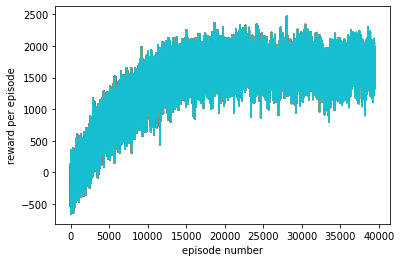

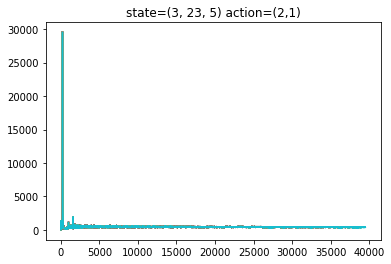

In [16]:
for episode in range(Episodes):

    # Write code here
    # Call the environment
    env=CabDriver()
    
    # Call all the initialised variables of the environment
    state_size = len(env.state_space)
    action_size = len(env.action_space)
    state=env.state_init
    score=0
    terminal_state=False
    train_step=0
    loss_train=0
    
    while terminal_state==False:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = env.action_space[agent.get_action(state)]

        # 2. Evaluate your reward and next state
        reward=env.reward_func(state,action,Time_matrix)
        next_state,done= env.next_state_func(state,action,Time_matrix)
        
        # 3. Append the experience to the memory
        agent.append_sample(state, action, reward, next_state, done)
        
        
        # 4. Train the model by calling function agent.train_model
        #Save the model for every 10th iteration to prevent performance issues
        if train_step % 10 == 0:
           loss_train=agent.train_model()
           
        
        train_step=train_step+1
        
        # 5. Keep a track of rewards, Q-values and loss values
        score += reward
        state = next_state
        terminal_state=done
        if loss_train!=None:
           loss_values.append(loss_train)
        
    #Track Rewards per episode   
    rewards_per_episode.append(score)
    episodes.append(episode)
    #store q-values of some prespecified state-action pairs
    agent.save_tracking_states()
                 
    
    # epsilon decay
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

    # every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon))
    # every few episodes:
    #Plot graph every few episodes to check for convergence    
    if episode % 500 == 0:
        
         plt.figure(0)
         #plt.subplot(241)
         #store q-values of some prespecified state-action pairs
         plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
         plt.xlabel("episode number")
         plt.ylabel("reward per episode")
         plt.savefig('reward_tracker.png')
         # save plots in saved_plots/ directory
            
         plt.figure(1)
         #plt.subplot(241)
         #store q-values of some prespecified state-action pairs
         plt.title('state=(3, 23, 5) action=(2,1)')
         xaxis = np.asarray(range(0, len(States_track[(3, 23, 5)][(2, 1)])))
         plt.plot(xaxis,np.asarray(States_track[(3, 23, 5)][(2, 1)]))
         plt.savefig('states_tracker.png')
        


# save model
agent.save(name="saved_pickle_files/modelpickelfile")

# save rewards_per_episode
save_pickle(rewards_per_episode, "saved_pickle_files/rewards_per_episode")



## Plot Results

### Plot Rewards per episode

Text(0, 0.5, 'Reward')

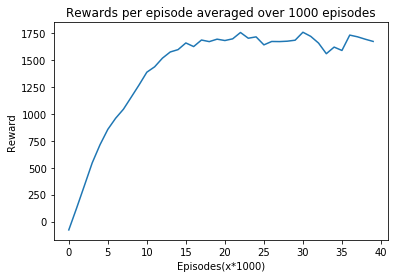

In [17]:
# plot results
with open('saved_pickle_files/rewards_per_episode.pkl', 'rb') as f:
    rewards_per_episode = pickle.load(f)

plt.title('Rewards per episode averaged over 1000 episodes')
listi=[np.mean(rewards_per_episode[i:i+1000]) for i in range(0,len(rewards_per_episode),1000)]
plt.plot(list(range(len(listi))), listi)
plt.xlabel("Episodes(x*1000)")
plt.ylabel("Reward")






In [18]:
print("Average reward of last 100 episodes is {0}".format(np.mean(rewards_per_episode[-100:]))) 




Average reward of last 100 episodes is 1702.1


### Tracking Convergence(Plotting in log scale for better view of convergence, due to extreme values for some episodes)

#### Q Values for state action pairs tracked

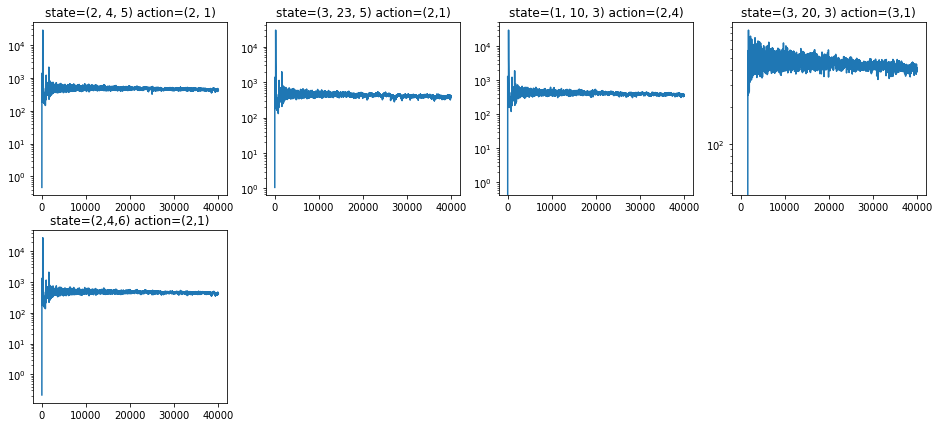

In [26]:

plt.figure(0, figsize=(16,7))

plt.subplot(241)
plt.title('state=(2, 4, 5) action=(2, 1)')
xaxis = np.asarray(range(0, len(States_track[(2, 4, 5)][(2, 1)])))
plt.plot(xaxis,np.asarray(States_track[(2, 4, 5)][(2, 1)]))
plt.yscale('log')

plt.subplot(242)
plt.title('state=(3, 23, 5) action=(2,1)')
xaxis = np.asarray(range(0, len(States_track[(3, 23, 5)][(2, 1)])))
plt.plot(xaxis,np.asarray(States_track[(3, 23, 5)][(2, 1)]))
plt.yscale('log')


plt.subplot(243)
plt.title('state=(1, 10, 3) action=(2,4)')
xaxis = np.asarray(range(0, len(States_track[(1, 10, 3)][(2, 4)])))
plt.plot(xaxis,np.asarray(States_track[(1, 10, 3)][(2, 4)]))
plt.yscale('log')


plt.subplot(244)
plt.title('state=(3, 20, 3) action=(3,1)')
xaxis = np.asarray(range(0, len(States_track[(3, 20, 3)][(3, 1)])))
plt.plot(xaxis,np.asarray(States_track[(3, 20, 3)][(3, 1)]))
plt.yscale('log')


plt.subplot(245)
plt.title('state=(2,4,6) action=(2,1)')
xaxis = np.asarray(range(0, len(States_track[(2,4,6)][(2, 1)])))
plt.plot(xaxis,np.asarray(States_track[(2,4,6)][(2, 1)]))
plt.yscale('log')



#### Loss

Text(0, 0.5, 'Loss')

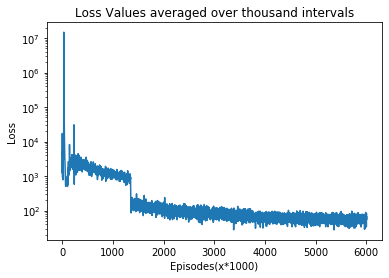

In [30]:
plt.title('Loss Values averaged over thousand intervals')
listi=[np.mean(loss_values[i:i+1000]) for i in range(0,len(loss_values),1000)]
plt.plot(list(range(len(listi))), listi)
plt.yscale('log')
plt.xlabel("Episodes(x*1000)")
plt.ylabel("Loss")

